In [1]:
import tensorflow as tf

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import indl

In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.decomposition import PCA
from scipy import signal
from scipy import stats
from sklearn.model_selection import train_test_split
from indl.fileio import from_neuropype_h5
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from itertools import cycle

import os

if Path.cwd().stem == 'Analysis':
    os.chdir(Path.cwd().parent.parent)
    
    
data_path = Path.cwd() / 'StudyLocationRule'/ 'Data' / 'Preprocessed'
if not (data_path).is_dir():
    !kaggle datasets download --unzip --path {str(data_path)} cboulay/macaque-8a-spikes-rates-and-saccades
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")
    
from misc.misc import sess_infos, load_macaque_pfc, dec_from_enc

load_kwargs = {
    'valid_outcomes': (0,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_error = {
    'valid_outcomes': (9,),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

load_kwargs_all = {
    'valid_outcomes': (0,9),  # Use (0, 9) to include trials with incorrect behaviour
    'zscore': True,
    'dprime_range': (1.0, np.inf),  # Use (-np.inf, np.inf) to include all trials.
    'time_range': (-np.inf, 1.25),
    'verbose': False,
    'y_type': 'sacClass',
    'samples_last': True    
    #     'resample_X': 20
}

model_kwargs = dict(
    filt=8,
    kernLength=20,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=0,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model_kwargs1 = dict(
    filt=16,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)
model_kwargs2 = dict(
    filt=32,
    kernLength=30,
    ds_rate=5,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.40,
    activation='relu',
    l1_reg=0.0000, l2_reg=0.001,
    norm_rate=0.25,
    latent_dim=64
)

N_SPLITS = 10
BATCH_SIZE = 16
EPOCHS = 150
EPOCHS2 = 100
LABEL_SMOOTHING = 0.2

Data directory found. Skipping download.


In [5]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
from indl.model import parts
from indl.regularizers import KernelLengthRegularizer

def make_model(
    _input,
    num_classes,
    filt=8,
    kernLength=25,
    ds_rate=10,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    
    if _input.shape[2] < 10:
        kernLength = 4
        filt = 4
        ds_rate = 4
    elif _input.shape[2] < 20:
        kernLength = 8
        ds_rate = 8
    elif _input.shape[2] < 30:
        kernLength = 16
    
    input_shape = list(_input.shape)
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    # input_shape[2] = -1  # Comment out during debug
    # _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

    # RNN
    if len(input_shape) < 4:
        input_shape = input_shape + [1]
    # The Conv layers are insensitive to the number of samples in the time dimension.
    # To make it possible for this trained model to be applied to segments of different
    # durations, we need to explicitly state that we don't care about the number of samples.
    _y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
    _y = tf.keras.layers.Conv2D(filt, (1, kernLength), padding='valid', data_format=None,
                                dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                                bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                                activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.DepthwiseConv2D((_y.shape.as_list()[1], 1), padding='valid',
                                      depth_multiplier=1, data_format=None, dilation_rate=(1, 1),
                                      activation=None, use_bias=True, depthwise_initializer='glorot_uniform',
                                      bias_initializer='zeros', depthwise_regularizer=None,
                                      bias_regularizer=None, activity_regularizer=None,
                                      depthwise_constraint=None, bias_constraint=None)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.AveragePooling2D(pool_size=(1, ds_rate))(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    _y = tf.keras.layers.Reshape(_y.shape.as_list()[2:])(_y)
    _y = tf.keras.layers.LSTM(n_rnn,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=n_rnn2 > 0,
                              stateful=False,
                              name='rnn1')(_y)
    _y = tf.keras.layers.Activation(activation)(_y)
    _y = tf.keras.layers.BatchNormalization()(_y)
    _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    
    if n_rnn2 > 0:
        
        _y = tf.keras.layers.LSTM(n_rnn2,
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                              recurrent_regularizer=tf.keras.regularizers.l2(l2_reg),
                              return_sequences=False,
                              stateful=False,
                              name='rnn2')(_y)
        _y = tf.keras.layers.Activation(activation)(_y)
        _y = tf.keras.layers.BatchNormalization()(_y)
        _y = tf.keras.layers.Dropout(dropoutRate)(_y)
    
    # Dense
    _y = tf.keras.layers.Dense(latent_dim, activation=activation)(_y)
#     _y = parts.Bottleneck(_y, latent_dim=latent_dim, activation=activation)
    
    # Classify
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(_y)
#     outputs = parts.Classify(_y, n_classes=num_classes, norm_rate=norm_rate)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)
    


def kfold_pred(sess_id,X_rates,Y_class,name, verbose=1):
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=np.max(Y_class)+1)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(X_rates, _y.shape[-1], **model_kwargs)
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'{name}_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
    pred_y = np.concatenate([np.argmax(_, axis=1) for _ in per_fold_eval])
    true_y = np.concatenate(per_fold_true).flatten()
    accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
    print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")
    
    return history, accuracy, pred_y, true_y

In [7]:
sess_infos

[{'name': 'JerryLee',
  'bank': 'A',
  'name_short': 'j',
  'date': '090601',
  'exp_code': 'sra3_2_j_037_00+03',
  'nsx': 'datafile003.ns2'},
 {'name': 'JerryLee',
  'bank': 'A',
  'name_short': 'j',
  'date': '090623',
  'exp_code': 'sra3_1_j_050_00+',
  'nsx': 'datafile002.ns2'},
 {'name': 'JerryLee',
  'bank': 'B',
  'name_short': 'j',
  'date': '090624',
  'exp_code': 'sra3_1_j_051_00+',
  'nsx': 'datafile002.ns2'},
 {'name': 'JerryLee',
  'bank': 'C',
  'name_short': 'j',
  'date': '090625',
  'exp_code': 'sra3_1_j_052_00+',
  'nsx': 'datafile003.ns2'},
 {'name': 'Marty',
  'bank': 'C',
  'name_short': 'm',
  'date': '090919',
  'exp_code': 'sra3_1_m_077_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Marty',
  'bank': 'B',
  'name_short': 'm',
  'date': '090925',
  'exp_code': 'sra3_1_m_081_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Marty',
  'bank': 'A',
  'name_short': 'm',
  'date': '090926',
  'exp_code': 'sra3_1_m_082_00+01',
  'nsx': 'datafile001.ns2'},
 {'name': 'Mar

In [9]:
a = "hihoware+you"
a = a.replace("+","") + "v1_segmented.h5"
print(a)

hihowareyouv1_segmented.h5


In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [44]:
for i in range(1,8):
    print(i)

1
2
3
4
5
6
7


# Rule Similarity Score Analysis

sra3_1_j_050_00+


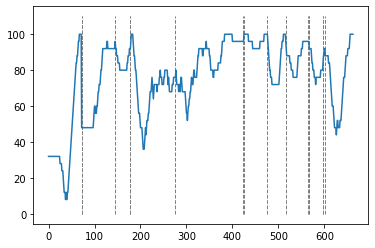

learned arg:  [58 59 60 61 62 63 64 65 66 67 68 69 70 71]
colors:  (array(['b', 'g'], dtype=object), array([35, 37], dtype=int64))
targets:  (array([0, 4]), array([35, 37], dtype=int64))
g 4 

learned arg:  []
colors:  (array(['g'], dtype=object), array([1], dtype=int64))
targets:  (array([4]), array([1], dtype=int64))
g 4 

learned arg:  [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71]
colors:  (array(['b', 'r'], dtype=object), array([37, 35], dtype=int64))
targets:  (array([1, 3, 7]), array([ 1, 34, 37], dtype=int64))
b 7 

learned arg:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
colors:  (array(['b', 'g'], dtype=object), array([19, 13], dtype=int64))
targets:  (array([0, 4, 7]), array([18, 13,  1], dtype=int64))
g 4 

learned arg:  [0]
colors:  (array(['g'], dtype=object), array([1], dtype=int64))
targets:  (array([4]), array([1], dtype=int64))
g 4 

learned arg:  [ 0  1  2  3  

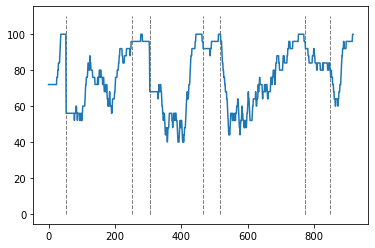

learned arg:  [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]
colors:  (array(['b', 'g'], dtype=object), array([27, 26], dtype=int64))
targets:  (array([0, 4], dtype=int64), array([27, 26], dtype=int64))
g 4 

learned arg:  [ 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  95  96  98  99 100 101 102 103 104 105
 106 107 108 109 112 113 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198]
colors:  (array(['b', 'g', 'r'], dtype=object), array([ 94,   1, 104], dtype=int64))
targets:  (array([2, 4, 6], dtype=int64), array([ 94,   1, 104], dtype=int64))
b 2 

learned arg:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
colors:  (array

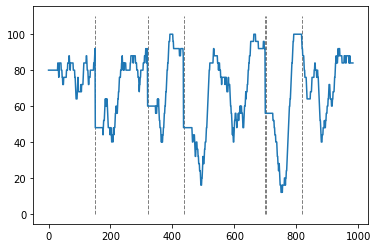

learned arg:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  95 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150]
colors:  (array(['b', 'r'], dtype=object), array([78, 73], dtype=int64))
targets:  (array([3, 7], dtype=int64), array([78, 73], dtype=int64))
r 7 

learned arg:  [ 78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162

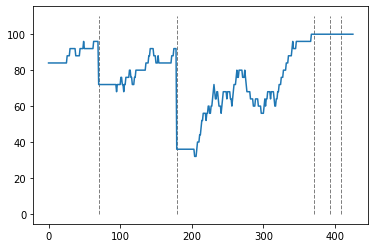

learned arg:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
colors:  (array(['g', 'r'], dtype=object), array([28, 42], dtype=int64))
targets:  (array([2, 6], dtype=int64), array([42, 28], dtype=int64))
r 2 

learned arg:  [ 31  32  38  39  40  41  42  43  44  45  46  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108]
colors:  (array(['g', 'r'], dtype=object), array([61, 48], dtype=int64))
targets:  (array([3, 6, 7], dtype=int64), array([48,  1, 60], dtype=int64))
g 7 

learned arg:  [ 83  84  85  86  87  88  89  90  91  92  93  94  95  96 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 1

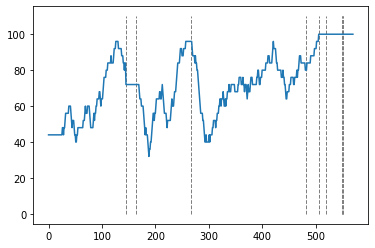

learned arg:  [104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144]
colors:  (array(['g', 'r'], dtype=object), array([60, 85], dtype=int64))
targets:  (array([3, 7], dtype=int64), array([60, 85], dtype=int64))
r 7 

learned arg:  []
colors:  (array(['g', 'r'], dtype=object), array([ 8, 10], dtype=int64))
targets:  (array([3, 7], dtype=int64), array([ 8, 10], dtype=int64))
g 3 

learned arg:  [ 77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103]
colors:  (array(['g', 'r'], dtype=object), array([48, 56], dtype=int64))
targets:  (array([1, 5, 7], dtype=int64), array([55, 48,  1], dtype=int64))
g 5 

learned arg:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  90  91  92  93
  97 112 113 114 123 124 125 126 127 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 

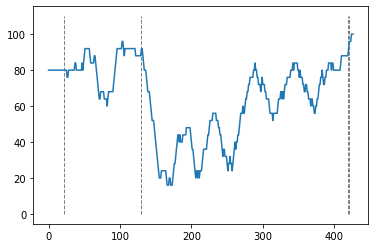

learned arg:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
colors:  (array(['b', 'g'], dtype=object), array([13,  8], dtype=int64))
targets:  (array([1, 5], dtype=int64), array([ 8, 13], dtype=int64))
g 1 

learned arg:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108]
colors:  (array(['b', 'g', 'r'], dtype=object), array([63,  1, 45], dtype=int64))
targets:  (array([1, 2, 6], dtype=int64), array([ 1, 63, 45], dtype=int64))
b 2 

learned arg:  [  0   1   2   3   4   5   6   7 152 153 154 155 156 157 158 159 160 161
 162 163 169 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 251 252 253 254 257 258 259 260 261 262 263
 264 265 266

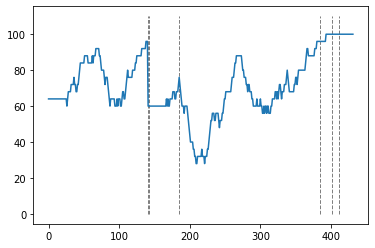

learned arg:  [ 36  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  81  82  83 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140]
colors:  (array(['b', 'r'], dtype=object), array([65, 76], dtype=int64))
targets:  (array([2, 6], dtype=int64), array([65, 76], dtype=int64))
b 2 

learned arg:  []
colors:  (array(['r'], dtype=object), array([1], dtype=int64))
targets:  (array([6], dtype=int64), array([1], dtype=int64))
r 6 

learned arg:  []
colors:  (array(['b', 'g'], dtype=object), array([19, 24], dtype=int64))
targets:  (array([0, 4, 7], dtype=int64), array([23, 19,  1], dtype=int64))
b 4 

learned arg:  [  0  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94 152 153 154 165 166 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 1

In [48]:
for test_sess_ix in range(1,8):
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+","")+"_segmented.h5"
    segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / sess_id
    segmented_data = from_neuropype_h5(segmented_path)
    # times = np.arange(-250, 1805, 5)/1000
    outcome = np.array(segmented_data[2][1]['axes'][0]['data']['newOutcomeCode'])
    flag = np.argwhere(outcome > -1).flatten()
    outcome = outcome[flag]
    color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()[flag]
    block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()[flag]
    target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])[flag]
    # spike = np.zeros((np.size(spikes, 0), np.size(spikes, 1) // 5 + 1, np.size(spikes, 2)))
    # for i in range(np.size(spikes, 0)):
    #     for j in range(np.size(spikes, 1)):
    #         for k in range(np.size(spikes, 2)):
    #             if spikes[i, j, k]:
    #                 spike[i, j // 5, k] = 1
    bl = np.diff(block, axis=0)
    border = np.array(np.where(bl > 0)).flatten()
    # to_keep = [0]
    # for i in range(len(border) - 1):
    #     if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
    #         to_keep.append(i + 1)
    # border = border[to_keep]
    m_performance = np.zeros(len(outcome))
    cor = 0
    b = 0
    tot = 25
    for i in range(tot):
        if outcome[i] == 0:
            cor += 1

    m_performance[:tot] = 100 * (cor / tot)
    i = tot
    while i < len(outcome):
        if i == border[b]:
            cor = 0
            for j in range(tot):
                if outcome[i + j] == 0:
                    cor += 1
            m_performance[i:i + tot] = 100 * (cor / tot)
            i += tot
            b = (b + 1) % len(border)
        elif outcome[i] == outcome[i - tot]:
            m_performance[i] = m_performance[i - 1]
            i += 1
        elif outcome[i] == 0:
            cor += 1
            m_performance[i] = 100 * (cor / tot)
            i += 1
        else:
            cor -= 1
            m_performance[i] = 100 * (cor / tot)
            i += 1

    print(sess_info['exp_code'])
    plt.figure()
    plt.plot(m_performance)
    for i in range(len(border)):
        plt.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey', linewidth=1)
    plt.show()
    f = 0
    for e in border:
        print("learned arg: ", np.argwhere(m_performance[f:e]>75).flatten())
        print("colors: ", np.unique(color[f:e], return_counts=True))
        print("targets: ", np.unique(target[f:e], return_counts=True))
        print(color[f+int((e-f)/2)], target[f+int((e-f)/2)], "\n")
        f = e

    f = border[-1]
    e = len(outcome)
    print("learned arg: ", np.argwhere(m_performance[f:e]>75).flatten())
    print("colors: ", np.unique(color[f:e], return_counts=True))
    print("targets: ", np.unique(target[f:e], return_counts=True))
    print(color[f+int((e-f)/2)], target[f+int((e-f)/2)], "\n")

In [66]:
rss = [0, 0.25, 1, -0.5, 0.375, 1, 0.1667, 0.3333, 0.291667, -0.20833]
rss2 = [0, 0, 1, -0.5, -0.25, -0.5, 0.375, 0.625]
rss3 = [0, 0, -0.5, -0.25, 0, 0.5]
nt = [58, 40, 0, 47, 35, 0, 26, 0, 0, 40]
nt2 = [25, 61, 0, 120, 0, 118, 0, 34]
nt3 = [0, 78, 62, 82, 83, 0]

In [88]:
a=[34, 0]
print(np.mean(a), np.std(a))

17.0 17.0


In [67]:
rss=[0,0.25, 1, -0.5, 0.25, 1, .25, 1, 1, -0.5]
rss2=[0, 0, 1, -1, 1, -0.5, 1, 0.5]
rss3=[0, 0, -0.5, -1, 0, 0.5]

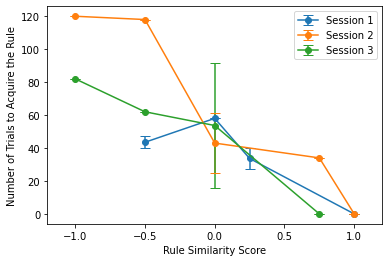

In [95]:
rss=[-0.5, 0, .25, 1]
rss2=[-1, -0.5, 0, 0.75, 1]
rss3=[-1, -0.5, 0, 0.75]
nta=[43.5, 58, 33.6666, 0]
nta2=[120, 118, 43, 34, 0]
nta3=[82, 62, 53.666, 0]
e = [3.5, 0, 6.4, 0]
e2=[0, 0, 18, 0, 0]
e3=[0, 0, 38, 0]
plt.errorbar(rss, nta, e, marker='o',capsize=5, label='Session 1')
plt.errorbar(rss2, nta2, e2, marker='o',capsize=5, label='Session 2')
plt.errorbar(rss3, nta3, e3, marker='o',capsize=5, label='Session 3')
plt.xlim(-1.2, 1.2)
plt.legend()
plt.xlabel("Rule Similarity Score")
plt.ylabel("Number of Trials to Acquire the Rule")
plt.savefig("rss_separate.svg")

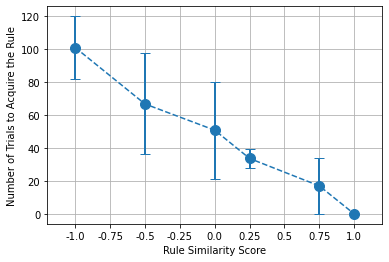

In [25]:
rss = [-1, -0.5, 0, 0.25, 0.75, 1]
nta = [101, 66.75, 50.833333333333336, 33.666666666666664, 17, 0]
e = [19, 30.638007441738115, 29.379225464414287, 5.792715732327589, 17, 0]
plt.errorbar(rss, nta, e, fmt='.', markersize='20', elinewidth=2, capsize=5, ls='dashed')
plt.grid()
plt.xlim(-1.2, 1.2)
p = [-1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
plt.xticks(p,p)
plt.xlabel("Rule Similarity Score")
plt.ylabel("Number of Trials to Acquire the Rule")
plt.savefig("rss_combined.svg")

In [68]:
rss, nt = zip(*sorted(zip(rss, nt)))
rss2, nt2 = zip(*sorted(zip(rss2, nt2)))
rss3, nt3 = zip(*sorted(zip(rss3, nt3)))

Text(0, 0.5, 'Number of Trials to Acquire the Rule')

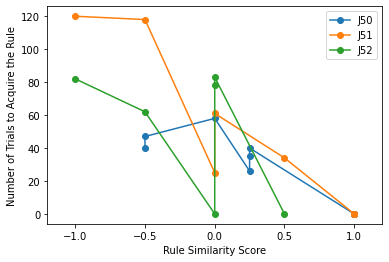

In [69]:
plt.figure()
plt.plot(rss, nt, '-o' , label='J50')
plt.plot(rss2, nt2, '-o', label='J51')
plt.plot(rss3, nt3, '-o', label='J52')
plt.xlim(-1.2, 1.2)
plt.legend()
plt.xlabel("Rule Similarity Score")
plt.ylabel("Number of Trials to Acquire the Rule")

# Monkey Performance

In [18]:
 sess_infos.append ({'name': 'Marty',
                 'bank': 'A',
                 'name_short': 'm',
                 'date': '',
                 'exp_code': 'sra3_1_m_074_00+01',
                 'nsx': ''})

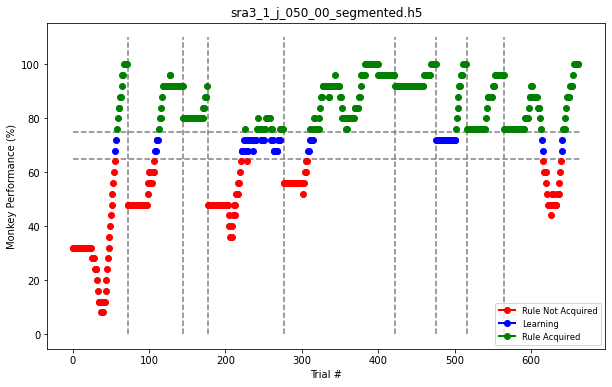

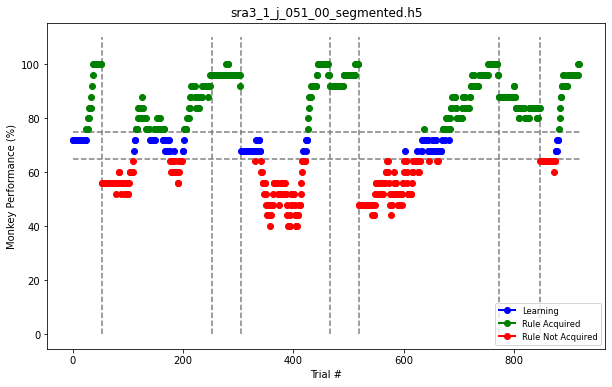

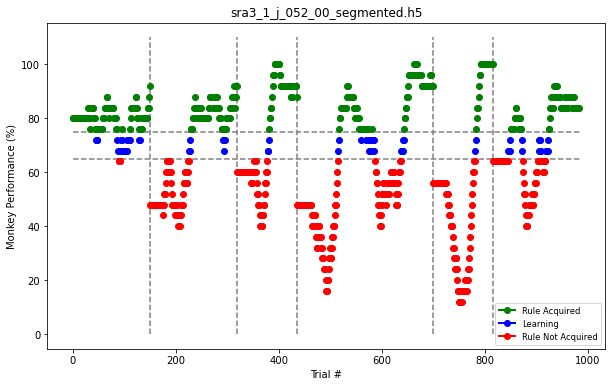

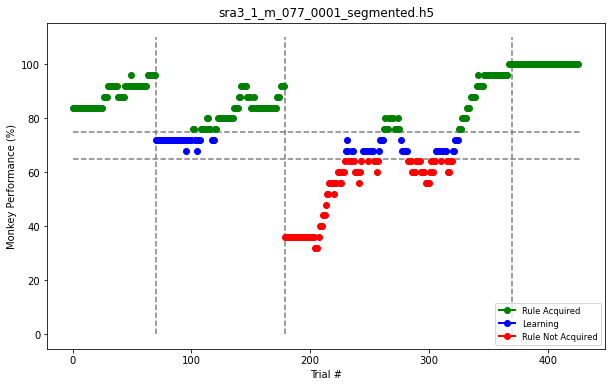

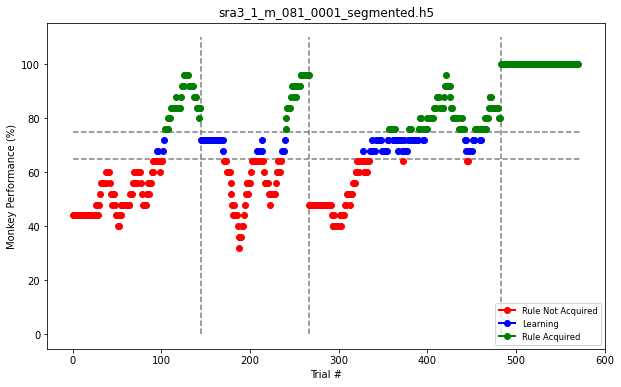

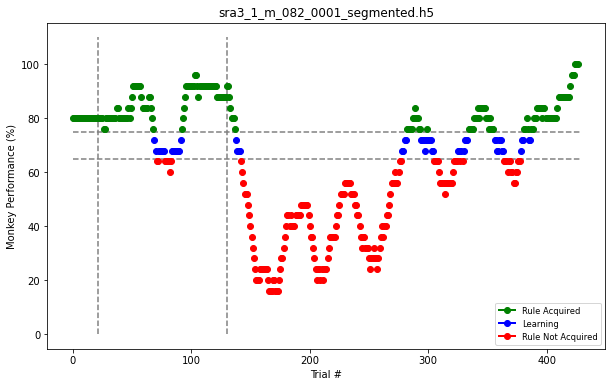

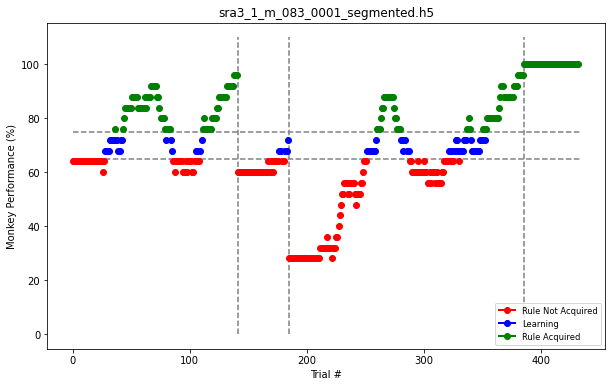

In [23]:
for test_sess_ix in range(1,8):
    sess_info = sess_infos[test_sess_ix]
    sess_id = sess_info['exp_code']
    sess_id = sess_id.replace("+","")+"_segmented.h5"
    segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / sess_id
    segmented_data = from_neuropype_h5(segmented_path)
    # times = np.arange(-250, 1805, 5)/1000
    outcome = np.array(segmented_data[2][1]['axes'][0]['data']['newOutcomeCode'])
    flag = np.argwhere(outcome > -1).flatten()
    outcome = outcome[flag]
    color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()[flag]
    block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()[flag]
    target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])[flag]
    # spike = np.zeros((np.size(spikes, 0), np.size(spikes, 1) // 5 + 1, np.size(spikes, 2)))
    # for i in range(np.size(spikes, 0)):
    #     for j in range(np.size(spikes, 1)):
    #         for k in range(np.size(spikes, 2)):
    #             if spikes[i, j, k]:
    #                 spike[i, j // 5, k] = 1
    bl = np.diff(block, axis=0)
    border = np.array(np.where(bl > 0)).flatten()
    to_keep = [0]
    for i in range(len(border) - 1):
        if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
            to_keep.append(i + 1)
    border = border[to_keep]
    m_performance = np.zeros(len(outcome))
    cor = 0
    b = 0
    tot = 25
    for i in range(tot):
        if outcome[i] == 0:
            cor += 1

    m_performance[:tot] = 100 * (cor / tot)
    i = tot
    while i < len(outcome):
        if i == border[b]:
            cor = 0
            for j in range(tot):
                if outcome[i + j] == 0:
                    cor += 1
            m_performance[i:i + tot] = 100 * (cor / tot)
            i += tot
            b = (b + 1) % len(border)
        elif outcome[i] == outcome[i - tot]:
            m_performance[i] = m_performance[i - 1]
            i += 1
        elif outcome[i] == 0:
            cor += 1
            m_performance[i] = 100 * (cor / tot)
            i += 1
        else:
            cor -= 1
            m_performance[i] = 100 * (cor / tot)
            i += 1

    fig, ax = plt.subplots(figsize=(10,6))
    first = np.zeros(3)


    for i in range(len(m_performance)):
        if m_performance[i] > 75:
            if (first[0] == 0):
                ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
                first[0] = 1
            else:
                ax.plot(i, m_performance[i], 'go-', linewidth=2)


        elif m_performance[i] < 65:
            if (first[1] == 0):
                ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
                first[1] = 1
            else:
                ax.plot(i, m_performance[i], 'ro-', linewidth=2)
        else:
            if (first[2] == 0):
                ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
                first[2] = 1
            else:
                ax.plot(i, m_performance[i], 'bo-', linewidth=2)

    for i in range(len(border)):
        ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')

    ax.hlines(y=65, xmin=0, xmax=len(m_performance)+1, linestyles='dashed', colors='grey')
    ax.hlines(y=75, xmin=0, xmax=len(m_performance)+1, linestyles='dashed', colors='grey')

    plt.ylabel("Monkey Performance (%)")
    plt.xlabel("Trial #")
    ax.legend(loc='lower right', fontsize='small')
    plt.title(sess_id)
    plt.savefig(f"monkey_performance_sess_{test_sess_ix}.svg")

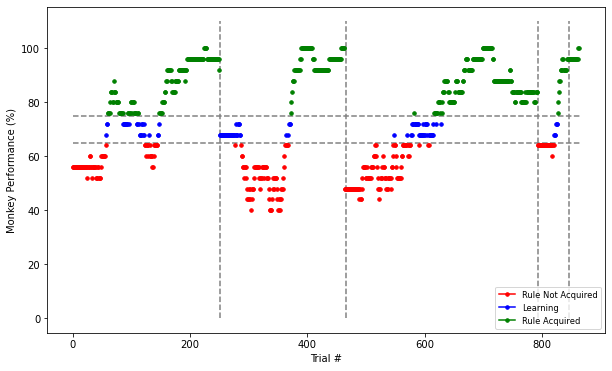

In [22]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
sess_id = sess_id.replace("+","")+"_segmented.h5"
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / sess_id
segmented_data = from_neuropype_h5(segmented_path)
# times = np.arange(-250, 1805, 5)/1000
outcome = np.array(segmented_data[2][1]['axes'][0]['data']['newOutcomeCode'])
flag = np.argwhere(outcome > -1).flatten()
outcome = outcome[flag]
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()[flag]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()[flag]
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])[flag]
# spike = np.zeros((np.size(spikes, 0), np.size(spikes, 1) // 5 + 1, np.size(spikes, 2)))
# for i in range(np.size(spikes, 0)):
#     for j in range(np.size(spikes, 1)):
#         for k in range(np.size(spikes, 2)):
#             if spikes[i, j, k]:
#                 spike[i, j // 5, k] = 1
bl = np.diff(block, axis=0)
border = np.array(np.where(bl > 0)).flatten()
to_keep = [0]
for i in range(len(border) - 1):
    if (border[i + 1] - border[i]) > 30 and (len(outcome)-border[i+1]) > 30:
        to_keep.append(i + 1)
border = border[to_keep]
m_performance = np.zeros(len(outcome))
cor = 0
b = 0
tot = 25
for i in range(tot):
    if outcome[i] == 0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
i = tot
while i < len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i + j] == 0:
                cor += 1
        m_performance[i:i + tot] = 100 * (cor / tot)
        i += tot
        b = (b + 1) % len(border)
    elif outcome[i] == outcome[i - tot]:
        m_performance[i] = m_performance[i - 1]
        i += 1
    elif outcome[i] == 0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
m_performance = m_performance[border[0]+1:]
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', markersize=3.5, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', markersize=3.5)


    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', markersize=3.5, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', markersize=3.5)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', markersize=3.5, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', markersize=3.5)

for i in [1, 3, 6]:
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
ax.vlines(x=794, ymin=0, ymax=110, linestyles='dashed', colors='grey')
ax.hlines(y=65, xmin=0, xmax=len(m_performance)+1, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=len(m_performance)+1, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
# plt.title(sess_id)
plt.savefig(f"monkey_performance_sess_{test_sess_ix}.svg")

In [40]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title(session_id)

663

In [30]:
print("learned arg: ", np.argwhere(m_performance[0:72]>75).flatten()[0])
print("colors: ", np.unique(color[0:72], return_counts=True))

learned arg:  58
colors:  (array(['b', 'g'], dtype=object), array([35, 37], dtype=int64))


# RNN

## Block A

### J50_A

In [4]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_050_00_segmented_v2.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[ 72  73 145 177 178 276 422 426 476 516 565 566 567 597 598 602]
sra3_1_j_050_00+
(663,)
(663, 36, 123)
(663,) 0 7


In [14]:
border = np.array([72, 145, 177, 276, 422, 476, 516, 565, 597])

In [16]:
# for i in range(len(border)-1):
#     print(f"block {border[i]} to {border[i+1]}:")
#     print(np.unique(target[border[i]:border[i+1]], return_index=True, return_counts=True))
#     print(np.unique(color[border[i]:border[i+1]], return_index=True, return_counts=True))

In [90]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [91]:
print(np.unique(_y[:330], return_counts=True))
print(np.unique(_y[330:], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([38, 36, 49, 27, 43, 57, 50, 30], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([45, 39, 51, 31, 27, 58, 47, 35], dtype=int64))


In [92]:
x_tr = _x[:330]
tmp = _y[:330]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[330:]
tmp = _y[330:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/150
20/20 [==============================] - 2s 121ms/step - loss: 2.6409 - accuracy: 0.1813 - val_loss: 2.3239 - val_accuracy: 0.2042
Epoch 2/150
20/20 [==============================] - 1s 65ms/step - loss: 2.1552 - accuracy: 0.3031 - val_loss: 2.3008 - val_accuracy: 0.4054
Epoch 3/150
20/20 [==============================] - 1s 68ms/step - loss: 1.9286 - accuracy: 0.4531 - val_loss: 2.2691 - val_accuracy: 0.4444
Epoch 4/150
20/20 [==============================] - 1s 65ms/step - loss: 1.8365 - accuracy: 0.4781 - val_loss: 2.2323 - val_accuracy: 0.4835
Epoch 5/150
20/20 [==============================] - 1s 64ms/step - loss: 1.7732 - accuracy: 0.5188 - val_loss: 2.1930 - val_accuracy: 0.5075
Epoch 6/150
20/20 [==============================] - 1s 66ms/step - loss: 1.7288 - accuracy: 0.5531 - val_loss: 2.1569 - val_accuracy: 0.4955
Epoch 7/150
20/20 [==============================] - 1s 67ms/step - loss: 1.6979 - accuracy: 0.5813 - val_loss: 2.0975 - val_accuracy: 0.4955
Epoch

20/20 [==============================] - 1s 75ms/step - loss: 0.9561 - accuracy: 0.9781 - val_loss: 1.4228 - val_accuracy: 0.7688
Epoch 116/150
20/20 [==============================] - 2s 75ms/step - loss: 0.9610 - accuracy: 0.9844 - val_loss: 1.4587 - val_accuracy: 0.7628
Epoch 117/150
20/20 [==============================] - 2s 79ms/step - loss: 0.9536 - accuracy: 0.9906 - val_loss: 1.4191 - val_accuracy: 0.7628
Epoch 118/150
20/20 [==============================] - 2s 77ms/step - loss: 0.9613 - accuracy: 0.9781 - val_loss: 1.4468 - val_accuracy: 0.7508
Epoch 119/150
20/20 [==============================] - 2s 77ms/step - loss: 0.9684 - accuracy: 0.9719 - val_loss: 1.3873 - val_accuracy: 0.7598
Epoch 120/150
20/20 [==============================] - 2s 76ms/step - loss: 0.9604 - accuracy: 0.9781 - val_loss: 1.4482 - val_accuracy: 0.7267
Epoch 121/150
20/20 [==============================] - 2s 78ms/step - loss: 0.9541 - accuracy: 0.9781 - val_loss: 1.4034 - val_accuracy: 0.7688
Epoch 

In [93]:
# Second half predicted
pred_y1

array([5, 1, 5, 7, 6, 1, 5, 0, 2, 5, 1, 1, 7, 5, 6, 5, 1, 0, 1, 2, 4, 6,
       0, 2, 1, 7, 6, 4, 2, 1, 2, 5, 1, 2, 1, 2, 1, 4, 7, 5, 1, 3, 6, 2,
       6, 2, 2, 6, 6, 6, 0, 0, 2, 1, 7, 5, 4, 6, 5, 6, 6, 5, 5, 5, 3, 0,
       1, 1, 1, 7, 6, 4, 7, 6, 2, 4, 5, 4, 0, 1, 2, 1, 7, 5, 2, 5, 5, 7,
       2, 7, 4, 0, 1, 4, 0, 0, 0, 0, 1, 2, 5, 4, 0, 2, 4, 3, 3, 6, 0, 5,
       7, 6, 7, 4, 5, 2, 4, 1, 7, 0, 3, 2, 7, 6, 2, 6, 4, 5, 1, 7, 5, 5,
       5, 6, 6, 7, 7, 0, 0, 2, 1, 7, 4, 4, 5, 3, 5, 3, 7, 2, 3, 2, 1, 2,
       7, 2, 6, 3, 6, 1, 4, 4, 6, 7, 7, 7, 0, 5, 1, 0, 3, 7, 5, 1, 7, 7,
       0, 2, 5, 6, 5, 0, 2, 0, 2, 6, 4, 2, 1, 2, 7, 2, 4, 4, 5, 6, 4, 0,
       0, 7, 3, 5, 3, 5, 1, 1, 7, 5, 3, 7, 2, 5, 6, 0, 2, 0, 3, 0, 1, 0,
       6, 5, 5, 7, 5, 0, 4, 7, 4, 0, 4, 2, 5, 6, 6, 2, 6, 7, 1, 6, 5, 2,
       6, 7, 6, 5, 5, 3, 5, 5, 5, 2, 3, 2, 6, 5, 5, 7, 2, 1, 6, 1, 2, 5,
       2, 0, 0, 6, 6, 0, 1, 5, 0, 2, 1, 5, 7, 1, 1, 2, 6, 0, 5, 2, 3, 7,
       0, 5, 7, 5, 0, 4, 5, 2, 0, 2, 7, 2, 2, 3, 3,

In [94]:
x_tr = _x[330:]
tmp = _y[330:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:330]
tmp = _y[:330]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/150
20/20 [==============================] - 4s 199ms/step - loss: 2.6044 - accuracy: 0.2062 - val_loss: 2.3267 - val_accuracy: 0.2697
Epoch 2/150
20/20 [==============================] - 2s 95ms/step - loss: 2.1383 - accuracy: 0.3656 - val_loss: 2.3095 - val_accuracy: 0.3333
Epoch 3/150
20/20 [==============================] - 2s 94ms/step - loss: 1.9052 - accuracy: 0.4750 - val_loss: 2.2806 - val_accuracy: 0.4212
Epoch 4/150
20/20 [==============================] - 2s 97ms/step - loss: 1.8472 - accuracy: 0.4938 - val_loss: 2.2512 - val_accuracy: 0.4818
Epoch 5/150
20/20 [==============================] - 2s 98ms/step - loss: 1.7421 - accuracy: 0.5625 - val_loss: 2.2175 - val_accuracy: 0.5030
Epoch 6/150
20/20 [==============================] - 2s 95ms/step - loss: 1.7183 - accuracy: 0.5500 - val_loss: 2.1727 - val_accuracy: 0.5182
Epoch 7/150
20/20 [==============================] - 2s 95ms/step - loss: 1.7080 - accuracy: 0.5594 - val_loss: 2.1302 - val_accuracy: 0.5242
Epoch

20/20 [==============================] - 2s 80ms/step - loss: 0.9575 - accuracy: 0.9844 - val_loss: 1.4192 - val_accuracy: 0.7515
Epoch 116/150
20/20 [==============================] - 2s 79ms/step - loss: 0.9564 - accuracy: 0.9812 - val_loss: 1.4215 - val_accuracy: 0.7242
Epoch 117/150
20/20 [==============================] - 2s 77ms/step - loss: 0.9755 - accuracy: 0.9656 - val_loss: 1.4450 - val_accuracy: 0.7333
Epoch 118/150
20/20 [==============================] - 2s 75ms/step - loss: 0.9518 - accuracy: 0.9875 - val_loss: 1.4294 - val_accuracy: 0.7242
Epoch 119/150
20/20 [==============================] - 2s 80ms/step - loss: 0.9568 - accuracy: 0.9750 - val_loss: 1.4270 - val_accuracy: 0.7333
Epoch 120/150
20/20 [==============================] - 2s 80ms/step - loss: 0.9651 - accuracy: 0.9781 - val_loss: 1.4457 - val_accuracy: 0.7091
Epoch 121/150
20/20 [==============================] - 2s 79ms/step - loss: 0.9472 - accuracy: 0.9875 - val_loss: 1.4149 - val_accuracy: 0.7455
Epoch 

In [95]:
# First half predicted
pred_y2

array([2, 5, 6, 1, 0, 2, 6, 4, 6, 1, 1, 7, 3, 5, 2, 1, 7, 2, 6, 6, 5, 6,
       3, 6, 0, 0, 2, 6, 3, 0, 4, 7, 3, 0, 6, 2, 1, 2, 0, 5, 2, 1, 2, 7,
       4, 3, 0, 6, 3, 3, 5, 5, 0, 1, 6, 0, 5, 1, 2, 2, 5, 7, 1, 1, 3, 2,
       0, 0, 1, 5, 3, 7, 4, 6, 5, 5, 0, 0, 7, 1, 1, 2, 6, 5, 6, 4, 3, 1,
       2, 2, 1, 3, 2, 0, 3, 4, 7, 1, 5, 0, 2, 4, 6, 0, 0, 1, 5, 5, 4, 1,
       1, 2, 2, 5, 3, 2, 2, 2, 3, 3, 4, 6, 2, 6, 5, 0, 0, 4, 3, 6, 6, 5,
       6, 0, 2, 3, 3, 0, 3, 5, 7, 6, 5, 4, 6, 4, 2, 4, 1, 2, 2, 2, 2, 4,
       2, 5, 0, 6, 4, 7, 2, 5, 4, 5, 5, 3, 2, 2, 3, 6, 5, 3, 6, 1, 0, 0,
       0, 5, 3, 2, 4, 5, 4, 6, 7, 2, 3, 5, 6, 2, 3, 5, 0, 5, 0, 4, 1, 6,
       5, 0, 2, 4, 7, 7, 1, 3, 4, 1, 6, 5, 4, 4, 0, 4, 3, 3, 3, 0, 3, 0,
       2, 4, 1, 1, 0, 0, 5, 0, 4, 3, 4, 2, 3, 2, 0, 4, 2, 0, 0, 0, 1, 1,
       2, 4, 2, 3, 5, 2, 4, 0, 2, 5, 1, 5, 7, 5, 5, 2, 5, 0, 3, 5, 3, 7,
       2, 6, 6, 3, 2, 3, 6, 7, 1, 4, 7, 2, 5, 3, 2, 1, 0, 4, 0, 6, 4, 6,
       6, 6, 0, 3, 1, 5, 6, 6, 5, 6, 2, 6, 5, 1, 2,

In [96]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

In [97]:
pred_y

array([0, 4, 0, 0, 4, 0, 4, 4, 4, 4, 0, 4, 0, 0, 4, 0, 4, 0, 4, 0, 0, 4,
       0, 4, 4, 0, 4, 4, 0, 0, 0, 4, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 4, 4, 0, 0, 4, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4,
       4, 0, 4, 4, 4, 4, 4, 5, 3, 3, 7, 3, 3, 3, 7, 3, 7, 7, 3, 3, 7, 3,
       3, 3, 3, 3, 3, 3, 7, 7, 3, 3, 7, 3, 7, 3, 7, 3, 3, 7, 3, 7, 7, 7,
       3, 7, 3, 3, 7, 3, 7, 7, 7, 3, 7, 3, 7, 3, 3, 7, 3, 3, 7, 7, 3, 7,
       7, 3, 7, 3, 3, 7, 3, 7, 7, 7, 3, 3, 3, 7, 0, 4, 4, 4, 0, 4, 0, 0,
       4, 0, 0, 4, 4, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0,
       0, 4, 1, 5, 1, 5, 1, 5, 1, 1, 1, 1, 1, 5, 1, 5, 1, 1, 1, 1, 1, 5,
       5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 1, 1,
       1, 5, 5, 5, 5, 5, 5, 1, 1, 5, 5, 5, 5, 5, 1, 1, 5, 1, 5, 5, 5, 1,
       5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 1, 5, 1, 1, 1, 1, 5, 1, 1, 5, 5, 5,
       5, 1, 5, 5, 1, 5, 1, 5, 5, 5, 1, 1, 0, 2, 2, 6, 2, 6, 2, 2, 6, 2,
       6, 2, 6, 2, 2, 2, 6, 6, 6, 6, 6, 2, 2, 2, 6,

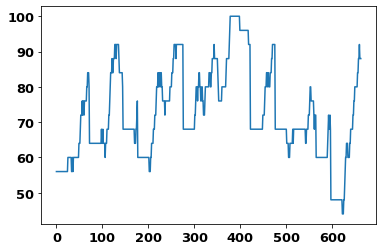

In [98]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

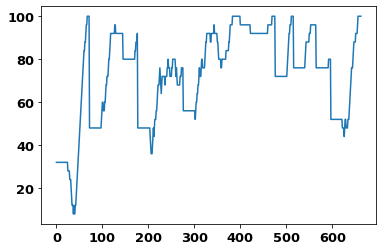

In [99]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

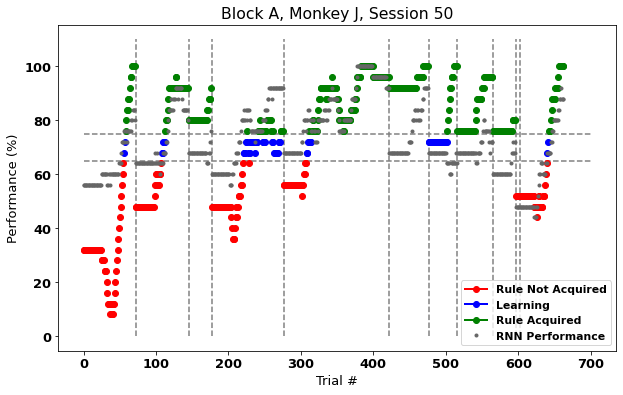

In [100]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block A, Monkey J, Session 50")
plt.savefig("monkey_model_performance_J50A2.svg")

Pearson Correlation Coefficient: 0.6865212310979596
Spearman Correlation Coefficient: 0.7221214952813582


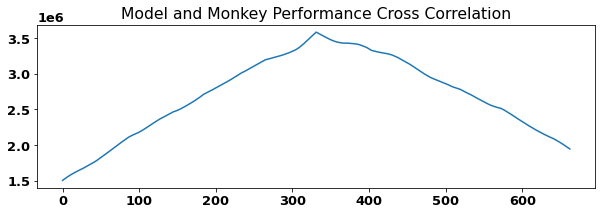

In [101]:
corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(corr)
plt.title("Model and Monkey Performance Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')
plt.savefig("monkey_model_cross_J50A2.svg")

### J37_A

In [104]:
test_sess_ix = 0
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_2_j_037_0003_segmented_new.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[396 397]
sra3_2_j_037_00+03
(666,)
(666, 2718, 12)
(666,) 3 7


In [105]:
border = np.array([396])

In [5]:
hist, acc, pred_y = kfold_pred(sess_id,X_conv,Y, verbose=1)

	Split 1 of 10
Epoch 1/150
18/18 [==============================] - ETA: 0s - loss: 2.3804 - accuracy: 0.1632
Epoch 00001: val_accuracy improved from -inf to 0.41176, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
18/18 [==============================] - 8s 421ms/step - loss: 2.3804 - accuracy: 0.1632 - val_loss: 2.0175 - val_accuracy: 0.4118
Epoch 2/150
18/18 [==============================] - ETA: 0s - loss: 1.8245 - accuracy: 0.4097
Epoch 00002: val_accuracy improved from 0.41176 to 0.55882, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
18/18 [==============================] - 6s 343ms/step - loss: 1.8245 - accuracy: 0.4097 - val_loss: 1.9281 - val_accuracy: 0.5588
Epoch 3/150
18/18 [==============================] - ETA: 0s - loss: 1.5663 - accuracy: 0.5694
Epoch 00003: val_accuracy improved from 0.55882 to 0.61765, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
18/18 [==============================] - 6s 345ms/step - loss: 1.5663 - accuracy: 0.5694 - val_l

18/18 [==============================] - ETA: 0s - loss: 1.1467 - accuracy: 0.7708
Epoch 00058: val_accuracy did not improve from 0.67647
18/18 [==============================] - 5s 302ms/step - loss: 1.1467 - accuracy: 0.7708 - val_loss: 1.7983 - val_accuracy: 0.5294
Epoch 59/150
18/18 [==============================] - ETA: 0s - loss: 1.1796 - accuracy: 0.7674
Epoch 00059: val_accuracy did not improve from 0.67647
18/18 [==============================] - 5s 304ms/step - loss: 1.1796 - accuracy: 0.7674 - val_loss: 1.8384 - val_accuracy: 0.5294
Epoch 60/150
18/18 [==============================] - ETA: 0s - loss: 1.1474 - accuracy: 0.7812
Epoch 00060: val_accuracy did not improve from 0.67647
18/18 [==============================] - 6s 313ms/step - loss: 1.1474 - accuracy: 0.7812 - val_loss: 1.8456 - val_accuracy: 0.5000
Epoch 61/150
18/18 [==============================] - ETA: 0s - loss: 1.1558 - accuracy: 0.7951
Epoch 00061: val_accuracy did not improve from 0.67647
18/18 [=========

18/18 [==============================] - ETA: 0s - loss: 1.0554 - accuracy: 0.8785
Epoch 00116: val_accuracy did not improve from 0.67647
18/18 [==============================] - 6s 320ms/step - loss: 1.0554 - accuracy: 0.8785 - val_loss: 1.7879 - val_accuracy: 0.6176
Epoch 117/150
18/18 [==============================] - ETA: 0s - loss: 1.0355 - accuracy: 0.8889
Epoch 00117: val_accuracy did not improve from 0.67647
18/18 [==============================] - 6s 328ms/step - loss: 1.0355 - accuracy: 0.8889 - val_loss: 1.8788 - val_accuracy: 0.5294
Epoch 118/150
18/18 [==============================] - ETA: 0s - loss: 1.0470 - accuracy: 0.8854
Epoch 00118: val_accuracy did not improve from 0.67647
18/18 [==============================] - 6s 342ms/step - loss: 1.0470 - accuracy: 0.8854 - val_loss: 1.9168 - val_accuracy: 0.5588
Epoch 119/150
18/18 [==============================] - ETA: 0s - loss: 1.0097 - accuracy: 0.9271
Epoch 00119: val_accuracy did not improve from 0.67647
18/18 [======

Epoch 145/150
18/18 [==============================] - ETA: 0s - loss: 0.9949 - accuracy: 0.9340
Epoch 00145: val_accuracy did not improve from 0.67647
18/18 [==============================] - 5s 294ms/step - loss: 0.9949 - accuracy: 0.9340 - val_loss: 2.2192 - val_accuracy: 0.5000
Epoch 146/150
18/18 [==============================] - ETA: 0s - loss: 0.9884 - accuracy: 0.9340
Epoch 00146: val_accuracy did not improve from 0.67647
18/18 [==============================] - 5s 295ms/step - loss: 0.9884 - accuracy: 0.9340 - val_loss: 2.1335 - val_accuracy: 0.5294
Epoch 147/150
18/18 [==============================] - ETA: 0s - loss: 0.9827 - accuracy: 0.9306
Epoch 00147: val_accuracy did not improve from 0.67647
18/18 [==============================] - 5s 284ms/step - loss: 0.9827 - accuracy: 0.9306 - val_loss: 2.2791 - val_accuracy: 0.5000
Epoch 148/150
18/18 [==============================] - ETA: 0s - loss: 0.9876 - accuracy: 0.9167
Epoch 00148: val_accuracy did not improve from 0.67647

18/18 [==============================] - 5s 287ms/step - loss: 1.2837 - accuracy: 0.6875 - val_loss: 1.3419 - val_accuracy: 0.6970
Epoch 24/150
18/18 [==============================] - ETA: 0s - loss: 1.2806 - accuracy: 0.7049
Epoch 00024: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 292ms/step - loss: 1.2806 - accuracy: 0.7049 - val_loss: 1.3382 - val_accuracy: 0.6970
Epoch 25/150
18/18 [==============================] - ETA: 0s - loss: 1.2609 - accuracy: 0.7326
Epoch 00025: val_accuracy did not improve from 0.69697
18/18 [==============================] - 6s 308ms/step - loss: 1.2609 - accuracy: 0.7326 - val_loss: 1.3225 - val_accuracy: 0.6667
Epoch 26/150
18/18 [==============================] - ETA: 0s - loss: 1.2846 - accuracy: 0.6944
Epoch 00026: val_accuracy did not improve from 0.69697
18/18 [==============================] - 6s 314ms/step - loss: 1.2846 - accuracy: 0.6944 - val_loss: 1.3292 - val_accuracy: 0.6667
Epoch 27/150
18/18 [===

Epoch 53/150
18/18 [==============================] - ETA: 0s - loss: 1.1961 - accuracy: 0.7535
Epoch 00053: val_accuracy did not improve from 0.72727
18/18 [==============================] - 5s 289ms/step - loss: 1.1961 - accuracy: 0.7535 - val_loss: 1.4615 - val_accuracy: 0.5758
Epoch 54/150
18/18 [==============================] - ETA: 0s - loss: 1.1939 - accuracy: 0.7500
Epoch 00054: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 318ms/step - loss: 1.1939 - accuracy: 0.7500 - val_loss: 1.4338 - val_accuracy: 0.5455
Epoch 55/150
18/18 [==============================] - ETA: 0s - loss: 1.1995 - accuracy: 0.7396
Epoch 00055: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 327ms/step - loss: 1.1995 - accuracy: 0.7396 - val_loss: 1.4255 - val_accuracy: 0.5758
Epoch 56/150
18/18 [==============================] - ETA: 0s - loss: 1.1864 - accuracy: 0.7882
Epoch 00056: val_accuracy did not improve from 0.72727
18/

18/18 [==============================] - ETA: 0s - loss: 1.0575 - accuracy: 0.8924
Epoch 00111: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 312ms/step - loss: 1.0575 - accuracy: 0.8924 - val_loss: 1.4999 - val_accuracy: 0.6061
Epoch 112/150
18/18 [==============================] - ETA: 0s - loss: 1.0584 - accuracy: 0.8958
Epoch 00112: val_accuracy did not improve from 0.72727
18/18 [==============================] - 5s 296ms/step - loss: 1.0584 - accuracy: 0.8958 - val_loss: 1.5253 - val_accuracy: 0.5152
Epoch 113/150
18/18 [==============================] - ETA: 0s - loss: 1.0495 - accuracy: 0.8819
Epoch 00113: val_accuracy did not improve from 0.72727
18/18 [==============================] - 5s 302ms/step - loss: 1.0495 - accuracy: 0.8819 - val_loss: 1.3647 - val_accuracy: 0.5758
Epoch 114/150
18/18 [==============================] - ETA: 0s - loss: 1.0662 - accuracy: 0.8611
Epoch 00114: val_accuracy did not improve from 0.72727
18/18 [======

Epoch 140/150
18/18 [==============================] - ETA: 0s - loss: 1.0080 - accuracy: 0.9132
Epoch 00140: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 318ms/step - loss: 1.0080 - accuracy: 0.9132 - val_loss: 1.5901 - val_accuracy: 0.6364
Epoch 141/150
18/18 [==============================] - ETA: 0s - loss: 1.0130 - accuracy: 0.9097
Epoch 00141: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 343ms/step - loss: 1.0130 - accuracy: 0.9097 - val_loss: 1.6466 - val_accuracy: 0.5758
Epoch 142/150
18/18 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.9132
Epoch 00142: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 314ms/step - loss: 1.0020 - accuracy: 0.9132 - val_loss: 1.6663 - val_accuracy: 0.4848
Epoch 143/150
18/18 [==============================] - ETA: 0s - loss: 1.0049 - accuracy: 0.9062
Epoch 00143: val_accuracy did not improve from 0.72727

Epoch 19/150
18/18 [==============================] - ETA: 0s - loss: 1.3270 - accuracy: 0.6771
Epoch 00019: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 348ms/step - loss: 1.3270 - accuracy: 0.6771 - val_loss: 1.3778 - val_accuracy: 0.6364
Epoch 20/150
18/18 [==============================] - ETA: 0s - loss: 1.3150 - accuracy: 0.6354
Epoch 00020: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 354ms/step - loss: 1.3150 - accuracy: 0.6354 - val_loss: 1.3795 - val_accuracy: 0.6364
Epoch 21/150
18/18 [==============================] - ETA: 0s - loss: 1.3110 - accuracy: 0.6840
Epoch 00021: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 352ms/step - loss: 1.3110 - accuracy: 0.6840 - val_loss: 1.3683 - val_accuracy: 0.6667
Epoch 22/150
18/18 [==============================] - ETA: 0s - loss: 1.3147 - accuracy: 0.6632
Epoch 00022: val_accuracy improved from 0.66667 to 0.69697

Epoch 48/150
18/18 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.7500
Epoch 00048: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 329ms/step - loss: 1.2140 - accuracy: 0.7500 - val_loss: 1.3684 - val_accuracy: 0.5455
Epoch 49/150
18/18 [==============================] - ETA: 0s - loss: 1.2224 - accuracy: 0.7361
Epoch 00049: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 317ms/step - loss: 1.2224 - accuracy: 0.7361 - val_loss: 1.3209 - val_accuracy: 0.6061
Epoch 50/150
18/18 [==============================] - ETA: 0s - loss: 1.2014 - accuracy: 0.7674
Epoch 00050: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 312ms/step - loss: 1.2014 - accuracy: 0.7674 - val_loss: 1.3379 - val_accuracy: 0.6364
Epoch 51/150
18/18 [==============================] - ETA: 0s - loss: 1.2038 - accuracy: 0.7188
Epoch 00051: val_accuracy did not improve from 0.72727
18/

18/18 [==============================] - ETA: 0s - loss: 1.0566 - accuracy: 0.8715
Epoch 00106: val_accuracy did not improve from 0.72727
18/18 [==============================] - 7s 366ms/step - loss: 1.0566 - accuracy: 0.8715 - val_loss: 1.5627 - val_accuracy: 0.6364
Epoch 107/150
18/18 [==============================] - ETA: 0s - loss: 1.0854 - accuracy: 0.8368
Epoch 00107: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 309ms/step - loss: 1.0854 - accuracy: 0.8368 - val_loss: 1.5903 - val_accuracy: 0.6061
Epoch 108/150
18/18 [==============================] - ETA: 0s - loss: 1.0830 - accuracy: 0.8472
Epoch 00108: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 306ms/step - loss: 1.0830 - accuracy: 0.8472 - val_loss: 1.5426 - val_accuracy: 0.6061
Epoch 109/150
18/18 [==============================] - ETA: 0s - loss: 1.1014 - accuracy: 0.8472
Epoch 00109: val_accuracy did not improve from 0.72727
18/18 [======

Epoch 135/150
18/18 [==============================] - ETA: 0s - loss: 1.0257 - accuracy: 0.8785
Epoch 00135: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 331ms/step - loss: 1.0257 - accuracy: 0.8785 - val_loss: 1.7430 - val_accuracy: 0.6061
Epoch 136/150
18/18 [==============================] - ETA: 0s - loss: 1.0295 - accuracy: 0.8958
Epoch 00136: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 309ms/step - loss: 1.0295 - accuracy: 0.8958 - val_loss: 1.8766 - val_accuracy: 0.4545
Epoch 137/150
18/18 [==============================] - ETA: 0s - loss: 1.0448 - accuracy: 0.8785
Epoch 00137: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 312ms/step - loss: 1.0448 - accuracy: 0.8785 - val_loss: 1.7043 - val_accuracy: 0.6061
Epoch 138/150
18/18 [==============================] - ETA: 0s - loss: 1.0345 - accuracy: 0.8993
Epoch 00138: val_accuracy did not improve from 0.72727

Epoch 14/150
18/18 [==============================] - ETA: 0s - loss: 1.3384 - accuracy: 0.6493
Epoch 00014: val_accuracy did not improve from 0.63636
18/18 [==============================] - 6s 319ms/step - loss: 1.3384 - accuracy: 0.6493 - val_loss: 1.5084 - val_accuracy: 0.6364
Epoch 15/150
18/18 [==============================] - ETA: 0s - loss: 1.3094 - accuracy: 0.6632
Epoch 00015: val_accuracy did not improve from 0.63636
18/18 [==============================] - 5s 299ms/step - loss: 1.3094 - accuracy: 0.6632 - val_loss: 1.4766 - val_accuracy: 0.6364
Epoch 16/150
18/18 [==============================] - ETA: 0s - loss: 1.3018 - accuracy: 0.6528
Epoch 00016: val_accuracy did not improve from 0.63636
18/18 [==============================] - 5s 291ms/step - loss: 1.3018 - accuracy: 0.6528 - val_loss: 1.4544 - val_accuracy: 0.6364
Epoch 17/150
18/18 [==============================] - ETA: 0s - loss: 1.3124 - accuracy: 0.6632
Epoch 00017: val_accuracy did not improve from 0.63636
18/

18/18 [==============================] - ETA: 0s - loss: 1.1563 - accuracy: 0.7917
Epoch 00072: val_accuracy did not improve from 0.63636
18/18 [==============================] - 5s 281ms/step - loss: 1.1563 - accuracy: 0.7917 - val_loss: 1.8111 - val_accuracy: 0.4242
Epoch 73/150
18/18 [==============================] - ETA: 0s - loss: 1.1274 - accuracy: 0.8229
Epoch 00073: val_accuracy did not improve from 0.63636
18/18 [==============================] - 5s 274ms/step - loss: 1.1274 - accuracy: 0.8229 - val_loss: 1.7575 - val_accuracy: 0.4848
Epoch 74/150
18/18 [==============================] - ETA: 0s - loss: 1.1321 - accuracy: 0.8090
Epoch 00074: val_accuracy did not improve from 0.63636
18/18 [==============================] - 5s 281ms/step - loss: 1.1321 - accuracy: 0.8090 - val_loss: 1.7106 - val_accuracy: 0.5152
Epoch 75/150
18/18 [==============================] - ETA: 0s - loss: 1.1577 - accuracy: 0.7639
Epoch 00075: val_accuracy did not improve from 0.63636
18/18 [=========

Epoch 101/150
18/18 [==============================] - ETA: 0s - loss: 1.0648 - accuracy: 0.8715
Epoch 00101: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 256ms/step - loss: 1.0648 - accuracy: 0.8715 - val_loss: 1.8360 - val_accuracy: 0.5455
Epoch 102/150
18/18 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.8715
Epoch 00102: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 263ms/step - loss: 1.0789 - accuracy: 0.8715 - val_loss: 1.7188 - val_accuracy: 0.5152
Epoch 103/150
18/18 [==============================] - ETA: 0s - loss: 1.0778 - accuracy: 0.8507
Epoch 00103: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 272ms/step - loss: 1.0778 - accuracy: 0.8507 - val_loss: 1.6866 - val_accuracy: 0.6061
Epoch 104/150
18/18 [==============================] - ETA: 0s - loss: 1.0654 - accuracy: 0.8646
Epoch 00104: val_accuracy did not improve from 0.66667

Epoch 130/150
18/18 [==============================] - ETA: 0s - loss: 1.0192 - accuracy: 0.9062
Epoch 00130: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 258ms/step - loss: 1.0192 - accuracy: 0.9062 - val_loss: 1.7923 - val_accuracy: 0.5152
Epoch 131/150
18/18 [==============================] - ETA: 0s - loss: 1.0201 - accuracy: 0.9097
Epoch 00131: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 271ms/step - loss: 1.0201 - accuracy: 0.9097 - val_loss: 2.0592 - val_accuracy: 0.3939
Epoch 132/150
18/18 [==============================] - ETA: 0s - loss: 0.9897 - accuracy: 0.9097
Epoch 00132: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 288ms/step - loss: 0.9897 - accuracy: 0.9097 - val_loss: 1.8776 - val_accuracy: 0.4848
Epoch 133/150
18/18 [==============================] - ETA: 0s - loss: 0.9922 - accuracy: 0.9410
Epoch 00133: val_accuracy did not improve from 0.66667

Epoch 9/150
18/18 [==============================] - ETA: 0s - loss: 1.3657 - accuracy: 0.6076
Epoch 00009: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 257ms/step - loss: 1.3657 - accuracy: 0.6076 - val_loss: 1.5997 - val_accuracy: 0.6364
Epoch 10/150
18/18 [==============================] - ETA: 0s - loss: 1.3725 - accuracy: 0.6285
Epoch 00010: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 257ms/step - loss: 1.3725 - accuracy: 0.6285 - val_loss: 1.5785 - val_accuracy: 0.6364
Epoch 11/150
18/18 [==============================] - ETA: 0s - loss: 1.3659 - accuracy: 0.6250
Epoch 00011: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 257ms/step - loss: 1.3659 - accuracy: 0.6250 - val_loss: 1.5506 - val_accuracy: 0.6364
Epoch 12/150
18/18 [==============================] - ETA: 0s - loss: 1.3472 - accuracy: 0.6319
Epoch 00012: val_accuracy did not improve from 0.69697
18/1

Epoch 38/150
18/18 [==============================] - ETA: 0s - loss: 1.2570 - accuracy: 0.6736
Epoch 00038: val_accuracy did not improve from 0.75758
18/18 [==============================] - 4s 247ms/step - loss: 1.2570 - accuracy: 0.6736 - val_loss: 1.3180 - val_accuracy: 0.6970
Epoch 39/150
18/18 [==============================] - ETA: 0s - loss: 1.2600 - accuracy: 0.6667
Epoch 00039: val_accuracy did not improve from 0.75758
18/18 [==============================] - 4s 247ms/step - loss: 1.2600 - accuracy: 0.6667 - val_loss: 1.3622 - val_accuracy: 0.5455
Epoch 40/150
18/18 [==============================] - ETA: 0s - loss: 1.2195 - accuracy: 0.7361
Epoch 00040: val_accuracy did not improve from 0.75758
18/18 [==============================] - 4s 244ms/step - loss: 1.2195 - accuracy: 0.7361 - val_loss: 1.3512 - val_accuracy: 0.5758
Epoch 41/150
18/18 [==============================] - ETA: 0s - loss: 1.2031 - accuracy: 0.7118
Epoch 00041: val_accuracy did not improve from 0.75758
18/

18/18 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.8056
Epoch 00096: val_accuracy did not improve from 0.75758
18/18 [==============================] - 5s 279ms/step - loss: 1.1023 - accuracy: 0.8056 - val_loss: 1.4749 - val_accuracy: 0.6364
Epoch 97/150
18/18 [==============================] - ETA: 0s - loss: 1.0874 - accuracy: 0.8368
Epoch 00097: val_accuracy did not improve from 0.75758
18/18 [==============================] - 5s 271ms/step - loss: 1.0874 - accuracy: 0.8368 - val_loss: 1.4492 - val_accuracy: 0.5455
Epoch 98/150
18/18 [==============================] - ETA: 0s - loss: 1.1283 - accuracy: 0.8194
Epoch 00098: val_accuracy did not improve from 0.75758
18/18 [==============================] - 5s 266ms/step - loss: 1.1283 - accuracy: 0.8194 - val_loss: 1.4078 - val_accuracy: 0.6061
Epoch 99/150
18/18 [==============================] - ETA: 0s - loss: 1.1097 - accuracy: 0.8299
Epoch 00099: val_accuracy did not improve from 0.75758
18/18 [=========

18/18 [==============================] - ETA: 0s - loss: 1.0509 - accuracy: 0.8646
Epoch 00125: val_accuracy did not improve from 0.75758
18/18 [==============================] - 5s 282ms/step - loss: 1.0509 - accuracy: 0.8646 - val_loss: 1.6546 - val_accuracy: 0.5455
Epoch 126/150
18/18 [==============================] - ETA: 0s - loss: 1.0250 - accuracy: 0.9097
Epoch 00126: val_accuracy did not improve from 0.75758
18/18 [==============================] - 5s 285ms/step - loss: 1.0250 - accuracy: 0.9097 - val_loss: 1.5961 - val_accuracy: 0.5758
Epoch 127/150
18/18 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.8646
Epoch 00127: val_accuracy did not improve from 0.75758
18/18 [==============================] - 5s 286ms/step - loss: 1.0623 - accuracy: 0.8646 - val_loss: 1.5057 - val_accuracy: 0.6061
Epoch 128/150
18/18 [==============================] - ETA: 0s - loss: 1.0486 - accuracy: 0.8750
Epoch 00128: val_accuracy did not improve from 0.75758
18/18 [======

Epoch 4/150
18/18 [==============================] - ETA: 0s - loss: 1.4815 - accuracy: 0.5868
Epoch 00004: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 256ms/step - loss: 1.4815 - accuracy: 0.5868 - val_loss: 1.7876 - val_accuracy: 0.6061
Epoch 5/150
18/18 [==============================] - ETA: 0s - loss: 1.4272 - accuracy: 0.6215
Epoch 00005: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 257ms/step - loss: 1.4272 - accuracy: 0.6215 - val_loss: 1.7478 - val_accuracy: 0.6061
Epoch 6/150
18/18 [==============================] - ETA: 0s - loss: 1.4177 - accuracy: 0.6111
Epoch 00006: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 251ms/step - loss: 1.4177 - accuracy: 0.6111 - val_loss: 1.6980 - val_accuracy: 0.6061
Epoch 7/150
18/18 [==============================] - ETA: 0s - loss: 1.4038 - accuracy: 0.5799
Epoch 00007: val_accuracy did not improve from 0.69697
18/18 [

18/18 [==============================] - ETA: 0s - loss: 1.1744 - accuracy: 0.7639
Epoch 00062: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 279ms/step - loss: 1.1744 - accuracy: 0.7639 - val_loss: 1.4747 - val_accuracy: 0.6061
Epoch 63/150
18/18 [==============================] - ETA: 0s - loss: 1.1704 - accuracy: 0.7604
Epoch 00063: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 283ms/step - loss: 1.1704 - accuracy: 0.7604 - val_loss: 1.3408 - val_accuracy: 0.6667
Epoch 64/150
18/18 [==============================] - ETA: 0s - loss: 1.1669 - accuracy: 0.7743
Epoch 00064: val_accuracy did not improve from 0.69697
18/18 [==============================] - 5s 281ms/step - loss: 1.1669 - accuracy: 0.7743 - val_loss: 1.4269 - val_accuracy: 0.6364
Epoch 65/150
18/18 [==============================] - ETA: 0s - loss: 1.1587 - accuracy: 0.7882
Epoch 00065: val_accuracy did not improve from 0.69697
18/18 [=========

Epoch 91/150
18/18 [==============================] - ETA: 0s - loss: 1.1117 - accuracy: 0.8299
Epoch 00091: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 313ms/step - loss: 1.1117 - accuracy: 0.8299 - val_loss: 1.4567 - val_accuracy: 0.6667
Epoch 92/150
18/18 [==============================] - ETA: 0s - loss: 1.0737 - accuracy: 0.8507
Epoch 00092: val_accuracy did not improve from 0.72727
18/18 [==============================] - 5s 296ms/step - loss: 1.0737 - accuracy: 0.8507 - val_loss: 1.4276 - val_accuracy: 0.7273
Epoch 93/150
18/18 [==============================] - ETA: 0s - loss: 1.1271 - accuracy: 0.7951
Epoch 00093: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 312ms/step - loss: 1.1271 - accuracy: 0.7951 - val_loss: 1.4518 - val_accuracy: 0.6970
Epoch 94/150
18/18 [==============================] - ETA: 0s - loss: 1.0845 - accuracy: 0.8368
Epoch 00094: val_accuracy did not improve from 0.72727
18/

Epoch 120/150
18/18 [==============================] - ETA: 0s - loss: 1.0425 - accuracy: 0.8715
Epoch 00120: val_accuracy did not improve from 0.72727
18/18 [==============================] - 5s 300ms/step - loss: 1.0425 - accuracy: 0.8715 - val_loss: 1.6201 - val_accuracy: 0.6667
Epoch 121/150
18/18 [==============================] - ETA: 0s - loss: 1.0277 - accuracy: 0.8819
Epoch 00121: val_accuracy did not improve from 0.72727
18/18 [==============================] - 5s 284ms/step - loss: 1.0277 - accuracy: 0.8819 - val_loss: 1.6174 - val_accuracy: 0.6667
Epoch 122/150
18/18 [==============================] - ETA: 0s - loss: 1.0545 - accuracy: 0.8715
Epoch 00122: val_accuracy did not improve from 0.72727
18/18 [==============================] - 5s 292ms/step - loss: 1.0545 - accuracy: 0.8715 - val_loss: 1.5476 - val_accuracy: 0.6970
Epoch 123/150
18/18 [==============================] - ETA: 0s - loss: 1.0654 - accuracy: 0.8611
Epoch 00123: val_accuracy did not improve from 0.72727

Epoch 149/150
18/18 [==============================] - ETA: 0s - loss: 1.0066 - accuracy: 0.9201
Epoch 00149: val_accuracy did not improve from 0.75758
18/18 [==============================] - 5s 293ms/step - loss: 1.0066 - accuracy: 0.9201 - val_loss: 1.5830 - val_accuracy: 0.6364
Epoch 150/150
18/18 [==============================] - ETA: 0s - loss: 1.0104 - accuracy: 0.9062
Epoch 00150: val_accuracy did not improve from 0.75758
18/18 [==============================] - 5s 274ms/step - loss: 1.0104 - accuracy: 0.9062 - val_loss: 1.6306 - val_accuracy: 0.6364
	Split 7 of 10
Epoch 1/150
18/18 [==============================] - ETA: 0s - loss: 2.3964 - accuracy: 0.1354
Epoch 00001: val_accuracy improved from -inf to 0.60606, saving model to mon_v_mod_sra3_2_j_037_00+03_split6.h5
18/18 [==============================] - 6s 307ms/step - loss: 2.3964 - accuracy: 0.1354 - val_loss: 2.0036 - val_accuracy: 0.6061
Epoch 2/150
18/18 [==============================] - ETA: 0s - loss: 1.8665 - acc

Epoch 28/150
18/18 [==============================] - ETA: 0s - loss: 1.2678 - accuracy: 0.7014
Epoch 00028: val_accuracy did not improve from 0.63636
18/18 [==============================] - 5s 298ms/step - loss: 1.2678 - accuracy: 0.7014 - val_loss: 1.3850 - val_accuracy: 0.5758
Epoch 29/150
18/18 [==============================] - ETA: 0s - loss: 1.2459 - accuracy: 0.7326
Epoch 00029: val_accuracy did not improve from 0.63636
18/18 [==============================] - 6s 306ms/step - loss: 1.2459 - accuracy: 0.7326 - val_loss: 1.3560 - val_accuracy: 0.5758
Epoch 30/150
18/18 [==============================] - ETA: 0s - loss: 1.2676 - accuracy: 0.6944
Epoch 00030: val_accuracy did not improve from 0.63636
18/18 [==============================] - 6s 312ms/step - loss: 1.2676 - accuracy: 0.6944 - val_loss: 1.3837 - val_accuracy: 0.6061
Epoch 31/150
18/18 [==============================] - ETA: 0s - loss: 1.2489 - accuracy: 0.7049
Epoch 00031: val_accuracy did not improve from 0.63636
18/

Epoch 86/150
18/18 [==============================] - ETA: 0s - loss: 1.1464 - accuracy: 0.8229
Epoch 00086: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 355ms/step - loss: 1.1464 - accuracy: 0.8229 - val_loss: 1.6436 - val_accuracy: 0.4848
Epoch 87/150
18/18 [==============================] - ETA: 0s - loss: 1.1062 - accuracy: 0.8229
Epoch 00087: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 357ms/step - loss: 1.1062 - accuracy: 0.8229 - val_loss: 1.6701 - val_accuracy: 0.5758
Epoch 88/150
18/18 [==============================] - ETA: 0s - loss: 1.0921 - accuracy: 0.8472
Epoch 00088: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 350ms/step - loss: 1.0921 - accuracy: 0.8472 - val_loss: 1.6866 - val_accuracy: 0.6061
Epoch 89/150
18/18 [==============================] - ETA: 0s - loss: 1.1088 - accuracy: 0.8403
Epoch 00089: val_accuracy did not improve from 0.66667
18/

Epoch 115/150
18/18 [==============================] - ETA: 0s - loss: 1.0752 - accuracy: 0.8715
Epoch 00115: val_accuracy did not improve from 0.66667
18/18 [==============================] - 7s 370ms/step - loss: 1.0752 - accuracy: 0.8715 - val_loss: 1.8017 - val_accuracy: 0.4848
Epoch 116/150
18/18 [==============================] - ETA: 0s - loss: 1.0485 - accuracy: 0.8819
Epoch 00116: val_accuracy did not improve from 0.66667
18/18 [==============================] - 7s 364ms/step - loss: 1.0485 - accuracy: 0.8819 - val_loss: 1.7364 - val_accuracy: 0.6364
Epoch 117/150
18/18 [==============================] - ETA: 0s - loss: 1.0719 - accuracy: 0.8681
Epoch 00117: val_accuracy did not improve from 0.66667
18/18 [==============================] - 7s 372ms/step - loss: 1.0719 - accuracy: 0.8681 - val_loss: 1.7939 - val_accuracy: 0.5758
Epoch 118/150
18/18 [==============================] - ETA: 0s - loss: 1.0658 - accuracy: 0.8785
Epoch 00118: val_accuracy did not improve from 0.66667

Epoch 144/150
18/18 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.8958
Epoch 00144: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 351ms/step - loss: 1.0296 - accuracy: 0.8958 - val_loss: 1.8363 - val_accuracy: 0.4848
Epoch 145/150
18/18 [==============================] - ETA: 0s - loss: 1.0364 - accuracy: 0.8958
Epoch 00145: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 353ms/step - loss: 1.0364 - accuracy: 0.8958 - val_loss: 1.7841 - val_accuracy: 0.6061
Epoch 146/150
18/18 [==============================] - ETA: 0s - loss: 1.0168 - accuracy: 0.9132
Epoch 00146: val_accuracy did not improve from 0.66667
18/18 [==============================] - 6s 351ms/step - loss: 1.0168 - accuracy: 0.9132 - val_loss: 1.8496 - val_accuracy: 0.5758
Epoch 147/150
18/18 [==============================] - ETA: 0s - loss: 1.0139 - accuracy: 0.9132
Epoch 00147: val_accuracy did not improve from 0.66667

Epoch 23/150
18/18 [==============================] - ETA: 0s - loss: 1.2886 - accuracy: 0.6806
Epoch 00023: val_accuracy did not improve from 0.63636
18/18 [==============================] - 6s 329ms/step - loss: 1.2886 - accuracy: 0.6806 - val_loss: 1.4181 - val_accuracy: 0.6364
Epoch 24/150
18/18 [==============================] - ETA: 0s - loss: 1.2826 - accuracy: 0.6944
Epoch 00024: val_accuracy did not improve from 0.63636
18/18 [==============================] - 6s 324ms/step - loss: 1.2826 - accuracy: 0.6944 - val_loss: 1.4156 - val_accuracy: 0.5758
Epoch 25/150
18/18 [==============================] - ETA: 0s - loss: 1.2635 - accuracy: 0.7118
Epoch 00025: val_accuracy did not improve from 0.63636
18/18 [==============================] - 6s 325ms/step - loss: 1.2635 - accuracy: 0.7118 - val_loss: 1.4067 - val_accuracy: 0.6364
Epoch 26/150
18/18 [==============================] - ETA: 0s - loss: 1.2752 - accuracy: 0.7014
Epoch 00026: val_accuracy did not improve from 0.63636
18/

Epoch 81/150
18/18 [==============================] - ETA: 0s - loss: 1.1440 - accuracy: 0.8056
Epoch 00081: val_accuracy did not improve from 0.69697
18/18 [==============================] - 6s 358ms/step - loss: 1.1440 - accuracy: 0.8056 - val_loss: 1.5023 - val_accuracy: 0.6667
Epoch 82/150
18/18 [==============================] - ETA: 0s - loss: 1.1458 - accuracy: 0.8090
Epoch 00082: val_accuracy did not improve from 0.69697
18/18 [==============================] - 6s 357ms/step - loss: 1.1458 - accuracy: 0.8090 - val_loss: 1.6234 - val_accuracy: 0.5455
Epoch 83/150
18/18 [==============================] - ETA: 0s - loss: 1.1158 - accuracy: 0.8160
Epoch 00083: val_accuracy did not improve from 0.69697
18/18 [==============================] - 6s 359ms/step - loss: 1.1158 - accuracy: 0.8160 - val_loss: 1.5579 - val_accuracy: 0.6061
Epoch 84/150
18/18 [==============================] - ETA: 0s - loss: 1.1285 - accuracy: 0.8125
Epoch 00084: val_accuracy did not improve from 0.69697
18/

18/18 [==============================] - ETA: 0s - loss: 1.0760 - accuracy: 0.8542
Epoch 00110: val_accuracy did not improve from 0.69697
18/18 [==============================] - 7s 366ms/step - loss: 1.0760 - accuracy: 0.8542 - val_loss: 1.6071 - val_accuracy: 0.6364
Epoch 111/150
18/18 [==============================] - ETA: 0s - loss: 1.0384 - accuracy: 0.8924
Epoch 00111: val_accuracy did not improve from 0.69697
18/18 [==============================] - 7s 368ms/step - loss: 1.0384 - accuracy: 0.8924 - val_loss: 1.6140 - val_accuracy: 0.6061
Epoch 112/150
18/18 [==============================] - ETA: 0s - loss: 1.0422 - accuracy: 0.8993
Epoch 00112: val_accuracy did not improve from 0.69697
18/18 [==============================] - 7s 367ms/step - loss: 1.0422 - accuracy: 0.8993 - val_loss: 1.6258 - val_accuracy: 0.6364
Epoch 113/150
18/18 [==============================] - ETA: 0s - loss: 1.0314 - accuracy: 0.8854
Epoch 00113: val_accuracy did not improve from 0.69697
18/18 [======

Epoch 139/150
18/18 [==============================] - ETA: 0s - loss: 1.0471 - accuracy: 0.8889
Epoch 00139: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 361ms/step - loss: 1.0471 - accuracy: 0.8889 - val_loss: 1.6346 - val_accuracy: 0.6667
Epoch 140/150
18/18 [==============================] - ETA: 0s - loss: 1.0410 - accuracy: 0.8854
Epoch 00140: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 355ms/step - loss: 1.0410 - accuracy: 0.8854 - val_loss: 1.7648 - val_accuracy: 0.6061
Epoch 141/150
18/18 [==============================] - ETA: 0s - loss: 0.9920 - accuracy: 0.9167
Epoch 00141: val_accuracy did not improve from 0.72727
18/18 [==============================] - 6s 358ms/step - loss: 0.9920 - accuracy: 0.9167 - val_loss: 1.8030 - val_accuracy: 0.6364
Epoch 142/150
18/18 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.9097
Epoch 00142: val_accuracy did not improve from 0.72727

Epoch 18/150
18/18 [==============================] - ETA: 0s - loss: 1.2954 - accuracy: 0.6806
Epoch 00018: val_accuracy did not improve from 0.60606
18/18 [==============================] - 6s 345ms/step - loss: 1.2954 - accuracy: 0.6806 - val_loss: 1.4977 - val_accuracy: 0.5152
Epoch 19/150
18/18 [==============================] - ETA: 0s - loss: 1.2768 - accuracy: 0.6979
Epoch 00019: val_accuracy did not improve from 0.60606
18/18 [==============================] - 6s 322ms/step - loss: 1.2768 - accuracy: 0.6979 - val_loss: 1.4639 - val_accuracy: 0.5758
Epoch 20/150
18/18 [==============================] - ETA: 0s - loss: 1.3039 - accuracy: 0.6840
Epoch 00020: val_accuracy improved from 0.60606 to 0.66667, saving model to mon_v_mod_sra3_2_j_037_00+03_split8.h5
18/18 [==============================] - 5s 305ms/step - loss: 1.3039 - accuracy: 0.6840 - val_loss: 1.4496 - val_accuracy: 0.6667
Epoch 21/150
18/18 [==============================] - ETA: 0s - loss: 1.2993 - accuracy: 0.673

Epoch 47/150
18/18 [==============================] - ETA: 0s - loss: 1.2215 - accuracy: 0.7361
Epoch 00047: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 294ms/step - loss: 1.2215 - accuracy: 0.7361 - val_loss: 1.5524 - val_accuracy: 0.5455
Epoch 48/150
18/18 [==============================] - ETA: 0s - loss: 1.1859 - accuracy: 0.7708
Epoch 00048: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 300ms/step - loss: 1.1859 - accuracy: 0.7708 - val_loss: 1.5995 - val_accuracy: 0.6061
Epoch 49/150
18/18 [==============================] - ETA: 0s - loss: 1.1947 - accuracy: 0.7604
Epoch 00049: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 297ms/step - loss: 1.1947 - accuracy: 0.7604 - val_loss: 1.5723 - val_accuracy: 0.5758
Epoch 50/150
18/18 [==============================] - ETA: 0s - loss: 1.1759 - accuracy: 0.7708
Epoch 00050: val_accuracy did not improve from 0.66667
18/

18/18 [==============================] - ETA: 0s - loss: 1.0741 - accuracy: 0.8507
Epoch 00105: val_accuracy did not improve from 0.66667
18/18 [==============================] - 5s 267ms/step - loss: 1.0741 - accuracy: 0.8507 - val_loss: 1.6652 - val_accuracy: 0.5758
Epoch 106/150
18/18 [==============================] - ETA: 0s - loss: 1.0408 - accuracy: 0.8785
Epoch 00106: val_accuracy did not improve from 0.66667
18/18 [==============================] - 4s 203ms/step - loss: 1.0408 - accuracy: 0.8785 - val_loss: 1.7281 - val_accuracy: 0.6061
Epoch 107/150
18/18 [==============================] - ETA: 0s - loss: 1.0646 - accuracy: 0.8472
Epoch 00107: val_accuracy did not improve from 0.66667
18/18 [==============================] - 4s 203ms/step - loss: 1.0646 - accuracy: 0.8472 - val_loss: 1.8127 - val_accuracy: 0.6061
Epoch 108/150
18/18 [==============================] - ETA: 0s - loss: 1.0575 - accuracy: 0.8924
Epoch 00108: val_accuracy did not improve from 0.66667
18/18 [======

Epoch 134/150
18/18 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.8993
Epoch 00134: val_accuracy did not improve from 0.66667
18/18 [==============================] - 4s 201ms/step - loss: 1.0478 - accuracy: 0.8993 - val_loss: 1.6591 - val_accuracy: 0.6061
Epoch 135/150
18/18 [==============================] - ETA: 0s - loss: 1.0234 - accuracy: 0.8924
Epoch 00135: val_accuracy did not improve from 0.66667
18/18 [==============================] - 4s 201ms/step - loss: 1.0234 - accuracy: 0.8924 - val_loss: 1.8610 - val_accuracy: 0.6061
Epoch 136/150
18/18 [==============================] - ETA: 0s - loss: 1.0080 - accuracy: 0.9167
Epoch 00136: val_accuracy did not improve from 0.66667
18/18 [==============================] - 4s 201ms/step - loss: 1.0080 - accuracy: 0.9167 - val_loss: 1.6534 - val_accuracy: 0.6364
Epoch 137/150
18/18 [==============================] - ETA: 0s - loss: 1.0403 - accuracy: 0.8681
Epoch 00137: val_accuracy did not improve from 0.66667

Epoch 13/150
18/18 [==============================] - ETA: 0s - loss: 1.3431 - accuracy: 0.6562
Epoch 00013: val_accuracy improved from 0.60606 to 0.63636, saving model to mon_v_mod_sra3_2_j_037_00+03_split9.h5
18/18 [==============================] - 4s 200ms/step - loss: 1.3431 - accuracy: 0.6562 - val_loss: 1.5409 - val_accuracy: 0.6364
Epoch 14/150
18/18 [==============================] - ETA: 0s - loss: 1.3502 - accuracy: 0.5764
Epoch 00014: val_accuracy did not improve from 0.63636
18/18 [==============================] - 4s 200ms/step - loss: 1.3502 - accuracy: 0.5764 - val_loss: 1.5233 - val_accuracy: 0.6061
Epoch 15/150
18/18 [==============================] - ETA: 0s - loss: 1.3172 - accuracy: 0.6632
Epoch 00015: val_accuracy did not improve from 0.63636
18/18 [==============================] - 4s 198ms/step - loss: 1.3172 - accuracy: 0.6632 - val_loss: 1.5077 - val_accuracy: 0.6061
Epoch 16/150
18/18 [==============================] - ETA: 0s - loss: 1.3010 - accuracy: 0.673

18/18 [==============================] - ETA: 0s - loss: 1.1451 - accuracy: 0.8056
Epoch 00070: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 197ms/step - loss: 1.1451 - accuracy: 0.8056 - val_loss: 1.3928 - val_accuracy: 0.5758
Epoch 71/150
18/18 [==============================] - ETA: 0s - loss: 1.1513 - accuracy: 0.7778
Epoch 00071: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 197ms/step - loss: 1.1513 - accuracy: 0.7778 - val_loss: 1.3194 - val_accuracy: 0.6667
Epoch 72/150
18/18 [==============================] - ETA: 0s - loss: 1.1733 - accuracy: 0.7639
Epoch 00072: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 196ms/step - loss: 1.1733 - accuracy: 0.7639 - val_loss: 1.3826 - val_accuracy: 0.5455
Epoch 73/150
18/18 [==============================] - ETA: 0s - loss: 1.1593 - accuracy: 0.7917
Epoch 00073: val_accuracy did not improve from 0.72727
18/18 [=========

Epoch 99/150
18/18 [==============================] - ETA: 0s - loss: 1.0875 - accuracy: 0.8576
Epoch 00099: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 196ms/step - loss: 1.0875 - accuracy: 0.8576 - val_loss: 1.5385 - val_accuracy: 0.5758
Epoch 100/150
18/18 [==============================] - ETA: 0s - loss: 1.1097 - accuracy: 0.8229
Epoch 00100: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 197ms/step - loss: 1.1097 - accuracy: 0.8229 - val_loss: 1.5032 - val_accuracy: 0.5758
Epoch 101/150
18/18 [==============================] - ETA: 0s - loss: 1.1030 - accuracy: 0.8090
Epoch 00101: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 201ms/step - loss: 1.1030 - accuracy: 0.8090 - val_loss: 1.6059 - val_accuracy: 0.4848
Epoch 102/150
18/18 [==============================] - ETA: 0s - loss: 1.0604 - accuracy: 0.8854
Epoch 00102: val_accuracy did not improve from 0.72727


Epoch 128/150
18/18 [==============================] - ETA: 0s - loss: 1.0513 - accuracy: 0.8715
Epoch 00128: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 196ms/step - loss: 1.0513 - accuracy: 0.8715 - val_loss: 1.7332 - val_accuracy: 0.5455
Epoch 129/150
18/18 [==============================] - ETA: 0s - loss: 1.0777 - accuracy: 0.8333
Epoch 00129: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 197ms/step - loss: 1.0777 - accuracy: 0.8333 - val_loss: 1.5201 - val_accuracy: 0.6667
Epoch 130/150
18/18 [==============================] - ETA: 0s - loss: 1.0303 - accuracy: 0.8785
Epoch 00130: val_accuracy did not improve from 0.72727
18/18 [==============================] - 4s 196ms/step - loss: 1.0303 - accuracy: 0.8785 - val_loss: 1.6572 - val_accuracy: 0.6061
Epoch 131/150
18/18 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.8576
Epoch 00131: val_accuracy did not improve from 0.72727

In [6]:
pred_y

array([3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 7, 3, 3, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       7, 3, 7, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 7,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3,
       3, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 7, 3, 7, 7, 3, 7, 3, 7, 3, 7, 3, 3, 3, 7, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 3, 3, 7, 7, 7, 3, 3, 3, 3, 3,
       7, 7, 7, 3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 7, 3, 3, 3, 7, 7, 7, 7, 7, 3, 7, 3, 3, 7, 7, 3, 3, 3,
       7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3,
       3, 3, 7, 7, 3, 7, 3, 3, 7, 3, 7, 7, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 7, 3, 7, 3, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3,
       7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 3,

In [106]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [107]:
print(np.unique(_y[:333], return_counts=True))
print(np.unique(_y[333:], return_counts=True))

(array([3, 7], dtype=int64), array([165, 168], dtype=int64))
(array([3, 7], dtype=int64), array([186, 147], dtype=int64))


In [108]:
x_tr = _x[:333]
tmp = _y[:333]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[333:]
tmp = _y[333:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/150
20/20 [==============================] - 11s 572ms/step - loss: 2.2520 - accuracy: 0.2875 - val_loss: 2.2652 - val_accuracy: 0.4925
Epoch 2/150
20/20 [==============================] - 11s 541ms/step - loss: 1.8295 - accuracy: 0.4906 - val_loss: 2.1947 - val_accuracy: 0.4715
Epoch 3/150
20/20 [==============================] - 11s 536ms/step - loss: 1.6905 - accuracy: 0.5656 - val_loss: 2.1437 - val_accuracy: 0.4414
Epoch 4/150
20/20 [==============================] - 11s 551ms/step - loss: 1.6082 - accuracy: 0.6156 - val_loss: 2.1008 - val_accuracy: 0.4414
Epoch 5/150
20/20 [==============================] - 11s 554ms/step - loss: 1.5645 - accuracy: 0.6500 - val_loss: 2.0665 - val_accuracy: 0.4444
Epoch 6/150
20/20 [==============================] - 11s 550ms/step - loss: 1.5371 - accuracy: 0.6750 - val_loss: 2.0258 - val_accuracy: 0.4535
Epoch 7/150
20/20 [==============================] - 11s 548ms/step - loss: 1.5088 - accuracy: 0.6938 - val_loss: 1.9838 - val_accuracy:

20/20 [==============================] - 11s 549ms/step - loss: 0.9470 - accuracy: 0.9875 - val_loss: 2.0098 - val_accuracy: 0.4955
Epoch 114/150
20/20 [==============================] - 11s 554ms/step - loss: 0.9481 - accuracy: 0.9875 - val_loss: 2.0010 - val_accuracy: 0.5075
Epoch 115/150
20/20 [==============================] - 11s 552ms/step - loss: 0.9602 - accuracy: 0.9750 - val_loss: 2.0186 - val_accuracy: 0.5075
Epoch 116/150
20/20 [==============================] - 11s 550ms/step - loss: 0.9418 - accuracy: 0.9875 - val_loss: 2.0409 - val_accuracy: 0.5045
Epoch 117/150
20/20 [==============================] - 11s 549ms/step - loss: 0.9564 - accuracy: 0.9781 - val_loss: 1.9952 - val_accuracy: 0.5105
Epoch 118/150
20/20 [==============================] - 11s 558ms/step - loss: 0.9356 - accuracy: 0.9969 - val_loss: 2.0480 - val_accuracy: 0.5195
Epoch 119/150
20/20 [==============================] - 11s 550ms/step - loss: 0.9469 - accuracy: 0.9875 - val_loss: 2.0255 - val_accuracy:

In [109]:
# Second half predicted
# pred_y1 = np.
pred_y1

array([7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 7, 7, 3, 7, 7, 7,
       7, 7, 3, 3, 3, 7, 7, 3, 7, 7, 3, 7, 7, 3, 7, 7, 7, 7, 7, 7, 7, 7,
       3, 7, 7, 7, 3, 7, 3, 7, 3, 7, 7, 7, 3, 3, 7, 7, 3, 7, 3, 3, 3, 7,
       3, 3, 3, 3, 7, 3, 7, 3, 7, 7, 7, 3, 3, 7, 7, 3, 7, 3, 3, 3, 3, 7,
       3, 7, 7, 3, 7, 7, 3, 3, 7, 3, 3, 7, 7, 7, 3, 7, 3, 7, 3, 3, 7, 3,
       3, 3, 3, 7, 7, 7, 3, 3, 7, 3, 7, 7, 7, 7, 3, 7, 3, 7, 3, 7, 7, 3,
       7, 3, 7, 3, 7, 3, 3, 7, 3, 7, 3, 3, 3, 3, 3, 7, 3, 7, 7, 7, 3, 7,
       3, 7, 3, 3, 7, 7, 7, 7, 3, 7, 3, 7, 3, 7, 3, 3, 3, 3, 7, 3, 3, 7,
       3, 3, 3, 3, 7, 3, 7, 3, 3, 3, 7, 7, 3, 3, 7, 3, 7, 7, 7, 7, 3, 7,
       3, 7, 7, 3, 3, 3, 7, 7, 3, 3, 3, 7, 7, 7, 3, 7, 7, 7, 7, 3, 3, 7,
       7, 7, 7, 3, 7, 7, 7, 7, 3, 3, 7, 3, 7, 3, 3, 3, 3, 7, 3, 7, 3, 7,
       7, 3, 3, 3, 7, 7, 7, 7, 7, 7, 3, 3, 7, 3, 7, 7, 3, 3, 7, 3, 3, 3,
       3, 7, 7, 7, 3, 7, 7, 7, 3, 7, 3, 7, 3, 7, 7, 7, 3, 7, 7, 3, 7, 3,
       3, 7, 7, 3, 3, 7, 3, 3, 3, 7, 7, 3, 7, 3, 7,

In [110]:
x_tr = _x[333:]
tmp = _y[333:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:333]
tmp = _y[:333]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/150
20/20 [==============================] - 12s 578ms/step - loss: 2.2045 - accuracy: 0.3406 - val_loss: 2.2592 - val_accuracy: 0.5285
Epoch 2/150
20/20 [==============================] - 11s 572ms/step - loss: 1.8219 - accuracy: 0.5250 - val_loss: 2.1885 - val_accuracy: 0.4985
Epoch 3/150
20/20 [==============================] - 11s 553ms/step - loss: 1.6974 - accuracy: 0.5562 - val_loss: 2.1300 - val_accuracy: 0.4805
Epoch 4/150
20/20 [==============================] - 11s 554ms/step - loss: 1.5979 - accuracy: 0.6313 - val_loss: 2.0853 - val_accuracy: 0.5225
Epoch 5/150
20/20 [==============================] - 11s 561ms/step - loss: 1.5738 - accuracy: 0.6125 - val_loss: 2.0411 - val_accuracy: 0.5165
Epoch 6/150
20/20 [==============================] - 11s 556ms/step - loss: 1.5563 - accuracy: 0.6375 - val_loss: 2.0099 - val_accuracy: 0.5495
Epoch 7/150
20/20 [==============================] - 11s 554ms/step - loss: 1.5635 - accuracy: 0.6313 - val_loss: 1.9768 - val_accuracy:

20/20 [==============================] - 11s 553ms/step - loss: 0.9639 - accuracy: 0.9844 - val_loss: 2.0778 - val_accuracy: 0.5195
Epoch 114/150
20/20 [==============================] - 11s 554ms/step - loss: 0.9775 - accuracy: 0.9625 - val_loss: 2.1115 - val_accuracy: 0.5075
Epoch 115/150
20/20 [==============================] - 11s 556ms/step - loss: 0.9604 - accuracy: 0.9812 - val_loss: 2.1234 - val_accuracy: 0.5195
Epoch 116/150
20/20 [==============================] - 11s 551ms/step - loss: 0.9632 - accuracy: 0.9844 - val_loss: 2.1260 - val_accuracy: 0.4985
Epoch 117/150
20/20 [==============================] - 11s 552ms/step - loss: 0.9676 - accuracy: 0.9812 - val_loss: 2.0789 - val_accuracy: 0.4985
Epoch 118/150
20/20 [==============================] - 11s 552ms/step - loss: 0.9556 - accuracy: 0.9844 - val_loss: 2.0970 - val_accuracy: 0.4895
Epoch 119/150
20/20 [==============================] - 11s 556ms/step - loss: 0.9515 - accuracy: 0.9906 - val_loss: 2.1079 - val_accuracy:

In [111]:
# First half predicted
# pred_y2 = np.
pred_y2

array([7, 7, 7, 7, 7, 3, 3, 7, 7, 3, 7, 7, 3, 3, 3, 7, 3, 7, 3, 3, 3, 7,
       7, 7, 3, 7, 3, 3, 7, 7, 3, 3, 7, 3, 3, 7, 7, 7, 7, 3, 3, 3, 7, 3,
       3, 7, 3, 7, 3, 7, 3, 3, 7, 7, 3, 7, 7, 3, 3, 3, 3, 7, 3, 3, 7, 3,
       3, 7, 3, 7, 3, 3, 7, 3, 3, 7, 3, 3, 7, 3, 3, 7, 3, 3, 3, 7, 7, 3,
       7, 7, 7, 3, 7, 3, 7, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 7, 7, 3, 7, 3, 3, 3, 7, 3, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 7, 7, 3, 3, 3, 7, 7, 3, 3, 3, 3, 7, 7, 7, 3, 3, 3, 3, 7, 7,
       7, 3, 7, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 3, 7, 7, 3, 3,
       3, 3, 7, 3, 3, 3, 3, 7, 7, 7, 3, 3, 3, 3, 3, 3, 7, 3, 7, 7, 7, 3,
       7, 3, 3, 3, 3, 7, 3, 7, 7, 3, 7, 7, 3, 3, 7, 3, 7, 7, 3, 7, 7, 3,
       3, 3, 7, 3, 7, 3, 7, 3, 7, 7, 3, 3, 3, 7, 3, 3, 7, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 7, 3, 3, 3, 7, 3, 7, 7, 3, 3, 3, 7, 3, 3, 7, 3, 7, 7,
       3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 7, 3, 3, 3, 7, 3, 3, 7, 7, 7,
       7, 3, 7, 7, 3, 7, 3, 3, 3, 3, 3, 3, 3, 7, 7,

In [112]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

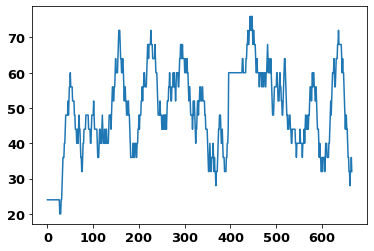

In [113]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

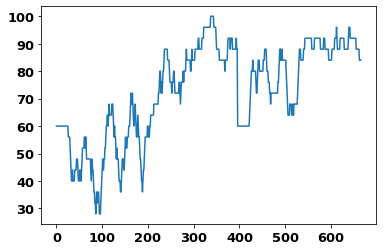

In [114]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

Text(0.5, 1.0, 'Block A, Monkey J, Session 37')

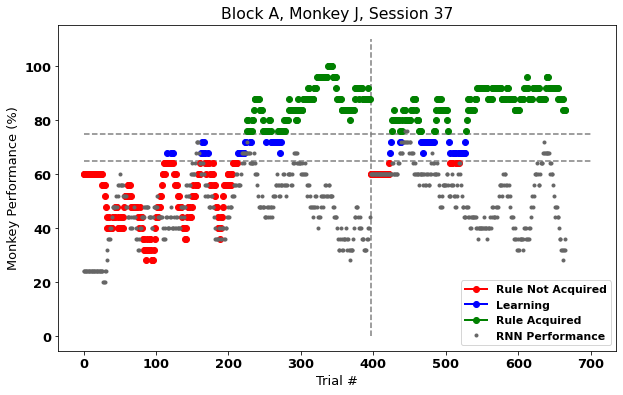

In [115]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block A, Monkey J, Session 37")
# plt.savefig("monkey_model_performance_J52C.svg")

Pearson Correlation Coefficient: 0.1457012927541804
Spearman Correlation Coefficient: 0.08133649955965236


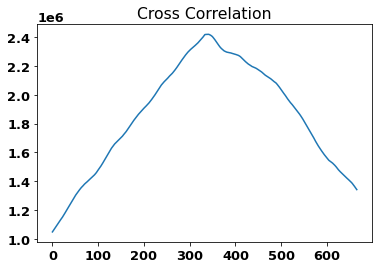

In [116]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### M82_A

In [3]:
test_sess_ix = 6
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_082_0001_segmented_new.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 161  162  431  432 1462 1472]
sra3_1_m_082_00+01
(1489,)
(1489, 2478, 27)
(1489,) 1 7


In [4]:
border = np.array([161, 431, 1462])

In [5]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [6]:
print(np.unique(_y[740:], return_counts=True))
print(np.unique(_y[:740], return_counts=True))

(array([1, 2, 3, 5, 6, 7], dtype=int64), array([ 44,  69, 260,  49,  72, 255], dtype=int64))
(array([1, 2, 3, 5, 6, 7], dtype=int64), array([ 44,  67, 270,  41,  62, 256], dtype=int64))


In [7]:
x_tr = _x[:740]
tmp = _y[:740]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[740:]
tmp = _y[740:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/150
46/46 [==============================] - 30s 656ms/step - loss: 2.3121 - accuracy: 0.2799 - val_loss: 2.2831 - val_accuracy: 0.3405
Epoch 2/150
46/46 [==============================] - 29s 637ms/step - loss: 2.1009 - accuracy: 0.3723 - val_loss: 2.2422 - val_accuracy: 0.3391
Epoch 3/150
46/46 [==============================] - 29s 626ms/step - loss: 2.0248 - accuracy: 0.4117 - val_loss: 2.1947 - val_accuracy: 0.3925
Epoch 4/150
46/46 [==============================] - 28s 617ms/step - loss: 1.9649 - accuracy: 0.4348 - val_loss: 2.1314 - val_accuracy: 0.4032
Epoch 5/150
46/46 [==============================] - 28s 614ms/step - loss: 1.9450 - accuracy: 0.4416 - val_loss: 2.0662 - val_accuracy: 0.4139
Epoch 6/150
46/46 [==============================] - 28s 603ms/step - loss: 1.9198 - accuracy: 0.4253 - val_loss: 2.0011 - val_accuracy: 0.4126
Epoch 7/150
46/46 [==============================] - 28s 607ms/step - loss: 1.8716 - accuracy: 0.4592 - val_loss: 1.9318 - val_accuracy:

46/46 [==============================] - 27s 584ms/step - loss: 1.0277 - accuracy: 0.9606 - val_loss: 1.7498 - val_accuracy: 0.6021
Epoch 114/150
46/46 [==============================] - 27s 591ms/step - loss: 1.0410 - accuracy: 0.9484 - val_loss: 1.8011 - val_accuracy: 0.5928
Epoch 115/150
46/46 [==============================] - 27s 581ms/step - loss: 1.0500 - accuracy: 0.9552 - val_loss: 1.8194 - val_accuracy: 0.5955
Epoch 116/150
46/46 [==============================] - 27s 581ms/step - loss: 1.0328 - accuracy: 0.9620 - val_loss: 1.7940 - val_accuracy: 0.6115
Epoch 117/150
46/46 [==============================] - 27s 582ms/step - loss: 1.0169 - accuracy: 0.9660 - val_loss: 1.8284 - val_accuracy: 0.6128
Epoch 118/150
46/46 [==============================] - 27s 580ms/step - loss: 1.0038 - accuracy: 0.9728 - val_loss: 1.7950 - val_accuracy: 0.6035
Epoch 119/150
46/46 [==============================] - 27s 580ms/step - loss: 0.9992 - accuracy: 0.9769 - val_loss: 1.8067 - val_accuracy:

In [8]:
# Second half predicted
# pred_y1 = np.
pred_y1

array([7, 7, 7, 3, 7, 7, 6, 1, 3, 6, 1, 1, 7, 3, 1, 5, 1, 7, 2, 3, 7, 1,
       6, 3, 3, 6, 7, 3, 3, 6, 1, 3, 1, 7, 7, 3, 7, 7, 1, 3, 1, 6, 6, 3,
       7, 6, 1, 7, 3, 7, 7, 7, 6, 7, 3, 1, 7, 3, 5, 7, 3, 3, 7, 3, 1, 2,
       7, 7, 3, 7, 7, 1, 7, 7, 3, 3, 7, 7, 7, 2, 7, 5, 3, 3, 7, 7, 7, 7,
       3, 7, 3, 1, 3, 6, 7, 5, 7, 1, 6, 7, 7, 7, 7, 3, 2, 6, 7, 7, 3, 3,
       6, 6, 7, 7, 3, 6, 3, 2, 3, 7, 3, 3, 7, 3, 7, 1, 7, 3, 7, 1, 2, 7,
       1, 7, 3, 7, 6, 3, 3, 5, 6, 6, 7, 3, 3, 3, 3, 7, 1, 5, 7, 6, 3, 3,
       3, 7, 5, 3, 7, 3, 5, 3, 7, 7, 3, 2, 7, 7, 7, 1, 7, 5, 3, 7, 7, 6,
       6, 2, 7, 7, 1, 1, 7, 7, 2, 7, 6, 7, 5, 7, 3, 3, 7, 2, 3, 7, 7, 7,
       3, 3, 1, 7, 3, 5, 3, 7, 7, 3, 3, 6, 5, 3, 1, 6, 3, 7, 3, 3, 7, 7,
       7, 7, 1, 3, 2, 7, 5, 7, 3, 3, 7, 7, 1, 3, 3, 7, 3, 1, 3, 7, 3, 1,
       2, 1, 7, 1, 3, 3, 7, 7, 7, 6, 5, 3, 7, 3, 7, 7, 7, 3, 3, 7, 1, 7,
       3, 1, 7, 7, 3, 3, 3, 7, 7, 7, 1, 7, 6, 3, 7, 7, 7, 1, 2, 6, 3, 7,
       3, 7, 3, 1, 1, 7, 1, 3, 3, 3, 2, 3, 2, 7, 6,

In [9]:
x_tr = _x[740:]
tmp = _y[740:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:740]
tmp = _y[:740]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/150
46/46 [==============================] - 28s 599ms/step - loss: 2.3306 - accuracy: 0.2880 - val_loss: 2.2796 - val_accuracy: 0.3595
Epoch 2/150
46/46 [==============================] - 27s 582ms/step - loss: 2.1143 - accuracy: 0.3818 - val_loss: 2.2265 - val_accuracy: 0.3541
Epoch 3/150
46/46 [==============================] - 27s 585ms/step - loss: 2.0390 - accuracy: 0.3777 - val_loss: 2.1792 - val_accuracy: 0.3716
Epoch 4/150
46/46 [==============================] - 27s 584ms/step - loss: 2.0008 - accuracy: 0.4130 - val_loss: 2.1109 - val_accuracy: 0.3757
Epoch 5/150
46/46 [==============================] - 27s 583ms/step - loss: 1.9406 - accuracy: 0.4293 - val_loss: 2.0245 - val_accuracy: 0.4216
Epoch 6/150
46/46 [==============================] - 27s 584ms/step - loss: 1.9189 - accuracy: 0.4321 - val_loss: 1.9335 - val_accuracy: 0.4338
Epoch 7/150
46/46 [==============================] - 27s 586ms/step - loss: 1.8491 - accuracy: 0.4823 - val_loss: 1.8999 - val_accuracy:

46/46 [==============================] - 27s 583ms/step - loss: 1.0310 - accuracy: 0.9592 - val_loss: 1.8730 - val_accuracy: 0.5703
Epoch 114/150
46/46 [==============================] - 27s 586ms/step - loss: 1.0152 - accuracy: 0.9674 - val_loss: 1.8815 - val_accuracy: 0.5824
Epoch 115/150
46/46 [==============================] - 27s 584ms/step - loss: 1.0219 - accuracy: 0.9674 - val_loss: 1.9449 - val_accuracy: 0.5473
Epoch 116/150
46/46 [==============================] - 27s 585ms/step - loss: 1.0393 - accuracy: 0.9552 - val_loss: 1.9151 - val_accuracy: 0.5716
Epoch 117/150
46/46 [==============================] - 27s 585ms/step - loss: 1.0280 - accuracy: 0.9633 - val_loss: 1.8792 - val_accuracy: 0.5865
Epoch 118/150
46/46 [==============================] - 27s 590ms/step - loss: 1.0320 - accuracy: 0.9524 - val_loss: 1.8370 - val_accuracy: 0.5919
Epoch 119/150
46/46 [==============================] - 28s 615ms/step - loss: 1.0371 - accuracy: 0.9524 - val_loss: 1.9137 - val_accuracy:

In [10]:
# First half predicted
# pred_y2 = np.
pred_y2

array([7, 7, 5, 2, 1, 7, 2, 7, 3, 2, 5, 7, 3, 6, 5, 7, 7, 7, 3, 2, 7, 7,
       6, 1, 7, 5, 6, 7, 3, 3, 7, 2, 2, 6, 3, 3, 3, 7, 7, 5, 7, 6, 3, 7,
       6, 3, 3, 3, 7, 3, 6, 7, 7, 6, 7, 3, 3, 3, 3, 3, 3, 2, 7, 2, 2, 3,
       3, 7, 7, 7, 1, 7, 2, 5, 7, 3, 3, 3, 3, 2, 3, 7, 3, 3, 6, 7, 6, 7,
       6, 7, 7, 3, 3, 3, 1, 7, 3, 2, 3, 3, 3, 5, 7, 2, 7, 3, 7, 7, 2, 7,
       3, 2, 5, 7, 2, 6, 7, 3, 7, 7, 7, 5, 2, 7, 7, 7, 7, 7, 2, 7, 2, 7,
       2, 7, 7, 3, 3, 6, 2, 7, 6, 7, 7, 3, 7, 7, 3, 6, 2, 3, 7, 7, 7, 7,
       3, 7, 7, 2, 7, 7, 3, 5, 6, 1, 7, 2, 5, 2, 6, 3, 7, 3, 7, 2, 2, 7,
       7, 2, 7, 7, 2, 1, 3, 5, 7, 3, 1, 7, 7, 6, 2, 6, 7, 6, 3, 7, 7, 3,
       7, 7, 3, 3, 7, 7, 7, 7, 6, 7, 7, 7, 2, 3, 3, 2, 7, 7, 7, 3, 7, 3,
       2, 3, 7, 3, 3, 7, 7, 7, 7, 3, 7, 2, 7, 2, 6, 7, 7, 7, 3, 5, 6, 7,
       7, 3, 7, 6, 2, 7, 2, 7, 7, 7, 7, 7, 6, 5, 3, 2, 7, 7, 3, 7, 7, 3,
       7, 2, 7, 3, 3, 3, 7, 7, 1, 1, 7, 6, 7, 5, 3, 7, 7, 2, 7, 7, 7, 6,
       7, 7, 3, 1, 6, 3, 2, 7, 7, 7, 7, 5, 1, 2, 5,

In [11]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

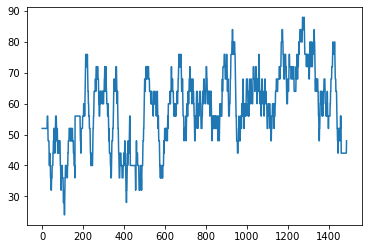

In [12]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

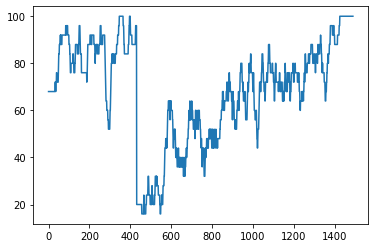

In [13]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

Text(0.5, 1.0, 'Block A, Monkey M, Session 82')

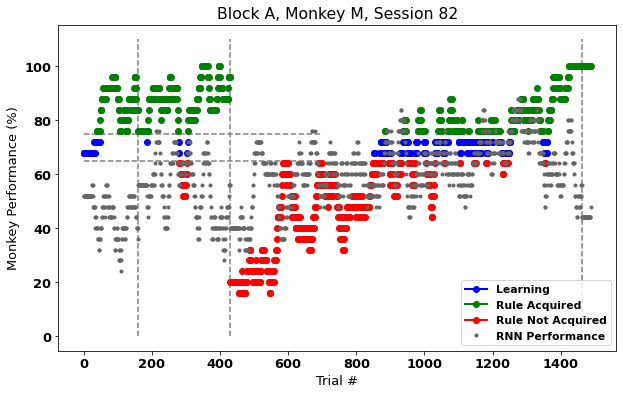

In [14]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block A, Monkey M, Session 82")
# plt.savefig("monkey_model_performance_J52C.svg")

Pearson Correlation Coefficient: 0.03752181637060155
Spearman Correlation Coefficient: -0.023232611747659757


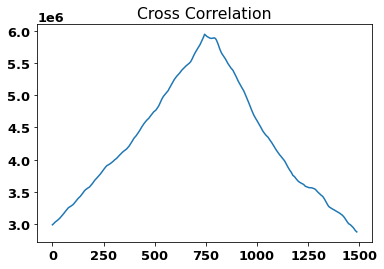

In [15]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### M74_A

In [66]:
test_sess_ix = 5
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_074_0001_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 500  970 1087 1089 1147 1148 1228 1229 1230]
sra3_1_m_081_00+01
(1305,)
(1305, 166, 32)
(1305,) 0 7


In [67]:
border = np.array([500, 970, 1087, 1147, 1228, 1230])

In [68]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [69]:
print(np.unique(_y[650:], return_counts=True))
print(np.unique(_y[:650], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 22, 138,  27, 151,  15, 153,  12, 137], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 29, 147,  24, 145,  15, 122,  11, 157], dtype=int64))


In [70]:
x_tr = _x[:650]
tmp = _y[:650]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[650:]
tmp = _y[650:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS2, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/650
40/40 [==============================] - 3s 65ms/step - loss: 2.3784 - accuracy: 0.2516 - val_loss: 2.2721 - val_accuracy: 0.2351
Epoch 2/650
40/40 [==============================] - 2s 44ms/step - loss: 2.0013 - accuracy: 0.4203 - val_loss: 2.2026 - val_accuracy: 0.2382
Epoch 3/650
40/40 [==============================] - 2s 44ms/step - loss: 1.8741 - accuracy: 0.4844 - val_loss: 2.1270 - val_accuracy: 0.2672
Epoch 4/650
40/40 [==============================] - 2s 44ms/step - loss: 1.8570 - accuracy: 0.4641 - val_loss: 2.0425 - val_accuracy: 0.4229
Epoch 5/650
40/40 [==============================] - 2s 42ms/step - loss: 1.8044 - accuracy: 0.4984 - val_loss: 1.9703 - val_accuracy: 0.4977
Epoch 6/650
40/40 [==============================] - 2s 42ms/step - loss: 1.7717 - accuracy: 0.5281 - val_loss: 1.8818 - val_accuracy: 0.4504
Epoch 7/650
40/40 [==============================] - 2s 42ms/step - loss: 1.6947 - accuracy: 0.5547 - val_loss: 1.7704 - val_accuracy: 0.5206
Epoch 

40/40 [==============================] - 2s 46ms/step - loss: 1.0061 - accuracy: 0.9594 - val_loss: 1.8157 - val_accuracy: 0.5786
Epoch 116/650
40/40 [==============================] - 2s 46ms/step - loss: 1.0242 - accuracy: 0.9453 - val_loss: 1.7629 - val_accuracy: 0.5969
Epoch 117/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9951 - accuracy: 0.9672 - val_loss: 1.7834 - val_accuracy: 0.5863
Epoch 118/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9930 - accuracy: 0.9672 - val_loss: 1.8206 - val_accuracy: 0.6015
Epoch 119/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9839 - accuracy: 0.9750 - val_loss: 1.8218 - val_accuracy: 0.6031
Epoch 120/650
40/40 [==============================] - 2s 46ms/step - loss: 1.0028 - accuracy: 0.9547 - val_loss: 1.7764 - val_accuracy: 0.5954
Epoch 121/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9733 - accuracy: 0.9766 - val_loss: 1.8962 - val_accuracy: 0.5786
Epoch 

Epoch 172/650
40/40 [==============================] - 2s 45ms/step - loss: 0.9663 - accuracy: 0.9734 - val_loss: 1.8612 - val_accuracy: 0.5725
Epoch 173/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9900 - accuracy: 0.9563 - val_loss: 1.8506 - val_accuracy: 0.5908
Epoch 174/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9487 - accuracy: 0.9781 - val_loss: 1.8699 - val_accuracy: 0.5725
Epoch 175/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9599 - accuracy: 0.9719 - val_loss: 1.8094 - val_accuracy: 0.5878
Epoch 176/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9483 - accuracy: 0.9781 - val_loss: 1.8047 - val_accuracy: 0.6092
Epoch 177/650
40/40 [==============================] - 2s 47ms/step - loss: 0.9497 - accuracy: 0.9844 - val_loss: 1.8578 - val_accuracy: 0.5649
Epoch 178/650
40/40 [==============================] - 2s 47ms/step - loss: 0.9579 - accuracy: 0.9703 - val_loss: 1.8336 - val_accuracy:

Epoch 229/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9558 - accuracy: 0.9688 - val_loss: 1.8975 - val_accuracy: 0.5588
Epoch 230/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9416 - accuracy: 0.9766 - val_loss: 1.8621 - val_accuracy: 0.5802
Epoch 231/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9467 - accuracy: 0.9719 - val_loss: 1.8562 - val_accuracy: 0.5924
Epoch 232/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9417 - accuracy: 0.9750 - val_loss: 1.8958 - val_accuracy: 0.5573
Epoch 233/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9618 - accuracy: 0.9594 - val_loss: 1.7739 - val_accuracy: 0.6015
Epoch 234/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9510 - accuracy: 0.9688 - val_loss: 1.8165 - val_accuracy: 0.5847
Epoch 235/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9403 - accuracy: 0.9781 - val_loss: 1.8556 - val_accuracy:

Epoch 286/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9271 - accuracy: 0.9828 - val_loss: 1.7983 - val_accuracy: 0.5771
Epoch 287/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9157 - accuracy: 0.9859 - val_loss: 1.8246 - val_accuracy: 0.6015
Epoch 288/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9321 - accuracy: 0.9766 - val_loss: 1.8231 - val_accuracy: 0.5893
Epoch 289/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9263 - accuracy: 0.9797 - val_loss: 1.8690 - val_accuracy: 0.5695
Epoch 290/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9266 - accuracy: 0.9750 - val_loss: 1.8123 - val_accuracy: 0.5863
Epoch 291/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9552 - accuracy: 0.9609 - val_loss: 1.8503 - val_accuracy: 0.5679
Epoch 292/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9275 - accuracy: 0.9781 - val_loss: 1.9498 - val_accuracy:

Epoch 399/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9116 - accuracy: 0.9766 - val_loss: 1.8641 - val_accuracy: 0.5695
Epoch 400/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9171 - accuracy: 0.9797 - val_loss: 1.8382 - val_accuracy: 0.5893
Epoch 401/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9134 - accuracy: 0.9859 - val_loss: 1.8548 - val_accuracy: 0.5802
Epoch 402/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9234 - accuracy: 0.9781 - val_loss: 1.8286 - val_accuracy: 0.5847
Epoch 403/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9003 - accuracy: 0.9906 - val_loss: 1.8803 - val_accuracy: 0.5679
Epoch 404/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9314 - accuracy: 0.9734 - val_loss: 1.8511 - val_accuracy: 0.5847
Epoch 405/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9134 - accuracy: 0.9875 - val_loss: 1.8552 - val_accuracy:

Epoch 456/650
40/40 [==============================] - 2s 50ms/step - loss: 0.9138 - accuracy: 0.9812 - val_loss: 1.8506 - val_accuracy: 0.5771
Epoch 457/650
40/40 [==============================] - 2s 50ms/step - loss: 0.9104 - accuracy: 0.9797 - val_loss: 1.8474 - val_accuracy: 0.5771
Epoch 458/650
40/40 [==============================] - 2s 50ms/step - loss: 0.9287 - accuracy: 0.9750 - val_loss: 1.8290 - val_accuracy: 0.5725
Epoch 459/650
40/40 [==============================] - 2s 50ms/step - loss: 0.9152 - accuracy: 0.9828 - val_loss: 1.9549 - val_accuracy: 0.5374
Epoch 460/650
40/40 [==============================] - 2s 50ms/step - loss: 0.9205 - accuracy: 0.9781 - val_loss: 1.8623 - val_accuracy: 0.5908
Epoch 461/650
40/40 [==============================] - 2s 50ms/step - loss: 0.9107 - accuracy: 0.9828 - val_loss: 1.8292 - val_accuracy: 0.5695
Epoch 462/650
40/40 [==============================] - 2s 50ms/step - loss: 0.9233 - accuracy: 0.9750 - val_loss: 1.9132 - val_accuracy:

Epoch 513/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9157 - accuracy: 0.9766 - val_loss: 1.8910 - val_accuracy: 0.5740
Epoch 514/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9061 - accuracy: 0.9875 - val_loss: 1.8908 - val_accuracy: 0.5618
Epoch 515/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9003 - accuracy: 0.9891 - val_loss: 1.9052 - val_accuracy: 0.5740
Epoch 516/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8952 - accuracy: 0.9891 - val_loss: 1.9105 - val_accuracy: 0.5710
Epoch 517/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9027 - accuracy: 0.9844 - val_loss: 1.8463 - val_accuracy: 0.5924
Epoch 518/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8954 - accuracy: 0.9906 - val_loss: 1.8676 - val_accuracy: 0.5740
Epoch 519/650
40/40 [==============================] - 2s 45ms/step - loss: 0.9034 - accuracy: 0.9844 - val_loss: 1.8558 - val_accuracy:

Epoch 570/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9145 - accuracy: 0.9766 - val_loss: 1.8730 - val_accuracy: 0.5542
Epoch 571/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9063 - accuracy: 0.9781 - val_loss: 1.8584 - val_accuracy: 0.5695
Epoch 572/650
40/40 [==============================] - 2s 47ms/step - loss: 0.9035 - accuracy: 0.9828 - val_loss: 1.8562 - val_accuracy: 0.5863
Epoch 573/650
40/40 [==============================] - 2s 45ms/step - loss: 0.9118 - accuracy: 0.9781 - val_loss: 1.8161 - val_accuracy: 0.5802
Epoch 574/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8989 - accuracy: 0.9844 - val_loss: 1.8097 - val_accuracy: 0.5863
Epoch 575/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8974 - accuracy: 0.9906 - val_loss: 1.8514 - val_accuracy: 0.5893
Epoch 576/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8909 - accuracy: 0.9875 - val_loss: 1.8507 - val_accuracy:

Epoch 627/650
40/40 [==============================] - 2s 46ms/step - loss: 0.9131 - accuracy: 0.9719 - val_loss: 1.8699 - val_accuracy: 0.5939
Epoch 628/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8935 - accuracy: 0.9937 - val_loss: 1.8620 - val_accuracy: 0.5847
Epoch 629/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8903 - accuracy: 0.9906 - val_loss: 1.8451 - val_accuracy: 0.6046
Epoch 630/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8885 - accuracy: 0.9891 - val_loss: 1.8768 - val_accuracy: 0.5908
Epoch 631/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8864 - accuracy: 0.9906 - val_loss: 1.9529 - val_accuracy: 0.5603
Epoch 632/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8948 - accuracy: 0.9844 - val_loss: 1.9145 - val_accuracy: 0.5649
Epoch 633/650
40/40 [==============================] - 2s 46ms/step - loss: 0.8972 - accuracy: 0.9844 - val_loss: 1.9215 - val_accuracy:

In [71]:
# Second half predicted
# pred_y1 = np.
pred_y1

array([2, 3, 1, 7, 1, 5, 3, 5, 5, 5, 3, 1, 5, 5, 3, 7, 1, 1, 5, 7, 1, 1,
       3, 7, 0, 3, 1, 3, 5, 7, 2, 3, 1, 5, 3, 3, 0, 7, 1, 5, 3, 1, 5, 7,
       1, 3, 0, 3, 3, 7, 3, 5, 5, 3, 5, 3, 5, 3, 5, 1, 7, 5, 7, 1, 3, 5,
       0, 6, 7, 3, 3, 0, 1, 3, 5, 2, 3, 1, 1, 3, 0, 1, 7, 7, 5, 3, 3, 3,
       7, 1, 1, 3, 5, 0, 7, 5, 7, 7, 1, 5, 7, 5, 7, 0, 3, 7, 1, 7, 1, 3,
       5, 7, 5, 3, 3, 7, 5, 7, 7, 1, 3, 2, 3, 3, 7, 5, 0, 1, 3, 1, 1, 3,
       0, 1, 7, 5, 3, 7, 5, 5, 5, 7, 3, 5, 7, 7, 0, 5, 1, 1, 5, 7, 5, 0,
       5, 3, 5, 7, 5, 3, 3, 1, 7, 1, 0, 3, 3, 3, 1, 7, 3, 7, 7, 3, 1, 7,
       3, 7, 7, 7, 1, 5, 7, 2, 6, 3, 6, 7, 5, 7, 3, 2, 3, 5, 1, 1, 7, 5,
       7, 5, 5, 0, 5, 3, 5, 5, 3, 7, 5, 1, 1, 0, 5, 7, 1, 1, 1, 7, 5, 3,
       7, 1, 5, 3, 3, 3, 7, 5, 5, 4, 3, 5, 2, 2, 5, 7, 5, 5, 7, 7, 5, 2,
       7, 1, 1, 1, 7, 1, 7, 5, 7, 0, 5, 5, 3, 7, 3, 5, 5, 7, 3, 7, 4, 7,
       7, 5, 3, 3, 2, 7, 7, 0, 7, 5, 3, 7, 7, 3, 7, 7, 3, 3, 1, 3, 3, 3,
       7, 7, 7, 5, 5, 3, 3, 7, 5, 5, 5, 5, 5, 1, 5,

In [72]:
x_tr = _x[650:]
tmp = _y[650:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:650]
tmp = _y[:650]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS2, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/650
40/40 [==============================] - 2s 58ms/step - loss: 2.4259 - accuracy: 0.2531 - val_loss: 2.2717 - val_accuracy: 0.2462
Epoch 2/650
40/40 [==============================] - 2s 40ms/step - loss: 2.0169 - accuracy: 0.4031 - val_loss: 2.2175 - val_accuracy: 0.3246
Epoch 3/650
40/40 [==============================] - 2s 40ms/step - loss: 1.8893 - accuracy: 0.4531 - val_loss: 2.1382 - val_accuracy: 0.3785
Epoch 4/650
40/40 [==============================] - 2s 43ms/step - loss: 1.8258 - accuracy: 0.5125 - val_loss: 2.0691 - val_accuracy: 0.4277
Epoch 5/650
40/40 [==============================] - 2s 45ms/step - loss: 1.7521 - accuracy: 0.5328 - val_loss: 1.9713 - val_accuracy: 0.4308
Epoch 6/650
40/40 [==============================] - 2s 45ms/step - loss: 1.7781 - accuracy: 0.5094 - val_loss: 1.8523 - val_accuracy: 0.5338
Epoch 7/650
40/40 [==============================] - 2s 44ms/step - loss: 1.6853 - accuracy: 0.5875 - val_loss: 1.7704 - val_accuracy: 0.5323
Epoch 

40/40 [==============================] - 2s 44ms/step - loss: 1.0082 - accuracy: 0.9609 - val_loss: 1.9508 - val_accuracy: 0.5446
Epoch 116/650
40/40 [==============================] - 2s 44ms/step - loss: 1.0269 - accuracy: 0.9531 - val_loss: 1.8985 - val_accuracy: 0.5615
Epoch 117/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9993 - accuracy: 0.9688 - val_loss: 1.8018 - val_accuracy: 0.5969
Epoch 118/650
40/40 [==============================] - 2s 44ms/step - loss: 1.0134 - accuracy: 0.9563 - val_loss: 1.8464 - val_accuracy: 0.5769
Epoch 119/650
40/40 [==============================] - 2s 44ms/step - loss: 1.0176 - accuracy: 0.9531 - val_loss: 1.8212 - val_accuracy: 0.5846
Epoch 120/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9997 - accuracy: 0.9688 - val_loss: 1.8902 - val_accuracy: 0.5708
Epoch 121/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9971 - accuracy: 0.9656 - val_loss: 1.8116 - val_accuracy: 0.5985
Epoch 

Epoch 172/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9841 - accuracy: 0.9625 - val_loss: 1.8246 - val_accuracy: 0.5677
Epoch 173/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9715 - accuracy: 0.9703 - val_loss: 1.8257 - val_accuracy: 0.5800
Epoch 174/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9851 - accuracy: 0.9719 - val_loss: 1.8423 - val_accuracy: 0.5477
Epoch 175/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9845 - accuracy: 0.9641 - val_loss: 1.8826 - val_accuracy: 0.5446
Epoch 176/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9940 - accuracy: 0.9563 - val_loss: 1.8349 - val_accuracy: 0.5585
Epoch 177/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9741 - accuracy: 0.9625 - val_loss: 1.8344 - val_accuracy: 0.5877
Epoch 178/650
40/40 [==============================] - 2s 47ms/step - loss: 0.9866 - accuracy: 0.9641 - val_loss: 1.7725 - val_accuracy:

Epoch 229/650
40/40 [==============================] - 2s 48ms/step - loss: 0.9496 - accuracy: 0.9750 - val_loss: 1.8104 - val_accuracy: 0.5708
Epoch 230/650
40/40 [==============================] - 2s 49ms/step - loss: 0.9387 - accuracy: 0.9859 - val_loss: 1.8499 - val_accuracy: 0.5785
Epoch 231/650
40/40 [==============================] - 2s 49ms/step - loss: 0.9573 - accuracy: 0.9734 - val_loss: 1.8196 - val_accuracy: 0.5692
Epoch 232/650
40/40 [==============================] - 2s 50ms/step - loss: 0.9462 - accuracy: 0.9750 - val_loss: 1.8009 - val_accuracy: 0.5738
Epoch 233/650
40/40 [==============================] - 2s 48ms/step - loss: 0.9426 - accuracy: 0.9781 - val_loss: 1.8298 - val_accuracy: 0.5646
Epoch 234/650
40/40 [==============================] - 2s 48ms/step - loss: 0.9724 - accuracy: 0.9672 - val_loss: 1.7977 - val_accuracy: 0.5892
Epoch 235/650
40/40 [==============================] - 2s 49ms/step - loss: 0.9687 - accuracy: 0.9594 - val_loss: 1.9062 - val_accuracy:

Epoch 286/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9654 - accuracy: 0.9688 - val_loss: 1.7992 - val_accuracy: 0.5723
Epoch 287/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9322 - accuracy: 0.9844 - val_loss: 1.8000 - val_accuracy: 0.5800
Epoch 288/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9272 - accuracy: 0.9859 - val_loss: 1.8471 - val_accuracy: 0.5569
Epoch 289/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9559 - accuracy: 0.9625 - val_loss: 1.8340 - val_accuracy: 0.5662
Epoch 290/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9377 - accuracy: 0.9766 - val_loss: 1.7954 - val_accuracy: 0.5815
Epoch 291/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9385 - accuracy: 0.9781 - val_loss: 1.8058 - val_accuracy: 0.5754
Epoch 292/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9510 - accuracy: 0.9766 - val_loss: 1.8896 - val_accuracy:

Epoch 343/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9397 - accuracy: 0.9703 - val_loss: 1.8902 - val_accuracy: 0.5569
Epoch 344/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9243 - accuracy: 0.9859 - val_loss: 1.8620 - val_accuracy: 0.5692
Epoch 345/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9289 - accuracy: 0.9859 - val_loss: 1.8674 - val_accuracy: 0.5738
Epoch 346/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9514 - accuracy: 0.9656 - val_loss: 1.8570 - val_accuracy: 0.5538
Epoch 347/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9583 - accuracy: 0.9609 - val_loss: 1.9008 - val_accuracy: 0.5662
Epoch 348/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9408 - accuracy: 0.9766 - val_loss: 1.9013 - val_accuracy: 0.5569
Epoch 349/650
40/40 [==============================] - 2s 45ms/step - loss: 0.9393 - accuracy: 0.9797 - val_loss: 1.8977 - val_accuracy:

Epoch 400/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9418 - accuracy: 0.9734 - val_loss: 1.8138 - val_accuracy: 0.5677
Epoch 401/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9330 - accuracy: 0.9781 - val_loss: 1.8864 - val_accuracy: 0.5462
Epoch 402/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9255 - accuracy: 0.9797 - val_loss: 1.9123 - val_accuracy: 0.5462
Epoch 403/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9247 - accuracy: 0.9844 - val_loss: 1.9293 - val_accuracy: 0.5569
Epoch 404/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9222 - accuracy: 0.9828 - val_loss: 1.8403 - val_accuracy: 0.5708
Epoch 405/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9170 - accuracy: 0.9859 - val_loss: 1.8405 - val_accuracy: 0.5662
Epoch 406/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9152 - accuracy: 0.9859 - val_loss: 1.8800 - val_accuracy:

Epoch 457/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9004 - accuracy: 0.9922 - val_loss: 1.8499 - val_accuracy: 0.5800
Epoch 458/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9189 - accuracy: 0.9812 - val_loss: 1.8973 - val_accuracy: 0.5600
Epoch 459/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9263 - accuracy: 0.9766 - val_loss: 1.8682 - val_accuracy: 0.5723
Epoch 460/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9407 - accuracy: 0.9688 - val_loss: 1.8551 - val_accuracy: 0.5754
Epoch 461/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9342 - accuracy: 0.9766 - val_loss: 1.8633 - val_accuracy: 0.5600
Epoch 462/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9083 - accuracy: 0.9891 - val_loss: 1.9053 - val_accuracy: 0.5538
Epoch 463/650
40/40 [==============================] - 2s 45ms/step - loss: 0.9291 - accuracy: 0.9750 - val_loss: 1.8095 - val_accuracy:

Epoch 514/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9377 - accuracy: 0.9719 - val_loss: 1.8219 - val_accuracy: 0.5938
Epoch 515/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9297 - accuracy: 0.9828 - val_loss: 1.8447 - val_accuracy: 0.5569
Epoch 516/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9128 - accuracy: 0.9797 - val_loss: 1.7875 - val_accuracy: 0.6015
Epoch 517/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9120 - accuracy: 0.9828 - val_loss: 1.7987 - val_accuracy: 0.5877
Epoch 518/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9189 - accuracy: 0.9844 - val_loss: 1.8293 - val_accuracy: 0.5662
Epoch 519/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9099 - accuracy: 0.9844 - val_loss: 1.8886 - val_accuracy: 0.5631
Epoch 520/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9192 - accuracy: 0.9844 - val_loss: 1.8521 - val_accuracy:

Epoch 571/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9101 - accuracy: 0.9812 - val_loss: 1.8608 - val_accuracy: 0.5846
Epoch 572/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9383 - accuracy: 0.9719 - val_loss: 1.8642 - val_accuracy: 0.5646
Epoch 573/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9224 - accuracy: 0.9812 - val_loss: 1.8155 - val_accuracy: 0.5862
Epoch 574/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9117 - accuracy: 0.9844 - val_loss: 1.8819 - val_accuracy: 0.5708
Epoch 575/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9168 - accuracy: 0.9828 - val_loss: 1.8126 - val_accuracy: 0.5877
Epoch 576/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9152 - accuracy: 0.9859 - val_loss: 1.8770 - val_accuracy: 0.5646
Epoch 577/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9084 - accuracy: 0.9844 - val_loss: 1.9439 - val_accuracy:

Epoch 628/650
40/40 [==============================] - 2s 45ms/step - loss: 0.9245 - accuracy: 0.9703 - val_loss: 1.8736 - val_accuracy: 0.5585
Epoch 629/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9124 - accuracy: 0.9859 - val_loss: 1.8438 - val_accuracy: 0.5738
Epoch 630/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9119 - accuracy: 0.9812 - val_loss: 1.9147 - val_accuracy: 0.5631
Epoch 631/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9144 - accuracy: 0.9766 - val_loss: 1.9339 - val_accuracy: 0.5400
Epoch 632/650
40/40 [==============================] - 2s 44ms/step - loss: 0.9265 - accuracy: 0.9750 - val_loss: 1.8394 - val_accuracy: 0.5769
Epoch 633/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9228 - accuracy: 0.9719 - val_loss: 1.8210 - val_accuracy: 0.5892
Epoch 634/650
40/40 [==============================] - 2s 43ms/step - loss: 0.9372 - accuracy: 0.9672 - val_loss: 1.8657 - val_accuracy:

In [73]:
# First half predicted
# pred_y2 = np.
pred_y2

array([7, 5, 3, 5, 1, 4, 2, 1, 4, 7, 5, 7, 5, 3, 5, 3, 5, 3, 3, 3, 7, 1,
       7, 7, 4, 3, 3, 2, 1, 3, 3, 2, 3, 2, 5, 7, 5, 3, 4, 3, 0, 3, 7, 3,
       1, 5, 3, 1, 1, 5, 3, 5, 4, 2, 1, 1, 1, 1, 3, 7, 3, 7, 7, 5, 3, 5,
       5, 0, 3, 5, 7, 5, 1, 5, 5, 5, 5, 5, 1, 7, 3, 1, 7, 5, 3, 1, 7, 5,
       7, 1, 7, 7, 3, 3, 7, 1, 1, 5, 1, 5, 3, 3, 1, 1, 1, 1, 7, 7, 3, 1,
       7, 7, 5, 5, 5, 5, 3, 3, 3, 4, 3, 3, 3, 3, 7, 5, 1, 1, 5, 4, 4, 5,
       2, 5, 1, 3, 1, 5, 1, 5, 0, 3, 1, 7, 3, 5, 1, 6, 1, 5, 3, 1, 5, 3,
       1, 5, 3, 3, 5, 5, 0, 3, 7, 7, 1, 2, 3, 5, 7, 3, 5, 1, 5, 1, 2, 1,
       3, 5, 5, 0, 5, 2, 1, 7, 2, 1, 5, 2, 1, 5, 1, 1, 5, 5, 3, 1, 3, 2,
       4, 1, 5, 0, 3, 5, 7, 3, 7, 1, 1, 7, 3, 1, 0, 3, 5, 3, 7, 0, 5, 1,
       7, 4, 3, 3, 1, 1, 3, 6, 4, 7, 7, 1, 1, 3, 3, 7, 5, 0, 2, 1, 7, 3,
       5, 3, 3, 1, 0, 3, 7, 7, 5, 7, 3, 3, 5, 5, 1, 1, 1, 4, 0, 3, 2, 2,
       3, 3, 4, 3, 4, 1, 3, 5, 6, 5, 3, 1, 5, 1, 3, 4, 0, 1, 3, 5, 3, 1,
       7, 5, 7, 1, 7, 3, 3, 1, 2, 2, 1, 4, 3, 3, 1,

In [74]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

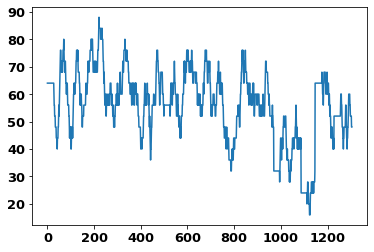

In [75]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

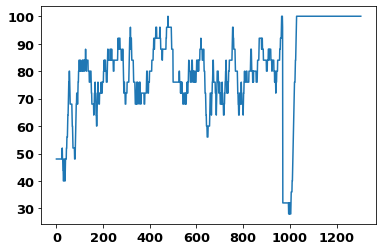

In [76]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

Text(0.5, 1.0, 'Block A, Monkey M, Session 74')

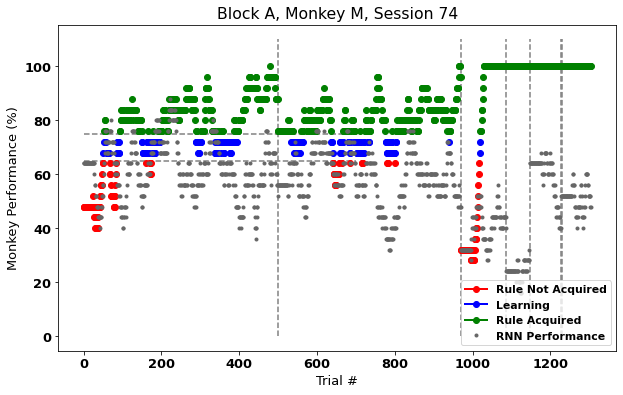

In [77]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block A, Monkey M, Session 74")
# plt.savefig("monkey_model_performance_J52C.svg")

Pearson Correlation Coefficient: -0.08431800643533528
Spearman Correlation Coefficient: -0.17999534043085305


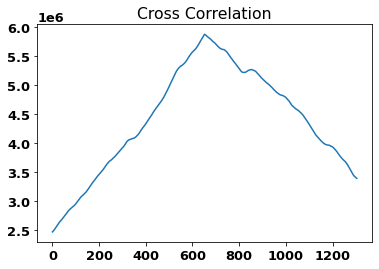

In [78]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


## Block B

### J51_B

In [41]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 2718, 48)
(1377,) 0 6


In [53]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

In [54]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [55]:
print(np.unique(_y[650:], return_counts=True))
print(np.unique(_y[:650], return_counts=True))

(array([0, 1, 2, 4, 5, 6], dtype=int64), array([ 20, 161, 162,  28, 174, 182], dtype=int64))
(array([0, 1, 2, 4, 5, 6], dtype=int64), array([ 25, 141, 160,  26, 143, 155], dtype=int64))


In [56]:
x_tr = _x[:650]
tmp = _y[:650]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[650:]
tmp = _y[650:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/150
40/40 [==============================] - 6s 147ms/step - loss: 2.2617 - accuracy: 0.3156 - val_loss: 2.2016 - val_accuracy: 0.4553
Epoch 2/150
40/40 [==============================] - 4s 90ms/step - loss: 1.7378 - accuracy: 0.5562 - val_loss: 2.0996 - val_accuracy: 0.4897
Epoch 3/150
40/40 [==============================] - 4s 89ms/step - loss: 1.6545 - accuracy: 0.5422 - val_loss: 1.9588 - val_accuracy: 0.5131
Epoch 4/150
40/40 [==============================] - 3s 87ms/step - loss: 1.6009 - accuracy: 0.5984 - val_loss: 1.8445 - val_accuracy: 0.5846
Epoch 5/150
40/40 [==============================] - 4s 92ms/step - loss: 1.5743 - accuracy: 0.5984 - val_loss: 1.7099 - val_accuracy: 0.5997
Epoch 6/150
40/40 [==============================] - 4s 91ms/step - loss: 1.5320 - accuracy: 0.6547 - val_loss: 1.6342 - val_accuracy: 0.6561
Epoch 7/150
40/40 [==============================] - 4s 90ms/step - loss: 1.5391 - accuracy: 0.6344 - val_loss: 1.5497 - val_accuracy: 0.6699
Epoch

40/40 [==============================] - 3s 83ms/step - loss: 0.9488 - accuracy: 0.9609 - val_loss: 1.5351 - val_accuracy: 0.6823
Epoch 116/150
40/40 [==============================] - 3s 86ms/step - loss: 0.9698 - accuracy: 0.9563 - val_loss: 1.5434 - val_accuracy: 0.6657
Epoch 117/150
40/40 [==============================] - 4s 92ms/step - loss: 0.9499 - accuracy: 0.9563 - val_loss: 1.5042 - val_accuracy: 0.6781
Epoch 118/150
40/40 [==============================] - 3s 84ms/step - loss: 0.9598 - accuracy: 0.9547 - val_loss: 1.5145 - val_accuracy: 0.6795
Epoch 119/150
40/40 [==============================] - 3s 82ms/step - loss: 0.9622 - accuracy: 0.9609 - val_loss: 1.5262 - val_accuracy: 0.6795
Epoch 120/150
40/40 [==============================] - 3s 87ms/step - loss: 0.9602 - accuracy: 0.9547 - val_loss: 1.5358 - val_accuracy: 0.6823
Epoch 121/150
40/40 [==============================] - 3s 85ms/step - loss: 0.9425 - accuracy: 0.9734 - val_loss: 1.5372 - val_accuracy: 0.6781
Epoch 

In [57]:
# Second half predicted
# pred_y1 = np.array([2, 2, 6, 6, 6, 6, 1, 6, 6, 0, 6, 6, 6, 0, 5, 1, 6, 5, 5, 1, 5, 5,
#        4, 2, 2, 1, 6, 2, 6, 1, 2, 5, 6, 2, 6, 2, 2, 6, 6, 2, 6, 6, 2, 6,
#        2, 6, 5, 2, 6, 6, 6, 5, 5, 2, 5, 2, 5, 5, 5, 1, 1, 2, 2, 4, 6, 6,
#        6, 5, 5, 2, 2, 6, 2, 5, 6, 5, 2, 0, 6, 2, 5, 5, 5, 1, 6, 6, 6, 5,
#        0, 1, 2, 6, 2, 2, 6, 2, 2, 6, 6, 6, 2, 1, 2, 5, 2, 5, 5, 5, 5, 6,
#        0, 6, 6, 2, 1, 6, 0, 2, 5, 5, 6, 6, 5, 2, 5, 6, 5, 5, 2, 5, 6, 6,
#        6, 4, 5, 6, 2, 1, 6, 6, 5, 1, 2, 6, 6, 2, 2, 2, 6, 6, 5, 2, 5, 5,
#        6, 2, 2, 6, 2, 2, 5, 2, 4, 1, 6, 0, 2, 6, 2, 6, 2, 6, 2, 6, 2, 1,
#        6, 4, 2, 6, 1, 1, 5, 1, 1, 2, 2, 5, 6, 6, 4, 4, 6, 2, 5, 5, 1, 2,
#        1, 2, 4, 6, 2, 6, 6, 6, 5, 6, 5, 5, 4, 1, 2, 5, 2, 1, 5, 2, 1, 0,
#        6, 6, 1, 6, 2, 2, 2, 1, 6, 6, 2, 6, 5, 5, 1, 0, 6, 6, 5, 5, 2, 5,
#        6, 0, 6, 2, 5, 5, 2, 2, 5, 2, 2, 6, 2, 2, 0, 6, 1, 6, 6, 0, 5, 1,
#        1, 5, 1, 1, 6, 6, 2, 5, 2, 6, 6, 2, 2, 5, 2, 2, 2, 6, 6, 6, 5, 5,
#        6, 5, 6, 6, 0, 6, 5, 2, 5, 6, 1, 6, 5, 6, 5, 2, 1, 2, 6, 1, 2, 1,
#        6, 6, 6, 5, 6, 5, 6, 6, 6, 6, 5, 5, 5, 6, 5, 0, 6, 6, 2, 2, 6, 2,
#        6, 5, 2, 5, 1, 6, 4, 6, 6, 6, 1])
pred_y1

array([5, 6, 6, 6, 2, 5, 2, 2, 0, 4, 6, 1, 1, 5, 5, 1, 1, 5, 4, 2, 1, 2,
       1, 2, 4, 6, 1, 0, 5, 6, 1, 1, 1, 2, 2, 6, 6, 1, 1, 6, 1, 1, 2, 2,
       1, 1, 2, 2, 2, 1, 5, 2, 2, 6, 6, 5, 2, 2, 5, 1, 2, 5, 1, 6, 2, 6,
       1, 5, 1, 2, 1, 1, 6, 5, 2, 5, 5, 6, 6, 1, 1, 6, 6, 2, 2, 6, 2, 5,
       2, 1, 6, 1, 2, 1, 1, 0, 2, 1, 2, 1, 6, 6, 6, 6, 6, 1, 2, 2, 5, 6,
       0, 6, 2, 1, 5, 1, 1, 6, 5, 5, 2, 6, 2, 1, 6, 5, 1, 2, 5, 2, 1, 6,
       2, 5, 2, 1, 1, 2, 1, 0, 2, 6, 0, 2, 2, 2, 5, 6, 5, 5, 6, 6, 5, 5,
       5, 6, 2, 1, 5, 2, 1, 6, 1, 6, 5, 2, 0, 2, 6, 5, 6, 1, 6, 2, 2, 5,
       2, 2, 6, 1, 4, 1, 2, 2, 6, 2, 5, 6, 1, 5, 6, 0, 5, 1, 1, 4, 1, 6,
       2, 6, 1, 6, 6, 5, 2, 2, 1, 2, 6, 2, 4, 1, 1, 0, 5, 5, 6, 2, 6, 2,
       2, 1, 5, 2, 2, 6, 6, 1, 2, 5, 2, 2, 5, 1, 5, 5, 6, 1, 1, 5, 2, 6,
       1, 6, 1, 5, 1, 2, 4, 1, 2, 5, 6, 2, 6, 2, 5, 6, 2, 1, 1, 5, 2, 5,
       1, 5, 6, 4, 6, 1, 5, 2, 6, 5, 5, 0, 2, 1, 1, 5, 5, 6, 6, 1, 4, 2,
       1, 5, 1, 2, 0, 5, 5, 5, 5, 5, 1, 6, 6, 6, 2,

In [58]:
x_tr = _x[650:]
tmp = _y[650:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:650]
tmp = _y[:650]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/150
45/45 [==============================] - 6s 129ms/step - loss: 2.1682 - accuracy: 0.3722 - val_loss: 2.1872 - val_accuracy: 0.4923
Epoch 2/150
45/45 [==============================] - 4s 86ms/step - loss: 1.7227 - accuracy: 0.5278 - val_loss: 2.0642 - val_accuracy: 0.5154
Epoch 3/150
45/45 [==============================] - 4s 89ms/step - loss: 1.6860 - accuracy: 0.5194 - val_loss: 2.0001 - val_accuracy: 0.5138
Epoch 4/150
45/45 [==============================] - 4s 87ms/step - loss: 1.6031 - accuracy: 0.5847 - val_loss: 1.8492 - val_accuracy: 0.5446
Epoch 5/150
45/45 [==============================] - 4s 88ms/step - loss: 1.5713 - accuracy: 0.6028 - val_loss: 1.6749 - val_accuracy: 0.5400
Epoch 6/150
45/45 [==============================] - 4s 87ms/step - loss: 1.5433 - accuracy: 0.5986 - val_loss: 1.5642 - val_accuracy: 0.6138
Epoch 7/150
45/45 [==============================] - 4s 83ms/step - loss: 1.5282 - accuracy: 0.6097 - val_loss: 1.4916 - val_accuracy: 0.6492
Epoch

45/45 [==============================] - 4s 79ms/step - loss: 0.9801 - accuracy: 0.9403 - val_loss: 1.5191 - val_accuracy: 0.7154
Epoch 116/150
45/45 [==============================] - 4s 87ms/step - loss: 0.9858 - accuracy: 0.9361 - val_loss: 1.5839 - val_accuracy: 0.6692
Epoch 117/150
45/45 [==============================] - 4s 80ms/step - loss: 0.9997 - accuracy: 0.9264 - val_loss: 1.5126 - val_accuracy: 0.6985
Epoch 118/150
45/45 [==============================] - 4s 79ms/step - loss: 0.9742 - accuracy: 0.9444 - val_loss: 1.6035 - val_accuracy: 0.6831
Epoch 119/150
45/45 [==============================] - 4s 80ms/step - loss: 0.9861 - accuracy: 0.9472 - val_loss: 1.4967 - val_accuracy: 0.7077
Epoch 120/150
45/45 [==============================] - 4s 80ms/step - loss: 0.9619 - accuracy: 0.9542 - val_loss: 1.5755 - val_accuracy: 0.6754
Epoch 121/150
45/45 [==============================] - 4s 79ms/step - loss: 0.9492 - accuracy: 0.9611 - val_loss: 1.6005 - val_accuracy: 0.6846
Epoch 

In [59]:
# First half predicted
# pred_y2 = np.array([2, 1, 5, 2, 2, 6, 6, 6, 6, 5, 2, 5, 2, 6, 2, 5, 6, 1, 1, 5, 5, 1,
#        2, 4, 6, 2, 5, 4, 2, 5, 6, 1, 2, 6, 1, 2, 6, 6, 1, 2, 2, 5, 6, 6,
#        6, 6, 0, 0, 2, 6, 6, 1, 5, 5, 6, 5, 5, 2, 5, 0, 6, 2, 5, 6, 6, 5,
#        2, 1, 2, 5, 2, 6, 4, 6, 2, 5, 1, 2, 2, 5, 5, 2, 1, 5, 0, 2, 5, 2,
#        6, 2, 6, 5, 6, 5, 2, 5, 6, 6, 2, 1, 6, 2, 5, 5, 6, 2, 5, 5, 6, 6,
#        5, 2, 4, 1, 1, 1, 6, 6, 5, 5, 2, 5, 2, 1, 6, 5, 4, 6, 2, 1, 2, 5,
#        6, 1, 6, 2, 5, 1, 6, 2, 6, 6, 4, 5, 6, 0, 1, 6, 2, 2, 2, 6, 6, 2,
#        2, 4, 2, 2, 2, 2, 6, 1, 5, 2, 2, 6, 6, 2, 6, 6, 4, 1, 5, 6, 5, 5,
#        5, 5, 2, 6, 5, 2, 6, 1, 2, 2, 1, 6, 6, 6, 5, 5, 2, 1, 5, 6, 5, 2,
#        6, 5, 6, 6, 6, 6, 5, 6, 1, 5, 6, 2, 2, 2, 1, 6, 1, 5, 1, 5, 5, 6,
#        5, 6, 5, 1, 5, 1, 6, 5, 1, 2, 2, 6, 5, 2, 5, 2, 1, 5, 6, 1, 6, 5,
#        1, 2, 6, 2, 2, 2, 6, 2, 1, 6, 1, 2, 0, 6, 1, 2, 2, 1, 1, 2, 4, 5,
#        2, 1, 2, 6, 6, 4, 2, 1, 2, 5, 1, 5, 2, 5, 6, 5, 2, 2, 6, 1, 5, 2,
#        6, 6, 5, 5, 2, 6, 5, 4, 6, 2, 2, 1, 2, 5, 5, 6, 1, 2, 6, 5, 6, 5,
#        1, 6, 5, 0, 5, 0, 6, 6, 2, 2, 6, 2, 2, 5, 5, 5, 5, 2, 4, 2, 5, 5,
#        6, 0, 5, 5, 5, 2, 1, 2, 5, 2])
pred_y2

array([1, 6, 5, 5, 6, 4, 1, 1, 5, 2, 6, 1, 2, 2, 2, 1, 2, 4, 1, 1, 5, 0,
       1, 5, 1, 6, 5, 1, 5, 5, 6, 6, 2, 2, 0, 6, 2, 2, 6, 1, 5, 2, 2, 6,
       5, 6, 1, 1, 2, 5, 2, 5, 6, 5, 6, 5, 6, 2, 4, 5, 2, 6, 1, 2, 6, 1,
       6, 5, 6, 0, 2, 2, 4, 2, 2, 5, 2, 1, 1, 6, 2, 1, 6, 5, 1, 6, 5, 6,
       4, 2, 2, 4, 6, 5, 6, 0, 5, 5, 1, 5, 2, 4, 6, 6, 1, 6, 2, 5, 2, 1,
       0, 5, 6, 6, 4, 6, 6, 1, 6, 1, 6, 5, 6, 1, 2, 5, 6, 1, 2, 6, 5, 6,
       5, 2, 5, 6, 5, 5, 5, 1, 2, 2, 2, 5, 6, 5, 2, 5, 2, 6, 1, 5, 6, 5,
       6, 2, 1, 4, 4, 6, 5, 2, 2, 1, 6, 4, 1, 6, 1, 5, 6, 5, 1, 6, 6, 1,
       1, 2, 1, 6, 5, 2, 1, 2, 6, 0, 6, 5, 6, 1, 2, 5, 1, 6, 2, 6, 5, 2,
       6, 6, 1, 5, 2, 5, 6, 0, 6, 6, 2, 6, 0, 1, 1, 5, 2, 4, 6, 5, 6, 6,
       6, 6, 6, 1, 6, 1, 6, 5, 6, 5, 0, 1, 5, 2, 2, 6, 6, 1, 1, 6, 6, 5,
       2, 6, 5, 6, 2, 4, 1, 2, 5, 6, 4, 1, 5, 2, 5, 1, 6, 5, 5, 5, 1, 5,
       1, 5, 5, 0, 6, 6, 1, 6, 1, 2, 5, 1, 2, 5, 5, 0, 1, 5, 5, 6, 5, 2,
       4, 6, 2, 2, 5, 5, 5, 6, 1, 5, 2, 0, 6, 6, 6,

In [60]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

In [61]:
pred_y

array([4, 4, 4, ..., 5, 1, 1], dtype=int64)

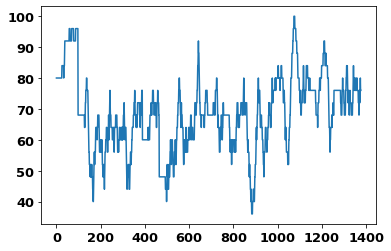

In [62]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

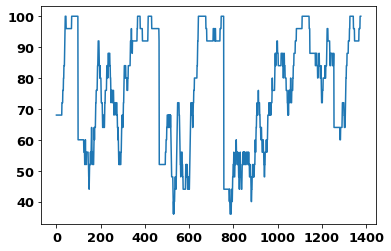

In [63]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

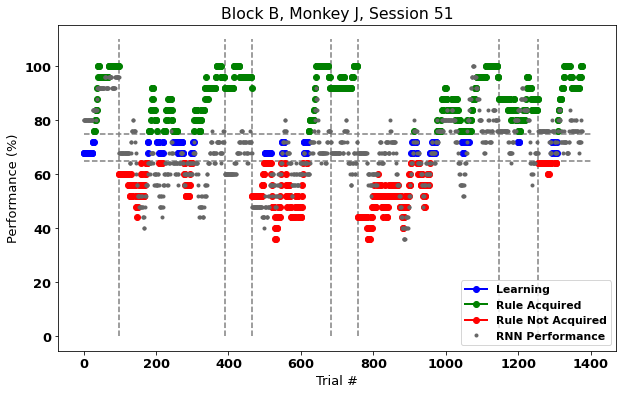

In [64]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=1400, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=1400, linestyles='dashed', colors='grey')
plt.title("Block B, Monkey J, Session 51")
plt.ylabel("Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.savefig("monkey_model_performance_J51B.svg")

Pearson Correlation Coefficient: 0.5197338864619909
Spearman Correlation Coefficient: 0.5026415212024485


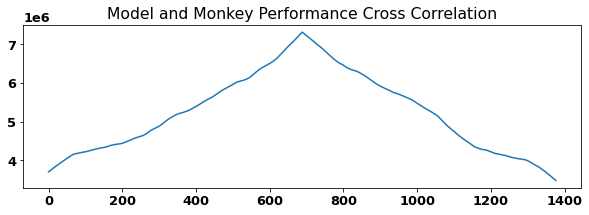

In [65]:
corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(corr)
plt.title("Model and Monkey Performance Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')
plt.savefig("monkey_model_cross_J51B.svg")

### M81_B

In [36]:
test_sess_ix = 5
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_081_0001_segmented_new.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
# from scipy import signal
# kernel = signal.gaussian(100, 20)
X_conv = X
# for i in range(X.shape[0]):
#     for j in range(X.shape[2]):
#         X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 453  493  840  841 1283 1362 1363 1456 1457 1540 1541 1542 1543 1544
 1545 1546 1547 1548 1549 1550 1551 1552 1553]
sra3_1_m_081_00+01
(1632,)
(1632, 2483, 23)
(1632,) 0 7


In [32]:
border = np.array([453, 493, 840, 1283, 1362, 1456, 1540, 1553])

In [37]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [38]:
print(np.unique(_y[800:], return_counts=True))
print(np.unique(_y[:800], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 20, 113, 131, 143,  20, 113, 141, 151], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 18, 105, 129, 145,  22, 113, 125, 143], dtype=int64))


In [40]:
EPOCHS2 = 50
x_tr = _x[:800]
tmp = _y[:800]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[800:]
tmp = _y[800:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS2, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/50
50/50 [==============================] - 27s 543ms/step - loss: 2.5563 - accuracy: 0.1538 - val_loss: 2.3161 - val_accuracy: 0.1358
Epoch 2/50
50/50 [==============================] - 27s 537ms/step - loss: 2.3828 - accuracy: 0.2138 - val_loss: 2.2994 - val_accuracy: 0.1358
Epoch 3/50
50/50 [==============================] - 27s 542ms/step - loss: 2.3244 - accuracy: 0.1875 - val_loss: 2.2788 - val_accuracy: 0.1394
Epoch 4/50
50/50 [==============================] - 27s 538ms/step - loss: 2.2535 - accuracy: 0.2300 - val_loss: 2.2563 - val_accuracy: 0.1575
Epoch 5/50
50/50 [==============================] - 27s 541ms/step - loss: 2.2613 - accuracy: 0.2100 - val_loss: 2.2211 - val_accuracy: 0.2488
Epoch 6/50
50/50 [==============================] - 27s 539ms/step - loss: 2.2081 - accuracy: 0.2425 - val_loss: 2.2042 - val_accuracy: 0.2212
Epoch 7/50
50/50 [==============================] - 28s 564ms/step - loss: 2.1612 - accuracy: 0.2637 - val_loss: 2.1663 - val_accuracy: 0.2320

In [41]:
# Second half predicted
# pred_y1 = np.
pred_y1

array([1, 7, 3, 5, 7, 2, 7, 2, 2, 1, 1, 1, 5, 2, 7, 7, 1, 1, 2, 7, 7, 6,
       1, 2, 1, 2, 6, 1, 1, 2, 1, 1, 1, 1, 6, 1, 3, 5, 2, 7, 1, 7, 1, 2,
       2, 7, 6, 2, 1, 5, 1, 2, 1, 3, 2, 7, 2, 1, 1, 5, 5, 7, 2, 3, 7, 5,
       7, 7, 7, 1, 1, 7, 7, 2, 1, 1, 1, 7, 1, 5, 6, 7, 1, 1, 2, 6, 7, 5,
       2, 2, 5, 2, 5, 6, 6, 5, 3, 1, 1, 5, 1, 5, 1, 1, 1, 2, 5, 5, 3, 2,
       1, 2, 7, 2, 5, 2, 1, 5, 5, 1, 5, 1, 1, 6, 1, 1, 6, 1, 2, 5, 1, 1,
       2, 2, 1, 3, 2, 1, 1, 1, 2, 1, 1, 3, 1, 3, 6, 7, 1, 7, 5, 2, 1, 1,
       1, 3, 1, 1, 6, 3, 1, 2, 7, 1, 1, 6, 2, 1, 1, 1, 1, 1, 5, 5, 7, 5,
       2, 2, 1, 1, 1, 2, 2, 1, 1, 7, 5, 1, 2, 2, 6, 7, 1, 5, 1, 1, 5, 1,
       3, 1, 1, 7, 2, 1, 2, 7, 5, 5, 2, 5, 1, 2, 5, 3, 1, 2, 2, 2, 5, 1,
       3, 1, 6, 1, 7, 7, 5, 1, 1, 1, 2, 1, 7, 1, 1, 5, 5, 5, 3, 1, 7, 1,
       2, 7, 1, 2, 5, 1, 1, 1, 5, 3, 1, 2, 1, 1, 1, 5, 2, 2, 6, 5, 3, 1,
       2, 1, 1, 6, 1, 2, 7, 5, 1, 1, 1, 7, 2, 6, 1, 1, 1, 1, 2, 1, 3, 1,
       1, 6, 6, 6, 1, 5, 1, 3, 1, 5, 1, 1, 3, 3, 2,

In [42]:
x_tr = _x[800:]
tmp = _y[800:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:800]
tmp = _y[:800]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS2, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/50
52/52 [==============================] - 32s 616ms/step - loss: 2.5419 - accuracy: 0.1707 - val_loss: 2.3154 - val_accuracy: 0.1513
Epoch 2/50
52/52 [==============================] - 32s 608ms/step - loss: 2.3607 - accuracy: 0.2115 - val_loss: 2.2975 - val_accuracy: 0.1412
Epoch 3/50
52/52 [==============================] - 32s 609ms/step - loss: 2.3155 - accuracy: 0.2212 - val_loss: 2.2811 - val_accuracy: 0.1562
Epoch 4/50
52/52 [==============================] - 32s 617ms/step - loss: 2.2382 - accuracy: 0.2392 - val_loss: 2.2517 - val_accuracy: 0.1875
Epoch 5/50
52/52 [==============================] - 32s 608ms/step - loss: 2.2217 - accuracy: 0.2464 - val_loss: 2.2295 - val_accuracy: 0.2013
Epoch 6/50
52/52 [==============================] - 32s 610ms/step - loss: 2.1593 - accuracy: 0.2921 - val_loss: 2.1646 - val_accuracy: 0.2250
Epoch 7/50
52/52 [==============================] - 32s 610ms/step - loss: 2.1537 - accuracy: 0.2764 - val_loss: 2.2186 - val_accuracy: 0.2212

In [43]:
# First half predicted
# pred_y2 = np.
pred_y2

array([1, 1, 5, 6, 2, 2, 3, 1, 6, 1, 2, 6, 2, 2, 2, 1, 3, 2, 3, 1, 2, 1,
       6, 7, 5, 1, 2, 1, 1, 5, 2, 6, 1, 7, 3, 7, 3, 1, 2, 0, 7, 3, 3, 3,
       3, 3, 3, 6, 2, 3, 7, 3, 3, 6, 1, 1, 3, 6, 2, 6, 6, 3, 7, 2, 2, 1,
       2, 1, 2, 3, 2, 5, 5, 2, 3, 3, 5, 2, 1, 6, 2, 2, 1, 3, 3, 3, 6, 5,
       5, 1, 3, 2, 3, 1, 3, 7, 5, 1, 2, 3, 5, 2, 2, 5, 6, 5, 0, 1, 3, 6,
       6, 2, 2, 2, 5, 2, 3, 5, 2, 6, 2, 2, 7, 7, 3, 3, 7, 2, 2, 2, 2, 2,
       7, 7, 2, 2, 2, 7, 2, 1, 3, 2, 5, 3, 2, 2, 1, 3, 1, 2, 1, 2, 3, 1,
       3, 7, 3, 7, 7, 1, 6, 3, 6, 6, 1, 1, 0, 2, 2, 1, 2, 1, 1, 7, 2, 5,
       5, 6, 7, 7, 5, 7, 6, 7, 1, 3, 2, 6, 5, 6, 1, 1, 2, 1, 3, 5, 7, 2,
       1, 3, 1, 2, 2, 7, 6, 6, 2, 1, 1, 0, 1, 2, 2, 6, 2, 5, 2, 1, 2, 2,
       7, 3, 2, 3, 3, 6, 1, 2, 6, 2, 6, 2, 2, 2, 1, 6, 1, 2, 2, 2, 7, 3,
       5, 2, 5, 2, 1, 2, 3, 1, 2, 7, 1, 2, 6, 6, 5, 2, 2, 1, 2, 2, 1, 1,
       6, 1, 1, 2, 2, 6, 1, 2, 3, 5, 2, 2, 6, 6, 1, 2, 1, 1, 6, 2, 1, 3,
       2, 1, 2, 6, 1, 5, 2, 7, 1, 1, 7, 3, 3, 1, 3,

In [44]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

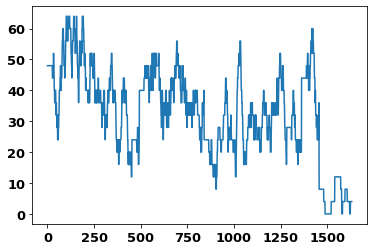

In [45]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

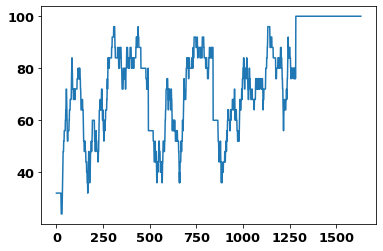

In [46]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

Text(0.5, 1.0, 'Block B, Monkey M, Session 81')

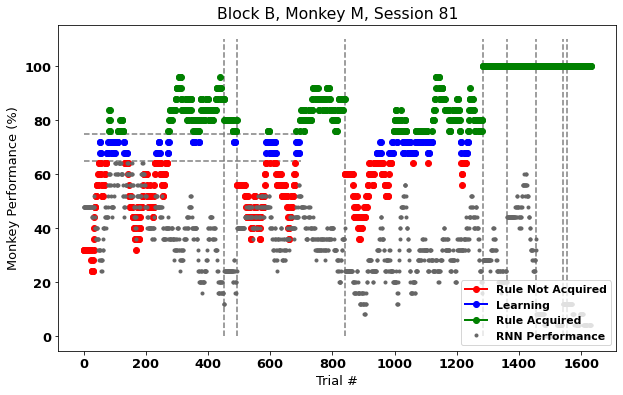

In [47]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block B, Monkey M, Session 81")
# plt.savefig("monkey_model_performance_J52C.svg")

Pearson Correlation Coefficient: 0.04916422980207368
Spearman Correlation Coefficient: 0.05699494448694253


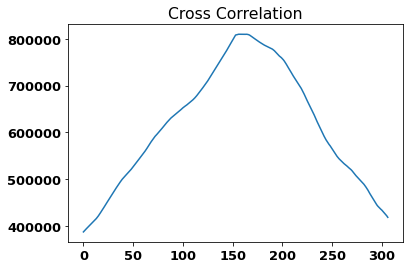

In [91]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


## Block C

### J52_C

In [65]:
test_sess_ix = 3
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_052_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[120 218 312 515 516 599]
sra3_1_j_052_00+
(691,)
(691, 2453, 34)
(691,) 0 7


In [66]:
border = np.array([120, 218, 312, 516, 599])

In [67]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [69]:
np.unique(_y[345:], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([22, 36, 93, 27, 22, 47, 63, 36], dtype=int64))

In [70]:
x_tr = _x[:345]
tmp = _y[:345]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[345:]
tmp = _y[345:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs2)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/150
21/21 [==============================] - 22s 1s/step - loss: 2.7364 - accuracy: 0.1220 - val_loss: 2.3568 - val_accuracy: 0.1705
Epoch 2/150
21/21 [==============================] - 21s 1s/step - loss: 2.3826 - accuracy: 0.2530 - val_loss: 2.3464 - val_accuracy: 0.1676
Epoch 3/150
21/21 [==============================] - 21s 1s/step - loss: 2.2107 - accuracy: 0.3690 - val_loss: 2.3366 - val_accuracy: 0.1763
Epoch 4/150
21/21 [==============================] - 21s 1s/step - loss: 2.0831 - accuracy: 0.3810 - val_loss: 2.3159 - val_accuracy: 0.2197
Epoch 5/150
21/21 [==============================] - 21s 1s/step - loss: 2.0390 - accuracy: 0.4048 - val_loss: 2.2890 - val_accuracy: 0.2861
Epoch 6/150
21/21 [==============================] - 21s 1s/step - loss: 1.9505 - accuracy: 0.4792 - val_loss: 2.2629 - val_accuracy: 0.3006
Epoch 7/150
21/21 [==============================] - 21s 1s/step - loss: 1.8879 - accuracy: 0.5298 - val_loss: 2.2131 - val_accuracy: 0.3150
Epoch 8/150
2

Epoch 59/150
21/21 [==============================] - 21s 1s/step - loss: 1.1175 - accuracy: 0.9673 - val_loss: 2.0491 - val_accuracy: 0.5318
Epoch 60/150
21/21 [==============================] - 21s 1s/step - loss: 1.1048 - accuracy: 0.9643 - val_loss: 2.0778 - val_accuracy: 0.5029
Epoch 61/150
21/21 [==============================] - 21s 1s/step - loss: 1.1207 - accuracy: 0.9554 - val_loss: 2.0613 - val_accuracy: 0.5260
Epoch 62/150
21/21 [==============================] - 21s 1s/step - loss: 1.1140 - accuracy: 0.9732 - val_loss: 2.0722 - val_accuracy: 0.5116
Epoch 63/150
21/21 [==============================] - 21s 1s/step - loss: 1.0876 - accuracy: 0.9821 - val_loss: 2.0097 - val_accuracy: 0.5231
Epoch 64/150
21/21 [==============================] - 21s 1s/step - loss: 1.0984 - accuracy: 0.9762 - val_loss: 2.0167 - val_accuracy: 0.5260
Epoch 65/150
21/21 [==============================] - 21s 1s/step - loss: 1.0828 - accuracy: 0.9732 - val_loss: 1.9712 - val_accuracy: 0.5347
Epoch 

In [71]:
# Second half predicted
pred_y1 = np.array([5, 5, 6, 7, 6, 7, 2, 3, 2, 5, 7, 0, 6, 2, 2, 7, 6, 1, 6, 5, 5, 6,
       2, 6, 6, 3, 6, 2, 7, 0, 5, 0, 1, 5, 6, 6, 5, 1, 2, 1, 1, 2, 1, 2,
       1, 2, 0, 4, 3, 3, 1, 1, 5, 2, 6, 3, 2, 2, 2, 5, 3, 6, 1, 1, 1, 6,
       2, 3, 7, 4, 2, 6, 5, 3, 5, 7, 7, 2, 0, 6, 0, 6, 0, 7, 6, 6, 7, 1,
       7, 4, 5, 2, 2, 5, 7, 2, 6, 5, 5, 3, 6, 0, 7, 6, 2, 7, 4, 3, 0, 7,
       2, 4, 6, 4, 7, 7, 6, 2, 4, 4, 3, 2, 7, 6, 7, 2, 1, 7, 1, 4, 5, 1,
       4, 7, 4, 6, 2, 2, 2, 6, 7, 2, 6, 0, 1, 5, 5, 2, 3, 6, 0, 4, 1, 1,
       5, 2, 5, 5, 3, 5, 6, 1, 6, 4, 0, 6, 5, 6, 2, 6, 0, 6, 6, 5, 6, 0,
       5, 2, 1, 6, 5, 6, 5, 1, 6, 7, 2, 6, 3, 2, 5, 2, 6, 6, 6, 1, 3, 1,
       2, 7, 0, 7, 1, 6, 5, 3, 2, 1, 7, 3, 6, 4, 2, 6, 0, 7, 5, 3, 0, 6,
       1, 3, 5, 3, 2, 1, 6, 5, 5, 2, 2, 2, 4, 7, 5, 7, 3, 2, 3, 5, 6, 2,
       6, 6, 2, 6, 5, 5, 6, 1, 6, 6, 6, 2, 4, 1, 5, 6, 6, 5, 6, 2, 2, 2,
       6, 2, 5, 6, 2, 2, 6, 2, 1, 2, 2, 7, 6, 2, 7, 5, 0, 1, 2, 4, 5, 6,
       0, 5, 6, 6, 5, 6, 3, 4, 7, 3, 6, 7, 6, 3, 2, 5, 2, 7, 2, 3, 6, 6,
       1, 5, 5, 5, 6, 4, 7, 2, 6, 2, 7, 3, 2, 7, 6, 5, 6, 5, 7, 6, 5, 2,
       7, 7, 5, 2, 6, 7, 4, 0, 6, 2, 6, 6, 1, 2, 6, 6])


array([5, 5, 6, 7, 6, 7, 2, 3, 2, 5, 7, 0, 6, 2, 2, 7, 6, 1, 6, 5, 5, 6,
       2, 6, 6, 3, 6, 2, 7, 0, 5, 0, 1, 5, 6, 6, 5, 1, 2, 1, 1, 2, 1, 2,
       1, 2, 0, 4, 3, 3, 1, 1, 5, 2, 6, 3, 2, 2, 2, 5, 3, 6, 1, 1, 1, 6,
       2, 3, 7, 4, 2, 6, 5, 3, 5, 7, 7, 2, 0, 6, 0, 6, 0, 7, 6, 6, 7, 1,
       7, 4, 5, 2, 2, 5, 7, 2, 6, 5, 5, 3, 6, 0, 7, 6, 2, 7, 4, 3, 0, 7,
       2, 4, 6, 4, 7, 7, 6, 2, 4, 4, 3, 2, 7, 6, 7, 2, 1, 7, 1, 4, 5, 1,
       4, 7, 4, 6, 2, 2, 2, 6, 7, 2, 6, 0, 1, 5, 5, 2, 3, 6, 0, 4, 1, 1,
       5, 2, 5, 5, 3, 5, 6, 1, 6, 4, 0, 6, 5, 6, 2, 6, 0, 6, 6, 5, 6, 0,
       5, 2, 1, 6, 5, 6, 5, 1, 6, 7, 2, 6, 3, 2, 5, 2, 6, 6, 6, 1, 3, 1,
       2, 7, 0, 7, 1, 6, 5, 3, 2, 1, 7, 3, 6, 4, 2, 6, 0, 7, 5, 3, 0, 6,
       1, 3, 5, 3, 2, 1, 6, 5, 5, 2, 2, 2, 4, 7, 5, 7, 3, 2, 3, 5, 6, 2,
       6, 6, 2, 6, 5, 5, 6, 1, 6, 6, 6, 2, 4, 1, 5, 6, 6, 5, 6, 2, 2, 2,
       6, 2, 5, 6, 2, 2, 6, 2, 1, 2, 2, 7, 6, 2, 7, 5, 0, 1, 2, 4, 5, 6,
       0, 5, 6, 6, 5, 6, 3, 4, 7, 3, 6, 7, 6, 3, 2,

In [72]:
x_tr = _x[345:]
tmp = _y[345:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:345]
tmp = _y[:345]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/150
21/21 [==============================] - 17s 818ms/step - loss: 2.7435 - accuracy: 0.1369 - val_loss: 2.3253 - val_accuracy: 0.2522
Epoch 2/150
21/21 [==============================] - 15s 725ms/step - loss: 2.3775 - accuracy: 0.2202 - val_loss: 2.3118 - val_accuracy: 0.2580
Epoch 3/150
21/21 [==============================] - 15s 727ms/step - loss: 2.2576 - accuracy: 0.2857 - val_loss: 2.2970 - val_accuracy: 0.3072
Epoch 4/150
21/21 [==============================] - 15s 726ms/step - loss: 2.1844 - accuracy: 0.3304 - val_loss: 2.2730 - val_accuracy: 0.3565
Epoch 5/150
21/21 [==============================] - 15s 726ms/step - loss: 2.0860 - accuracy: 0.4077 - val_loss: 2.2471 - val_accuracy: 0.3913
Epoch 6/150
21/21 [==============================] - 15s 725ms/step - loss: 2.0234 - accuracy: 0.4494 - val_loss: 2.2082 - val_accuracy: 0.4290
Epoch 7/150
21/21 [==============================] - 15s 726ms/step - loss: 1.9973 - accuracy: 0.4375 - val_loss: 2.1675 - val_accuracy:

21/21 [==============================] - 16s 767ms/step - loss: 1.0279 - accuracy: 0.9851 - val_loss: 2.0904 - val_accuracy: 0.5188
Epoch 114/150
21/21 [==============================] - 16s 747ms/step - loss: 0.9979 - accuracy: 0.9940 - val_loss: 2.0778 - val_accuracy: 0.5159
Epoch 115/150
21/21 [==============================] - 16s 768ms/step - loss: 1.0017 - accuracy: 0.9762 - val_loss: 2.0965 - val_accuracy: 0.5188
Epoch 116/150
21/21 [==============================] - 15s 734ms/step - loss: 1.0040 - accuracy: 0.9851 - val_loss: 2.1762 - val_accuracy: 0.4783
Epoch 117/150
21/21 [==============================] - 16s 740ms/step - loss: 0.9981 - accuracy: 0.9881 - val_loss: 2.1603 - val_accuracy: 0.4870
Epoch 118/150
21/21 [==============================] - 15s 730ms/step - loss: 0.9903 - accuracy: 0.9940 - val_loss: 2.1314 - val_accuracy: 0.5159
Epoch 119/150
21/21 [==============================] - 15s 729ms/step - loss: 1.0043 - accuracy: 0.9851 - val_loss: 2.1098 - val_accuracy:

In [73]:
# First half predicted
pred_y2 = np.array([2, 1, 6, 5, 2, 6, 2, 2, 5, 0, 7, 3, 6, 2, 1, 6, 6, 6, 5, 0, 5, 2,
       2, 5, 5, 2, 2, 5, 7, 5, 6, 1, 5, 2, 5, 2, 1, 6, 7, 5, 2, 2, 2, 2,
       1, 0, 4, 3, 2, 1, 2, 5, 0, 1, 7, 5, 2, 6, 1, 1, 2, 0, 6, 1, 5, 2,
       2, 3, 3, 1, 2, 2, 0, 7, 6, 2, 5, 2, 2, 4, 0, 2, 7, 2, 6, 5, 2, 3,
       6, 2, 0, 5, 2, 5, 0, 6, 2, 7, 5, 6, 2, 2, 2, 7, 3, 1, 5, 3, 5, 3,
       2, 7, 2, 7, 3, 7, 7, 7, 2, 0, 5, 5, 1, 2, 2, 7, 5, 0, 5, 2, 2, 7,
       6, 2, 2, 6, 0, 7, 2, 1, 0, 3, 7, 5, 2, 3, 0, 6, 3, 2, 2, 5, 2, 1,
       0, 7, 5, 0, 2, 6, 3, 5, 6, 2, 3, 5, 0, 2, 1, 2, 5, 6, 1, 5, 6, 6,
       3, 0, 5, 6, 5, 2, 7, 2, 2, 7, 2, 5, 3, 2, 6, 5, 2, 6, 1, 5, 0, 2,
       0, 6, 5, 5, 6, 5, 0, 2, 2, 5, 5, 1, 5, 5, 2, 0, 2, 7, 6, 4, 5, 3,
       0, 2, 7, 2, 7, 2, 1, 5, 0, 5, 1, 3, 3, 5, 0, 2, 2, 1, 6, 5, 3, 2,
       7, 3, 7, 3, 2, 7, 7, 6, 5, 2, 2, 7, 1, 2, 5, 7, 2, 6, 1, 7, 5, 7,
       5, 2, 6, 2, 1, 0, 1, 7, 2, 5, 2, 6, 2, 6, 1, 1, 5, 3, 7, 2, 1, 6,
       2, 3, 2, 3, 2, 2, 2, 1, 4, 0, 2, 6, 0, 2, 5, 5, 7, 7, 6, 5, 1, 5,
       2, 7, 3, 2, 5, 2, 6, 2, 5, 6, 2, 5, 7, 5, 6, 5, 5, 1, 3, 6, 6, 2,
       2, 2, 5, 2, 5, 5, 5, 6, 5, 2, 2, 2, 2, 6, 2])


array([2, 1, 6, 5, 2, 6, 2, 2, 5, 0, 7, 3, 6, 2, 1, 6, 6, 6, 5, 0, 5, 2,
       2, 5, 5, 2, 2, 5, 7, 5, 6, 1, 5, 2, 5, 2, 1, 6, 7, 5, 2, 2, 2, 2,
       1, 0, 4, 3, 2, 1, 2, 5, 0, 1, 7, 5, 2, 6, 1, 1, 2, 0, 6, 1, 5, 2,
       2, 3, 3, 1, 2, 2, 0, 7, 6, 2, 5, 2, 2, 4, 0, 2, 7, 2, 6, 5, 2, 3,
       6, 2, 0, 5, 2, 5, 0, 6, 2, 7, 5, 6, 2, 2, 2, 7, 3, 1, 5, 3, 5, 3,
       2, 7, 2, 7, 3, 7, 7, 7, 2, 0, 5, 5, 1, 2, 2, 7, 5, 0, 5, 2, 2, 7,
       6, 2, 2, 6, 0, 7, 2, 1, 0, 3, 7, 5, 2, 3, 0, 6, 3, 2, 2, 5, 2, 1,
       0, 7, 5, 0, 2, 6, 3, 5, 6, 2, 3, 5, 0, 2, 1, 2, 5, 6, 1, 5, 6, 6,
       3, 0, 5, 6, 5, 2, 7, 2, 2, 7, 2, 5, 3, 2, 6, 5, 2, 6, 1, 5, 0, 2,
       0, 6, 5, 5, 6, 5, 0, 2, 2, 5, 5, 1, 5, 5, 2, 0, 2, 7, 6, 4, 5, 3,
       0, 2, 7, 2, 7, 2, 1, 5, 0, 5, 1, 3, 3, 5, 0, 2, 2, 1, 6, 5, 3, 2,
       7, 3, 7, 3, 2, 7, 7, 6, 5, 2, 2, 7, 1, 2, 5, 7, 2, 6, 1, 7, 5, 7,
       5, 2, 6, 2, 1, 0, 1, 7, 2, 5, 2, 6, 2, 6, 1, 1, 5, 3, 7, 2, 1, 6,
       2, 3, 2, 3, 2, 2, 2, 1, 4, 0, 2, 6, 0, 2, 5,

In [74]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

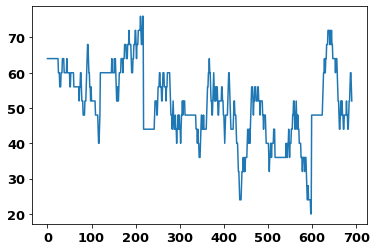

In [75]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

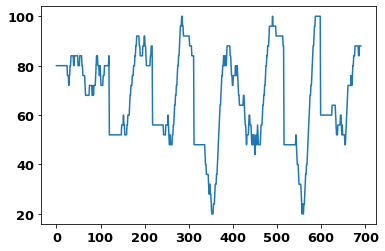

In [76]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

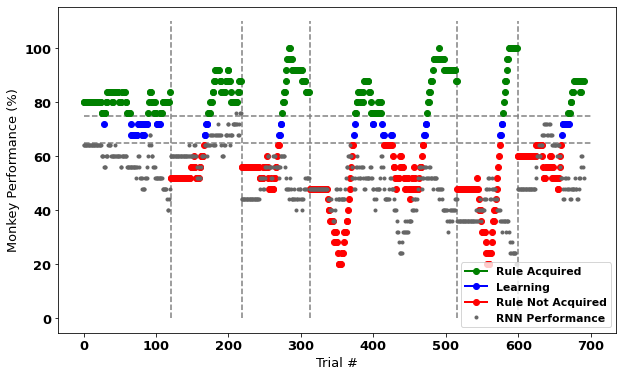

In [77]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
# plt.savefig("monkey_model_performance_J52C.svg")

Pearson Correlation Coefficient: 0.16016340179476568
Spearman Correlation Coefficient: 0.19291343214835383


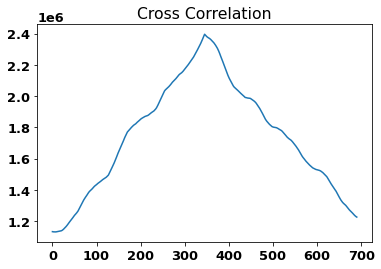

In [78]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### M77_C

In [66]:
test_sess_ix = 4
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_077_0001_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[ 178  425 1236 1314 1382]
sra3_1_m_077_00+01
(1456,)
(1456, 18, 2483)
(1456,) 0 7


In [70]:
border = np.array([178, 425, 1236, 1314, 1382])

In [71]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [72]:
print(np.unique(_y[700:], return_counts=True))
print(np.unique(_y[:700], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([218,  19,  57,  86, 210,  17,  69,  80], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([207,  12,  55,  75, 176,  20,  71,  84], dtype=int64))


In [73]:
x_tr = _x[:700]
tmp = _y[:700]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[700:]
tmp = _y[700:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS2, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/100
43/43 [==============================] - 3s 76ms/step - loss: 2.5762 - accuracy: 0.1701 - val_loss: 2.2855 - val_accuracy: 0.2778
Epoch 2/100
43/43 [==============================] - 2s 45ms/step - loss: 2.3184 - accuracy: 0.2369 - val_loss: 2.2516 - val_accuracy: 0.2778
Epoch 3/100
43/43 [==============================] - 2s 45ms/step - loss: 2.2362 - accuracy: 0.2776 - val_loss: 2.2274 - val_accuracy: 0.2778
Epoch 4/100
43/43 [==============================] - 2s 47ms/step - loss: 2.1680 - accuracy: 0.2703 - val_loss: 2.1988 - val_accuracy: 0.2751
Epoch 5/100
43/43 [==============================] - 2s 45ms/step - loss: 2.1192 - accuracy: 0.2965 - val_loss: 2.1503 - val_accuracy: 0.3082
Epoch 6/100
43/43 [==============================] - 2s 45ms/step - loss: 2.0866 - accuracy: 0.3343 - val_loss: 2.0905 - val_accuracy: 0.3558
Epoch 7/100
43/43 [==============================] - 2s 45ms/step - loss: 2.0368 - accuracy: 0.3576 - val_loss: 2.0215 - val_accuracy: 0.3810
Epoch 

In [74]:
# Second half predicted
# pred_y1 = np.
pred_y1

array([3, 0, 2, 7, 2, 2, 4, 7, 4, 0, 4, 5, 3, 7, 1, 4, 0, 7, 3, 0, 3, 7,
       0, 2, 0, 4, 3, 4, 6, 0, 0, 3, 4, 0, 4, 4, 4, 7, 2, 3, 7, 3, 4, 7,
       7, 2, 0, 7, 7, 7, 4, 6, 3, 6, 4, 0, 0, 0, 6, 3, 4, 0, 0, 0, 6, 3,
       7, 4, 6, 4, 0, 0, 1, 0, 3, 0, 4, 0, 6, 4, 0, 1, 0, 4, 4, 4, 0, 0,
       0, 4, 4, 3, 0, 2, 6, 6, 3, 0, 0, 4, 6, 0, 6, 7, 4, 3, 7, 0, 6, 4,
       4, 4, 4, 4, 6, 0, 2, 0, 2, 4, 0, 1, 4, 4, 6, 0, 6, 0, 2, 0, 4, 0,
       6, 7, 0, 1, 3, 0, 0, 3, 4, 7, 3, 0, 0, 7, 4, 6, 4, 6, 4, 7, 4, 3,
       0, 6, 3, 6, 4, 0, 4, 2, 0, 0, 7, 0, 0, 4, 3, 4, 6, 4, 3, 0, 4, 1,
       4, 2, 0, 4, 3, 6, 0, 4, 0, 0, 3, 0, 0, 4, 4, 5, 0, 0, 5, 0, 0, 6,
       0, 3, 0, 0, 6, 4, 7, 4, 3, 6, 2, 7, 0, 7, 0, 0, 3, 3, 0, 6, 2, 4,
       4, 1, 0, 4, 6, 4, 2, 6, 7, 6, 7, 4, 4, 4, 3, 4, 3, 4, 0, 7, 7, 4,
       3, 4, 4, 0, 0, 6, 0, 3, 4, 2, 0, 3, 7, 4, 0, 0, 7, 7, 6, 0, 4, 7,
       4, 0, 6, 2, 4, 4, 6, 6, 3, 7, 7, 7, 0, 6, 4, 0, 0, 7, 0, 0, 6, 3,
       4, 2, 7, 7, 0, 0, 0, 7, 4, 2, 1, 3, 0, 7, 3,

In [75]:
x_tr = _x[700:]
tmp = _y[700:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:700]
tmp = _y[:700]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS2, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/100
47/47 [==============================] - 4s 78ms/step - loss: 2.5346 - accuracy: 0.1649 - val_loss: 2.2877 - val_accuracy: 0.2514
Epoch 2/100
47/47 [==============================] - 2s 46ms/step - loss: 2.2800 - accuracy: 0.2979 - val_loss: 2.2582 - val_accuracy: 0.2514
Epoch 3/100
47/47 [==============================] - 2s 46ms/step - loss: 2.1921 - accuracy: 0.3138 - val_loss: 2.2345 - val_accuracy: 0.2514
Epoch 4/100
47/47 [==============================] - 2s 46ms/step - loss: 2.1254 - accuracy: 0.3218 - val_loss: 2.1840 - val_accuracy: 0.2543
Epoch 5/100
47/47 [==============================] - 2s 47ms/step - loss: 2.0898 - accuracy: 0.3364 - val_loss: 2.1177 - val_accuracy: 0.3086
Epoch 6/100
47/47 [==============================] - 2s 47ms/step - loss: 2.0315 - accuracy: 0.3497 - val_loss: 2.0254 - val_accuracy: 0.3771
Epoch 7/100
47/47 [==============================] - 2s 47ms/step - loss: 1.9735 - accuracy: 0.3963 - val_loss: 1.9695 - val_accuracy: 0.3929
Epoch 

In [76]:
# First half predicted
# pred_y2 = np.
pred_y2

array([3, 6, 7, 7, 2, 0, 0, 6, 1, 7, 2, 0, 1, 2, 7, 4, 4, 4, 0, 0, 0, 2,
       3, 3, 4, 0, 0, 6, 4, 4, 4, 7, 0, 3, 3, 4, 0, 6, 7, 3, 4, 0, 0, 2,
       3, 7, 0, 0, 3, 7, 4, 0, 0, 3, 3, 3, 0, 4, 7, 4, 0, 4, 3, 0, 0, 0,
       5, 4, 2, 1, 2, 0, 4, 4, 3, 0, 0, 0, 4, 4, 7, 4, 7, 0, 0, 4, 0, 5,
       4, 7, 3, 0, 0, 7, 0, 4, 7, 0, 0, 3, 7, 0, 2, 2, 6, 2, 7, 7, 4, 4,
       0, 7, 0, 4, 0, 1, 4, 0, 6, 0, 4, 0, 3, 0, 0, 6, 4, 6, 7, 0, 7, 4,
       0, 2, 4, 0, 0, 7, 6, 7, 0, 6, 7, 4, 7, 3, 7, 4, 7, 3, 0, 0, 7, 0,
       0, 4, 0, 4, 3, 4, 0, 4, 7, 7, 6, 6, 4, 7, 1, 7, 3, 6, 4, 0, 3, 2,
       0, 0, 7, 6, 2, 1, 6, 0, 6, 4, 4, 3, 0, 7, 3, 7, 4, 6, 0, 6, 7, 0,
       0, 0, 0, 7, 0, 1, 0, 6, 0, 0, 0, 0, 0, 4, 0, 7, 0, 4, 7, 1, 4, 3,
       4, 0, 7, 4, 1, 1, 3, 0, 0, 2, 6, 7, 4, 0, 0, 4, 1, 7, 2, 7, 0, 2,
       3, 2, 3, 4, 7, 0, 6, 4, 0, 4, 0, 0, 3, 2, 2, 0, 2, 1, 2, 7, 0, 0,
       3, 4, 3, 4, 4, 0, 2, 4, 0, 1, 4, 0, 7, 2, 6, 7, 6, 6, 2, 0, 1, 0,
       7, 0, 4, 4, 7, 0, 6, 0, 0, 1, 0, 0, 6, 2, 4,

In [77]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

In [78]:
pred_y

array([2, 6, 6, ..., 6, 1, 6], dtype=int64)

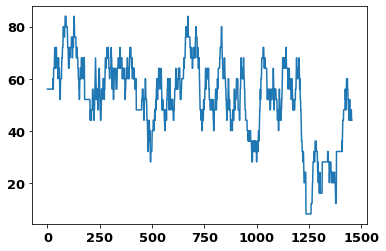

In [79]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
    elif mod_perf[i]>100:
        mod_perf[i] = 100
plt.plot(mod_perf)

In [80]:
mod_perf = mod_perf[:1190]

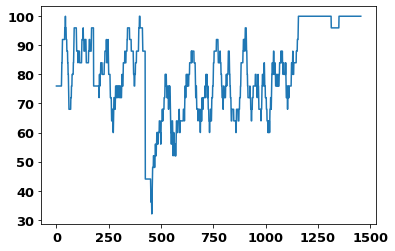

In [81]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
    elif m_performance[i] > 100:
        m_performance[i] = 100
plt.plot(m_performance)

In [82]:
m_performance = m_performance[:1190]

In [83]:
border = np.array([178, 425])

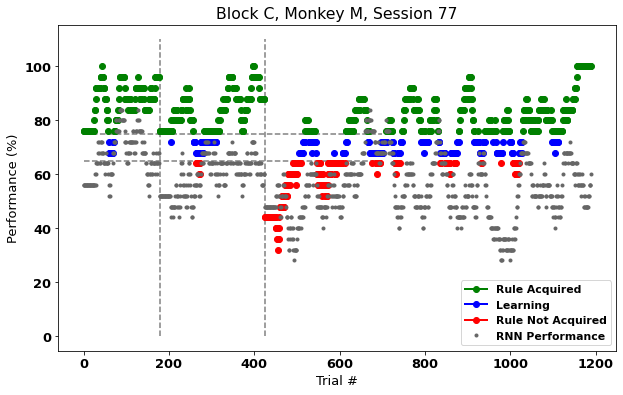

In [84]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block C, Monkey M, Session 77")
plt.savefig("monkey_model_performance_M77C.svg")

Pearson Correlation Coefficient: 0.4003790973220361
Spearman Correlation Coefficient: 0.42318068390747327


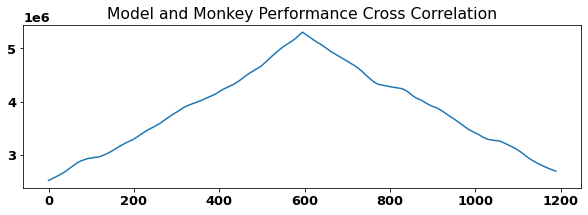

In [85]:
corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
fig, ax = plt.subplots(figsize=(10,3))
plt.plot(corr)
plt.title("Model and Monkey Performance Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')
plt.savefig("monkey_model_cross_M77C.svg")

### M83_C

In [13]:
test_sess_ix = 5
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_083_0001_segmented_new.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 361  362  575 1302 1362 1432]
sra3_1_m_081_00+01
(1494,)
(1494, 2483, 32)
(1494,) 0 7


In [14]:
border = np.array([ 361, 575, 1302, 1362, 1432])

In [15]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [16]:
print(np.unique(_y[750:], return_counts=True))
print(np.unique(_y[:750], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 67,  18,  99, 175,  71,  16, 113, 185], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 72,  15,  90, 192,  73,  12, 120, 176], dtype=int64))


In [17]:
x_tr = _x[:750]
tmp = _y[:750]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[750:]
tmp = _y[750:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y1 = np.argmax(y_pred, axis=1)

Epoch 1/150
46/46 [==============================] - 32s 687ms/step - loss: 2.4726 - accuracy: 0.2364 - val_loss: 2.3122 - val_accuracy: 0.2540
Epoch 2/150
46/46 [==============================] - 34s 732ms/step - loss: 2.3351 - accuracy: 0.2554 - val_loss: 2.2896 - val_accuracy: 0.2742
Epoch 3/150
46/46 [==============================] - 33s 725ms/step - loss: 2.2549 - accuracy: 0.2690 - val_loss: 2.2708 - val_accuracy: 0.2823
Epoch 4/150
46/46 [==============================] - 32s 687ms/step - loss: 2.2152 - accuracy: 0.2908 - val_loss: 2.2439 - val_accuracy: 0.2715
Epoch 5/150
46/46 [==============================] - 31s 683ms/step - loss: 2.1509 - accuracy: 0.3003 - val_loss: 2.2204 - val_accuracy: 0.2594
Epoch 6/150
46/46 [==============================] - 32s 703ms/step - loss: 2.1210 - accuracy: 0.3329 - val_loss: 2.1875 - val_accuracy: 0.2836
Epoch 7/150
46/46 [==============================] - 34s 730ms/step - loss: 2.0781 - accuracy: 0.3356 - val_loss: 2.1789 - val_accuracy:

46/46 [==============================] - 33s 710ms/step - loss: 1.1533 - accuracy: 0.9117 - val_loss: 2.5368 - val_accuracy: 0.3105
Epoch 114/150
46/46 [==============================] - 34s 745ms/step - loss: 1.1487 - accuracy: 0.9253 - val_loss: 2.5715 - val_accuracy: 0.3024
Epoch 115/150
46/46 [==============================] - 38s 826ms/step - loss: 1.1421 - accuracy: 0.9253 - val_loss: 2.5601 - val_accuracy: 0.3051
Epoch 116/150
46/46 [==============================] - 42s 909ms/step - loss: 1.1484 - accuracy: 0.9062 - val_loss: 2.5121 - val_accuracy: 0.3145
Epoch 117/150
46/46 [==============================] - 40s 867ms/step - loss: 1.1797 - accuracy: 0.9062 - val_loss: 2.5636 - val_accuracy: 0.3091
Epoch 118/150
46/46 [==============================] - 39s 845ms/step - loss: 1.1767 - accuracy: 0.9035 - val_loss: 2.5489 - val_accuracy: 0.2957
Epoch 119/150
46/46 [==============================] - 39s 857ms/step - loss: 1.1532 - accuracy: 0.9185 - val_loss: 2.5656 - val_accuracy:

In [18]:
# Second half predicted
# pred_y1 = np.
pred_y1

array([6, 3, 3, 7, 4, 6, 7, 4, 3, 3, 7, 3, 6, 4, 0, 6, 1, 3, 3, 4, 6, 3,
       6, 0, 2, 7, 4, 0, 6, 7, 7, 0, 3, 7, 6, 3, 7, 4, 3, 0, 7, 7, 2, 7,
       7, 7, 4, 3, 7, 2, 3, 4, 6, 3, 7, 3, 6, 4, 3, 4, 5, 3, 0, 7, 3, 7,
       7, 7, 3, 7, 3, 6, 7, 0, 3, 4, 6, 7, 3, 6, 7, 7, 6, 1, 3, 3, 3, 6,
       4, 6, 6, 2, 3, 0, 3, 3, 6, 0, 7, 2, 3, 3, 2, 5, 3, 6, 6, 2, 3, 7,
       6, 7, 6, 0, 6, 1, 7, 7, 2, 2, 3, 4, 2, 6, 3, 7, 6, 6, 1, 7, 3, 3,
       3, 1, 7, 6, 2, 7, 6, 2, 7, 7, 7, 2, 6, 4, 7, 0, 1, 3, 2, 1, 7, 6,
       0, 0, 6, 2, 3, 7, 2, 7, 2, 6, 2, 7, 3, 3, 6, 3, 4, 1, 0, 7, 3, 4,
       3, 7, 3, 6, 2, 0, 6, 3, 6, 7, 2, 3, 6, 0, 2, 3, 3, 3, 2, 3, 3, 3,
       3, 7, 7, 7, 6, 5, 3, 2, 2, 7, 6, 6, 6, 7, 6, 7, 7, 6, 7, 7, 2, 3,
       3, 7, 3, 6, 4, 3, 6, 7, 7, 3, 3, 1, 3, 2, 2, 6, 0, 1, 3, 6, 6, 3,
       3, 7, 0, 3, 3, 7, 3, 7, 4, 4, 6, 4, 7, 3, 7, 7, 3, 3, 7, 7, 7, 7,
       2, 4, 6, 7, 7, 3, 3, 2, 3, 7, 7, 6, 4, 2, 3, 3, 7, 2, 3, 6, 7, 3,
       7, 0, 6, 6, 3, 4, 6, 6, 2, 2, 4, 3, 6, 7, 6,

In [19]:
x_tr = _x[750:]
tmp = _y[750:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[:750]
tmp = _y[:750]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model.predict(x_val)
pred_y2 = np.argmax(y_pred, axis=1)

Epoch 1/150
46/46 [==============================] - 38s 826ms/step - loss: 2.4507 - accuracy: 0.2188 - val_loss: 2.3187 - val_accuracy: 0.2173
Epoch 2/150
46/46 [==============================] - 37s 813ms/step - loss: 2.3294 - accuracy: 0.2636 - val_loss: 2.3013 - val_accuracy: 0.2307
Epoch 3/150
46/46 [==============================] - 37s 805ms/step - loss: 2.2287 - accuracy: 0.3016 - val_loss: 2.2812 - val_accuracy: 0.2413
Epoch 4/150
46/46 [==============================] - 39s 845ms/step - loss: 2.1977 - accuracy: 0.2962 - val_loss: 2.2518 - val_accuracy: 0.2453
Epoch 5/150
46/46 [==============================] - 38s 835ms/step - loss: 2.1673 - accuracy: 0.3370 - val_loss: 2.2164 - val_accuracy: 0.2867
Epoch 6/150
46/46 [==============================] - 37s 814ms/step - loss: 2.1326 - accuracy: 0.3383 - val_loss: 2.1828 - val_accuracy: 0.2813
Epoch 7/150
46/46 [==============================] - 35s 770ms/step - loss: 2.1187 - accuracy: 0.3207 - val_loss: 2.1694 - val_accuracy:

46/46 [==============================] - 30s 650ms/step - loss: 1.1600 - accuracy: 0.9117 - val_loss: 2.6013 - val_accuracy: 0.3067
Epoch 114/150
46/46 [==============================] - 30s 658ms/step - loss: 1.1758 - accuracy: 0.9049 - val_loss: 2.4550 - val_accuracy: 0.3427
Epoch 115/150
46/46 [==============================] - 30s 654ms/step - loss: 1.1677 - accuracy: 0.9185 - val_loss: 2.5271 - val_accuracy: 0.3307
Epoch 116/150
46/46 [==============================] - 33s 719ms/step - loss: 1.1830 - accuracy: 0.9103 - val_loss: 2.5976 - val_accuracy: 0.2987
Epoch 117/150
46/46 [==============================] - 34s 735ms/step - loss: 1.1769 - accuracy: 0.9130 - val_loss: 2.5503 - val_accuracy: 0.3267
Epoch 118/150
46/46 [==============================] - 34s 730ms/step - loss: 1.1908 - accuracy: 0.9049 - val_loss: 2.4689 - val_accuracy: 0.3387
Epoch 119/150
46/46 [==============================] - 31s 683ms/step - loss: 1.1639 - accuracy: 0.9253 - val_loss: 2.5522 - val_accuracy:

In [20]:
# First half predicted
# pred_y2 = np.
pred_y2

array([2, 7, 3, 0, 2, 3, 6, 7, 4, 3, 3, 0, 4, 0, 2, 7, 4, 5, 7, 6, 4, 2,
       4, 2, 2, 2, 4, 4, 5, 2, 6, 2, 6, 4, 7, 2, 3, 6, 4, 6, 4, 4, 2, 6,
       2, 3, 0, 0, 2, 7, 2, 6, 0, 5, 6, 3, 6, 7, 2, 2, 7, 2, 6, 6, 4, 6,
       6, 3, 2, 5, 4, 6, 3, 3, 6, 6, 6, 3, 6, 6, 2, 2, 6, 3, 2, 3, 6, 3,
       2, 5, 2, 7, 7, 2, 7, 2, 7, 3, 3, 2, 2, 7, 3, 0, 3, 6, 2, 6, 6, 0,
       3, 7, 6, 3, 6, 2, 3, 6, 4, 6, 5, 2, 4, 7, 2, 6, 2, 3, 5, 4, 0, 0,
       2, 2, 0, 4, 2, 6, 6, 7, 2, 6, 4, 6, 3, 6, 7, 7, 2, 2, 2, 0, 6, 3,
       7, 7, 4, 6, 6, 2, 4, 6, 6, 2, 7, 6, 2, 7, 7, 2, 7, 4, 7, 2, 0, 3,
       3, 2, 4, 7, 6, 6, 2, 2, 3, 4, 7, 5, 2, 2, 2, 7, 0, 3, 6, 6, 7, 2,
       2, 0, 6, 6, 3, 2, 3, 0, 3, 4, 0, 2, 6, 3, 4, 2, 3, 0, 2, 2, 2, 7,
       3, 4, 6, 0, 7, 7, 6, 7, 7, 7, 0, 2, 3, 4, 6, 4, 7, 2, 0, 3, 6, 2,
       2, 4, 6, 0, 6, 0, 4, 7, 3, 2, 5, 6, 6, 2, 0, 6, 2, 3, 4, 0, 3, 0,
       2, 6, 6, 3, 2, 4, 2, 4, 3, 3, 4, 7, 2, 3, 6, 3, 6, 2, 2, 2, 6, 7,
       4, 2, 0, 3, 7, 0, 0, 4, 3, 2, 2, 2, 0, 0, 7,

In [21]:
_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

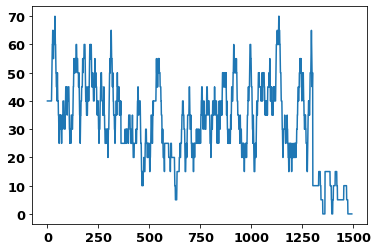

In [22]:
true_y = Y
perf = (pred_y == true_y).astype(int)
mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 20
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

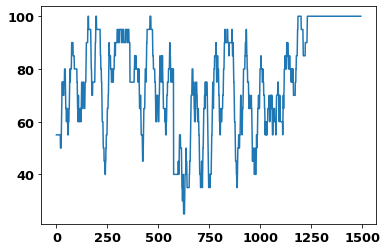

In [23]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 20
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

Text(0.5, 1.0, 'Block C, Monkey M, Session 83')

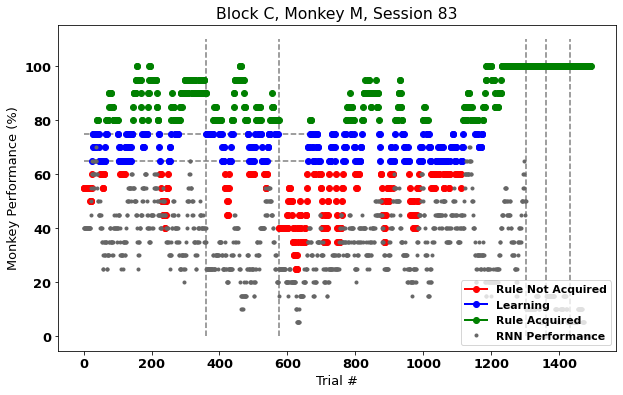

In [24]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='RNN Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block C, Monkey M, Session 83")
# plt.savefig("monkey_model_performance_J52C.svg")

Pearson Correlation Coefficient: -0.11582766100180816
Spearman Correlation Coefficient: -0.1446061184733936


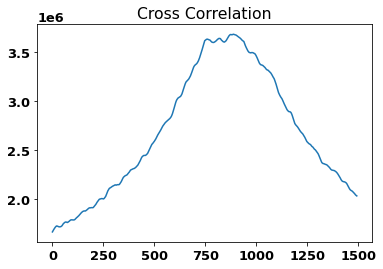

In [25]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


# SVM

## Block A

### J50_A

In [67]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_050_00_segmented_v2.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 72  73 145 177 178 276 422 426 476 516 565 566 567 597 598 602]
sra3_1_j_050_00+
(663,)
(663, 2453, 36)
(663,) 0 7


In [68]:
border = np.array([72, 145, 177, 276, 422, 476, 516, 565, 597, 602])

In [69]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [70]:
print(np.unique(_y, return_counts=True))
print(np.unique(_y[:330], return_counts=True))
print(np.unique(_y[330:], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([ 83,  75, 100,  58,  70, 115,  97,  65]))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([39, 26, 56, 33, 38, 54, 49, 35]))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([44, 49, 44, 25, 32, 61, 48, 30]))


[LibSVM][LibSVM]

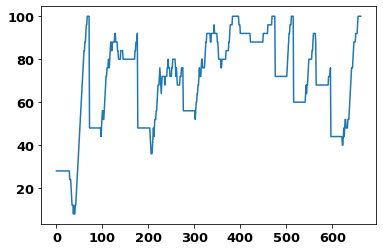

In [71]:
x_tr = np.reshape(_x[:330], (_x[:330].shape[0], -1))
y_tr = _y[:330]
x_val = np.reshape(_x[330:], (_x[330:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[330:], (_x[330:].shape[0], -1))
y_tr = _y[330:]
x_val = np.reshape(_x[:330], (_x[:330].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

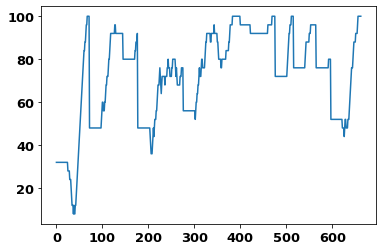

In [72]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

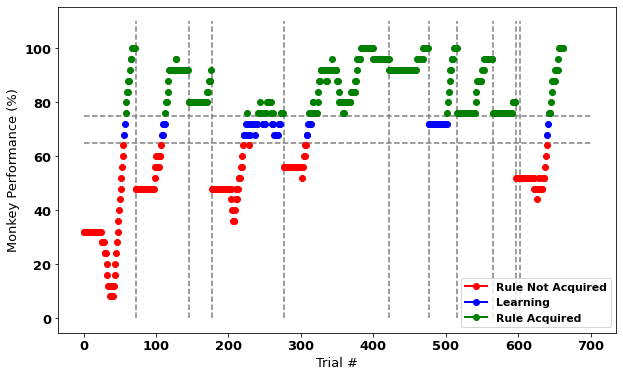

In [73]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


# for i in range(0, len(mod_perf)):
#     if (i==0):
#         ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
#     else:
#         ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.savefig("monkey_model_performance_J50A_neural.svg")

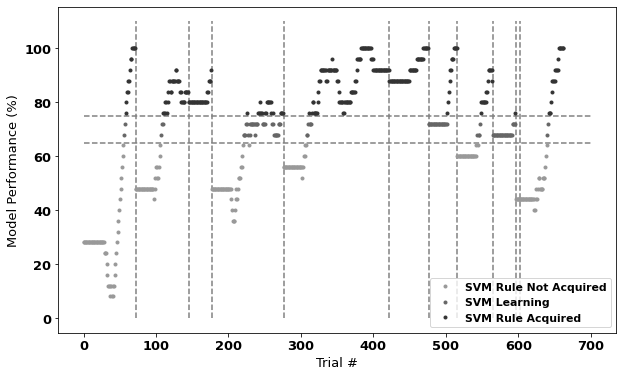

In [75]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(mod_perf)):
    if mod_perf[i] > 75:
        if (first[0]==0):
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.2, 0.2, 0.2), label='SVM Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.2, 0.2, 0.2))
            
                
    elif mod_perf[i] < 65:
        if (first[1]==0):
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.6, 0.6, 0.6), label='SVM Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.6, 0.6, 0.6))
    else:
        if (first[2]==0):
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Learning')
            first[2] = 1
        else:
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))


# for i in range(0, len(mod_perf)):
#     if (i==0):
#         ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
#     else:
#         ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Model Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.savefig("monkey_model_performance_J50A_svm.svg")

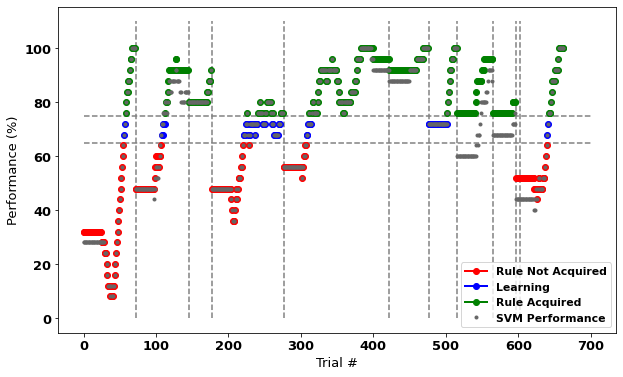

In [76]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.savefig("monkey_model_performance_J50A_neural_svm.svg")

### Cross Correlation

Pearson Correlation Coefficient: 0.9791259828512514
Spearman Correlation Coefficient: 0.9725548647661548


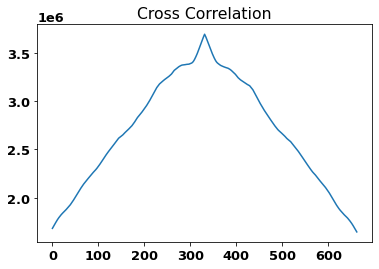

In [10]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### J37_A

In [6]:
test_sess_ix = 0
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_2_j_037_0003_segmented_new.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[396 397]
sra3_2_j_037_00+03
(666,)
(666, 2718, 12)
(666,) 3 7


In [7]:
border = np.array([396])

In [8]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [9]:
print(np.unique(_y[:333], return_counts=True))
print(np.unique(_y[333:], return_counts=True))

(array([3, 7], dtype=int64), array([175, 158], dtype=int64))
(array([3, 7], dtype=int64), array([176, 157], dtype=int64))


[LibSVM][LibSVM]

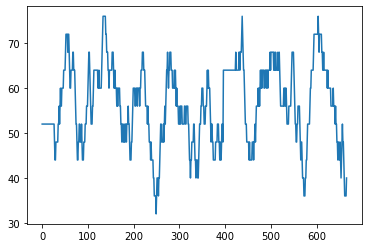

In [10]:
x_tr = np.reshape(_x[:333], (_x[:333].shape[0], -1))
y_tr = _y[:333]
x_val = np.reshape(_x[333:], (_x[333:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[333:], (_x[333:].shape[0], -1))
y_tr = _y[333:]
x_val = np.reshape(_x[:333], (_x[:333].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

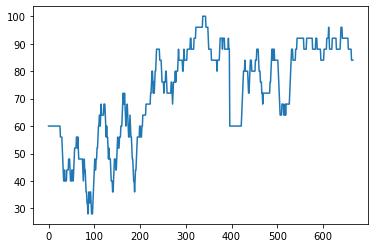

In [11]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

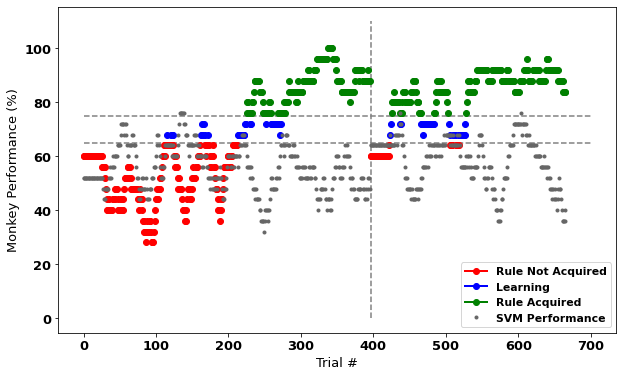

In [12]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
# plt.savefig("monkey_model_performance_J52C.svg")

### Cross Correlation

Pearson Correlation Coefficient: -0.22167410832042755
Spearman Correlation Coefficient: -0.24769224527678657


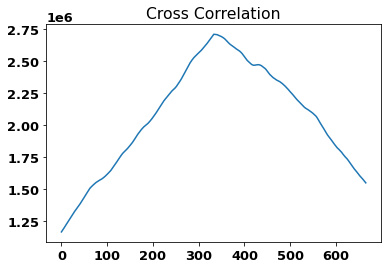

In [13]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### M82_A

In [14]:
test_sess_ix = 6
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_082_0001_segmented_new.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 161  162  431  432 1462 1472]
sra3_1_m_082_00+01
(1489,)
(1489, 2478, 27)
(1489,) 1 7


In [15]:
border = np.array([161, 431, 1462])

In [16]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [17]:
print(np.unique(_y[:740], return_counts=True))
print(np.unique(_y[740:], return_counts=True))

(array([1, 2, 3, 5, 6, 7], dtype=int64), array([ 37,  76, 266,  39,  62, 260], dtype=int64))
(array([1, 2, 3, 5, 6, 7], dtype=int64), array([ 51,  60, 264,  51,  72, 251], dtype=int64))


[LibSVM][LibSVM]

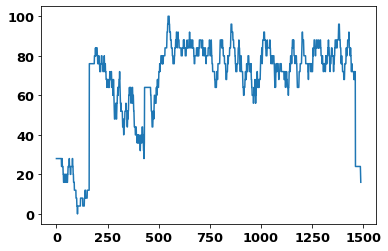

In [18]:
x_tr = np.reshape(_x[:740], (_x[:740].shape[0], -1))
y_tr = _y[:740]
x_val = np.reshape(_x[740:], (_x[740:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[740:], (_x[740:].shape[0], -1))
y_tr = _y[740:]
x_val = np.reshape(_x[:740], (_x[:740].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

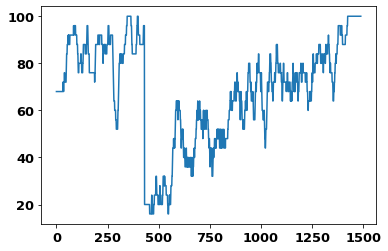

In [19]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

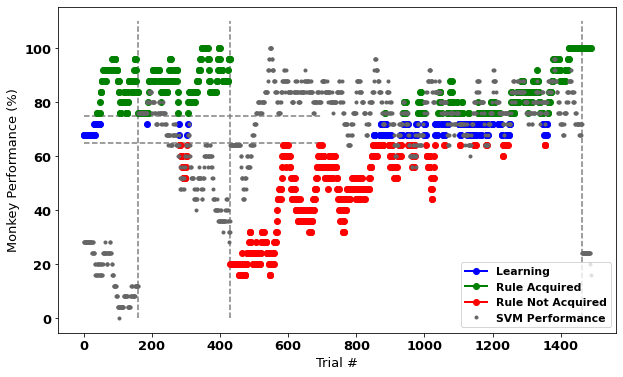

In [20]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
# plt.savefig("monkey_model_performance_J52C.svg")

### Cross Correlation

Pearson Correlation Coefficient: -0.3252873496046526
Spearman Correlation Coefficient: -0.31586150412259467


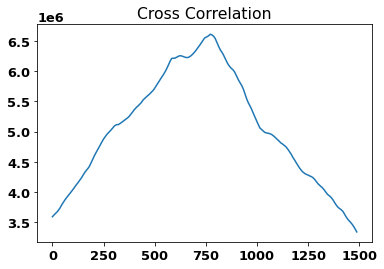

In [21]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### M74_A

In [24]:
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_074_0001_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 500  970 1087 1089 1147 1148 1228 1229 1230]
(1305,)
(1305, 166, 32)
(1305,) 0 7


In [25]:
border = np.array([500, 970, 1087, 1147, 1228, 1230])

In [26]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [27]:
print(np.unique(_y[:650], return_counts=True))
print(np.unique(_y[650:], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 26, 144,  24, 148,  17, 128,  11, 152], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 25, 141,  27, 148,  13, 147,  12, 142], dtype=int64))


[LibSVM][LibSVM]

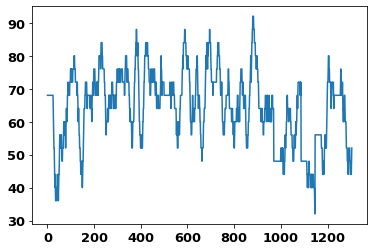

In [28]:
x_tr = np.reshape(_x[:650], (_x[:650].shape[0], -1))
y_tr = _y[:650]
x_val = np.reshape(_x[650:], (_x[650:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[650:], (_x[650:].shape[0], -1))
y_tr = _y[650:]
x_val = np.reshape(_x[:650], (_x[:650].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

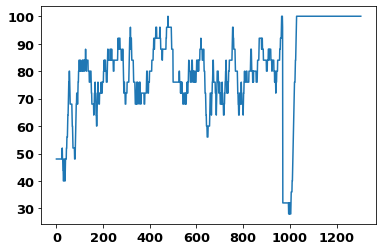

In [29]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

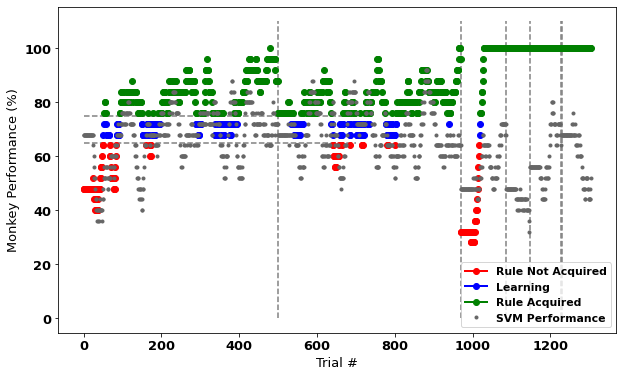

In [30]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
# plt.savefig("monkey_model_performance_J52C.svg")

### Cross Correlation

Pearson Correlation Coefficient: 0.0953281699997422
Spearman Correlation Coefficient: -0.017156426845643762


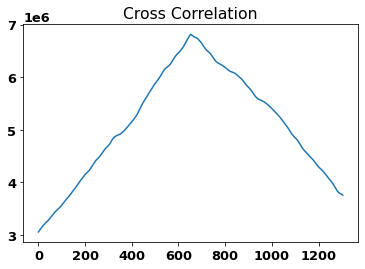

In [31]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


## Block B

### J51_B

In [77]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 2718, 48)
(1377,) 0 6


In [78]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

In [79]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [80]:
print(np.unique(_y[:650], return_counts=True))
print(np.unique(_y[650:], return_counts=True))

(array([0, 1, 2, 4, 5, 6]), array([ 27, 140, 138,  26, 156, 163]))
(array([0, 1, 2, 4, 5, 6]), array([ 18, 162, 184,  28, 161, 174]))


[LibSVM][LibSVM]

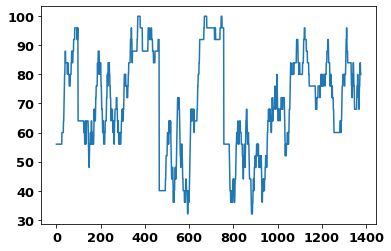

In [81]:
x_tr = np.reshape(_x[:650], (_x[:650].shape[0], -1))
y_tr = _y[:650]
x_val = np.reshape(_x[650:], (_x[650:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[650:], (_x[650:].shape[0], -1))
y_tr = _y[650:]
x_val = np.reshape(_x[:650], (_x[:650].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

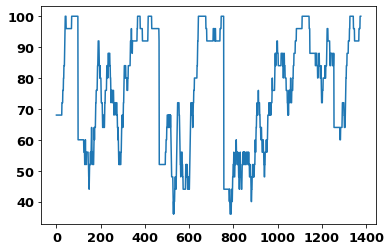

In [82]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

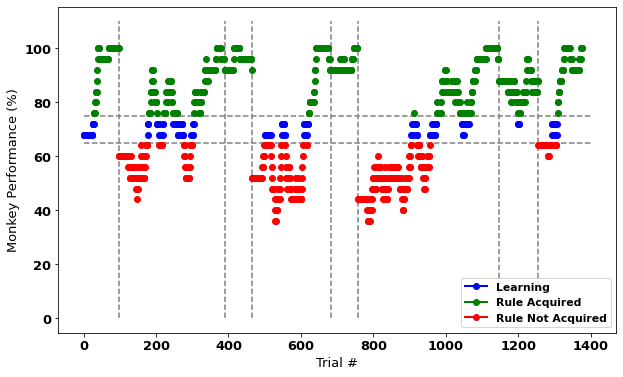

In [57]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


# for i in range(0, len(mod_perf)):
#     if (i==0):
#         ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
#     else:
#         ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=1400, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=1400, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.savefig("monkey_model_performance_J51B_neural.svg")

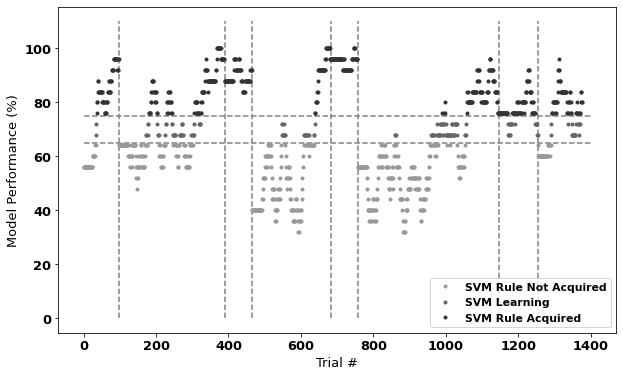

In [83]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(mod_perf)):
    if mod_perf[i] > 75:
        if (first[0]==0):
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.2, 0.2, 0.2), label='SVM Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.2, 0.2, 0.2))
            
                
    elif mod_perf[i] < 65:
        if (first[1]==0):
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.6, 0.6, 0.6), label='SVM Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.6, 0.6, 0.6))
    else:
        if (first[2]==0):
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Learning')
            first[2] = 1
        else:
            ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))


# for i in range(0, len(mod_perf)):
#     if (i==0):
#         ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
#     else:
#         ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=1400, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=1400, linestyles='dashed', colors='grey')

plt.ylabel("Model Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.savefig("monkey_model_performance_J51B_svm.svg")

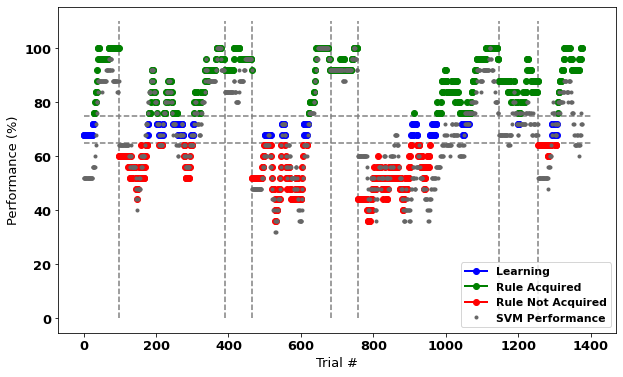

In [64]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=1400, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=1400, linestyles='dashed', colors='grey')

plt.ylabel("Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.savefig("monkey_model_performance_J51B_neural_svm.svg")

### Cross Correlation

Pearson Correlation Coefficient: 0.9051683427339843
Spearman Correlation Coefficient: 0.8965879372771993


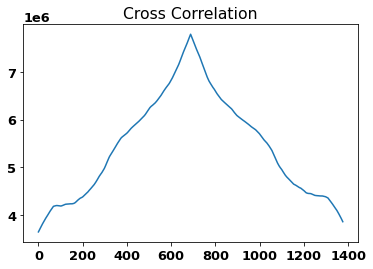

In [12]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### M81_B

In [32]:
test_sess_ix = 5
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_081_0001_segmented_new.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 453  493  840  841 1283 1362 1363 1456 1457 1540 1541 1542 1543 1544
 1545 1546 1547 1548 1549 1550 1551 1552 1553]
(1632,)
(1632, 2483, 23)
(1632,) 0 7


In [33]:
border = np.array([453, 493, 840, 1283, 1362, 1456, 1540, 1553])

In [34]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [35]:
print(np.unique(_y[:800], return_counts=True))
print(np.unique(_y[800:], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 23,  91, 130, 140,  16, 106, 148, 146], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 15, 127, 130, 148,  26, 120, 118, 148], dtype=int64))


[LibSVM][LibSVM]

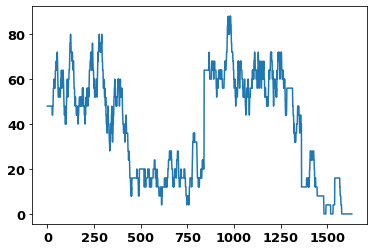

In [36]:
x_tr = np.reshape(_x[:800], (_x[:800].shape[0], -1))
y_tr = _y[:800]
x_val = np.reshape(_x[800:], (_x[800:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[800:], (_x[800:].shape[0], -1))
y_tr = _y[800:]
x_val = np.reshape(_x[:800], (_x[:800].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

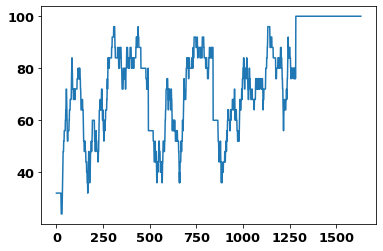

In [37]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

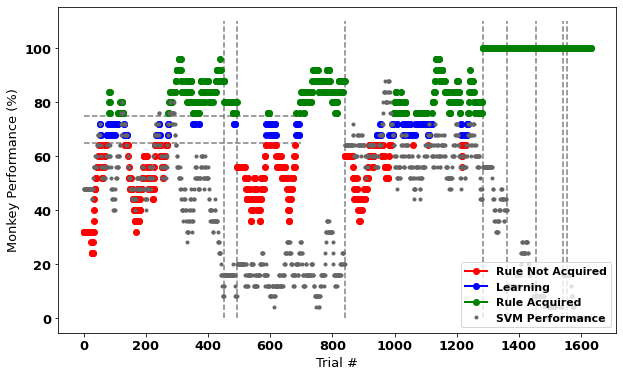

In [38]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
# plt.savefig("monkey_model_performance_J52C.svg")

### Cross Correlation

Pearson Correlation Coefficient: -0.3423365605875398
Spearman Correlation Coefficient: -0.3769781513701286


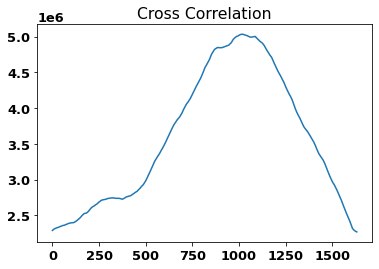

In [39]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


## Block C

### J52_C

In [35]:
test_sess_ix = 3
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_052_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[120 218 312 515 516 599]
sra3_1_j_052_00+
(691,)
(691, 2453, 34)
(691,) 0 7


In [36]:
border = np.array([120, 218, 312, 515, 599])

In [15]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

[LibSVM][LibSVM]

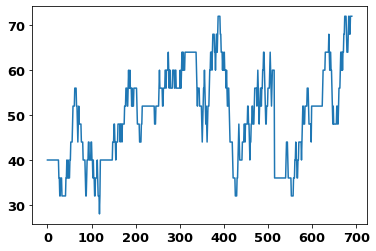

In [37]:
x_tr = np.reshape(_x[:345], (_x[:345].shape[0], -1))
y_tr = _y[:345]
x_val = np.reshape(_x[345:], (_x[345:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[345:], (_x[345:].shape[0], -1))
y_tr = _y[345:]
x_val = np.reshape(_x[:345], (_x[:345].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

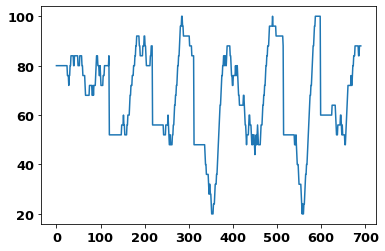

In [38]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

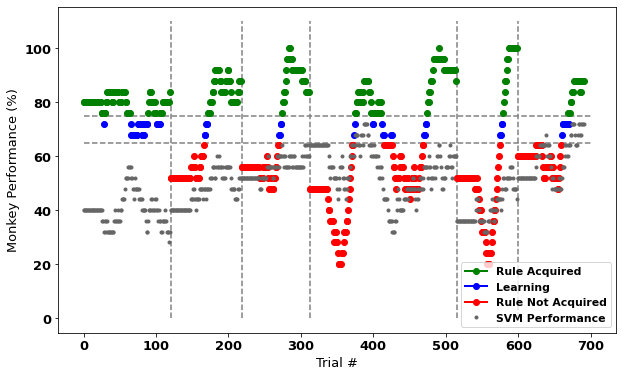

In [39]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
# plt.savefig("monkey_model_performance_J52C.svg")

### Cross Correlation

Pearson Correlation Coefficient: 0.2377973741987274
Spearman Correlation Coefficient: 0.24789845477472552


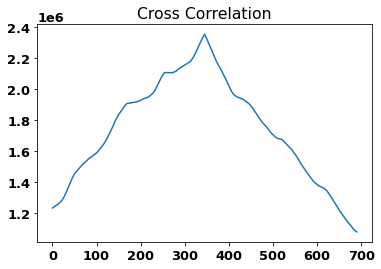

In [46]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### M77_C

In [41]:
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_077_0001_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 178  425 1236 1314 1382]
(1456,)
(1456, 2483, 18)
(1456,) 0 7


In [42]:
border = np.array([178, 425, 1236, 1314, 1382])

In [43]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [44]:
print(np.unique(_y[:700], return_counts=True))
print(np.unique(_y[700:], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([199,  17,  64,  66, 174,  17,  77,  86], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([226,  14,  48,  95, 212,  20,  63,  78], dtype=int64))


[LibSVM][LibSVM]

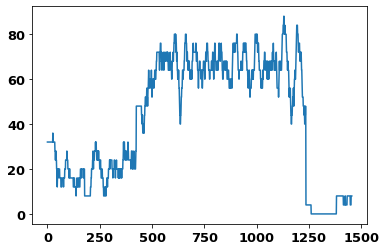

In [45]:
x_tr = np.reshape(_x[:700], (_x[:700].shape[0], -1))
y_tr = _y[:700]
x_val = np.reshape(_x[700:], (_x[700:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[700:], (_x[700:].shape[0], -1))
y_tr = _y[700:]
x_val = np.reshape(_x[:700], (_x[:700].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

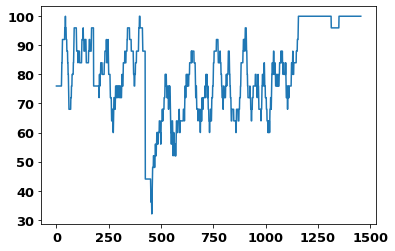

In [46]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

Text(0.5, 1.0, 'Block C, Monkey M, Session 77')

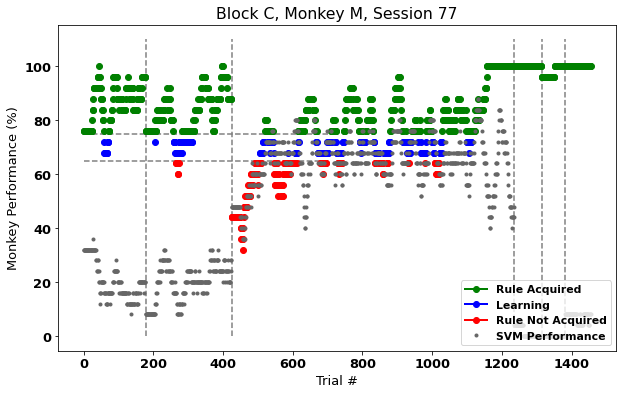

In [47]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block C, Monkey M, Session 77")

# plt.savefig("monkey_model_performance_J52C.svg")

### Cross Correlation

Pearson Correlation Coefficient: -0.46786505799501876
Spearman Correlation Coefficient: -0.4513290927430575


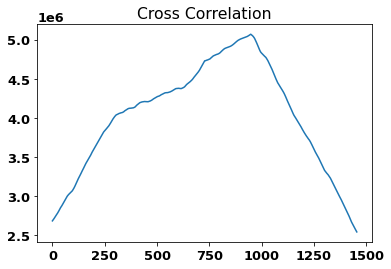

In [48]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


### M83_C

In [51]:
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_m_083_0001_segmented_new.h5'
segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
kernel = signal.gaussian(100, 20)
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(outcome.shape)
print(X.shape)
print(Y.shape, min(Y), max(Y))

[ 361  362  575 1302 1362 1432]
(1494,)
(1494, 2483, 32)
(1494,) 0 7


In [52]:
border = np.array([ 361, 575, 1302, 1362, 1432])

In [53]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [54]:
print(np.unique(_y[:750], return_counts=True))
print(np.unique(_y[750:], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 83,  12,  98, 162,  80,  16, 122, 177], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64), array([ 56,  21,  91, 205,  64,  12, 111, 184], dtype=int64))


[LibSVM][LibSVM]

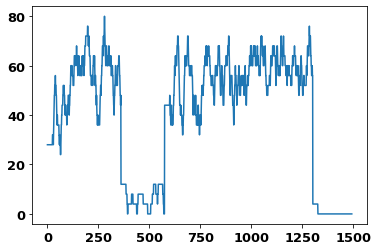

In [55]:
x_tr = np.reshape(_x[:750], (_x[:750].shape[0], -1))
y_tr = _y[:750]
x_val = np.reshape(_x[750:], (_x[750:].shape[0], -1))
true_y = Y

clf = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y1 = clf.predict(x_val)

x_tr = np.reshape(_x[750:], (_x[750:].shape[0], -1))
y_tr = _y[750:]
x_val = np.reshape(_x[:750], (_x[:750].shape[0], -1))

clf2 = SVC(random_state=0, verbose=1).fit(x_tr, y_tr)
pred_y2 = clf2.predict(x_val)

_pred_y = np.concatenate((pred_y2, pred_y1))
pred_y = np.zeros_like(_pred_y)
for i in range(len(pred_y)):
    pred_y[order[i]] = _pred_y[i]

perf = (pred_y == true_y).astype(int)

mod_perf = np.zeros(len(perf))
cor = 0
b=0
tot = 25
for i in range(tot):
    if perf[i]==1:
        cor += 1

mod_perf[:tot] = 100 * (cor / tot)
i = tot
while i<len(perf):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if perf[i+j]==1:
                cor += 1
        mod_perf[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif perf[i] == perf[i-tot]:
        mod_perf[i] = mod_perf[i-1]
        i += 1
    elif perf[i]==1:
        cor += 1
        mod_perf[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        mod_perf[i] = 100 * (cor / tot)
        i +=1

for i in range(len(mod_perf)):
    if mod_perf[i]<0:
        mod_perf[i] = 0
plt.plot(mod_perf)

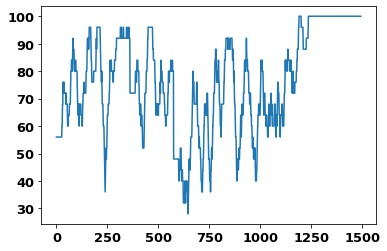

In [56]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

Text(0.5, 1.0, 'Block C, Monkey M, Session 83')

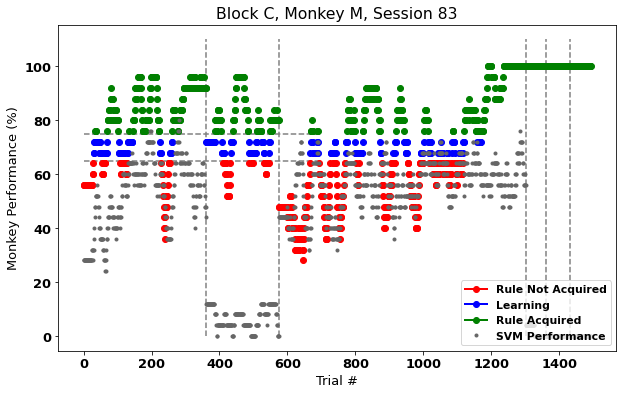

In [57]:
font = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(10,6))
first = np.zeros(3)


for i in range(len(m_performance)):
    if m_performance[i] > 75:
        if (first[0] == 0):
            ax.plot(i, m_performance[i], 'go-', linewidth=2, label='Rule Acquired')
            first[0] = 1
        else:
            ax.plot(i, m_performance[i], 'go-', linewidth=2)
            
                
    elif m_performance[i] < 65:
        if (first[1] == 0):
            ax.plot(i, m_performance[i], 'ro-', linewidth=2, label='Rule Not Acquired')
            first[1] = 1
        else:
            ax.plot(i, m_performance[i], 'ro-', linewidth=2)
    else:
        if (first[2] == 0):
            ax.plot(i, m_performance[i], 'bo-', linewidth=2, label='Learning')
            first[2] = 1
        else:
            ax.plot(i, m_performance[i], 'bo-', linewidth=2)


for i in range(0, len(mod_perf)):
    if (i==0):
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4), label='SVM Performance')
    else:
        ax.plot(i, mod_perf[i], 'k.', linewidth=1, color=(0.4, 0.4, 0.4))

for i in range(len(border)):
    ax.vlines(x=border[i], ymin=0, ymax=110, linestyles='dashed', colors='grey')
    
ax.hlines(y=65, xmin=0, xmax=700, linestyles='dashed', colors='grey')
ax.hlines(y=75, xmin=0, xmax=700, linestyles='dashed', colors='grey')

plt.ylabel("Monkey Performance (%)")
plt.xlabel("Trial #")
ax.legend(loc='lower right', fontsize='small')
plt.title("Block C, Monkey M, Session 83")

# plt.savefig("monkey_model_performance_J52C.svg")

### Cross Correlation

Pearson Correlation Coefficient: -0.26114698984765555
Spearman Correlation Coefficient: -0.17737129688736644


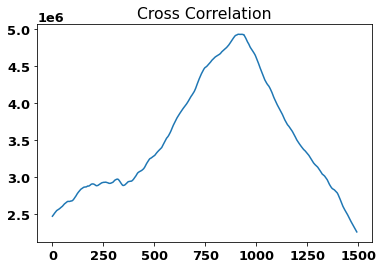

In [58]:
svm_corr = signal.correlate(m_performance, mod_perf, mode='same', method='auto')
pearson, _ = stats.pearsonr(m_performance, mod_perf)
spearman, _ = stats.spearmanr(m_performance, mod_perf, axis=0, nan_policy='omit')
plt.plot(svm_corr)
plt.title("Cross Correlation")
print(f'Pearson Correlation Coefficient: {pearson}')
print(f'Spearman Correlation Coefficient: {spearman}')


# Rule Decoding

## Session J50A

In [3]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_050_00_segmented_v2.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[ 72  73 145 177 178 276 422 426 476 516 565 566 567 597 598 602]
sra3_1_j_050_00+
(663,)
(663, 36, 123)
(663,) 0 7


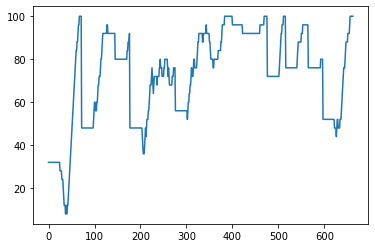

In [6]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [5]:
border = np.array([72, 145, 177, 276, 422, 476, 516, 565, 597])

In [12]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='DD' and color[i]=='g'):
        label[i] = 12
    elif (target[i]=='UU' and color[i]=='b'):
        label[i] = 1
    elif (target[i]=='DR' and color[i]=='r'):
        label[i] = 2
    elif (target[i]=='UL' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='DL' and color[i]=='b'):
        label[i] = 4
    elif (target[i]=='UR' and color[i]=='g'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='r'):
        label[i] = 6
    elif (target[i]=='RR' and color[i]=='g'):
        label[i] = 7
    elif (target[i]=='UU' and color[i]=='r'):
        label[i] = 8
    elif (target[i]=='DR' and color[i]=='g'):
        label[i] = 9
    elif (target[i]=='DL' and color[i]=='r'):
        label[i] = 10
    elif (target[i]=='UR' and color[i]=='r'):
        label[i] = 11

In [16]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==12).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(655, 36, 123) (655,) (655,)


## All trials

In [8]:
print(np.unique(new_label, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64), array([ 63,  53,  35,  65,  94,  52,  97, 100,  29,  23,  21,  23],
      dtype=int64))


In [9]:
hist, acc, y_pred, y_true = kfold_pred(sess_id,new_X,new_label, verbose=1)

	Split 1 of 10
Epoch 1/150
34/36 [===========================>..] - ETA: 0s - loss: 2.6725 - accuracy: 0.1526
Epoch 00001: val_accuracy improved from -inf to 0.15152, saving model to mon_v_mod_sra3_1_j_050_00+_split0.h5
36/36 [==============================] - 1s 35ms/step - loss: 2.6590 - accuracy: 0.1597 - val_loss: 2.5025 - val_accuracy: 0.1515
Epoch 2/150
34/36 [===========================>..] - ETA: 0s - loss: 2.2328 - accuracy: 0.3640
Epoch 00002: val_accuracy improved from 0.15152 to 0.27273, saving model to mon_v_mod_sra3_1_j_050_00+_split0.h5
36/36 [==============================] - 1s 22ms/step - loss: 2.2226 - accuracy: 0.3733 - val_loss: 2.4126 - val_accuracy: 0.2727
Epoch 3/150
34/36 [===========================>..] - ETA: 0s - loss: 2.0319 - accuracy: 0.4449
Epoch 00003: val_accuracy improved from 0.27273 to 0.51515, saving model to mon_v_mod_sra3_1_j_050_00+_split0.h5
36/36 [==============================] - 1s 22ms/step - loss: 2.0350 - accuracy: 0.4444 - val_loss: 2.27

Epoch 56/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4147 - accuracy: 0.7445
Epoch 00056: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 22ms/step - loss: 1.4212 - accuracy: 0.7431 - val_loss: 1.2980 - val_accuracy: 0.8030
Epoch 57/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3959 - accuracy: 0.7831
Epoch 00057: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 22ms/step - loss: 1.3959 - accuracy: 0.7760 - val_loss: 1.3414 - val_accuracy: 0.8030
Epoch 58/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4647 - accuracy: 0.7335
Epoch 00058: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 22ms/step - loss: 1.4580 - accuracy: 0.7361 - val_loss: 1.2828 - val_accuracy: 0.8182
Epoch 59/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3998 - accuracy: 0.7592
Epoch 00059: val_accuracy did not improve from 0.86364
36/36 

Epoch 114/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3016 - accuracy: 0.8199
Epoch 00114: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 22ms/step - loss: 1.3002 - accuracy: 0.8229 - val_loss: 1.3202 - val_accuracy: 0.8182
Epoch 115/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3514 - accuracy: 0.7941
Epoch 00115: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 22ms/step - loss: 1.3441 - accuracy: 0.7969 - val_loss: 1.2721 - val_accuracy: 0.8485
Epoch 116/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3191 - accuracy: 0.8217
Epoch 00116: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 23ms/step - loss: 1.3136 - accuracy: 0.8264 - val_loss: 1.3076 - val_accuracy: 0.8030
Epoch 117/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3095 - accuracy: 0.8327
Epoch 00117: val_accuracy did not improve from 0.86364
36

34/36 [===========================>..] - ETA: 0s - loss: 1.5755 - accuracy: 0.6618
Epoch 00020: val_accuracy did not improve from 0.80303
36/36 [==============================] - 1s 22ms/step - loss: 1.5666 - accuracy: 0.6667 - val_loss: 1.3574 - val_accuracy: 0.8030
Epoch 21/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5970 - accuracy: 0.6783
Epoch 00021: val_accuracy did not improve from 0.80303
36/36 [==============================] - 1s 22ms/step - loss: 1.5905 - accuracy: 0.6823 - val_loss: 1.3701 - val_accuracy: 0.7879
Epoch 22/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5697 - accuracy: 0.6618
Epoch 00022: val_accuracy did not improve from 0.80303
36/36 [==============================] - 1s 22ms/step - loss: 1.5673 - accuracy: 0.6667 - val_loss: 1.3577 - val_accuracy: 0.7727
Epoch 23/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5566 - accuracy: 0.6673
Epoch 00023: val_accuracy improved from 0.80303 to 0.81818, saving model t

Epoch 49/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4463 - accuracy: 0.7371
Epoch 00049: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 22ms/step - loss: 1.4415 - accuracy: 0.7378 - val_loss: 1.2574 - val_accuracy: 0.8182
Epoch 50/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5130 - accuracy: 0.6967
Epoch 00050: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 22ms/step - loss: 1.5060 - accuracy: 0.7014 - val_loss: 1.2458 - val_accuracy: 0.8333
Epoch 51/150
36/36 [==============================] - ETA: 0s - loss: 1.4547 - accuracy: 0.7274
Epoch 00051: val_accuracy did not improve from 0.86364
36/36 [==============================] - 1s 22ms/step - loss: 1.4547 - accuracy: 0.7274 - val_loss: 1.2119 - val_accuracy: 0.8636
Epoch 52/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4146 - accuracy: 0.7463
Epoch 00052: val_accuracy did not improve from 0.86364
36/36 

Epoch 78/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3524 - accuracy: 0.7794
Epoch 00078: val_accuracy did not improve from 0.89394
36/36 [==============================] - 1s 22ms/step - loss: 1.3472 - accuracy: 0.7830 - val_loss: 1.2282 - val_accuracy: 0.8636
Epoch 79/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3592 - accuracy: 0.7923
Epoch 00079: val_accuracy did not improve from 0.89394
36/36 [==============================] - 1s 22ms/step - loss: 1.3680 - accuracy: 0.7865 - val_loss: 1.2408 - val_accuracy: 0.8333
Epoch 80/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3575 - accuracy: 0.7868
Epoch 00080: val_accuracy did not improve from 0.89394
36/36 [==============================] - 1s 22ms/step - loss: 1.3589 - accuracy: 0.7865 - val_loss: 1.2300 - val_accuracy: 0.8333
Epoch 81/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3293 - accuracy: 0.8033
Epoch 00081: val_accuracy did not improve from 0.89394
36/36 

34/36 [===========================>..] - ETA: 0s - loss: 1.2975 - accuracy: 0.8309
Epoch 00136: val_accuracy did not improve from 0.89394
36/36 [==============================] - 1s 22ms/step - loss: 1.3063 - accuracy: 0.8229 - val_loss: 1.2591 - val_accuracy: 0.8333
Epoch 137/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2918 - accuracy: 0.8438
Epoch 00137: val_accuracy did not improve from 0.89394
36/36 [==============================] - 1s 22ms/step - loss: 1.2940 - accuracy: 0.8438 - val_loss: 1.2431 - val_accuracy: 0.7879
Epoch 138/150
36/36 [==============================] - ETA: 0s - loss: 1.2803 - accuracy: 0.8385
Epoch 00138: val_accuracy did not improve from 0.89394
36/36 [==============================] - 1s 23ms/step - loss: 1.2803 - accuracy: 0.8385 - val_loss: 1.2332 - val_accuracy: 0.8182
Epoch 139/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2778 - accuracy: 0.8309
Epoch 00139: val_accuracy did not improve from 0.89394
36/36 [=========

Epoch 42/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4405 - accuracy: 0.7426
Epoch 00042: val_accuracy did not improve from 0.74242
36/36 [==============================] - 1s 22ms/step - loss: 1.4354 - accuracy: 0.7500 - val_loss: 1.4607 - val_accuracy: 0.7273
Epoch 43/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4156 - accuracy: 0.7757
Epoch 00043: val_accuracy did not improve from 0.74242
36/36 [==============================] - 1s 22ms/step - loss: 1.4169 - accuracy: 0.7743 - val_loss: 1.4856 - val_accuracy: 0.7121
Epoch 44/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4392 - accuracy: 0.7243
Epoch 00044: val_accuracy did not improve from 0.74242
36/36 [==============================] - 1s 22ms/step - loss: 1.4390 - accuracy: 0.7257 - val_loss: 1.4295 - val_accuracy: 0.7121
Epoch 45/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3950 - accuracy: 0.7555
Epoch 00045: val_accuracy did not improve from 0.74242
36/36 

Epoch 71/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3359 - accuracy: 0.7776
Epoch 00071: val_accuracy did not improve from 0.81818
36/36 [==============================] - 1s 23ms/step - loss: 1.3328 - accuracy: 0.7812 - val_loss: 1.3937 - val_accuracy: 0.7727
Epoch 72/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3659 - accuracy: 0.7923
Epoch 00072: val_accuracy did not improve from 0.81818
36/36 [==============================] - 1s 22ms/step - loss: 1.3674 - accuracy: 0.7899 - val_loss: 1.4543 - val_accuracy: 0.7121
Epoch 73/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3435 - accuracy: 0.7904
Epoch 00073: val_accuracy did not improve from 0.81818
36/36 [==============================] - 1s 22ms/step - loss: 1.3345 - accuracy: 0.8003 - val_loss: 1.4299 - val_accuracy: 0.7273
Epoch 74/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2998 - accuracy: 0.8180
Epoch 00074: val_accuracy did not improve from 0.81818
36/36 

Epoch 129/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3203 - accuracy: 0.8254
Epoch 00129: val_accuracy did not improve from 0.83333
36/36 [==============================] - 1s 22ms/step - loss: 1.3181 - accuracy: 0.8264 - val_loss: 1.4228 - val_accuracy: 0.7424
Epoch 130/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3171 - accuracy: 0.8015
Epoch 00130: val_accuracy did not improve from 0.83333
36/36 [==============================] - 1s 22ms/step - loss: 1.3097 - accuracy: 0.8073 - val_loss: 1.4034 - val_accuracy: 0.7424
Epoch 131/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2741 - accuracy: 0.8364
Epoch 00131: val_accuracy did not improve from 0.83333
36/36 [==============================] - 1s 22ms/step - loss: 1.2768 - accuracy: 0.8368 - val_loss: 1.4081 - val_accuracy: 0.7576
Epoch 132/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3214 - accuracy: 0.8125
Epoch 00132: val_accuracy did not improve from 0.83333
36

Epoch 7/150
34/36 [===========================>..] - ETA: 0s - loss: 1.7557 - accuracy: 0.5423
Epoch 00007: val_accuracy improved from 0.62121 to 0.69697, saving model to mon_v_mod_sra3_1_j_050_00+_split3.h5
36/36 [==============================] - 1s 23ms/step - loss: 1.7648 - accuracy: 0.5347 - val_loss: 1.9046 - val_accuracy: 0.6970
Epoch 8/150
34/36 [===========================>..] - ETA: 0s - loss: 1.7132 - accuracy: 0.5993
Epoch 00008: val_accuracy improved from 0.69697 to 0.74242, saving model to mon_v_mod_sra3_1_j_050_00+_split3.h5
36/36 [==============================] - 1s 22ms/step - loss: 1.7151 - accuracy: 0.5972 - val_loss: 1.8141 - val_accuracy: 0.7424
Epoch 9/150
34/36 [===========================>..] - ETA: 0s - loss: 1.6955 - accuracy: 0.5974
Epoch 00009: val_accuracy did not improve from 0.74242
36/36 [==============================] - 1s 21ms/step - loss: 1.6855 - accuracy: 0.6007 - val_loss: 1.7476 - val_accuracy: 0.6970
Epoch 10/150
34/36 [========================

Epoch 35/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4740 - accuracy: 0.7279
Epoch 00035: val_accuracy did not improve from 0.84848
36/36 [==============================] - 1s 22ms/step - loss: 1.4836 - accuracy: 0.7274 - val_loss: 1.4077 - val_accuracy: 0.6818
Epoch 36/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4664 - accuracy: 0.7077
Epoch 00036: val_accuracy did not improve from 0.84848
36/36 [==============================] - 1s 22ms/step - loss: 1.4656 - accuracy: 0.7118 - val_loss: 1.3541 - val_accuracy: 0.7424
Epoch 37/150
35/36 [============================>.] - ETA: 0s - loss: 1.4822 - accuracy: 0.7214
Epoch 00037: val_accuracy did not improve from 0.84848
36/36 [==============================] - 1s 23ms/step - loss: 1.4807 - accuracy: 0.7188 - val_loss: 1.3925 - val_accuracy: 0.7727
Epoch 38/150
36/36 [==============================] - ETA: 0s - loss: 1.4657 - accuracy: 0.7170
Epoch 00038: val_accuracy did not improve from 0.84848
36/36 

34/36 [===========================>..] - ETA: 0s - loss: 1.2988 - accuracy: 0.8162
Epoch 00093: val_accuracy did not improve from 0.84848
36/36 [==============================] - 1s 23ms/step - loss: 1.3054 - accuracy: 0.8160 - val_loss: 1.3609 - val_accuracy: 0.7121
Epoch 94/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2918 - accuracy: 0.8309
Epoch 00094: val_accuracy did not improve from 0.84848
36/36 [==============================] - 1s 23ms/step - loss: 1.2912 - accuracy: 0.8316 - val_loss: 1.3607 - val_accuracy: 0.7576
Epoch 95/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3253 - accuracy: 0.8290
Epoch 00095: val_accuracy did not improve from 0.84848
36/36 [==============================] - 1s 23ms/step - loss: 1.3232 - accuracy: 0.8299 - val_loss: 1.3886 - val_accuracy: 0.7576
Epoch 96/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3108 - accuracy: 0.8180
Epoch 00096: val_accuracy did not improve from 0.84848
36/36 [============

34/36 [===========================>..] - ETA: 0s - loss: 2.6498 - accuracy: 0.1581
Epoch 00001: val_accuracy improved from -inf to 0.27273, saving model to mon_v_mod_sra3_1_j_050_00+_split4.h5
36/36 [==============================] - 1s 34ms/step - loss: 2.6339 - accuracy: 0.1632 - val_loss: 2.4974 - val_accuracy: 0.2727
Epoch 2/150
34/36 [===========================>..] - ETA: 0s - loss: 2.2368 - accuracy: 0.3327
Epoch 00002: val_accuracy improved from 0.27273 to 0.31818, saving model to mon_v_mod_sra3_1_j_050_00+_split4.h5
36/36 [==============================] - 1s 23ms/step - loss: 2.2282 - accuracy: 0.3385 - val_loss: 2.4268 - val_accuracy: 0.3182
Epoch 3/150
34/36 [===========================>..] - ETA: 0s - loss: 2.0348 - accuracy: 0.4504
Epoch 00003: val_accuracy did not improve from 0.31818
36/36 [==============================] - 1s 22ms/step - loss: 2.0237 - accuracy: 0.4566 - val_loss: 2.3017 - val_accuracy: 0.3182
Epoch 4/150
34/36 [===========================>..] - ETA: 0

Epoch 29/150
36/36 [==============================] - ETA: 0s - loss: 1.5068 - accuracy: 0.7101
Epoch 00029: val_accuracy did not improve from 0.71212
36/36 [==============================] - 1s 24ms/step - loss: 1.5068 - accuracy: 0.7101 - val_loss: 1.4600 - val_accuracy: 0.6970
Epoch 30/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5048 - accuracy: 0.6893
Epoch 00030: val_accuracy did not improve from 0.71212
36/36 [==============================] - 1s 24ms/step - loss: 1.5049 - accuracy: 0.6858 - val_loss: 1.4227 - val_accuracy: 0.7121
Epoch 31/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4883 - accuracy: 0.7132
Epoch 00031: val_accuracy did not improve from 0.71212
36/36 [==============================] - 1s 24ms/step - loss: 1.4904 - accuracy: 0.7118 - val_loss: 1.4345 - val_accuracy: 0.6970
Epoch 32/150
35/36 [============================>.] - ETA: 0s - loss: 1.4874 - accuracy: 0.7357
Epoch 00032: val_accuracy did not improve from 0.71212
36/36 

Epoch 58/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3979 - accuracy: 0.7757
Epoch 00058: val_accuracy did not improve from 0.72727
36/36 [==============================] - 1s 24ms/step - loss: 1.4029 - accuracy: 0.7726 - val_loss: 1.3966 - val_accuracy: 0.7273
Epoch 59/150
36/36 [==============================] - ETA: 0s - loss: 1.3927 - accuracy: 0.7569 ETA: 0s - loss: 1.3968 - accuracy: 0.
Epoch 00059: val_accuracy did not improve from 0.72727
36/36 [==============================] - 1s 24ms/step - loss: 1.3927 - accuracy: 0.7569 - val_loss: 1.4299 - val_accuracy: 0.7273
Epoch 60/150
35/36 [============================>.] - ETA: 0s - loss: 1.4219 - accuracy: 0.7571
Epoch 00060: val_accuracy did not improve from 0.72727
36/36 [==============================] - 1s 24ms/step - loss: 1.4309 - accuracy: 0.7569 - val_loss: 1.4419 - val_accuracy: 0.6818
Epoch 61/150
36/36 [==============================] - ETA: 0s - loss: 1.4430 - accuracy: 0.7292
Epoch 00061: val_accura

Epoch 87/150
35/36 [============================>.] - ETA: 0s - loss: 1.3502 - accuracy: 0.8143
Epoch 00087: val_accuracy did not improve from 0.75758
36/36 [==============================] - 1s 28ms/step - loss: 1.3519 - accuracy: 0.8125 - val_loss: 1.4705 - val_accuracy: 0.7424
Epoch 88/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3665 - accuracy: 0.8033
Epoch 00088: val_accuracy did not improve from 0.75758
36/36 [==============================] - 1s 25ms/step - loss: 1.3577 - accuracy: 0.8073 - val_loss: 1.4426 - val_accuracy: 0.7121
Epoch 89/150
35/36 [============================>.] - ETA: 0s - loss: 1.3819 - accuracy: 0.7750
Epoch 00089: val_accuracy did not improve from 0.75758
36/36 [==============================] - 1s 25ms/step - loss: 1.3855 - accuracy: 0.7726 - val_loss: 1.5009 - val_accuracy: 0.6818
Epoch 90/150
35/36 [============================>.] - ETA: 0s - loss: 1.3510 - accuracy: 0.7911
Epoch 00090: val_accuracy did not improve from 0.75758
36/36 

Epoch 116/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3427 - accuracy: 0.7960
Epoch 00116: val_accuracy did not improve from 0.77273
36/36 [==============================] - 1s 23ms/step - loss: 1.3308 - accuracy: 0.8038 - val_loss: 1.4797 - val_accuracy: 0.7121
Epoch 117/150
36/36 [==============================] - ETA: 0s - loss: 1.3075 - accuracy: 0.8212
Epoch 00117: val_accuracy did not improve from 0.77273
36/36 [==============================] - 1s 23ms/step - loss: 1.3075 - accuracy: 0.8212 - val_loss: 1.4567 - val_accuracy: 0.7121
Epoch 118/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3129 - accuracy: 0.8162
Epoch 00118: val_accuracy did not improve from 0.77273
36/36 [==============================] - 1s 23ms/step - loss: 1.3116 - accuracy: 0.8160 - val_loss: 1.5396 - val_accuracy: 0.7273
Epoch 119/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2997 - accuracy: 0.8290
Epoch 00119: val_accuracy did not improve from 0.77273
36

35/36 [============================>.] - ETA: 0s - loss: 1.5329 - accuracy: 0.6875
Epoch 00022: val_accuracy did not improve from 0.75385
36/36 [==============================] - 1s 24ms/step - loss: 1.5313 - accuracy: 0.6892 - val_loss: 1.4984 - val_accuracy: 0.7538
Epoch 23/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4980 - accuracy: 0.7114
Epoch 00023: val_accuracy improved from 0.75385 to 0.76923, saving model to mon_v_mod_sra3_1_j_050_00+_split5.h5
36/36 [==============================] - 1s 25ms/step - loss: 1.5110 - accuracy: 0.7049 - val_loss: 1.4912 - val_accuracy: 0.7692
Epoch 24/150
36/36 [==============================] - ETA: 0s - loss: 1.5126 - accuracy: 0.6910
Epoch 00024: val_accuracy did not improve from 0.76923
36/36 [==============================] - 1s 23ms/step - loss: 1.5126 - accuracy: 0.6910 - val_loss: 1.4790 - val_accuracy: 0.6462
Epoch 25/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5024 - accuracy: 0.7188
Epoch 00025: val

Epoch 51/150
36/36 [==============================] - ETA: 0s - loss: 1.3932 - accuracy: 0.7743
Epoch 00051: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 24ms/step - loss: 1.3932 - accuracy: 0.7743 - val_loss: 1.4456 - val_accuracy: 0.7385
Epoch 52/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3731 - accuracy: 0.7868
Epoch 00052: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 23ms/step - loss: 1.3736 - accuracy: 0.7865 - val_loss: 1.4385 - val_accuracy: 0.7385
Epoch 53/150
35/36 [============================>.] - ETA: 0s - loss: 1.4138 - accuracy: 0.7464
Epoch 00053: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 24ms/step - loss: 1.4152 - accuracy: 0.7465 - val_loss: 1.4110 - val_accuracy: 0.7538
Epoch 54/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3957 - accuracy: 0.7647
Epoch 00054: val_accuracy did not improve from 0.80000
36/36 

Epoch 109/150
36/36 [==============================] - ETA: 0s - loss: 1.2717 - accuracy: 0.8438
Epoch 00109: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 24ms/step - loss: 1.2717 - accuracy: 0.8438 - val_loss: 1.5052 - val_accuracy: 0.7231
Epoch 110/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3020 - accuracy: 0.8162
Epoch 00110: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 24ms/step - loss: 1.3055 - accuracy: 0.8125 - val_loss: 1.5062 - val_accuracy: 0.7231
Epoch 111/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2920 - accuracy: 0.8199
Epoch 00111: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 23ms/step - loss: 1.2961 - accuracy: 0.8177 - val_loss: 1.4646 - val_accuracy: 0.7385
Epoch 112/150
36/36 [==============================] - ETA: 0s - loss: 1.2915 - accuracy: 0.8368
Epoch 00112: val_accuracy did not improve from 0.81538
36

Epoch 16/150
34/36 [===========================>..] - ETA: 0s - loss: 1.6228 - accuracy: 0.6489
Epoch 00016: val_accuracy did not improve from 0.69231
36/36 [==============================] - 1s 23ms/step - loss: 1.6199 - accuracy: 0.6493 - val_loss: 1.4993 - val_accuracy: 0.6769
Epoch 17/150
34/36 [===========================>..] - ETA: 0s - loss: 1.6410 - accuracy: 0.6195
Epoch 00017: val_accuracy did not improve from 0.69231
36/36 [==============================] - 1s 23ms/step - loss: 1.6367 - accuracy: 0.6250 - val_loss: 1.4798 - val_accuracy: 0.6923
Epoch 18/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5679 - accuracy: 0.6654
Epoch 00018: val_accuracy did not improve from 0.69231
36/36 [==============================] - 1s 23ms/step - loss: 1.5652 - accuracy: 0.6684 - val_loss: 1.4753 - val_accuracy: 0.6923
Epoch 19/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5574 - accuracy: 0.6728
Epoch 00019: val_accuracy did not improve from 0.69231
36/36 

Epoch 73/150
36/36 [==============================] - ETA: 0s - loss: 1.3541 - accuracy: 0.7691
Epoch 00073: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 23ms/step - loss: 1.3541 - accuracy: 0.7691 - val_loss: 1.4938 - val_accuracy: 0.6923
Epoch 74/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3654 - accuracy: 0.7776
Epoch 00074: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 23ms/step - loss: 1.3594 - accuracy: 0.7812 - val_loss: 1.3991 - val_accuracy: 0.7538
Epoch 75/150
36/36 [==============================] - ETA: 0s - loss: 1.3450 - accuracy: 0.7951
Epoch 00075: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 23ms/step - loss: 1.3450 - accuracy: 0.7951 - val_loss: 1.4401 - val_accuracy: 0.7385
Epoch 76/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3686 - accuracy: 0.7757
Epoch 00076: val_accuracy did not improve from 0.80000
36/36 

36/36 [==============================] - ETA: 0s - loss: 1.2999 - accuracy: 0.8351
Epoch 00131: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 23ms/step - loss: 1.2999 - accuracy: 0.8351 - val_loss: 1.4809 - val_accuracy: 0.6769
Epoch 132/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3042 - accuracy: 0.8290
Epoch 00132: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 23ms/step - loss: 1.2989 - accuracy: 0.8351 - val_loss: 1.4910 - val_accuracy: 0.7077
Epoch 133/150
36/36 [==============================] - ETA: 0s - loss: 1.2889 - accuracy: 0.8524
Epoch 00133: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 24ms/step - loss: 1.2889 - accuracy: 0.8524 - val_loss: 1.5093 - val_accuracy: 0.7077
Epoch 134/150
36/36 [==============================] - ETA: 0s - loss: 1.3159 - accuracy: 0.8108
Epoch 00134: val_accuracy did not improve from 0.80000
36/36 [=========

Epoch 9/150
34/36 [===========================>..] - ETA: 0s - loss: 1.6866 - accuracy: 0.5864
Epoch 00009: val_accuracy did not improve from 0.63077
36/36 [==============================] - 1s 22ms/step - loss: 1.6817 - accuracy: 0.5920 - val_loss: 1.7902 - val_accuracy: 0.6000
Epoch 10/150
34/36 [===========================>..] - ETA: 0s - loss: 1.6810 - accuracy: 0.6305
Epoch 00010: val_accuracy did not improve from 0.63077
36/36 [==============================] - 1s 22ms/step - loss: 1.6766 - accuracy: 0.6285 - val_loss: 1.7110 - val_accuracy: 0.5846
Epoch 11/150
36/36 [==============================] - ETA: 0s - loss: 1.6692 - accuracy: 0.6128
Epoch 00011: val_accuracy did not improve from 0.63077
36/36 [==============================] - 1s 23ms/step - loss: 1.6692 - accuracy: 0.6128 - val_loss: 1.6344 - val_accuracy: 0.6000
Epoch 12/150
34/36 [===========================>..] - ETA: 0s - loss: 1.6351 - accuracy: 0.5974
Epoch 00012: val_accuracy improved from 0.63077 to 0.64615, sa

Epoch 37/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4631 - accuracy: 0.7169
Epoch 00037: val_accuracy did not improve from 0.75385
36/36 [==============================] - 1s 23ms/step - loss: 1.4626 - accuracy: 0.7188 - val_loss: 1.4782 - val_accuracy: 0.6923
Epoch 38/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4679 - accuracy: 0.7077
Epoch 00038: val_accuracy did not improve from 0.75385
36/36 [==============================] - 1s 23ms/step - loss: 1.4641 - accuracy: 0.7083 - val_loss: 1.4431 - val_accuracy: 0.6769
Epoch 39/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4523 - accuracy: 0.7390
Epoch 00039: val_accuracy did not improve from 0.75385
36/36 [==============================] - 1s 23ms/step - loss: 1.4444 - accuracy: 0.7431 - val_loss: 1.4141 - val_accuracy: 0.7231
Epoch 40/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4156 - accuracy: 0.7426
Epoch 00040: val_accuracy did not improve from 0.75385
36/36 

Epoch 66/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3762 - accuracy: 0.7739
Epoch 00066: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 23ms/step - loss: 1.3863 - accuracy: 0.7674 - val_loss: 1.3778 - val_accuracy: 0.7538
Epoch 67/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3756 - accuracy: 0.7812
Epoch 00067: val_accuracy improved from 0.78462 to 0.80000, saving model to mon_v_mod_sra3_1_j_050_00+_split7.h5
36/36 [==============================] - 1s 24ms/step - loss: 1.3825 - accuracy: 0.7778 - val_loss: 1.3692 - val_accuracy: 0.8000
Epoch 68/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3948 - accuracy: 0.7610
Epoch 00068: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 23ms/step - loss: 1.3927 - accuracy: 0.7674 - val_loss: 1.3886 - val_accuracy: 0.8000
Epoch 69/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3629 - accuracy: 0.7978
Epo

Epoch 95/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3187 - accuracy: 0.8107
Epoch 00095: val_accuracy did not improve from 0.84615
36/36 [==============================] - 1s 23ms/step - loss: 1.3198 - accuracy: 0.8108 - val_loss: 1.4031 - val_accuracy: 0.7231
Epoch 96/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3164 - accuracy: 0.8254
Epoch 00096: val_accuracy did not improve from 0.84615
36/36 [==============================] - 1s 23ms/step - loss: 1.3180 - accuracy: 0.8264 - val_loss: 1.3842 - val_accuracy: 0.8154
Epoch 97/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3414 - accuracy: 0.7941
Epoch 00097: val_accuracy did not improve from 0.84615
36/36 [==============================] - 1s 23ms/step - loss: 1.3386 - accuracy: 0.7934 - val_loss: 1.3859 - val_accuracy: 0.7846
Epoch 98/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3168 - accuracy: 0.8070
Epoch 00098: val_accuracy did not improve from 0.84615
36/36 

Epoch 3/150
34/36 [===========================>..] - ETA: 0s - loss: 1.9731 - accuracy: 0.4798
Epoch 00003: val_accuracy improved from 0.26154 to 0.30769, saving model to mon_v_mod_sra3_1_j_050_00+_split8.h5
36/36 [==============================] - 1s 24ms/step - loss: 1.9797 - accuracy: 0.4774 - val_loss: 2.3309 - val_accuracy: 0.3077
Epoch 4/150
35/36 [============================>.] - ETA: 0s - loss: 1.9008 - accuracy: 0.5125
Epoch 00004: val_accuracy improved from 0.30769 to 0.50769, saving model to mon_v_mod_sra3_1_j_050_00+_split8.h5
36/36 [==============================] - 1s 24ms/step - loss: 1.8988 - accuracy: 0.5122 - val_loss: 2.2371 - val_accuracy: 0.5077
Epoch 5/150
36/36 [==============================] - ETA: 0s - loss: 1.8694 - accuracy: 0.5000
Epoch 00005: val_accuracy did not improve from 0.50769
36/36 [==============================] - 1s 23ms/step - loss: 1.8694 - accuracy: 0.5000 - val_loss: 2.1298 - val_accuracy: 0.4615
Epoch 6/150
34/36 [=========================

Epoch 59/150
35/36 [============================>.] - ETA: 0s - loss: 1.3777 - accuracy: 0.7643
Epoch 00059: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.3855 - accuracy: 0.7604 - val_loss: 1.5583 - val_accuracy: 0.6769
Epoch 60/150
34/36 [===========================>..] - ETA: 0s - loss: 1.4108 - accuracy: 0.7647
Epoch 00060: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.4044 - accuracy: 0.7708 - val_loss: 1.4254 - val_accuracy: 0.7385
Epoch 61/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3527 - accuracy: 0.7886
Epoch 00061: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.3474 - accuracy: 0.7917 - val_loss: 1.4185 - val_accuracy: 0.7385
Epoch 62/150
35/36 [============================>.] - ETA: 0s - loss: 1.4069 - accuracy: 0.7786
Epoch 00062: val_accuracy did not improve from 0.78462
36/36 

Epoch 88/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3661 - accuracy: 0.7996
Epoch 00088: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 24ms/step - loss: 1.3706 - accuracy: 0.7969 - val_loss: 1.3857 - val_accuracy: 0.7846
Epoch 89/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3253 - accuracy: 0.8143
Epoch 00089: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 24ms/step - loss: 1.3198 - accuracy: 0.8160 - val_loss: 1.4211 - val_accuracy: 0.7077
Epoch 90/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3623 - accuracy: 0.7960
Epoch 00090: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 25ms/step - loss: 1.3677 - accuracy: 0.7917 - val_loss: 1.4163 - val_accuracy: 0.7385
Epoch 91/150
36/36 [==============================] - ETA: 0s - loss: 1.3566 - accuracy: 0.7795
Epoch 00091: val_accuracy did not improve from 0.80000
36/36 

Epoch 117/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2956 - accuracy: 0.8199
Epoch 00117: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 24ms/step - loss: 1.2997 - accuracy: 0.8177 - val_loss: 1.3576 - val_accuracy: 0.7692
Epoch 118/150
36/36 [==============================] - ETA: 0s - loss: 1.3008 - accuracy: 0.8247
Epoch 00118: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 24ms/step - loss: 1.3008 - accuracy: 0.8247 - val_loss: 1.3839 - val_accuracy: 0.8000
Epoch 119/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3344 - accuracy: 0.7960
Epoch 00119: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 24ms/step - loss: 1.3292 - accuracy: 0.7969 - val_loss: 1.3712 - val_accuracy: 0.7231
Epoch 120/150
35/36 [============================>.] - ETA: 0s - loss: 1.3019 - accuracy: 0.8321
Epoch 00120: val_accuracy did not improve from 0.81538
36

Epoch 146/150
36/36 [==============================] - ETA: 0s - loss: 1.3074 - accuracy: 0.8194
Epoch 00146: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 24ms/step - loss: 1.3074 - accuracy: 0.8194 - val_loss: 1.3744 - val_accuracy: 0.7538
Epoch 147/150
35/36 [============================>.] - ETA: 0s - loss: 1.2667 - accuracy: 0.8536
Epoch 00147: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 24ms/step - loss: 1.2704 - accuracy: 0.8507 - val_loss: 1.3966 - val_accuracy: 0.7538
Epoch 148/150
35/36 [============================>.] - ETA: 0s - loss: 1.3250 - accuracy: 0.8196
Epoch 00148: val_accuracy did not improve from 0.81538
36/36 [==============================] - 1s 24ms/step - loss: 1.3254 - accuracy: 0.8194 - val_loss: 1.4077 - val_accuracy: 0.7846
Epoch 149/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3196 - accuracy: 0.8327
Epoch 00149: val_accuracy did not improve from 0.81538
36

Epoch 23/150
35/36 [============================>.] - ETA: 0s - loss: 1.5089 - accuracy: 0.6875
Epoch 00023: val_accuracy did not improve from 0.72308
36/36 [==============================] - 1s 24ms/step - loss: 1.5128 - accuracy: 0.6788 - val_loss: 1.4737 - val_accuracy: 0.7077
Epoch 24/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5188 - accuracy: 0.6875
Epoch 00024: val_accuracy did not improve from 0.72308
36/36 [==============================] - 1s 24ms/step - loss: 1.5215 - accuracy: 0.6840 - val_loss: 1.4789 - val_accuracy: 0.7231
Epoch 25/150
34/36 [===========================>..] - ETA: 0s - loss: 1.5167 - accuracy: 0.6765
Epoch 00025: val_accuracy improved from 0.72308 to 0.73846, saving model to mon_v_mod_sra3_1_j_050_00+_split9.h5
36/36 [==============================] - 1s 25ms/step - loss: 1.5240 - accuracy: 0.6788 - val_loss: 1.4590 - val_accuracy: 0.7385
Epoch 26/150
36/36 [==============================] - ETA: 0s - loss: 1.4946 - accuracy: 0.7205
Epo

36/36 [==============================] - ETA: 0s - loss: 1.3576 - accuracy: 0.7830
Epoch 00080: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.3576 - accuracy: 0.7830 - val_loss: 1.4739 - val_accuracy: 0.7231
Epoch 81/150
36/36 [==============================] - ETA: 0s - loss: 1.3344 - accuracy: 0.7986
Epoch 00081: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.3344 - accuracy: 0.7986 - val_loss: 1.4782 - val_accuracy: 0.7385
Epoch 82/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3035 - accuracy: 0.8346
Epoch 00082: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.3095 - accuracy: 0.8281 - val_loss: 1.5125 - val_accuracy: 0.7231
Epoch 83/150
34/36 [===========================>..] - ETA: 0s - loss: 1.3303 - accuracy: 0.8015
Epoch 00083: val_accuracy did not improve from 0.78462
36/36 [============

36/36 [==============================] - ETA: 0s - loss: 1.2766 - accuracy: 0.8368
Epoch 00109: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.2766 - accuracy: 0.8368 - val_loss: 1.5151 - val_accuracy: 0.6615
Epoch 110/150
34/36 [===========================>..] - ETA: 0s - loss: 1.2903 - accuracy: 0.8309
Epoch 00110: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.2979 - accuracy: 0.8299 - val_loss: 1.5163 - val_accuracy: 0.7077
Epoch 111/150
36/36 [==============================] - ETA: 0s - loss: 1.2803 - accuracy: 0.8351
Epoch 00111: val_accuracy did not improve from 0.78462
36/36 [==============================] - 1s 24ms/step - loss: 1.2803 - accuracy: 0.8351 - val_loss: 1.4897 - val_accuracy: 0.7077
Epoch 112/150
35/36 [============================>.] - ETA: 0s - loss: 1.3025 - accuracy: 0.8268
Epoch 00112: val_accuracy did not improve from 0.78462
36/36 [=========

Epoch 138/150
36/36 [==============================] - ETA: 0s - loss: 1.2777 - accuracy: 0.8333
Epoch 00138: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 24ms/step - loss: 1.2777 - accuracy: 0.8333 - val_loss: 1.4543 - val_accuracy: 0.7385
Epoch 139/150
36/36 [==============================] - ETA: 0s - loss: 1.2595 - accuracy: 0.8542
Epoch 00139: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 24ms/step - loss: 1.2595 - accuracy: 0.8542 - val_loss: 1.5198 - val_accuracy: 0.7077
Epoch 140/150
36/36 [==============================] - ETA: 0s - loss: 1.2561 - accuracy: 0.8420
Epoch 00140: val_accuracy did not improve from 0.80000
36/36 [==============================] - 1s 24ms/step - loss: 1.2561 - accuracy: 0.8420 - val_loss: 1.4781 - val_accuracy: 0.6923
Epoch 141/150
36/36 [==============================] - ETA: 0s - loss: 1.2599 - accuracy: 0.8490
Epoch 00141: val_accuracy did not improve from 0.80000
36

In [10]:
y_pred

array([ 0,  0,  1,  1,  0,  2,  3,  2,  2,  2,  2,  2,  0,  0,  1,  1,  1,
        5,  5,  4,  5,  5,  4,  4,  4,  5,  6,  6,  7,  6,  7,  7,  7,  6,
        7,  7,  7,  6,  6,  7,  6,  7,  6,  7,  7,  6,  8,  0,  0,  8,  8,
        9,  3,  3,  9,  3, 10,  5,  4,  5,  4,  5,  4,  4,  4,  4,  0,  1,
        1,  0,  0,  0,  0,  1,  0,  0,  2,  2,  2,  3,  2,  3,  3,  3,  0,
        5,  4,  4,  4,  5,  5,  4,  4,  5,  5,  4,  4,  4,  4,  7,  7,  6,
        6,  6,  7,  7,  6,  6,  6,  7,  7,  6,  7,  6,  7,  7,  6,  7,  7,
        8,  0,  8,  8,  9,  3,  9,  3, 10, 10,  4, 11, 11,  1,  1,  0,  1,
        0,  0,  0,  1,  1,  3,  3,  2,  2,  2,  3,  3,  0,  1,  4,  5,  5,
        4,  5,  4,  4,  4,  4,  4,  7,  7,  7,  7,  6,  7,  6,  6,  6,  6,
        6,  7,  7,  6,  7,  7,  6,  7,  7,  7,  8,  0,  8,  9,  3,  3,  9,
        9,  9, 10, 10,  5,  9,  5,  4,  4, 11,  4,  0,  1,  0,  0,  1,  3,
        2,  2,  3,  3,  3,  2,  0,  0,  0,  1,  1,  0,  5,  4,  4,  5,  5,
        5,  5,  6,  6,  7

In [11]:
y_true

array([ 0,  0,  1,  1,  0,  3,  3,  2,  3,  2,  2,  2,  1,  0,  1,  1,  0,
       10,  5,  4,  5,  5,  4,  4,  4,  5,  6,  6,  7,  6,  7,  6,  7,  6,
        7,  7,  7,  6,  6,  7,  6,  7,  6,  7,  7,  6,  8,  0,  0,  8,  8,
        9,  3,  3,  9,  3, 10,  5, 11,  4,  4, 11,  4,  4,  4,  4,  0,  0,
        1,  1,  1,  0,  1,  1,  0,  0,  2,  2,  2,  3,  2,  3,  3,  3,  0,
        5,  4,  4,  4,  5,  4,  4,  4,  5,  5,  5,  4,  4,  4,  7,  7,  6,
        6,  6,  7,  6,  6,  6,  6,  7,  7,  6,  7,  6,  7,  7,  6,  7,  7,
        8,  0,  8,  8,  9,  3,  9,  3, 10, 10,  4, 11, 11,  1,  1,  0,  0,
        0,  0,  0,  1,  1,  3,  3,  2,  2,  2,  3,  2,  0,  1,  4,  4,  5,
        4,  5,  4,  4,  4,  4,  5,  7,  6,  6,  7,  6,  7,  6,  6,  6,  6,
        6,  7,  7,  6,  7,  7,  6,  7,  7,  7,  8,  0,  8,  3,  3,  3,  9,
        9,  9,  5, 10,  5, 10,  4, 11,  4, 11,  4,  0,  1,  1,  0,  1,  2,
        2,  2,  3,  3,  3,  2,  0,  1,  0,  1,  1,  0,  5,  4,  4,  5,  5,
        4,  5,  7,  6,  7

In [57]:
y_true == y_pred

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [12]:
a = np.zeros((12, 2))
b = np.zeros((12,12))
for i in range(len(y_true)):
    a[y_true[i], 0] += 1
    if y_true[i] == y_pred[i]:
        a[y_true[i], 1] += 1
        b[y_true[i], y_true[i]] += 1
    else:
        b[y_true[i], y_pred[i]] += 1

In [13]:
for i in range(12):
    print(f'Label {i} Accuracy: {a[i,1]/a[i,0]}')

Label 0 Accuracy: 0.8571428571428571
Label 1 Accuracy: 0.7358490566037735
Label 2 Accuracy: 0.8571428571428571
Label 3 Accuracy: 0.9076923076923077
Label 4 Accuracy: 0.8404255319148937
Label 5 Accuracy: 0.75
Label 6 Accuracy: 0.8865979381443299
Label 7 Accuracy: 0.96
Label 8 Accuracy: 0.7241379310344828
Label 9 Accuracy: 0.8260869565217391
Label 10 Accuracy: 0.6666666666666666
Label 11 Accuracy: 0.30434782608695654


In [18]:
b/np.sum(b, axis=1)

array([[0.85714286, 0.13207547, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06896552, 0.        ,
        0.        , 0.        ],
       [0.22222222, 0.73584906, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.85714286, 0.07692308, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.11428571, 0.90769231, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.08695652,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.84042553,
        0.23076923, 0.        , 0.        , 0.        , 0.        ,
        0.0952381 , 0.04347826],
       [0.01587302, 0.        , 0.        , 0.        , 0.07446809,
        0.75      , 0.        , 0.01      , 0.        , 0.        ,
        0.14285714,

In [4]:
b = np.array([[54.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.],
       [14., 39.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 30.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  4., 59.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 79., 12.,  0.,  0.,  0.,  0.,  2.,  1.],
       [ 1.,  0.,  0.,  0.,  7., 39.,  0.,  1.,  0.,  0.,  3.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 86., 11.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  4., 96.,  0.,  0.,  0.,  0.],
       [ 7.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 21.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  3.,  0.,  0.,  0.,  0.,  0., 19.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  1., 14.,  2.],
       [ 0.,  1.,  0.,  0.,  7.,  5.,  0.,  0.,  0.,  0.,  3.,  7.]])

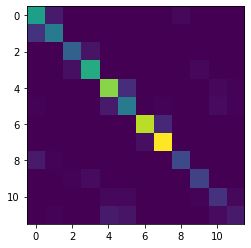

In [5]:
fig, ax = plt.subplots()
im = ax.imshow(b)

In [20]:
np.sum(b,axis=1)

array([ 63.,  53.,  35.,  65.,  94.,  52.,  97., 100.,  29.,  23.,  21.,
        23.])

## Rule Acquired

In [17]:
keep_idx = np.argwhere(new_m_per>75).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(373, 36, 123) (373,)


In [18]:
print(np.unique(RA_Y, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64), array([27, 24, 16, 45, 24, 21, 74, 84,  9, 23, 19,  7], dtype=int64))


In [19]:
hist, acc, y_pred, y_true = kfold_pred(sess_id,RA_X,RA_Y, verbose=1)

C:\ProgramData\Miniconda3\envs\dl\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


	Split 1 of 10
Epoch 1/150
18/20 [==========================>...] - ETA: 0s - loss: 2.7614 - accuracy: 0.1042
Epoch 00001: val_accuracy improved from -inf to 0.07895, saving model to mon_v_mod_sra3_1_j_050_00+_split0.h5
20/20 [==============================] - 1s 51ms/step - loss: 2.7200 - accuracy: 0.1281 - val_loss: 2.5234 - val_accuracy: 0.0789
Epoch 2/150
19/20 [===========================>..] - ETA: 0s - loss: 2.3250 - accuracy: 0.2829 ETA: 0s - loss: 2.4973 - accu
Epoch 00002: val_accuracy improved from 0.07895 to 0.31579, saving model to mon_v_mod_sra3_1_j_050_00+_split0.h5
20/20 [==============================] - 1s 27ms/step - loss: 2.3348 - accuracy: 0.2875 - val_loss: 2.4535 - val_accuracy: 0.3158
Epoch 3/150
19/20 [===========================>..] - ETA: 0s - loss: 2.0882 - accuracy: 0.4211
Epoch 00003: val_accuracy did not improve from 0.31579
20/20 [==============================] - 0s 24ms/step - loss: 2.0921 - accuracy: 0.4281 - val_loss: 2.3792 - val_accuracy: 0.2632
Ep

Epoch 57/150
20/20 [==============================] - ETA: 0s - loss: 1.3353 - accuracy: 0.8438
Epoch 00057: val_accuracy did not improve from 0.84211
20/20 [==============================] - 0s 24ms/step - loss: 1.3353 - accuracy: 0.8438 - val_loss: 1.2869 - val_accuracy: 0.8421
Epoch 58/150
18/20 [==========================>...] - ETA: 0s - loss: 1.3032 - accuracy: 0.8160
Epoch 00058: val_accuracy did not improve from 0.84211
20/20 [==============================] - 0s 24ms/step - loss: 1.3152 - accuracy: 0.8094 - val_loss: 1.3336 - val_accuracy: 0.8158
Epoch 59/150
20/20 [==============================] - ETA: 0s - loss: 1.3251 - accuracy: 0.8281
Epoch 00059: val_accuracy did not improve from 0.84211
20/20 [==============================] - 1s 25ms/step - loss: 1.3251 - accuracy: 0.8281 - val_loss: 1.3491 - val_accuracy: 0.8421
Epoch 60/150
18/20 [==========================>...] - ETA: 0s - loss: 1.3290 - accuracy: 0.8160
Epoch 00060: val_accuracy did not improve from 0.84211
20/20 

Epoch 86/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2091 - accuracy: 0.9145
Epoch 00086: val_accuracy did not improve from 0.86842
20/20 [==============================] - 0s 25ms/step - loss: 1.2374 - accuracy: 0.9000 - val_loss: 1.3170 - val_accuracy: 0.7895
Epoch 87/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2488 - accuracy: 0.8651
Epoch 00087: val_accuracy did not improve from 0.86842
20/20 [==============================] - 0s 24ms/step - loss: 1.2488 - accuracy: 0.8656 - val_loss: 1.3268 - val_accuracy: 0.8421
Epoch 88/150
20/20 [==============================] - ETA: 0s - loss: 1.3131 - accuracy: 0.8406
Epoch 00088: val_accuracy did not improve from 0.86842
20/20 [==============================] - 1s 25ms/step - loss: 1.3131 - accuracy: 0.8406 - val_loss: 1.2955 - val_accuracy: 0.8158
Epoch 89/150
18/20 [==========================>...] - ETA: 0s - loss: 1.2640 - accuracy: 0.8576
Epoch 00089: val_accuracy did not improve from 0.86842
20/20 

Epoch 144/150
18/20 [==========================>...] - ETA: 0s - loss: 1.2234 - accuracy: 0.8611
Epoch 00144: val_accuracy did not improve from 0.89474
20/20 [==============================] - 1s 25ms/step - loss: 1.2095 - accuracy: 0.8750 - val_loss: 1.3464 - val_accuracy: 0.7632
Epoch 145/150
20/20 [==============================] - ETA: 0s - loss: 1.2336 - accuracy: 0.8656
Epoch 00145: val_accuracy did not improve from 0.89474
20/20 [==============================] - 1s 26ms/step - loss: 1.2336 - accuracy: 0.8656 - val_loss: 1.3161 - val_accuracy: 0.8158
Epoch 146/150
20/20 [==============================] - ETA: 0s - loss: 1.2675 - accuracy: 0.8469
Epoch 00146: val_accuracy did not improve from 0.89474
20/20 [==============================] - 0s 24ms/step - loss: 1.2675 - accuracy: 0.8469 - val_loss: 1.3234 - val_accuracy: 0.8158
Epoch 147/150
18/20 [==========================>...] - ETA: 0s - loss: 1.1914 - accuracy: 0.8993
Epoch 00147: val_accuracy did not improve from 0.89474
20

Epoch 50/150
18/20 [==========================>...] - ETA: 0s - loss: 1.2832 - accuracy: 0.8715
Epoch 00050: val_accuracy did not improve from 0.81579
20/20 [==============================] - 0s 25ms/step - loss: 1.3016 - accuracy: 0.8562 - val_loss: 1.3304 - val_accuracy: 0.7632
Epoch 51/150
20/20 [==============================] - ETA: 0s - loss: 1.3467 - accuracy: 0.7969
Epoch 00051: val_accuracy did not improve from 0.81579
20/20 [==============================] - 0s 25ms/step - loss: 1.3467 - accuracy: 0.7969 - val_loss: 1.3477 - val_accuracy: 0.7895
Epoch 52/150
20/20 [==============================] - ETA: 0s - loss: 1.3230 - accuracy: 0.8406
Epoch 00052: val_accuracy did not improve from 0.81579
20/20 [==============================] - 0s 24ms/step - loss: 1.3230 - accuracy: 0.8406 - val_loss: 1.3536 - val_accuracy: 0.7895
Epoch 53/150
18/20 [==========================>...] - ETA: 0s - loss: 1.3123 - accuracy: 0.8229
Epoch 00053: val_accuracy did not improve from 0.81579
20/20 

Epoch 79/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2402 - accuracy: 0.8783
Epoch 00079: val_accuracy did not improve from 0.84211
20/20 [==============================] - 1s 25ms/step - loss: 1.2363 - accuracy: 0.8813 - val_loss: 1.3003 - val_accuracy: 0.7632
Epoch 80/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2832 - accuracy: 0.8553 ETA: 0s - loss: 1.2391 - accura
Epoch 00080: val_accuracy did not improve from 0.84211
20/20 [==============================] - 0s 25ms/step - loss: 1.2743 - accuracy: 0.8594 - val_loss: 1.3750 - val_accuracy: 0.7632
Epoch 81/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2442 - accuracy: 0.8849
Epoch 00081: val_accuracy did not improve from 0.84211
20/20 [==============================] - 0s 25ms/step - loss: 1.2421 - accuracy: 0.8875 - val_loss: 1.3088 - val_accuracy: 0.7895
Epoch 82/150
20/20 [==============================] - ETA: 0s - loss: 1.2208 - accuracy: 0.8969
Epoch 00082: val_accuracy did

Epoch 108/150
20/20 [==============================] - ETA: 0s - loss: 1.2226 - accuracy: 0.8969
Epoch 00108: val_accuracy did not improve from 0.84211
20/20 [==============================] - 0s 25ms/step - loss: 1.2226 - accuracy: 0.8969 - val_loss: 1.3689 - val_accuracy: 0.7895
Epoch 109/150
20/20 [==============================] - ETA: 0s - loss: 1.1936 - accuracy: 0.9094
Epoch 00109: val_accuracy did not improve from 0.84211
20/20 [==============================] - 0s 25ms/step - loss: 1.1936 - accuracy: 0.9094 - val_loss: 1.3875 - val_accuracy: 0.7895
Epoch 110/150
20/20 [==============================] - ETA: 0s - loss: 1.1998 - accuracy: 0.9094
Epoch 00110: val_accuracy did not improve from 0.84211
20/20 [==============================] - 0s 25ms/step - loss: 1.1998 - accuracy: 0.9094 - val_loss: 1.3933 - val_accuracy: 0.7368
Epoch 111/150
20/20 [==============================] - ETA: 0s - loss: 1.2129 - accuracy: 0.8750
Epoch 00111: val_accuracy did not improve from 0.84211
20

Epoch 15/150
20/20 [==============================] - ETA: 0s - loss: 1.4707 - accuracy: 0.7437
Epoch 00015: val_accuracy improved from 0.73684 to 0.76316, saving model to mon_v_mod_sra3_1_j_050_00+_split2.h5
20/20 [==============================] - 1s 27ms/step - loss: 1.4707 - accuracy: 0.7437 - val_loss: 1.6988 - val_accuracy: 0.7632
Epoch 16/150
18/20 [==========================>...] - ETA: 0s - loss: 1.4928 - accuracy: 0.7326
Epoch 00016: val_accuracy did not improve from 0.76316
20/20 [==============================] - 0s 25ms/step - loss: 1.5097 - accuracy: 0.7281 - val_loss: 1.6718 - val_accuracy: 0.6579
Epoch 17/150
18/20 [==========================>...] - ETA: 0s - loss: 1.5301 - accuracy: 0.7083
Epoch 00017: val_accuracy did not improve from 0.76316
20/20 [==============================] - 0s 25ms/step - loss: 1.5207 - accuracy: 0.7156 - val_loss: 1.6001 - val_accuracy: 0.7105
Epoch 18/150
18/20 [==========================>...] - ETA: 0s - loss: 1.5328 - accuracy: 0.7222
Epo

Epoch 44/150
18/20 [==========================>...] - ETA: 0s - loss: 1.3508 - accuracy: 0.8125
Epoch 00044: val_accuracy improved from 0.81579 to 0.84211, saving model to mon_v_mod_sra3_1_j_050_00+_split2.h5
20/20 [==============================] - 1s 26ms/step - loss: 1.3560 - accuracy: 0.8156 - val_loss: 1.3433 - val_accuracy: 0.8421
Epoch 45/150
19/20 [===========================>..] - ETA: 0s - loss: 1.3433 - accuracy: 0.8158
Epoch 00045: val_accuracy did not improve from 0.84211
20/20 [==============================] - 1s 27ms/step - loss: 1.3442 - accuracy: 0.8188 - val_loss: 1.3879 - val_accuracy: 0.7632
Epoch 46/150
18/20 [==========================>...] - ETA: 0s - loss: 1.3560 - accuracy: 0.7986
Epoch 00046: val_accuracy did not improve from 0.84211
20/20 [==============================] - 0s 25ms/step - loss: 1.3492 - accuracy: 0.8031 - val_loss: 1.3872 - val_accuracy: 0.7895
Epoch 47/150
20/20 [==============================] - ETA: 0s - loss: 1.3304 - accuracy: 0.8031
Epo

Epoch 73/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2707 - accuracy: 0.8421
Epoch 00073: val_accuracy did not improve from 0.84211
20/20 [==============================] - 1s 28ms/step - loss: 1.2721 - accuracy: 0.8438 - val_loss: 1.3630 - val_accuracy: 0.8421
Epoch 74/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2335 - accuracy: 0.8849
Epoch 00074: val_accuracy did not improve from 0.84211
20/20 [==============================] - 1s 28ms/step - loss: 1.2353 - accuracy: 0.8813 - val_loss: 1.3715 - val_accuracy: 0.8158
Epoch 75/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2675 - accuracy: 0.8750
Epoch 00075: val_accuracy did not improve from 0.84211
20/20 [==============================] - 1s 28ms/step - loss: 1.2642 - accuracy: 0.8750 - val_loss: 1.3604 - val_accuracy: 0.8421
Epoch 76/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2222 - accuracy: 0.8783
Epoch 00076: val_accuracy did not improve from 0.84211
20/20 

Epoch 102/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2621 - accuracy: 0.8651
Epoch 00102: val_accuracy did not improve from 0.86842
20/20 [==============================] - 1s 28ms/step - loss: 1.2517 - accuracy: 0.8719 - val_loss: 1.3616 - val_accuracy: 0.8684
Epoch 103/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2301 - accuracy: 0.8750
Epoch 00103: val_accuracy did not improve from 0.86842
20/20 [==============================] - 1s 27ms/step - loss: 1.2311 - accuracy: 0.8750 - val_loss: 1.3704 - val_accuracy: 0.8421
Epoch 104/150
19/20 [===========================>..] - ETA: 0s - loss: 1.2215 - accuracy: 0.8816
Epoch 00104: val_accuracy did not improve from 0.86842
20/20 [==============================] - 1s 27ms/step - loss: 1.2187 - accuracy: 0.8844 - val_loss: 1.3389 - val_accuracy: 0.8158
Epoch 105/150
19/20 [===========================>..] - ETA: 0s - loss: 1.1941 - accuracy: 0.8947
Epoch 00105: val_accuracy did not improve from 0.86842
20

Epoch 131/150
19/20 [===========================>..] - ETA: 0s - loss: 1.1633 - accuracy: 0.9178
Epoch 00131: val_accuracy did not improve from 0.89474
20/20 [==============================] - 1s 28ms/step - loss: 1.1658 - accuracy: 0.9187 - val_loss: 1.3829 - val_accuracy: 0.7895
Epoch 132/150
19/20 [===========================>..] - ETA: 0s - loss: 1.1646 - accuracy: 0.9178
Epoch 00132: val_accuracy did not improve from 0.89474
20/20 [==============================] - 1s 28ms/step - loss: 1.1604 - accuracy: 0.9219 - val_loss: 1.4133 - val_accuracy: 0.8158
Epoch 133/150
19/20 [===========================>..] - ETA: 0s - loss: 1.1391 - accuracy: 0.9309
Epoch 00133: val_accuracy did not improve from 0.89474
20/20 [==============================] - 1s 28ms/step - loss: 1.1360 - accuracy: 0.9344 - val_loss: 1.3565 - val_accuracy: 0.8421
Epoch 134/150
19/20 [===========================>..] - ETA: 0s - loss: 1.1713 - accuracy: 0.9112
Epoch 00134: val_accuracy did not improve from 0.89474
20

Epoch 9/150
20/21 [===========================>..] - ETA: 0s - loss: 1.6633 - accuracy: 0.6469
Epoch 00009: val_accuracy did not improve from 0.64865
21/21 [==============================] - 1s 25ms/step - loss: 1.6524 - accuracy: 0.6548 - val_loss: 2.0103 - val_accuracy: 0.5946
Epoch 10/150
20/21 [===========================>..] - ETA: 0s - loss: 1.6294 - accuracy: 0.6438
Epoch 00010: val_accuracy did not improve from 0.64865
21/21 [==============================] - 1s 25ms/step - loss: 1.6326 - accuracy: 0.6429 - val_loss: 1.9410 - val_accuracy: 0.6486
Epoch 11/150
21/21 [==============================] - ETA: 0s - loss: 1.6088 - accuracy: 0.6726
Epoch 00011: val_accuracy improved from 0.64865 to 0.70270, saving model to mon_v_mod_sra3_1_j_050_00+_split3.h5
21/21 [==============================] - 1s 27ms/step - loss: 1.6088 - accuracy: 0.6726 - val_loss: 1.8894 - val_accuracy: 0.7027
Epoch 12/150
21/21 [==============================] - ETA: 0s - loss: 1.5893 - accuracy: 0.6905
Epoc

Epoch 66/150
21/21 [==============================] - ETA: 0s - loss: 1.3417 - accuracy: 0.8155
Epoch 00066: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 25ms/step - loss: 1.3417 - accuracy: 0.8155 - val_loss: 1.2325 - val_accuracy: 0.8919
Epoch 67/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2816 - accuracy: 0.8651
Epoch 00067: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 25ms/step - loss: 1.2819 - accuracy: 0.8631 - val_loss: 1.2346 - val_accuracy: 0.8649
Epoch 68/150
21/21 [==============================] - ETA: 0s - loss: 1.2936 - accuracy: 0.8363
Epoch 00068: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 25ms/step - loss: 1.2936 - accuracy: 0.8363 - val_loss: 1.2344 - val_accuracy: 0.8649
Epoch 69/150
21/21 [==============================] - ETA: 0s - loss: 1.2660 - accuracy: 0.8661
Epoch 00069: val_accuracy did not improve from 0.91892
21/21 

19/21 [==========================>...] - ETA: 0s - loss: 1.2372 - accuracy: 0.8684
Epoch 00124: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 25ms/step - loss: 1.2391 - accuracy: 0.8690 - val_loss: 1.3181 - val_accuracy: 0.8649
Epoch 125/150
21/21 [==============================] - ETA: 0s - loss: 1.2040 - accuracy: 0.9018
Epoch 00125: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 25ms/step - loss: 1.2040 - accuracy: 0.9018 - val_loss: 1.3240 - val_accuracy: 0.8649
Epoch 126/150
20/21 [===========================>..] - ETA: 0s - loss: 1.2187 - accuracy: 0.8656
Epoch 00126: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 25ms/step - loss: 1.2175 - accuracy: 0.8661 - val_loss: 1.2978 - val_accuracy: 0.8649
Epoch 127/150
19/21 [==========================>...] - ETA: 0s - loss: 1.1762 - accuracy: 0.9178
Epoch 00127: val_accuracy did not improve from 0.91892
21/21 [=========

Epoch 3/150
21/21 [==============================] - ETA: 0s - loss: 2.1654 - accuracy: 0.3899
Epoch 00003: val_accuracy improved from 0.24324 to 0.29730, saving model to mon_v_mod_sra3_1_j_050_00+_split4.h5
21/21 [==============================] - 1s 26ms/step - loss: 2.1654 - accuracy: 0.3899 - val_loss: 2.3834 - val_accuracy: 0.2973
Epoch 4/150
20/21 [===========================>..] - ETA: 0s - loss: 1.9613 - accuracy: 0.4969
Epoch 00004: val_accuracy improved from 0.29730 to 0.48649, saving model to mon_v_mod_sra3_1_j_050_00+_split4.h5
21/21 [==============================] - 1s 27ms/step - loss: 1.9677 - accuracy: 0.4911 - val_loss: 2.3199 - val_accuracy: 0.4865
Epoch 5/150
19/21 [==========================>...] - ETA: 0s - loss: 1.8561 - accuracy: 0.5822
Epoch 00005: val_accuracy did not improve from 0.48649
21/21 [==============================] - 0s 24ms/step - loss: 1.8603 - accuracy: 0.5863 - val_loss: 2.2501 - val_accuracy: 0.2703
Epoch 6/150
19/21 [=========================

19/21 [==========================>...] - ETA: 0s - loss: 1.2966 - accuracy: 0.8322
Epoch 00059: val_accuracy did not improve from 0.83784
21/21 [==============================] - 0s 24ms/step - loss: 1.2961 - accuracy: 0.8393 - val_loss: 1.4070 - val_accuracy: 0.7027
Epoch 60/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2597 - accuracy: 0.8651
Epoch 00060: val_accuracy did not improve from 0.83784
21/21 [==============================] - 0s 23ms/step - loss: 1.2580 - accuracy: 0.8690 - val_loss: 1.3752 - val_accuracy: 0.7297
Epoch 61/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2879 - accuracy: 0.8487
Epoch 00061: val_accuracy did not improve from 0.83784
21/21 [==============================] - 0s 24ms/step - loss: 1.2751 - accuracy: 0.8601 - val_loss: 1.3441 - val_accuracy: 0.7027
Epoch 62/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2504 - accuracy: 0.8717
Epoch 00062: val_accuracy did not improve from 0.83784
21/21 [============

Epoch 117/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2211 - accuracy: 0.8750
Epoch 00117: val_accuracy did not improve from 0.86486
21/21 [==============================] - 0s 24ms/step - loss: 1.2276 - accuracy: 0.8720 - val_loss: 1.3446 - val_accuracy: 0.8108
Epoch 118/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2614 - accuracy: 0.8717
Epoch 00118: val_accuracy did not improve from 0.86486
21/21 [==============================] - 0s 24ms/step - loss: 1.2608 - accuracy: 0.8750 - val_loss: 1.3537 - val_accuracy: 0.8108
Epoch 119/150
21/21 [==============================] - ETA: 0s - loss: 1.2043 - accuracy: 0.9048
Epoch 00119: val_accuracy did not improve from 0.86486
21/21 [==============================] - 0s 24ms/step - loss: 1.2043 - accuracy: 0.9048 - val_loss: 1.3152 - val_accuracy: 0.7568
Epoch 120/150
21/21 [==============================] - ETA: 0s - loss: 1.1639 - accuracy: 0.9256
Epoch 00120: val_accuracy did not improve from 0.86486
21

Epoch 146/150
19/21 [==========================>...] - ETA: 0s - loss: 1.1569 - accuracy: 0.9342
Epoch 00146: val_accuracy did not improve from 0.86486
21/21 [==============================] - 0s 24ms/step - loss: 1.1520 - accuracy: 0.9375 - val_loss: 1.3433 - val_accuracy: 0.8108
Epoch 147/150
19/21 [==========================>...] - ETA: 0s - loss: 1.1815 - accuracy: 0.9079
Epoch 00147: val_accuracy did not improve from 0.86486
21/21 [==============================] - 0s 24ms/step - loss: 1.1784 - accuracy: 0.9077 - val_loss: 1.3170 - val_accuracy: 0.7838
Epoch 148/150
21/21 [==============================] - ETA: 0s - loss: 1.1523 - accuracy: 0.9167
Epoch 00148: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 24ms/step - loss: 1.1523 - accuracy: 0.9167 - val_loss: 1.3571 - val_accuracy: 0.8108
Epoch 149/150
21/21 [==============================] - ETA: 0s - loss: 1.1717 - accuracy: 0.9077
Epoch 00149: val_accuracy did not improve from 0.86486
21

Epoch 23/150
21/21 [==============================] - ETA: 0s - loss: 1.4319 - accuracy: 0.7649
Epoch 00023: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 26ms/step - loss: 1.4319 - accuracy: 0.7649 - val_loss: 1.3774 - val_accuracy: 0.8649
Epoch 24/150
20/21 [===========================>..] - ETA: 0s - loss: 1.4422 - accuracy: 0.7563
Epoch 00024: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 26ms/step - loss: 1.4500 - accuracy: 0.7500 - val_loss: 1.3776 - val_accuracy: 0.7568
Epoch 25/150
20/21 [===========================>..] - ETA: 0s - loss: 1.4712 - accuracy: 0.7563
Epoch 00025: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 26ms/step - loss: 1.4665 - accuracy: 0.7619 - val_loss: 1.3456 - val_accuracy: 0.8649
Epoch 26/150
21/21 [==============================] - ETA: 0s - loss: 1.4680 - accuracy: 0.7500
Epoch 00026: val_accuracy did not improve from 0.89189
21/21 

21/21 [==============================] - ETA: 0s - loss: 1.2464 - accuracy: 0.8720
Epoch 00081: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 26ms/step - loss: 1.2464 - accuracy: 0.8720 - val_loss: 1.4287 - val_accuracy: 0.7297
Epoch 82/150
21/21 [==============================] - ETA: 0s - loss: 1.2511 - accuracy: 0.8869
Epoch 00082: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 26ms/step - loss: 1.2511 - accuracy: 0.8869 - val_loss: 1.3112 - val_accuracy: 0.8919
Epoch 83/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2276 - accuracy: 0.8783
Epoch 00083: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 25ms/step - loss: 1.2263 - accuracy: 0.8810 - val_loss: 1.3000 - val_accuracy: 0.8919
Epoch 84/150
21/21 [==============================] - ETA: 0s - loss: 1.2086 - accuracy: 0.9018
Epoch 00084: val_accuracy did not improve from 0.89189
21/21 [============

Epoch 110/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2285 - accuracy: 0.8783
Epoch 00110: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 25ms/step - loss: 1.2156 - accuracy: 0.8839 - val_loss: 1.2958 - val_accuracy: 0.8649
Epoch 111/150
21/21 [==============================] - ETA: 0s - loss: 1.1794 - accuracy: 0.9196
Epoch 00111: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 26ms/step - loss: 1.1794 - accuracy: 0.9196 - val_loss: 1.3147 - val_accuracy: 0.8919
Epoch 112/150
20/21 [===========================>..] - ETA: 0s - loss: 1.2028 - accuracy: 0.8906
Epoch 00112: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 25ms/step - loss: 1.1991 - accuracy: 0.8899 - val_loss: 1.3136 - val_accuracy: 0.8649
Epoch 113/150
20/21 [===========================>..] - ETA: 0s - loss: 1.2058 - accuracy: 0.9000
Epoch 00113: val_accuracy did not improve from 0.91892
21

Epoch 16/150
19/21 [==========================>...] - ETA: 0s - loss: 1.5442 - accuracy: 0.7007
Epoch 00016: val_accuracy did not improve from 0.75676
21/21 [==============================] - 1s 25ms/step - loss: 1.5467 - accuracy: 0.6994 - val_loss: 1.6237 - val_accuracy: 0.7568
Epoch 17/150
19/21 [==========================>...] - ETA: 0s - loss: 1.5076 - accuracy: 0.7204
Epoch 00017: val_accuracy did not improve from 0.75676
21/21 [==============================] - 1s 26ms/step - loss: 1.5163 - accuracy: 0.7113 - val_loss: 1.5819 - val_accuracy: 0.7568
Epoch 18/150
21/21 [==============================] - ETA: 0s - loss: 1.5247 - accuracy: 0.7054
Epoch 00018: val_accuracy did not improve from 0.75676
21/21 [==============================] - 1s 25ms/step - loss: 1.5247 - accuracy: 0.7054 - val_loss: 1.5491 - val_accuracy: 0.7297
Epoch 19/150
21/21 [==============================] - ETA: 0s - loss: 1.5287 - accuracy: 0.7143
Epoch 00019: val_accuracy did not improve from 0.75676
21/21 

Epoch 45/150
19/21 [==========================>...] - ETA: 0s - loss: 1.3098 - accuracy: 0.8224
Epoch 00045: val_accuracy did not improve from 0.81081
21/21 [==============================] - 1s 25ms/step - loss: 1.3272 - accuracy: 0.8095 - val_loss: 1.3386 - val_accuracy: 0.7568
Epoch 46/150
20/21 [===========================>..] - ETA: 0s - loss: 1.3343 - accuracy: 0.8094
Epoch 00046: val_accuracy did not improve from 0.81081
21/21 [==============================] - 1s 27ms/step - loss: 1.3270 - accuracy: 0.8155 - val_loss: 1.3332 - val_accuracy: 0.7027
Epoch 47/150
21/21 [==============================] - ETA: 0s - loss: 1.3455 - accuracy: 0.8244
Epoch 00047: val_accuracy did not improve from 0.81081
21/21 [==============================] - 1s 24ms/step - loss: 1.3455 - accuracy: 0.8244 - val_loss: 1.3201 - val_accuracy: 0.7297
Epoch 48/150
19/21 [==========================>...] - ETA: 0s - loss: 1.3205 - accuracy: 0.8388
Epoch 00048: val_accuracy did not improve from 0.81081
21/21 

Epoch 74/150
21/21 [==============================] - ETA: 0s - loss: 1.2825 - accuracy: 0.8631
Epoch 00074: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 26ms/step - loss: 1.2825 - accuracy: 0.8631 - val_loss: 1.3696 - val_accuracy: 0.8108
Epoch 75/150
20/21 [===========================>..] - ETA: 0s - loss: 1.2410 - accuracy: 0.8656
Epoch 00075: val_accuracy did not improve from 0.86486
21/21 [==============================] - 0s 24ms/step - loss: 1.2455 - accuracy: 0.8631 - val_loss: 1.3368 - val_accuracy: 0.8108
Epoch 76/150
21/21 [==============================] - ETA: 0s - loss: 1.2769 - accuracy: 0.8631
Epoch 00076: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 26ms/step - loss: 1.2769 - accuracy: 0.8631 - val_loss: 1.3747 - val_accuracy: 0.8108
Epoch 77/150
19/21 [==========================>...] - ETA: 0s - loss: 1.2483 - accuracy: 0.8816
Epoch 00077: val_accuracy did not improve from 0.86486
21/21 

Epoch 132/150
19/21 [==========================>...] - ETA: 0s - loss: 1.1814 - accuracy: 0.9013
Epoch 00132: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 26ms/step - loss: 1.1796 - accuracy: 0.9018 - val_loss: 1.4115 - val_accuracy: 0.8108
Epoch 133/150
20/21 [===========================>..] - ETA: 0s - loss: 1.1456 - accuracy: 0.9250
Epoch 00133: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 26ms/step - loss: 1.1444 - accuracy: 0.9286 - val_loss: 1.4695 - val_accuracy: 0.7568
Epoch 134/150
21/21 [==============================] - ETA: 0s - loss: 1.1467 - accuracy: 0.9315
Epoch 00134: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 26ms/step - loss: 1.1467 - accuracy: 0.9315 - val_loss: 1.4533 - val_accuracy: 0.7838
Epoch 135/150
21/21 [==============================] - ETA: 0s - loss: 1.1771 - accuracy: 0.9167
Epoch 00135: val_accuracy did not improve from 0.86486
21

Epoch 10/150
20/21 [===========================>..] - ETA: 0s - loss: 1.6734 - accuracy: 0.6531
Epoch 00010: val_accuracy did not improve from 0.56757
21/21 [==============================] - 1s 27ms/step - loss: 1.6664 - accuracy: 0.6548 - val_loss: 2.0041 - val_accuracy: 0.5676
Epoch 11/150
21/21 [==============================] - ETA: 0s - loss: 1.5891 - accuracy: 0.6637
Epoch 00011: val_accuracy improved from 0.56757 to 0.59459, saving model to mon_v_mod_sra3_1_j_050_00+_split7.h5
21/21 [==============================] - 1s 28ms/step - loss: 1.5891 - accuracy: 0.6637 - val_loss: 1.9375 - val_accuracy: 0.5946
Epoch 12/150
19/21 [==========================>...] - ETA: 0s - loss: 1.5664 - accuracy: 0.6908
Epoch 00012: val_accuracy improved from 0.59459 to 0.70270, saving model to mon_v_mod_sra3_1_j_050_00+_split7.h5
21/21 [==============================] - 1s 28ms/step - loss: 1.5691 - accuracy: 0.6935 - val_loss: 1.8724 - val_accuracy: 0.7027
Epoch 13/150
19/21 [=====================

Epoch 38/150
21/21 [==============================] - ETA: 0s - loss: 1.3666 - accuracy: 0.7917
Epoch 00038: val_accuracy did not improve from 0.83784
21/21 [==============================] - 1s 26ms/step - loss: 1.3666 - accuracy: 0.7917 - val_loss: 1.3398 - val_accuracy: 0.7838
Epoch 39/150
21/21 [==============================] - ETA: 0s - loss: 1.3601 - accuracy: 0.8036
Epoch 00039: val_accuracy did not improve from 0.83784
21/21 [==============================] - 1s 29ms/step - loss: 1.3601 - accuracy: 0.8036 - val_loss: 1.3445 - val_accuracy: 0.7838
Epoch 40/150
21/21 [==============================] - ETA: 0s - loss: 1.3734 - accuracy: 0.8065
Epoch 00040: val_accuracy did not improve from 0.83784
21/21 [==============================] - 1s 30ms/step - loss: 1.3734 - accuracy: 0.8065 - val_loss: 1.3344 - val_accuracy: 0.8378
Epoch 41/150
21/21 [==============================] - ETA: 0s - loss: 1.3767 - accuracy: 0.7827
Epoch 00041: val_accuracy did not improve from 0.83784
21/21 

21/21 [==============================] - ETA: 0s - loss: 1.2078 - accuracy: 0.8780
Epoch 00096: val_accuracy did not improve from 0.83784
21/21 [==============================] - 1s 30ms/step - loss: 1.2078 - accuracy: 0.8780 - val_loss: 1.3003 - val_accuracy: 0.8108
Epoch 97/150
21/21 [==============================] - ETA: 0s - loss: 1.2182 - accuracy: 0.8899
Epoch 00097: val_accuracy did not improve from 0.83784
21/21 [==============================] - 1s 30ms/step - loss: 1.2182 - accuracy: 0.8899 - val_loss: 1.2947 - val_accuracy: 0.8108
Epoch 98/150
21/21 [==============================] - ETA: 0s - loss: 1.2375 - accuracy: 0.8720
Epoch 00098: val_accuracy did not improve from 0.83784
21/21 [==============================] - 1s 29ms/step - loss: 1.2375 - accuracy: 0.8720 - val_loss: 1.3431 - val_accuracy: 0.8108
Epoch 99/150
21/21 [==============================] - ETA: 0s - loss: 1.2684 - accuracy: 0.8661
Epoch 00099: val_accuracy did not improve from 0.83784
21/21 [============

Epoch 125/150
21/21 [==============================] - ETA: 0s - loss: 1.2165 - accuracy: 0.8720
Epoch 00125: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 28ms/step - loss: 1.2165 - accuracy: 0.8720 - val_loss: 1.3475 - val_accuracy: 0.8108
Epoch 126/150
21/21 [==============================] - ETA: 0s - loss: 1.1953 - accuracy: 0.9018
Epoch 00126: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 30ms/step - loss: 1.1953 - accuracy: 0.9018 - val_loss: 1.3250 - val_accuracy: 0.8108
Epoch 127/150
21/21 [==============================] - ETA: 0s - loss: 1.1865 - accuracy: 0.9137
Epoch 00127: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 30ms/step - loss: 1.1865 - accuracy: 0.9137 - val_loss: 1.3548 - val_accuracy: 0.7838
Epoch 128/150
21/21 [==============================] - ETA: 0s - loss: 1.1897 - accuracy: 0.8958
Epoch 00128: val_accuracy did not improve from 0.86486
21

Epoch 4/150
21/21 [==============================] - ETA: 0s - loss: 1.9845 - accuracy: 0.4762
Epoch 00004: val_accuracy did not improve from 0.24324
21/21 [==============================] - 1s 30ms/step - loss: 1.9845 - accuracy: 0.4762 - val_loss: 2.3184 - val_accuracy: 0.2162
Epoch 5/150
21/21 [==============================] - ETA: 0s - loss: 1.8777 - accuracy: 0.5238
Epoch 00005: val_accuracy improved from 0.24324 to 0.27027, saving model to mon_v_mod_sra3_1_j_050_00+_split8.h5
21/21 [==============================] - 1s 31ms/step - loss: 1.8777 - accuracy: 0.5238 - val_loss: 2.2520 - val_accuracy: 0.2703
Epoch 6/150
21/21 [==============================] - ETA: 0s - loss: 1.7925 - accuracy: 0.5863
Epoch 00006: val_accuracy improved from 0.27027 to 0.37838, saving model to mon_v_mod_sra3_1_j_050_00+_split8.h5
21/21 [==============================] - 1s 33ms/step - loss: 1.7925 - accuracy: 0.5863 - val_loss: 2.1847 - val_accuracy: 0.3784
Epoch 7/150
21/21 [=========================

Epoch 31/150
21/21 [==============================] - ETA: 0s - loss: 1.4087 - accuracy: 0.7738
Epoch 00031: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 31ms/step - loss: 1.4087 - accuracy: 0.7738 - val_loss: 1.2786 - val_accuracy: 0.8919
Epoch 32/150
21/21 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.7946
Epoch 00032: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 30ms/step - loss: 1.4035 - accuracy: 0.7946 - val_loss: 1.2800 - val_accuracy: 0.8649
Epoch 33/150
21/21 [==============================] - ETA: 0s - loss: 1.4124 - accuracy: 0.7708
Epoch 00033: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 27ms/step - loss: 1.4124 - accuracy: 0.7708 - val_loss: 1.2634 - val_accuracy: 0.8649
Epoch 34/150
21/21 [==============================] - ETA: 0s - loss: 1.3809 - accuracy: 0.8006
Epoch 00034: val_accuracy did not improve from 0.89189
21/21 

Epoch 60/150
21/21 [==============================] - ETA: 0s - loss: 1.2797 - accuracy: 0.8571
Epoch 00060: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 30ms/step - loss: 1.2797 - accuracy: 0.8571 - val_loss: 1.2614 - val_accuracy: 0.8649
Epoch 61/150
21/21 [==============================] - ETA: 0s - loss: 1.3119 - accuracy: 0.8423
Epoch 00061: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 30ms/step - loss: 1.3119 - accuracy: 0.8423 - val_loss: 1.2729 - val_accuracy: 0.8919
Epoch 62/150
21/21 [==============================] - ETA: 0s - loss: 1.3096 - accuracy: 0.8155
Epoch 00062: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 31ms/step - loss: 1.3096 - accuracy: 0.8155 - val_loss: 1.2628 - val_accuracy: 0.8919
Epoch 63/150
21/21 [==============================] - ETA: 0s - loss: 1.3377 - accuracy: 0.8214
Epoch 00063: val_accuracy did not improve from 0.91892
21/21 

21/21 [==============================] - ETA: 0s - loss: 1.2467 - accuracy: 0.8631
Epoch 00118: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 30ms/step - loss: 1.2467 - accuracy: 0.8631 - val_loss: 1.3242 - val_accuracy: 0.8649
Epoch 119/150
21/21 [==============================] - ETA: 0s - loss: 1.1887 - accuracy: 0.9196
Epoch 00119: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 30ms/step - loss: 1.1887 - accuracy: 0.9196 - val_loss: 1.3124 - val_accuracy: 0.8649
Epoch 120/150
21/21 [==============================] - ETA: 0s - loss: 1.1742 - accuracy: 0.9077
Epoch 00120: val_accuracy did not improve from 0.91892
21/21 [==============================] - 1s 32ms/step - loss: 1.1742 - accuracy: 0.9077 - val_loss: 1.3136 - val_accuracy: 0.8378
Epoch 121/150
21/21 [==============================] - ETA: 0s - loss: 1.2131 - accuracy: 0.8780
Epoch 00121: val_accuracy did not improve from 0.91892
21/21 [=========

Epoch 24/150
21/21 [==============================] - ETA: 0s - loss: 1.4856 - accuracy: 0.7470
Epoch 00024: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 24ms/step - loss: 1.4856 - accuracy: 0.7470 - val_loss: 1.3321 - val_accuracy: 0.8108
Epoch 25/150
20/21 [===========================>..] - ETA: 0s - loss: 1.5199 - accuracy: 0.7156
Epoch 00025: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 24ms/step - loss: 1.5204 - accuracy: 0.7173 - val_loss: 1.2951 - val_accuracy: 0.8378
Epoch 26/150
19/21 [==========================>...] - ETA: 0s - loss: 1.4507 - accuracy: 0.7697
Epoch 00026: val_accuracy did not improve from 0.86486
21/21 [==============================] - 1s 25ms/step - loss: 1.4592 - accuracy: 0.7649 - val_loss: 1.2789 - val_accuracy: 0.8378
Epoch 27/150
19/21 [==========================>...] - ETA: 0s - loss: 1.4775 - accuracy: 0.7270
Epoch 00027: val_accuracy did not improve from 0.86486
21/21 

Epoch 53/150
20/21 [===========================>..] - ETA: 0s - loss: 1.2937 - accuracy: 0.8344
Epoch 00053: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 25ms/step - loss: 1.2932 - accuracy: 0.8333 - val_loss: 1.2620 - val_accuracy: 0.8378
Epoch 54/150
20/21 [===========================>..] - ETA: 0s - loss: 1.2985 - accuracy: 0.8313
Epoch 00054: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 25ms/step - loss: 1.2968 - accuracy: 0.8363 - val_loss: 1.2871 - val_accuracy: 0.8108
Epoch 55/150
20/21 [===========================>..] - ETA: 0s - loss: 1.2742 - accuracy: 0.8562
Epoch 00055: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 26ms/step - loss: 1.2736 - accuracy: 0.8571 - val_loss: 1.2755 - val_accuracy: 0.8378
Epoch 56/150
20/21 [===========================>..] - ETA: 0s - loss: 1.2932 - accuracy: 0.8531
Epoch 00056: val_accuracy did not improve from 0.89189
21/21 

21/21 [==============================] - ETA: 0s - loss: 1.2190 - accuracy: 0.8839
Epoch 00111: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 25ms/step - loss: 1.2190 - accuracy: 0.8839 - val_loss: 1.2823 - val_accuracy: 0.8378
Epoch 112/150
21/21 [==============================] - ETA: 0s - loss: 1.2132 - accuracy: 0.8810
Epoch 00112: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 26ms/step - loss: 1.2132 - accuracy: 0.8810 - val_loss: 1.2458 - val_accuracy: 0.8649
Epoch 113/150
21/21 [==============================] - ETA: 0s - loss: 1.2261 - accuracy: 0.8810
Epoch 00113: val_accuracy did not improve from 0.89189
21/21 [==============================] - 1s 26ms/step - loss: 1.2261 - accuracy: 0.8810 - val_loss: 1.2398 - val_accuracy: 0.8378
Epoch 114/150
20/21 [===========================>..] - ETA: 0s - loss: 1.1868 - accuracy: 0.9094
Epoch 00114: val_accuracy did not improve from 0.89189
21/21 [=========

In [20]:
a = np.zeros((12, 2))
b = np.zeros((12,12))
for i in range(len(y_true)):
    a[y_true[i], 0] += 1
    if y_true[i] == y_pred[i]:
        a[y_true[i], 1] += 1
        b[y_true[i], y_true[i]] += 1
    else:
        b[y_true[i], y_pred[i]] += 1

In [21]:
for i in range(12):
    print(f'Label {i} Accuracy: {a[i,1]/a[i,0]}')

Label 0 Accuracy: 0.9629629629629629
Label 1 Accuracy: 0.875
Label 2 Accuracy: 0.5625
Label 3 Accuracy: 0.9333333333333333
Label 4 Accuracy: 0.8333333333333334
Label 5 Accuracy: 0.8095238095238095
Label 6 Accuracy: 0.9324324324324325
Label 7 Accuracy: 0.9880952380952381
Label 8 Accuracy: 0.7777777777777778
Label 9 Accuracy: 0.8695652173913043
Label 10 Accuracy: 0.7368421052631579
Label 11 Accuracy: 0.42857142857142855


In [22]:
print(b)

[[26.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2. 21.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  9.  4.  0.  0.  0.  0.  0.  3.  0.  0.]
 [ 0.  0.  1. 42.  0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0. 20.  1.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0.  0.  1. 17.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0.  0.  0.  0. 69.  5.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. 83.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  7.  0.  0.  0.]
 [ 0.  0.  2.  1.  0.  0.  0.  0.  0. 20.  0.  0.]
 [ 0.  0.  0.  0.  3.  1.  1.  0.  0.  0. 14.  0.]
 [ 0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  3.]]


## Session J51B

In [55]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::10]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 48, 272)
(1377,) 0 6


In [8]:
border = np.array([0, 98, 389, 465, 684, 757, 1146, 1255, len(outcome)])

In [9]:
for i in range(len(border)-1):
    print(f"block {border[i]} to {border[i+1]}:")
    print(np.unique(target[border[i]:border[i+1]], return_index=True, return_counts=True))
    print(np.unique(color[border[i]:border[i+1]], return_index=True, return_counts=True))

block 0 to 98:
(array(['DD', 'UU'], dtype=object), array([1, 0]), array([53, 45]))
(array(['b', 'g'], dtype=object), array([0, 1]), array([45, 53]))
block 98 to 389:
(array(['DD', 'LL', 'RR'], dtype=object), array([0, 1, 2]), array([  1, 158, 132]))
(array(['b', 'g', 'r'], dtype=object), array([2, 0, 1]), array([132,   1, 158]))
block 389 to 465:
(array(['LL', 'RR'], dtype=object), array([5, 0]), array([41, 35]))
(array(['b', 'r'], dtype=object), array([0, 5]), array([35, 41]))
block 465 to 684:
(array(['LL', 'RR'], dtype=object), array([0, 1]), array([111, 108]))
(array(['g', 'r'], dtype=object), array([2, 0]), array([110, 109]))
block 684 to 757:
(array(['LL', 'RR'], dtype=object), array([1, 0]), array([27, 46]))
(array(['b', 'r'], dtype=object), array([1, 0]), array([27, 46]))
block 757 to 1146:
(array(['DL', 'RR', 'UR'], dtype=object), array([3, 0, 1]), array([207,   1, 181]))
(array(['g', 'r'], dtype=object), array([1, 0]), array([181, 208]))
block 1146 to 1255:
(array(['DL', 'UR'

In [56]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

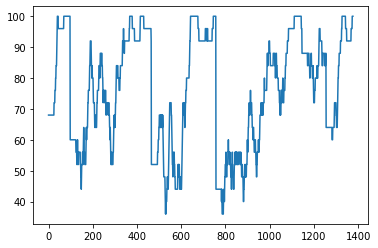

In [57]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [58]:
def kfold_prob(sess_id,X_rates,Y_class, verbose=1):
    splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
    split_ix = 0
    histories = []
    per_fold_eval = []
    per_fold_true = []

    for trn, vld in splitter.split(X_rates, Y_class):
        print(f"\tSplit {split_ix + 1} of {N_SPLITS}")
        _y = tf.keras.utils.to_categorical(Y_class, num_classes=np.max(Y_class)+1)
        
        ds_train = tf.data.Dataset.from_tensor_slices((X_rates[trn], _y[trn]))
        ds_valid = tf.data.Dataset.from_tensor_slices((X_rates[vld], _y[vld]))

        # cast data types to GPU-friendly types.
        ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
        ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

        # TODO: augmentations (random slicing?)

        ds_train = ds_train.shuffle(len(trn) + 1)
        ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
        ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

        tf.keras.backend.clear_session()
        
        randseed = 12345
        random.seed(randseed)
        np.random.seed(randseed)
        tf.random.set_seed(randseed)
        
        model = make_model(X_rates, _y.shape[-1], **model_kwargs)
        optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
        loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
        model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
        
        best_model_path = f'rule_{sess_id}_split{split_ix}.h5'
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                monitor='val_accuracy',
                verbose=verbose)
        ]

        hist = model.fit(x=ds_train, epochs=EPOCHS,
                         verbose=verbose,
                         validation_data=ds_valid,
                         callbacks=callbacks)
        # tf.keras.models.save_model(model, 'model.h5')
        histories.append(hist.history)
        
        model = tf.keras.models.load_model(best_model_path)
        per_fold_eval.append(model(X_rates[vld]).numpy())
        per_fold_true.append(Y_class[vld])
        
        split_ix += 1
        
    # Combine histories into one dictionary.
    history = {}
    for h in histories:
        for k,v in h.items():
            if k not in history:
                history[k] = v
            else:
                history[k].append(np.nan)
                history[k].extend(v)
                
#     pred_y = np.concatenate([_ in per_fold_eval])
#     true_y = np.concatenate([_ in per_fold_true])
#     accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
#     print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")
    
    return history, per_fold_eval, per_fold_true

In [59]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='DD' and color[i]=='g'):
        label[i] = 11
    elif (target[i]=='UU' and color[i]=='b'):
        label[i] = 1
    elif (target[i]=='DL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='UR' and color[i]=='g'):
        label[i] = 3
    elif (target[i]=='LL' and color[i]=='r'):
        label[i] = 4
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 6
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 7
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 8
    elif (target[i]=='DL' and color[i]=='r'):
        label[i] = 9
    elif (target[i]=='UR' and color[i]=='b'):
        label[i] = 10

In [60]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==11).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(1377, 48, 272) (1377,) (1377,)


In [61]:
keep_idx = np.argwhere(new_m_per>70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(839, 48, 272) (839,)


In [62]:
print(np.unique(RA_Y, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 38,  35,  36, 129, 127,  37,  27, 117,  86, 148,  59]))


In [93]:
hist, acc, y_pred_conf, y_true_conf = kfold_pred(sess_id,RA_X,RA_Y,'rule_conf', verbose=0)

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 78.18831942789035%


In [64]:
hist, y_pred, y_true = kfold_prob(sess_id,RA_X,RA_Y, verbose=0)

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


In [86]:
tmp = np.array(y_pred[:-1])
tmp = np.reshape(tmp, (-1, tmp.shape[-1]))
pred_score = np.concatenate((tmp, y_pred[-1]))
pred_true = np.concatenate(y_true).flatten()
print(pred_score.shape)

(839, 11)


In [90]:
conf_prob = np.zeros((11,11))
for i in range(np.max(pred_true)+1):
    tot = np.sum(pred_score[np.argwhere(pred_true==i)])
    tmp = np.sum(pred_score[np.argwhere(pred_true==i)], axis=0)
    conf_prob[i] = tmp / tot

In [91]:
conf_prob

array([[0.85621351, 0.0315    , 0.01328743, 0.01198663, 0.01324898,
        0.01284438, 0.01325306, 0.01063775, 0.01311069, 0.01237784,
        0.01153962],
       [0.05802665, 0.83573443, 0.01424438, 0.01007554, 0.01076028,
        0.01056014, 0.01525673, 0.01076275, 0.01111502, 0.01165012,
        0.01181403],
       [0.01809449, 0.01626042, 0.31176588, 0.07374448, 0.01431767,
        0.01688039, 0.0180656 , 0.01601317, 0.01457549, 0.36490157,
        0.1353808 ],
       [0.01582005, 0.01423379, 0.04235664, 0.50070959, 0.01469054,
        0.01670199, 0.0178229 , 0.01478849, 0.01669797, 0.15692301,
        0.18925495],
       [0.01519976, 0.01499592, 0.01561273, 0.01449933, 0.63700753,
        0.06911682, 0.02862866, 0.11818233, 0.05723123, 0.01446773,
        0.0150579 ],
       [0.01699937, 0.01578171, 0.01782357, 0.0147559 , 0.30481583,
        0.30052653, 0.10815489, 0.08062936, 0.10790136, 0.01537496,
        0.01723653],
       [0.01502082, 0.01563523, 0.01467744, 0.01452448, 0.

In [94]:
a = np.zeros((11,2))
b = np.zeros((11,11))
for i in range(len(y_true_conf)):
    a[y_true_conf[i], 0] += 1
    if y_true_conf[i] == y_pred_conf[i]:
        a[y_true_conf[i], 1] += 1
        b[y_true_conf[i], y_true_conf[i]] += 1
    else:
        b[y_true_conf[i], y_pred_conf[i]] += 1

In [95]:
for i in range(11):
    print(f'Label {i} Accuracy: {a[i,1]/a[i,0]}')

Label 0 Accuracy: 1.0
Label 1 Accuracy: 0.9714285714285714
Label 2 Accuracy: 0.7222222222222222
Label 3 Accuracy: 0.7751937984496124
Label 4 Accuracy: 0.8188976377952756
Label 5 Accuracy: 0.5135135135135135
Label 6 Accuracy: 0.6666666666666666
Label 7 Accuracy: 0.8290598290598291
Label 8 Accuracy: 0.8372093023255814
Label 9 Accuracy: 0.7837837837837838
Label 10 Accuracy: 0.5423728813559322


In [96]:
print(b)

[[ 38.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.  34.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  26.   1.   0.   0.   0.   0.   0.   5.   4.]
 [  0.   0.   3. 100.   0.   0.   0.   0.   0.  12.  14.]
 [  0.   0.   0.   0. 104.   7.   1.   9.   6.   0.   0.]
 [  0.   0.   0.   0.  10.  19.   2.   2.   4.   0.   0.]
 [  0.   0.   0.   0.   4.   1.  18.   2.   2.   0.   0.]
 [  0.   0.   0.   0.  13.   0.   1.  97.   6.   0.   0.]
 [  0.   0.   0.   0.   6.   0.   2.   6.  72.   0.   0.]
 [  0.   0.   7.  20.   0.   0.   0.   0.   0. 116.   5.]
 [  0.   0.   4.  20.   0.   0.   0.   0.   0.   3.  32.]]


## Session J52C

In [14]:
test_sess_ix = 3
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_052_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[ 224  473  637  638  983  984 1169]
sra3_1_j_052_00+
(1396,)
(1396, 34, 137)
(1396,) 0 7


In [15]:
sess_info

{'name': 'JerryLee',
 'bank': 'C',
 'name_short': 'j',
 'date': '090625',
 'exp_code': 'sra3_1_j_052_00+',
 'nsx': 'datafile003.ns2'}

In [10]:
border = np.array([0, 224, 473, 637, 983, 1169, len(outcome)])

In [11]:
for i in range(len(border)-1):
    print(f"block {border[i]} to {border[i+1]}:")
    print(np.unique(target[border[i]:border[i+1]], return_index=True, return_counts=True))
    print(np.unique(color[border[i]:border[i+1]], return_index=True, return_counts=True))

block 0 to 224:
(array(['DR', 'UL'], dtype=object), array([0, 4], dtype=int64), array([127,  97], dtype=int64))
(array(['b', 'r'], dtype=object), array([0, 4], dtype=int64), array([127,  97], dtype=int64))
block 224 to 473:
(array(['DL', 'DR', 'UR'], dtype=object), array([1, 0, 2], dtype=int64), array([118,   1, 130], dtype=int64))
(array(['b', 'g', 'r'], dtype=object), array([0, 1, 2], dtype=int64), array([  1, 118, 130], dtype=int64))
block 473 to 637:
(array(['DL', 'LL', 'RR'], dtype=object), array([0, 2, 1], dtype=int64), array([ 1, 85, 78], dtype=int64))
(array(['b', 'g', 'r'], dtype=object), array([1, 0, 2], dtype=int64), array([78,  1, 85], dtype=int64))
block 637 to 983:
(array(['DD', 'LL', 'RR'], dtype=object), array([1, 7, 0], dtype=int64), array([  1, 166, 179], dtype=int64))
(array(['b', 'g', 'r'], dtype=object), array([0, 7, 1], dtype=int64), array([  1, 166, 179], dtype=int64))
block 983 to 1169:
(array(['DD', 'LL', 'UL', 'UU'], dtype=object), array([9, 0, 1, 2], dtype=in

In [16]:
border = np.array([224, 473, 637, 983, 1169])

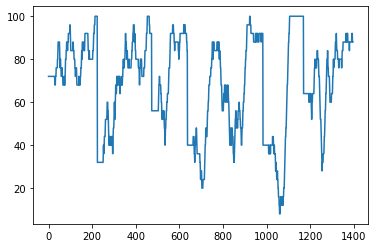

In [17]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [18]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='DR' and color[i]=='b'):
        label[i] = 10
    elif (target[i]=='UL' and color[i]=='r'):
        label[i] = 1
    elif (target[i]=='DL' and color[i]=='g'):
        label[i] = 2
    elif (target[i]=='UR' and color[i]=='r'):
        label[i] = 3
    elif (target[i]=='LL' and color[i]=='r'):
        label[i] = 4
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 6
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 7
    elif (target[i]=='DD' and color[i]=='r'):
        label[i] = 8
    elif (target[i]=='UU' and color[i]=='b'):
        label[i] = 9

In [19]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==10).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(1396, 34, 137) (1396,) (1396,)


In [20]:
keep_idx = np.argwhere(new_m_per>75).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(674, 34, 137) (674,)


In [21]:
print(np.unique(RA_Y, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([ 85,  65, 109, 130,  47,  38,  62,  66,  36,  36], dtype=int64))


In [22]:
hist, acc, y_pred, y_true = kfold_pred(sess_id,RA_X,RA_Y, verbose=1)

	Split 1 of 10
Epoch 1/150
37/37 [==============================] - ETA: 0s - loss: 2.3061 - accuracy: 0.2483
Epoch 00001: val_accuracy improved from -inf to 0.27941, saving model to mon_v_mod_sra3_1_j_052_00+_split0.h5
37/37 [==============================] - 1s 36ms/step - loss: 2.3061 - accuracy: 0.2483 - val_loss: 2.3027 - val_accuracy: 0.2794
Epoch 2/150
37/37 [==============================] - ETA: 0s - loss: 2.0794 - accuracy: 0.3176
Epoch 00002: val_accuracy improved from 0.27941 to 0.30882, saving model to mon_v_mod_sra3_1_j_052_00+_split0.h5
37/37 [==============================] - 1s 23ms/step - loss: 2.0794 - accuracy: 0.3176 - val_loss: 2.2184 - val_accuracy: 0.3088
Epoch 3/150
37/37 [==============================] - ETA: 0s - loss: 1.9407 - accuracy: 0.3716
Epoch 00003: val_accuracy did not improve from 0.30882
37/37 [==============================] - 1s 23ms/step - loss: 1.9407 - accuracy: 0.3716 - val_loss: 2.1466 - val_accuracy: 0.2941
Epoch 4/150
37/37 [=============

Epoch 57/150
36/37 [============================>.] - ETA: 0s - loss: 1.3554 - accuracy: 0.7396
Epoch 00057: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 24ms/step - loss: 1.3537 - accuracy: 0.7432 - val_loss: 1.3493 - val_accuracy: 0.7647
Epoch 58/150
36/37 [============================>.] - ETA: 0s - loss: 1.3495 - accuracy: 0.7517
Epoch 00058: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 25ms/step - loss: 1.3501 - accuracy: 0.7551 - val_loss: 1.3165 - val_accuracy: 0.7500
Epoch 59/150
37/37 [==============================] - ETA: 0s - loss: 1.3391 - accuracy: 0.7500
Epoch 00059: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 24ms/step - loss: 1.3391 - accuracy: 0.7500 - val_loss: 1.3107 - val_accuracy: 0.7941
Epoch 60/150
37/37 [==============================] - ETA: 0s - loss: 1.3504 - accuracy: 0.7483
Epoch 00060: val_accuracy did not improve from 0.83824
37/37 

35/37 [===========================>..] - ETA: 0s - loss: 1.2833 - accuracy: 0.7786
Epoch 00115: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 24ms/step - loss: 1.2761 - accuracy: 0.7821 - val_loss: 1.3260 - val_accuracy: 0.7647
Epoch 116/150
37/37 [==============================] - ETA: 0s - loss: 1.2869 - accuracy: 0.7939
Epoch 00116: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 24ms/step - loss: 1.2869 - accuracy: 0.7939 - val_loss: 1.3393 - val_accuracy: 0.7059
Epoch 117/150
37/37 [==============================] - ETA: 0s - loss: 1.2528 - accuracy: 0.8125
Epoch 00117: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 24ms/step - loss: 1.2528 - accuracy: 0.8125 - val_loss: 1.4149 - val_accuracy: 0.7647
Epoch 118/150
36/37 [============================>.] - ETA: 0s - loss: 1.2741 - accuracy: 0.7969
Epoch 00118: val_accuracy did not improve from 0.83824
37/37 [=========

Epoch 144/150
37/37 [==============================] - ETA: 0s - loss: 1.2287 - accuracy: 0.8209
Epoch 00144: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 25ms/step - loss: 1.2287 - accuracy: 0.8209 - val_loss: 1.4427 - val_accuracy: 0.6912
Epoch 145/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2048 - accuracy: 0.8411
Epoch 00145: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 25ms/step - loss: 1.2043 - accuracy: 0.8429 - val_loss: 1.4166 - val_accuracy: 0.6912
Epoch 146/150
36/37 [============================>.] - ETA: 0s - loss: 1.2608 - accuracy: 0.8038
Epoch 00146: val_accuracy did not improve from 0.83824
37/37 [==============================] - 1s 24ms/step - loss: 1.2590 - accuracy: 0.8057 - val_loss: 1.4240 - val_accuracy: 0.7353
Epoch 147/150
36/37 [============================>.] - ETA: 0s - loss: 1.2690 - accuracy: 0.8038
Epoch 00147: val_accuracy did not improve from 0.83824
37

36/37 [============================>.] - ETA: 0s - loss: 1.4768 - accuracy: 0.6649
Epoch 00022: val_accuracy did not improve from 0.75000
37/37 [==============================] - 1s 24ms/step - loss: 1.4760 - accuracy: 0.6639 - val_loss: 1.3627 - val_accuracy: 0.7206
Epoch 23/150
36/37 [============================>.] - ETA: 0s - loss: 1.4356 - accuracy: 0.6927
Epoch 00023: val_accuracy improved from 0.75000 to 0.76471, saving model to mon_v_mod_sra3_1_j_052_00+_split1.h5
37/37 [==============================] - 1s 30ms/step - loss: 1.4399 - accuracy: 0.6892 - val_loss: 1.3464 - val_accuracy: 0.7647
Epoch 24/150
37/37 [==============================] - ETA: 0s - loss: 1.4381 - accuracy: 0.6976
Epoch 00024: val_accuracy improved from 0.76471 to 0.79412, saving model to mon_v_mod_sra3_1_j_052_00+_split1.h5
37/37 [==============================] - 1s 24ms/step - loss: 1.4381 - accuracy: 0.6976 - val_loss: 1.3611 - val_accuracy: 0.7941
Epoch 25/150
36/37 [============================>.] - 

Epoch 51/150
37/37 [==============================] - ETA: 0s - loss: 1.3550 - accuracy: 0.7314
Epoch 00051: val_accuracy did not improve from 0.79412
37/37 [==============================] - 1s 24ms/step - loss: 1.3550 - accuracy: 0.7314 - val_loss: 1.3520 - val_accuracy: 0.7794
Epoch 52/150
37/37 [==============================] - ETA: 0s - loss: 1.3386 - accuracy: 0.7551
Epoch 00052: val_accuracy did not improve from 0.79412
37/37 [==============================] - 1s 24ms/step - loss: 1.3386 - accuracy: 0.7551 - val_loss: 1.4101 - val_accuracy: 0.7206
Epoch 53/150
37/37 [==============================] - ETA: 0s - loss: 1.3498 - accuracy: 0.7652
Epoch 00053: val_accuracy did not improve from 0.79412
37/37 [==============================] - 1s 24ms/step - loss: 1.3498 - accuracy: 0.7652 - val_loss: 1.3783 - val_accuracy: 0.7647
Epoch 54/150
36/37 [============================>.] - ETA: 0s - loss: 1.3380 - accuracy: 0.7413
Epoch 00054: val_accuracy did not improve from 0.79412
37/37 

Epoch 80/150
36/37 [============================>.] - ETA: 0s - loss: 1.3162 - accuracy: 0.7500
Epoch 00080: val_accuracy did not improve from 0.80882
37/37 [==============================] - 1s 24ms/step - loss: 1.3172 - accuracy: 0.7483 - val_loss: 1.3586 - val_accuracy: 0.7647
Epoch 81/150
36/37 [============================>.] - ETA: 0s - loss: 1.2971 - accuracy: 0.7778
Epoch 00081: val_accuracy did not improve from 0.80882
37/37 [==============================] - 1s 24ms/step - loss: 1.2958 - accuracy: 0.7787 - val_loss: 1.3937 - val_accuracy: 0.7500
Epoch 82/150
36/37 [============================>.] - ETA: 0s - loss: 1.2948 - accuracy: 0.7917
Epoch 00082: val_accuracy did not improve from 0.80882
37/37 [==============================] - 1s 24ms/step - loss: 1.3029 - accuracy: 0.7855 - val_loss: 1.3699 - val_accuracy: 0.7794
Epoch 83/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2990 - accuracy: 0.7661
Epoch 00083: val_accuracy did not improve from 0.80882
37/37 

36/37 [============================>.] - ETA: 0s - loss: 1.2997 - accuracy: 0.7847
Epoch 00138: val_accuracy did not improve from 0.80882
37/37 [==============================] - 1s 25ms/step - loss: 1.2992 - accuracy: 0.7838 - val_loss: 1.3940 - val_accuracy: 0.7647
Epoch 139/150
37/37 [==============================] - ETA: 0s - loss: 1.2508 - accuracy: 0.8108
Epoch 00139: val_accuracy did not improve from 0.80882
37/37 [==============================] - 1s 24ms/step - loss: 1.2508 - accuracy: 0.8108 - val_loss: 1.4093 - val_accuracy: 0.7353
Epoch 140/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2989 - accuracy: 0.7643
Epoch 00140: val_accuracy did not improve from 0.80882
37/37 [==============================] - 1s 24ms/step - loss: 1.2946 - accuracy: 0.7652 - val_loss: 1.4319 - val_accuracy: 0.7059
Epoch 141/150
36/37 [============================>.] - ETA: 0s - loss: 1.2696 - accuracy: 0.7917
Epoch 00141: val_accuracy did not improve from 0.80882
37/37 [=========

Epoch 16/150
35/37 [===========================>..] - ETA: 0s - loss: 1.5211 - accuracy: 0.6339
Epoch 00016: val_accuracy improved from 0.70588 to 0.73529, saving model to mon_v_mod_sra3_1_j_052_00+_split2.h5
37/37 [==============================] - 1s 26ms/step - loss: 1.5256 - accuracy: 0.6318 - val_loss: 1.3889 - val_accuracy: 0.7353
Epoch 17/150
37/37 [==============================] - ETA: 0s - loss: 1.5395 - accuracy: 0.6216
Epoch 00017: val_accuracy improved from 0.73529 to 0.76471, saving model to mon_v_mod_sra3_1_j_052_00+_split2.h5
37/37 [==============================] - 1s 26ms/step - loss: 1.5395 - accuracy: 0.6216 - val_loss: 1.4051 - val_accuracy: 0.7647
Epoch 18/150
35/37 [===========================>..] - ETA: 0s - loss: 1.4903 - accuracy: 0.6357
Epoch 00018: val_accuracy did not improve from 0.76471
37/37 [==============================] - 1s 25ms/step - loss: 1.4942 - accuracy: 0.6334 - val_loss: 1.4283 - val_accuracy: 0.7206
Epoch 19/150
36/37 [=====================

Epoch 73/150
35/37 [===========================>..] - ETA: 0s - loss: 1.3317 - accuracy: 0.7821
Epoch 00073: val_accuracy did not improve from 0.82353
37/37 [==============================] - 1s 25ms/step - loss: 1.3286 - accuracy: 0.7821 - val_loss: 1.2940 - val_accuracy: 0.7353
Epoch 74/150
36/37 [============================>.] - ETA: 0s - loss: 1.3014 - accuracy: 0.7778
Epoch 00074: val_accuracy did not improve from 0.82353
37/37 [==============================] - 1s 25ms/step - loss: 1.3077 - accuracy: 0.7736 - val_loss: 1.3088 - val_accuracy: 0.7206
Epoch 75/150
36/37 [============================>.] - ETA: 0s - loss: 1.3283 - accuracy: 0.7726 ETA: 0s - loss: 1.3
Epoch 00075: val_accuracy did not improve from 0.82353
37/37 [==============================] - 1s 26ms/step - loss: 1.3306 - accuracy: 0.7652 - val_loss: 1.3039 - val_accuracy: 0.7353
Epoch 76/150
36/37 [============================>.] - ETA: 0s - loss: 1.3002 - accuracy: 0.7812
Epoch 00076: val_accuracy did not improve

35/37 [===========================>..] - ETA: 0s - loss: 1.2754 - accuracy: 0.7893
Epoch 00131: val_accuracy did not improve from 0.82353
37/37 [==============================] - 1s 25ms/step - loss: 1.2821 - accuracy: 0.7838 - val_loss: 1.2871 - val_accuracy: 0.7353
Epoch 132/150
36/37 [============================>.] - ETA: 0s - loss: 1.2715 - accuracy: 0.7986
Epoch 00132: val_accuracy did not improve from 0.82353
37/37 [==============================] - 1s 25ms/step - loss: 1.2736 - accuracy: 0.7990 - val_loss: 1.2895 - val_accuracy: 0.7794
Epoch 133/150
37/37 [==============================] - ETA: 0s - loss: 1.2658 - accuracy: 0.8074
Epoch 00133: val_accuracy did not improve from 0.82353
37/37 [==============================] - 1s 25ms/step - loss: 1.2658 - accuracy: 0.8074 - val_loss: 1.3160 - val_accuracy: 0.8088
Epoch 134/150
37/37 [==============================] - ETA: 0s - loss: 1.2655 - accuracy: 0.7838
Epoch 00134: val_accuracy did not improve from 0.82353
37/37 [=========

Epoch 9/150
36/37 [============================>.] - ETA: 0s - loss: 1.6119 - accuracy: 0.5573
Epoch 00009: val_accuracy improved from 0.52941 to 0.60294, saving model to mon_v_mod_sra3_1_j_052_00+_split3.h5
37/37 [==============================] - 1s 28ms/step - loss: 1.6089 - accuracy: 0.5642 - val_loss: 1.6776 - val_accuracy: 0.6029
Epoch 10/150
36/37 [============================>.] - ETA: 0s - loss: 1.5760 - accuracy: 0.6024
Epoch 00010: val_accuracy did not improve from 0.60294
37/37 [==============================] - 1s 27ms/step - loss: 1.5732 - accuracy: 0.6064 - val_loss: 1.6567 - val_accuracy: 0.5882
Epoch 11/150
36/37 [============================>.] - ETA: 0s - loss: 1.5754 - accuracy: 0.5833
Epoch 00011: val_accuracy did not improve from 0.60294
37/37 [==============================] - 1s 31ms/step - loss: 1.5739 - accuracy: 0.5861 - val_loss: 1.5771 - val_accuracy: 0.6029
Epoch 12/150
37/37 [==============================] - ETA: 0s - loss: 1.5818 - accuracy: 0.6115
Epoc

Epoch 66/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2921 - accuracy: 0.7839
Epoch 00066: val_accuracy did not improve from 0.73529
37/37 [==============================] - 1s 26ms/step - loss: 1.2896 - accuracy: 0.7855 - val_loss: 1.3875 - val_accuracy: 0.6912
Epoch 67/150
36/37 [============================>.] - ETA: 0s - loss: 1.2828 - accuracy: 0.7934
Epoch 00067: val_accuracy did not improve from 0.73529
37/37 [==============================] - 1s 26ms/step - loss: 1.2815 - accuracy: 0.7922 - val_loss: 1.3984 - val_accuracy: 0.6912
Epoch 68/150
37/37 [==============================] - ETA: 0s - loss: 1.3041 - accuracy: 0.7804
Epoch 00068: val_accuracy did not improve from 0.73529
37/37 [==============================] - 1s 26ms/step - loss: 1.3041 - accuracy: 0.7804 - val_loss: 1.3971 - val_accuracy: 0.7059
Epoch 69/150
36/37 [============================>.] - ETA: 0s - loss: 1.3067 - accuracy: 0.7656
Epoch 00069: val_accuracy did not improve from 0.73529
37/37 

Epoch 95/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2922 - accuracy: 0.7982
Epoch 00095: val_accuracy did not improve from 0.75000
37/37 [==============================] - 1s 26ms/step - loss: 1.2896 - accuracy: 0.7973 - val_loss: 1.4028 - val_accuracy: 0.7353
Epoch 96/150
37/37 [==============================] - ETA: 0s - loss: 1.3015 - accuracy: 0.7787
Epoch 00096: val_accuracy did not improve from 0.75000
37/37 [==============================] - 1s 25ms/step - loss: 1.3015 - accuracy: 0.7787 - val_loss: 1.3868 - val_accuracy: 0.7500
Epoch 97/150
36/37 [============================>.] - ETA: 0s - loss: 1.2833 - accuracy: 0.7847
Epoch 00097: val_accuracy did not improve from 0.75000
37/37 [==============================] - 1s 26ms/step - loss: 1.2869 - accuracy: 0.7838 - val_loss: 1.3929 - val_accuracy: 0.7059
Epoch 98/150
36/37 [============================>.] - ETA: 0s - loss: 1.2805 - accuracy: 0.7951
Epoch 00098: val_accuracy did not improve from 0.75000
37/37 

Epoch 3/150
35/37 [===========================>..] - ETA: 0s - loss: 1.8850 - accuracy: 0.4429
Epoch 00003: val_accuracy did not improve from 0.29851
37/37 [==============================] - 1s 24ms/step - loss: 1.8814 - accuracy: 0.4392 - val_loss: 2.1525 - val_accuracy: 0.2836
Epoch 4/150
36/37 [============================>.] - ETA: 0s - loss: 1.8168 - accuracy: 0.4497
Epoch 00004: val_accuracy improved from 0.29851 to 0.37313, saving model to mon_v_mod_sra3_1_j_052_00+_split4.h5
37/37 [==============================] - 1s 25ms/step - loss: 1.8203 - accuracy: 0.4493 - val_loss: 2.0874 - val_accuracy: 0.3731
Epoch 5/150
37/37 [==============================] - ETA: 0s - loss: 1.7878 - accuracy: 0.4662
Epoch 00005: val_accuracy improved from 0.37313 to 0.40299, saving model to mon_v_mod_sra3_1_j_052_00+_split4.h5
37/37 [==============================] - 1s 25ms/step - loss: 1.7878 - accuracy: 0.4662 - val_loss: 2.0118 - val_accuracy: 0.4030
Epoch 6/150
37/37 [=========================

Epoch 30/150
36/37 [============================>.] - ETA: 0s - loss: 1.4331 - accuracy: 0.6944
Epoch 00030: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 25ms/step - loss: 1.4359 - accuracy: 0.6892 - val_loss: 1.3449 - val_accuracy: 0.6866
Epoch 31/150
35/37 [===========================>..] - ETA: 0s - loss: 1.4467 - accuracy: 0.6679
Epoch 00031: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 25ms/step - loss: 1.4458 - accuracy: 0.6689 - val_loss: 1.3466 - val_accuracy: 0.7164
Epoch 32/150
37/37 [==============================] - ETA: 0s - loss: 1.4371 - accuracy: 0.6892
Epoch 00032: val_accuracy improved from 0.74627 to 0.77612, saving model to mon_v_mod_sra3_1_j_052_00+_split4.h5
37/37 [==============================] - 1s 26ms/step - loss: 1.4371 - accuracy: 0.6892 - val_loss: 1.3550 - val_accuracy: 0.7761
Epoch 33/150
36/37 [============================>.] - ETA: 0s - loss: 1.4078 - accuracy: 0.7083
Epo

35/37 [===========================>..] - ETA: 0s - loss: 1.2927 - accuracy: 0.7875
Epoch 00087: val_accuracy did not improve from 0.83582
37/37 [==============================] - 1s 25ms/step - loss: 1.2878 - accuracy: 0.7905 - val_loss: 1.2775 - val_accuracy: 0.8060
Epoch 88/150
37/37 [==============================] - ETA: 0s - loss: 1.2854 - accuracy: 0.7990
Epoch 00088: val_accuracy did not improve from 0.83582
37/37 [==============================] - 1s 25ms/step - loss: 1.2854 - accuracy: 0.7990 - val_loss: 1.2676 - val_accuracy: 0.7761
Epoch 89/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2885 - accuracy: 0.7696
Epoch 00089: val_accuracy did not improve from 0.83582
37/37 [==============================] - 1s 25ms/step - loss: 1.3003 - accuracy: 0.7601 - val_loss: 1.2903 - val_accuracy: 0.7612
Epoch 90/150
36/37 [============================>.] - ETA: 0s - loss: 1.2846 - accuracy: 0.7882
Epoch 00090: val_accuracy did not improve from 0.83582
37/37 [============

37/37 [==============================] - ETA: 0s - loss: 1.2354 - accuracy: 0.8209
Epoch 00145: val_accuracy did not improve from 0.83582
37/37 [==============================] - 1s 26ms/step - loss: 1.2354 - accuracy: 0.8209 - val_loss: 1.3548 - val_accuracy: 0.7015
Epoch 146/150
37/37 [==============================] - ETA: 0s - loss: 1.2609 - accuracy: 0.8041
Epoch 00146: val_accuracy did not improve from 0.83582
37/37 [==============================] - 1s 25ms/step - loss: 1.2609 - accuracy: 0.8041 - val_loss: 1.3666 - val_accuracy: 0.7164
Epoch 147/150
37/37 [==============================] - ETA: 0s - loss: 1.2650 - accuracy: 0.8057
Epoch 00147: val_accuracy did not improve from 0.83582
37/37 [==============================] - 1s 26ms/step - loss: 1.2650 - accuracy: 0.8057 - val_loss: 1.3467 - val_accuracy: 0.7015
Epoch 148/150
37/37 [==============================] - ETA: 0s - loss: 1.2452 - accuracy: 0.8176
Epoch 00148: val_accuracy did not improve from 0.83582
37/37 [=========

37/37 [==============================] - 1s 27ms/step - loss: 1.3361 - accuracy: 0.7669 - val_loss: 1.3451 - val_accuracy: 0.7463
Epoch 52/150
36/37 [============================>.] - ETA: 0s - loss: 1.3301 - accuracy: 0.7743
Epoch 00052: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 26ms/step - loss: 1.3304 - accuracy: 0.7753 - val_loss: 1.3970 - val_accuracy: 0.7015
Epoch 53/150
36/37 [============================>.] - ETA: 0s - loss: 1.3567 - accuracy: 0.7413
Epoch 00053: val_accuracy improved from 0.74627 to 0.76119, saving model to mon_v_mod_sra3_1_j_052_00+_split5.h5
37/37 [==============================] - 1s 27ms/step - loss: 1.3557 - accuracy: 0.7416 - val_loss: 1.3481 - val_accuracy: 0.7612
Epoch 54/150
37/37 [==============================] - ETA: 0s - loss: 1.3416 - accuracy: 0.7551
Epoch 00054: val_accuracy did not improve from 0.76119
37/37 [==============================] - 1s 26ms/step - loss: 1.3416 - accuracy: 0.7551 - val_loss:

36/37 [============================>.] - ETA: 0s - loss: 1.2578 - accuracy: 0.8056
Epoch 00109: val_accuracy did not improve from 0.77612
37/37 [==============================] - 1s 26ms/step - loss: 1.2560 - accuracy: 0.8074 - val_loss: 1.3329 - val_accuracy: 0.7313
Epoch 110/150
37/37 [==============================] - ETA: 0s - loss: 1.2968 - accuracy: 0.7855
Epoch 00110: val_accuracy did not improve from 0.77612
37/37 [==============================] - 1s 26ms/step - loss: 1.2968 - accuracy: 0.7855 - val_loss: 1.3554 - val_accuracy: 0.7612
Epoch 111/150
37/37 [==============================] - ETA: 0s - loss: 1.2504 - accuracy: 0.8142
Epoch 00111: val_accuracy did not improve from 0.77612
37/37 [==============================] - 1s 26ms/step - loss: 1.2504 - accuracy: 0.8142 - val_loss: 1.3684 - val_accuracy: 0.7463
Epoch 112/150
36/37 [============================>.] - ETA: 0s - loss: 1.2689 - accuracy: 0.8038
Epoch 00112: val_accuracy did not improve from 0.77612
37/37 [=========

Epoch 16/150
37/37 [==============================] - ETA: 0s - loss: 1.5192 - accuracy: 0.6554
Epoch 00016: val_accuracy did not improve from 0.64179
37/37 [==============================] - 1s 27ms/step - loss: 1.5192 - accuracy: 0.6554 - val_loss: 1.5021 - val_accuracy: 0.6269
Epoch 17/150
36/37 [============================>.] - ETA: 0s - loss: 1.5058 - accuracy: 0.6337
Epoch 00017: val_accuracy improved from 0.64179 to 0.67164, saving model to mon_v_mod_sra3_1_j_052_00+_split6.h5
37/37 [==============================] - 1s 27ms/step - loss: 1.4995 - accuracy: 0.6385 - val_loss: 1.5031 - val_accuracy: 0.6716
Epoch 18/150
37/37 [==============================] - ETA: 0s - loss: 1.5120 - accuracy: 0.6351
Epoch 00018: val_accuracy did not improve from 0.67164
37/37 [==============================] - 1s 27ms/step - loss: 1.5120 - accuracy: 0.6351 - val_loss: 1.4574 - val_accuracy: 0.6119
Epoch 19/150
37/37 [==============================] - ETA: 0s - loss: 1.5031 - accuracy: 0.6470
Epo

Epoch 45/150
37/37 [==============================] - ETA: 0s - loss: 1.3540 - accuracy: 0.7331
Epoch 00045: val_accuracy did not improve from 0.73134
37/37 [==============================] - 1s 26ms/step - loss: 1.3540 - accuracy: 0.7331 - val_loss: 1.3824 - val_accuracy: 0.7015
Epoch 46/150
37/37 [==============================] - ETA: 0s - loss: 1.3426 - accuracy: 0.7787
Epoch 00046: val_accuracy did not improve from 0.73134
37/37 [==============================] - 1s 27ms/step - loss: 1.3426 - accuracy: 0.7787 - val_loss: 1.4221 - val_accuracy: 0.6716
Epoch 47/150
37/37 [==============================] - ETA: 0s - loss: 1.3346 - accuracy: 0.7534
Epoch 00047: val_accuracy did not improve from 0.73134
37/37 [==============================] - 1s 27ms/step - loss: 1.3346 - accuracy: 0.7534 - val_loss: 1.4368 - val_accuracy: 0.6866
Epoch 48/150
36/37 [============================>.] - ETA: 0s - loss: 1.3542 - accuracy: 0.7465
Epoch 00048: val_accuracy did not improve from 0.73134
37/37 

Epoch 74/150
37/37 [==============================] - ETA: 0s - loss: 1.2951 - accuracy: 0.7686
Epoch 00074: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 26ms/step - loss: 1.2951 - accuracy: 0.7686 - val_loss: 1.4130 - val_accuracy: 0.6866
Epoch 75/150
36/37 [============================>.] - ETA: 0s - loss: 1.2635 - accuracy: 0.7917
Epoch 00075: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 26ms/step - loss: 1.2614 - accuracy: 0.7939 - val_loss: 1.4684 - val_accuracy: 0.6866
Epoch 76/150
37/37 [==============================] - ETA: 0s - loss: 1.2874 - accuracy: 0.7889
Epoch 00076: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 26ms/step - loss: 1.2874 - accuracy: 0.7889 - val_loss: 1.4380 - val_accuracy: 0.6567
Epoch 77/150
37/37 [==============================] - ETA: 0s - loss: 1.2996 - accuracy: 0.7652
Epoch 00077: val_accuracy did not improve from 0.74627
37/37 

36/37 [============================>.] - ETA: 0s - loss: 1.2283 - accuracy: 0.8125
Epoch 00132: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 26ms/step - loss: 1.2255 - accuracy: 0.8142 - val_loss: 1.4232 - val_accuracy: 0.7463
Epoch 133/150
36/37 [============================>.] - ETA: 0s - loss: 1.2320 - accuracy: 0.8247
Epoch 00133: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 26ms/step - loss: 1.2302 - accuracy: 0.8260 - val_loss: 1.5041 - val_accuracy: 0.7015
Epoch 134/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2569 - accuracy: 0.8054
Epoch 00134: val_accuracy did not improve from 0.74627
37/37 [==============================] - 1s 26ms/step - loss: 1.2599 - accuracy: 0.8041 - val_loss: 1.4843 - val_accuracy: 0.6866
Epoch 135/150
37/37 [==============================] - ETA: 0s - loss: 1.2241 - accuracy: 0.8412
Epoch 00135: val_accuracy did not improve from 0.74627
37/37 [=========

Epoch 10/150
36/37 [============================>.] - ETA: 0s - loss: 1.5833 - accuracy: 0.5677
Epoch 00010: val_accuracy improved from 0.64179 to 0.68657, saving model to mon_v_mod_sra3_1_j_052_00+_split7.h5
37/37 [==============================] - 1s 28ms/step - loss: 1.5893 - accuracy: 0.5608 - val_loss: 1.5207 - val_accuracy: 0.6866
Epoch 11/150
36/37 [============================>.] - ETA: 0s - loss: 1.5607 - accuracy: 0.5938
Epoch 00011: val_accuracy did not improve from 0.68657
37/37 [==============================] - 1s 26ms/step - loss: 1.5570 - accuracy: 0.5963 - val_loss: 1.5227 - val_accuracy: 0.6119
Epoch 12/150
36/37 [============================>.] - ETA: 0s - loss: 1.5913 - accuracy: 0.5799
Epoch 00012: val_accuracy did not improve from 0.68657
37/37 [==============================] - 1s 26ms/step - loss: 1.5915 - accuracy: 0.5811 - val_loss: 1.4571 - val_accuracy: 0.6716
Epoch 13/150
36/37 [============================>.] - ETA: 0s - loss: 1.5738 - accuracy: 0.6076
Epo

Epoch 38/150
37/37 [==============================] - ETA: 0s - loss: 1.4090 - accuracy: 0.7179
Epoch 00038: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 26ms/step - loss: 1.4090 - accuracy: 0.7179 - val_loss: 1.2667 - val_accuracy: 0.7910
Epoch 39/150
36/37 [============================>.] - ETA: 0s - loss: 1.3768 - accuracy: 0.7240
Epoch 00039: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 26ms/step - loss: 1.3745 - accuracy: 0.7247 - val_loss: 1.2621 - val_accuracy: 0.7761
Epoch 40/150
37/37 [==============================] - ETA: 0s - loss: 1.4074 - accuracy: 0.7213
Epoch 00040: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 26ms/step - loss: 1.4074 - accuracy: 0.7213 - val_loss: 1.2676 - val_accuracy: 0.7463
Epoch 41/150
36/37 [============================>.] - ETA: 0s - loss: 1.4293 - accuracy: 0.6823
Epoch 00041: val_accuracy improved from 0.80597 to 0.82090, s

Epoch 67/150
37/37 [==============================] - ETA: 0s - loss: 1.3470 - accuracy: 0.7584
Epoch 00067: val_accuracy did not improve from 0.85075
37/37 [==============================] - 1s 26ms/step - loss: 1.3470 - accuracy: 0.7584 - val_loss: 1.2010 - val_accuracy: 0.8209
Epoch 68/150
36/37 [============================>.] - ETA: 0s - loss: 1.3688 - accuracy: 0.7396
Epoch 00068: val_accuracy did not improve from 0.85075
37/37 [==============================] - 1s 26ms/step - loss: 1.3675 - accuracy: 0.7416 - val_loss: 1.2293 - val_accuracy: 0.7761
Epoch 69/150
37/37 [==============================] - ETA: 0s - loss: 1.3417 - accuracy: 0.7703
Epoch 00069: val_accuracy did not improve from 0.85075
37/37 [==============================] - 1s 26ms/step - loss: 1.3417 - accuracy: 0.7703 - val_loss: 1.2113 - val_accuracy: 0.8358
Epoch 70/150
37/37 [==============================] - ETA: 0s - loss: 1.3191 - accuracy: 0.7855
Epoch 00070: val_accuracy did not improve from 0.85075
37/37 

Epoch 96/150
36/37 [============================>.] - ETA: 0s - loss: 1.2765 - accuracy: 0.7986
Epoch 00096: val_accuracy did not improve from 0.88060
37/37 [==============================] - 1s 26ms/step - loss: 1.2776 - accuracy: 0.7990 - val_loss: 1.2383 - val_accuracy: 0.8507
Epoch 97/150
36/37 [============================>.] - ETA: 0s - loss: 1.3084 - accuracy: 0.7865
Epoch 00097: val_accuracy did not improve from 0.88060
37/37 [==============================] - 1s 26ms/step - loss: 1.3062 - accuracy: 0.7889 - val_loss: 1.2042 - val_accuracy: 0.8209
Epoch 98/150
37/37 [==============================] - ETA: 0s - loss: 1.2955 - accuracy: 0.7838
Epoch 00098: val_accuracy did not improve from 0.88060
37/37 [==============================] - 1s 26ms/step - loss: 1.2955 - accuracy: 0.7838 - val_loss: 1.1887 - val_accuracy: 0.8507
Epoch 99/150
37/37 [==============================] - ETA: 0s - loss: 1.2757 - accuracy: 0.7838
Epoch 00099: val_accuracy did not improve from 0.88060
37/37 

37/37 [==============================] - ETA: 0s - loss: 1.2800 - accuracy: 0.7821
Epoch 00125: val_accuracy did not improve from 0.88060
37/37 [==============================] - 1s 26ms/step - loss: 1.2800 - accuracy: 0.7821 - val_loss: 1.2290 - val_accuracy: 0.8209
Epoch 126/150
36/37 [============================>.] - ETA: 0s - loss: 1.2754 - accuracy: 0.7882
Epoch 00126: val_accuracy did not improve from 0.88060
37/37 [==============================] - 1s 26ms/step - loss: 1.2765 - accuracy: 0.7872 - val_loss: 1.2192 - val_accuracy: 0.8060
Epoch 127/150
36/37 [============================>.] - ETA: 0s - loss: 1.2394 - accuracy: 0.8125
Epoch 00127: val_accuracy did not improve from 0.88060
37/37 [==============================] - 1s 26ms/step - loss: 1.2487 - accuracy: 0.8091 - val_loss: 1.2205 - val_accuracy: 0.8209
Epoch 128/150
37/37 [==============================] - ETA: 0s - loss: 1.2548 - accuracy: 0.8041
Epoch 00128: val_accuracy did not improve from 0.88060
37/37 [=========

Epoch 4/150
37/37 [==============================] - ETA: 0s - loss: 1.8130 - accuracy: 0.4409
Epoch 00004: val_accuracy improved from 0.34328 to 0.44776, saving model to mon_v_mod_sra3_1_j_052_00+_split8.h5
37/37 [==============================] - 1s 25ms/step - loss: 1.8130 - accuracy: 0.4409 - val_loss: 2.0524 - val_accuracy: 0.4478
Epoch 5/150
35/37 [===========================>..] - ETA: 0s - loss: 1.8028 - accuracy: 0.4768
Epoch 00005: val_accuracy did not improve from 0.44776
37/37 [==============================] - 1s 24ms/step - loss: 1.7953 - accuracy: 0.4797 - val_loss: 2.0081 - val_accuracy: 0.4328
Epoch 6/150
36/37 [============================>.] - ETA: 0s - loss: 1.7420 - accuracy: 0.4792
Epoch 00006: val_accuracy improved from 0.44776 to 0.46269, saving model to mon_v_mod_sra3_1_j_052_00+_split8.h5
37/37 [==============================] - 1s 25ms/step - loss: 1.7418 - accuracy: 0.4764 - val_loss: 1.9004 - val_accuracy: 0.4627
Epoch 7/150
37/37 [=========================

Epoch 60/150
36/37 [============================>.] - ETA: 0s - loss: 1.3495 - accuracy: 0.7500
Epoch 00060: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 25ms/step - loss: 1.3497 - accuracy: 0.7500 - val_loss: 1.3509 - val_accuracy: 0.7463
Epoch 61/150
37/37 [==============================] - ETA: 0s - loss: 1.3469 - accuracy: 0.7534
Epoch 00061: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 26ms/step - loss: 1.3469 - accuracy: 0.7534 - val_loss: 1.3519 - val_accuracy: 0.6866
Epoch 62/150
35/37 [===========================>..] - ETA: 0s - loss: 1.3224 - accuracy: 0.7500
Epoch 00062: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 25ms/step - loss: 1.3168 - accuracy: 0.7500 - val_loss: 1.3306 - val_accuracy: 0.7313
Epoch 63/150
37/37 [==============================] - ETA: 0s - loss: 1.3378 - accuracy: 0.7466
Epoch 00063: val_accuracy did not improve from 0.80597
37/37 

36/37 [============================>.] - ETA: 0s - loss: 1.2899 - accuracy: 0.7882
Epoch 00118: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 25ms/step - loss: 1.2869 - accuracy: 0.7905 - val_loss: 1.3420 - val_accuracy: 0.7164
Epoch 119/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2522 - accuracy: 0.8071
Epoch 00119: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 25ms/step - loss: 1.2490 - accuracy: 0.8108 - val_loss: 1.3166 - val_accuracy: 0.7015
Epoch 120/150
35/37 [===========================>..] - ETA: 0s - loss: 1.2805 - accuracy: 0.7929
Epoch 00120: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 25ms/step - loss: 1.2918 - accuracy: 0.7889 - val_loss: 1.3279 - val_accuracy: 0.7463
Epoch 121/150
37/37 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.8041
Epoch 00121: val_accuracy did not improve from 0.80597
37/37 [=========

36/37 [============================>.] - ETA: 0s - loss: 1.4641 - accuracy: 0.6771
Epoch 00024: val_accuracy did not improve from 0.71642
37/37 [==============================] - 1s 27ms/step - loss: 1.4642 - accuracy: 0.6774 - val_loss: 1.4022 - val_accuracy: 0.7015
Epoch 25/150
35/37 [===========================>..] - ETA: 0s - loss: 1.4513 - accuracy: 0.6696
Epoch 00025: val_accuracy did not improve from 0.71642
37/37 [==============================] - 1s 26ms/step - loss: 1.4548 - accuracy: 0.6689 - val_loss: 1.4245 - val_accuracy: 0.6716
Epoch 26/150
36/37 [============================>.] - ETA: 0s - loss: 1.4348 - accuracy: 0.6962
Epoch 00026: val_accuracy did not improve from 0.71642
37/37 [==============================] - 1s 27ms/step - loss: 1.4324 - accuracy: 0.6993 - val_loss: 1.4181 - val_accuracy: 0.6716
Epoch 27/150
36/37 [============================>.] - ETA: 0s - loss: 1.4823 - accuracy: 0.6701
Epoch 00027: val_accuracy did not improve from 0.71642
37/37 [============

Epoch 53/150
37/37 [==============================] - ETA: 0s - loss: 1.3530 - accuracy: 0.7534
Epoch 00053: val_accuracy did not improve from 0.76119
37/37 [==============================] - 1s 27ms/step - loss: 1.3530 - accuracy: 0.7534 - val_loss: 1.3774 - val_accuracy: 0.7313
Epoch 54/150
36/37 [============================>.] - ETA: 0s - loss: 1.3387 - accuracy: 0.7569
Epoch 00054: val_accuracy did not improve from 0.76119
37/37 [==============================] - 1s 26ms/step - loss: 1.3386 - accuracy: 0.7568 - val_loss: 1.3102 - val_accuracy: 0.7164
Epoch 55/150
37/37 [==============================] - ETA: 0s - loss: 1.3577 - accuracy: 0.7500
Epoch 00055: val_accuracy did not improve from 0.76119
37/37 [==============================] - 1s 26ms/step - loss: 1.3577 - accuracy: 0.7500 - val_loss: 1.3213 - val_accuracy: 0.7164
Epoch 56/150
35/37 [===========================>..] - ETA: 0s - loss: 1.3319 - accuracy: 0.7607
Epoch 00056: val_accuracy improved from 0.76119 to 0.77612, s

Epoch 82/150
37/37 [==============================] - ETA: 0s - loss: 1.3360 - accuracy: 0.7568
Epoch 00082: val_accuracy did not improve from 0.79104
37/37 [==============================] - 1s 26ms/step - loss: 1.3360 - accuracy: 0.7568 - val_loss: 1.3137 - val_accuracy: 0.7463
Epoch 83/150
36/37 [============================>.] - ETA: 0s - loss: 1.3145 - accuracy: 0.7778
Epoch 00083: val_accuracy did not improve from 0.79104
37/37 [==============================] - 1s 26ms/step - loss: 1.3113 - accuracy: 0.7804 - val_loss: 1.3398 - val_accuracy: 0.7463
Epoch 84/150
37/37 [==============================] - ETA: 0s - loss: 1.3012 - accuracy: 0.7652
Epoch 00084: val_accuracy did not improve from 0.79104
37/37 [==============================] - 1s 26ms/step - loss: 1.3012 - accuracy: 0.7652 - val_loss: 1.3039 - val_accuracy: 0.7612
Epoch 85/150
37/37 [==============================] - ETA: 0s - loss: 1.3147 - accuracy: 0.7601
Epoch 00085: val_accuracy improved from 0.79104 to 0.80597, s

Epoch 111/150
36/37 [============================>.] - ETA: 0s - loss: 1.2510 - accuracy: 0.8125
Epoch 00111: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 26ms/step - loss: 1.2512 - accuracy: 0.8108 - val_loss: 1.3167 - val_accuracy: 0.7612
Epoch 112/150
37/37 [==============================] - ETA: 0s - loss: 1.2727 - accuracy: 0.8041
Epoch 00112: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 27ms/step - loss: 1.2727 - accuracy: 0.8041 - val_loss: 1.3225 - val_accuracy: 0.7612
Epoch 113/150
36/37 [============================>.] - ETA: 0s - loss: 1.2664 - accuracy: 0.7986
Epoch 00113: val_accuracy did not improve from 0.80597
37/37 [==============================] - 1s 26ms/step - loss: 1.2728 - accuracy: 0.7922 - val_loss: 1.3070 - val_accuracy: 0.7463
Epoch 114/150
37/37 [==============================] - ETA: 0s - loss: 1.2813 - accuracy: 0.7787
Epoch 00114: val_accuracy did not improve from 0.80597
37

In [23]:
a = np.zeros((10, 2))
b = np.zeros((10,10))
for i in range(len(y_true)):
    a[y_true[i], 0] += 1
    if y_true[i] == y_pred[i]:
        a[y_true[i], 1] += 1
        b[y_true[i], y_true[i]] += 1
    else:
        b[y_true[i], y_pred[i]] += 1

In [27]:
for i in range(10):
    print(f'Label {i} Accuracy: {a[i,1]/a[i,0]}')

Label 0 Accuracy: 0.9176470588235294
Label 1 Accuracy: 0.7538461538461538
Label 2 Accuracy: 0.7706422018348624
Label 3 Accuracy: 0.8846153846153846
Label 4 Accuracy: 0.6595744680851063
Label 5 Accuracy: 0.6578947368421053
Label 6 Accuracy: 0.7096774193548387
Label 7 Accuracy: 0.7727272727272727
Label 8 Accuracy: 0.9444444444444444
Label 9 Accuracy: 0.9444444444444444


In [28]:
print(b)

[[ 78.   7.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 16.  49.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  84.  24.   1.   0.   0.   0.   0.   0.]
 [  0.   0.  14. 115.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.  31.   3.   9.   4.   0.   0.]
 [  0.   0.   0.   0.   2.  25.   3.   8.   0.   0.]
 [  0.   0.   0.   0.   7.   3.  44.   8.   0.   0.]
 [  0.   0.   0.   0.   0.   8.   5.  51.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  34.   2.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   2.  34.]]


# Rule Decoding by SVM

## J50A

In [36]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_050_00_segmented_v2.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[ 72  73 145 177 178 276 422 426 476 516 565 566 567 597 598 602]
sra3_1_j_050_00+
(663,)
(663, 36, 123)
(663,) 0 7


In [37]:
border = np.array([72, 145, 177, 276, 422, 476, 516, 565, 597, len(outcome)])

In [38]:
for i in range(len(border)-1):
    print(f"block {border[i]} to {border[i+1]}:")
    print(np.unique(target[border[i]:border[i+1]], return_index=True, return_counts=True))
    print(np.unique(color[border[i]:border[i+1]], return_index=True, return_counts=True))

block 72 to 145:
(array(['DD', 'DR', 'UL', 'UR'], dtype=object), array([0, 2, 8, 1]), array([ 1, 34, 37,  1]))
(array(['b', 'g', 'r'], dtype=object), array([8, 0, 1]), array([37,  1, 35]))
block 145 to 177:
(array(['DD', 'UL', 'UU'], dtype=object), array([2, 0, 1]), array([13,  1, 18]))
(array(['b', 'g'], dtype=object), array([0, 2]), array([19, 13]))
block 177 to 276:
(array(['DD', 'DL', 'UR'], dtype=object), array([0, 1, 7]), array([ 1, 57, 41]))
(array(['b', 'g', 'r'], dtype=object), array([2, 0, 1]), array([56, 42,  1]))
block 276 to 422:
(array(['LL', 'RR', 'UR'], dtype=object), array([2, 1, 0]), array([75, 70,  1]))
(array(['g', 'r'], dtype=object), array([0, 2]), array([71, 75]))
block 422 to 476:
(array(['DD', 'LL', 'RR'], dtype=object), array([1, 5, 0]), array([ 4, 20, 30]))
(array(['g', 'r'], dtype=object), array([0, 1]), array([30, 24]))
block 476 to 516:
(array(['DD', 'LL', 'UU'], dtype=object), array([6, 0, 1]), array([11,  1, 28]))
(array(['g', 'r'], dtype=object), array(

In [39]:
border = np.array([72, 145, 177, 276, 422, 476, 516, 565, 597])

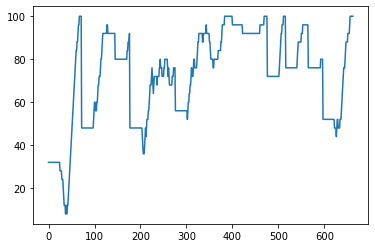

In [40]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [41]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='DD' and color[i]=='g'):
        label[i] = 12
    elif (target[i]=='UU' and color[i]=='b'):
        label[i] = 1
    elif (target[i]=='DR' and color[i]=='r'):
        label[i] = 2
    elif (target[i]=='UL' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='DL' and color[i]=='b'):
        label[i] = 4
    elif (target[i]=='UR' and color[i]=='g'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='r'):
        label[i] = 6
    elif (target[i]=='RR' and color[i]=='g'):
        label[i] = 7
    elif (target[i]=='UU' and color[i]=='r'):
        label[i] = 8
    elif (target[i]=='DR' and color[i]=='g'):
        label[i] = 9
    elif (target[i]=='DL' and color[i]=='r'):
        label[i] = 10
    elif (target[i]=='UR' and color[i]=='r'):
        label[i] = 11

In [42]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==12).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(655, 36, 123) (655,) (655,)


In [43]:
keep_idx = np.argwhere(new_m_per>75).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(373, 36, 123) (373,)


In [44]:
print(np.unique(RA_Y, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), array([27, 24, 16, 45, 24, 21, 74, 84,  9, 23, 19,  7]))


In [45]:
pred_y = np.zeros_like(RA_Y)
pred_y.shape

(373,)

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold

N_SPLITS = 10

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
X = np.reshape(RA_X, (RA_X.shape[0], -1))
i = 1
y_pred = np.zeros_like(RA_Y)
y_true = np.zeros_like(RA_Y)

for train_index, test_index in kf.split(X):
    print(f"\tSplit {i} of {N_SPLITS}")
    x_tr, x_ts = X[train_index], X[test_index]
    y_tr, y_ts = RA_Y[train_index], RA_Y[test_index]
    clf = SVC(verbose=0).fit(x_tr, y_tr)
    y_pred[test_index] = clf.predict(x_ts)
    y_true[test_index] = y_ts
    acc = np.sum(y_pred[test_index]==y_true[test_index])/len(y_true)
    i+=1

print (f'The SVM Accuracy is: {np.sum(y_pred==y_true)/len(y_true)}')

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
The SVM Accuracy is: 0.7855227882037533


In [47]:
a = np.zeros((12, 2))
b = np.zeros((12,12))
for i in range(len(y_true)):
    a[y_true[i], 0] += 1
    if y_true[i] == y_pred[i]:
        a[y_true[i], 1] += 1
        b[y_true[i], y_true[i]] += 1
    else:
        b[y_true[i], y_pred[i]] += 1

In [48]:
for i in range(12):
    print(f'Label {i} Accuracy: {a[i,1]/a[i,0]}')

Label 0 Accuracy: 0.9629629629629629
Label 1 Accuracy: 0.8333333333333334
Label 2 Accuracy: 0.0
Label 3 Accuracy: 0.9555555555555556
Label 4 Accuracy: 1.0
Label 5 Accuracy: 0.6190476190476191
Label 6 Accuracy: 0.8513513513513513
Label 7 Accuracy: 0.9880952380952381
Label 8 Accuracy: 0.0
Label 9 Accuracy: 0.43478260869565216
Label 10 Accuracy: 0.5789473684210527
Label 11 Accuracy: 0.0


In [49]:
print(b)

[[26.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4. 20.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 15.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0. 43.  0.  0.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  0. 24.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6. 13.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  0.  0. 63. 11.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. 83.  0.  0.  0.  0.]
 [ 1.  7.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 12.  0.  0.  0.  1.  0. 10.  0.  0.]
 [ 0.  0.  0.  0.  6.  1.  1.  0.  0.  0. 11.  0.]
 [ 0.  0.  0.  0.  0.  6.  0.  0.  0.  0.  1.  0.]]


## J51B

In [7]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 48, 136)
(1377,) 0 6


In [8]:
border = np.array([0, 98, 389, 465, 684, 757, 1146, 1255, len(outcome)])

In [9]:
for i in range(len(border)-1):
    print(f"block {border[i]} to {border[i+1]}:")
    print(np.unique(target[border[i]:border[i+1]], return_index=True, return_counts=True))
    print(np.unique(color[border[i]:border[i+1]], return_index=True, return_counts=True))

block 0 to 98:
(array(['DD', 'UU'], dtype=object), array([1, 0]), array([53, 45]))
(array(['b', 'g'], dtype=object), array([0, 1]), array([45, 53]))
block 98 to 389:
(array(['DD', 'LL', 'RR'], dtype=object), array([0, 1, 2]), array([  1, 158, 132]))
(array(['b', 'g', 'r'], dtype=object), array([2, 0, 1]), array([132,   1, 158]))
block 389 to 465:
(array(['LL', 'RR'], dtype=object), array([5, 0]), array([41, 35]))
(array(['b', 'r'], dtype=object), array([0, 5]), array([35, 41]))
block 465 to 684:
(array(['LL', 'RR'], dtype=object), array([0, 1]), array([111, 108]))
(array(['g', 'r'], dtype=object), array([2, 0]), array([110, 109]))
block 684 to 757:
(array(['LL', 'RR'], dtype=object), array([1, 0]), array([27, 46]))
(array(['b', 'r'], dtype=object), array([1, 0]), array([27, 46]))
block 757 to 1146:
(array(['DL', 'RR', 'UR'], dtype=object), array([3, 0, 1]), array([207,   1, 181]))
(array(['g', 'r'], dtype=object), array([1, 0]), array([181, 208]))
block 1146 to 1255:
(array(['DL', 'UR'

In [10]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

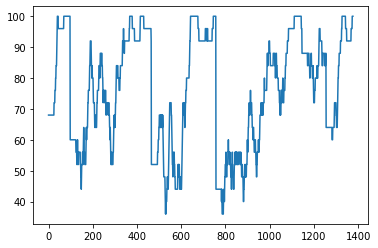

In [11]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [12]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='DD' and color[i]=='g'):
        label[i] = 11
    elif (target[i]=='UU' and color[i]=='b'):
        label[i] = 1
    elif (target[i]=='DL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='UR' and color[i]=='g'):
        label[i] = 3
    elif (target[i]=='LL' and color[i]=='r'):
        label[i] = 4
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 6
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 7
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 8
    elif (target[i]=='DL' and color[i]=='r'):
        label[i] = 9
    elif (target[i]=='UR' and color[i]=='b'):
        label[i] = 10

In [13]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==11).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(1377, 48, 136) (1377,) (1377,)


In [14]:
keep_idx = np.argwhere(new_m_per>75).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(757, 48, 136) (757,)


In [15]:
print(np.unique(RA_Y, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 36,  33,  35, 111, 116,  31,  27, 101,  78, 133,  56]))


In [19]:
pred_y = np.zeros_like(RA_Y)
pred_y.shape

(757,)

In [31]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold

N_SPLITS = 10

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
X = np.reshape(RA_X, (RA_X.shape[0], -1))
i = 1
y_pred = np.zeros_like(RA_Y)
y_true = np.zeros_like(RA_Y)

for train_index, test_index in kf.split(X):
    print(f"\tSplit {i} of {N_SPLITS}")
    x_tr, x_ts = X[train_index], X[test_index]
    y_tr, y_ts = RA_Y[train_index], RA_Y[test_index]
    clf = SVC(verbose=0).fit(x_tr, y_tr)
    y_pred[test_index] = clf.predict(x_ts)
    y_true[test_index] = y_ts
    acc = np.sum(y_pred[test_index]==y_true[test_index])/len(y_true)
    i+=1

print (f'The SVM Accuracy is: {np.sum(y_pred==y_true)/len(y_true)}')

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
The SVM Accuracy is: 0.6776750330250991


In [32]:
a = np.zeros((11, 2))
b = np.zeros((11,11))
for i in range(len(y_true)):
    a[y_true[i], 0] += 1
    if y_true[i] == y_pred[i]:
        a[y_true[i], 1] += 1
        b[y_true[i], y_true[i]] += 1
    else:
        b[y_true[i], y_pred[i]] += 1

In [33]:
for i in range(11):
    print(f'Label {i} Accuracy: {a[i,1]/a[i,0]}')

Label 0 Accuracy: 0.9722222222222222
Label 1 Accuracy: 0.9696969696969697
Label 2 Accuracy: 0.0
Label 3 Accuracy: 0.8198198198198198
Label 4 Accuracy: 0.896551724137931
Label 5 Accuracy: 0.0
Label 6 Accuracy: 0.0
Label 7 Accuracy: 0.8217821782178217
Label 8 Accuracy: 0.7564102564102564
Label 9 Accuracy: 0.8195488721804511
Label 10 Accuracy: 0.0


In [34]:
print(b)

[[ 35.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  1.  32.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   6.   1.   0.   0.   0.   0.  28.   0.]
 [  0.   0.   0.  91.   3.   0.   0.   0.   0.  17.   0.]
 [  0.   0.   0.   0. 104.   0.   0.  11.   1.   0.   0.]
 [  0.   0.   0.   0.  28.   0.   0.   0.   3.   0.   0.]
 [  0.   0.   0.   0.  23.   0.   0.   0.   4.   0.   0.]
 [  0.   0.   0.   0.  15.   0.   0.  83.   3.   0.   0.]
 [  0.   0.   0.   0.   4.   0.   0.  15.  59.   0.   0.]
 [  0.   0.   0.  23.   1.   0.   0.   0.   0. 109.   0.]
 [  0.   0.   0.  30.   0.   0.   0.   0.   0.  26.   0.]]


# Rule vs Saccade

## Session J51B

In [33]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::16]
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 48, 170)
(1377,) 0 6


In [87]:
border = np.array([0, 98, 389, 465, 684, 757, 1146, 1255, len(outcome)])

In [88]:
for i in range(len(border)-1):
    print(f"block {border[i]} to {border[i+1]}:")
    print(np.unique(target[border[i]:border[i+1]], return_index=True, return_counts=True))
    print(np.unique(color[border[i]:border[i+1]], return_index=True, return_counts=True))

block 0 to 98:
(array(['DD', 'UU'], dtype=object), array([1, 0]), array([53, 45]))
(array(['b', 'g'], dtype=object), array([0, 1]), array([45, 53]))
block 98 to 389:
(array(['DD', 'LL', 'RR'], dtype=object), array([0, 1, 2]), array([  1, 158, 132]))
(array(['b', 'g', 'r'], dtype=object), array([2, 0, 1]), array([132,   1, 158]))
block 389 to 465:
(array(['LL', 'RR'], dtype=object), array([5, 0]), array([41, 35]))
(array(['b', 'r'], dtype=object), array([0, 5]), array([35, 41]))
block 465 to 684:
(array(['LL', 'RR'], dtype=object), array([0, 1]), array([111, 108]))
(array(['g', 'r'], dtype=object), array([2, 0]), array([110, 109]))
block 684 to 757:
(array(['LL', 'RR'], dtype=object), array([1, 0]), array([27, 46]))
(array(['b', 'r'], dtype=object), array([1, 0]), array([27, 46]))
block 757 to 1146:
(array(['DL', 'RR', 'UR'], dtype=object), array([3, 0, 1]), array([207,   1, 181]))
(array(['g', 'r'], dtype=object), array([1, 0]), array([181, 208]))
block 1146 to 1255:
(array(['DL', 'UR'

In [34]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

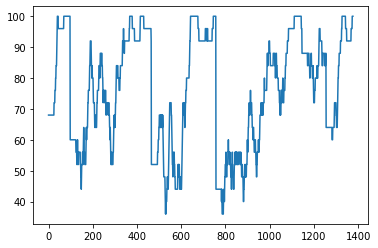

In [35]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [36]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [37]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==5).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 170) (659,) (659,)


In [38]:
keep_idx = np.argwhere(new_m_per>75).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(353, 48, 170) (353,)


In [15]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
_y = RA_Y[order]

In [27]:
print(np.unique(_y[150:], return_counts=True))
print(np.unique(_y[:150], return_counts=True))

(array([0, 1, 2, 3, 4]), array([57, 20, 16, 66, 44]))
(array([0, 1, 2, 3, 4]), array([59, 11, 11, 35, 34]))


In [81]:
x_tr = _x[:170]
tmp = _y[:170]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=5)
x_val = _x[170:]
tmp = _y[170:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=5)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=0)

output_layer = -9
truncated_model = model
# tf.keras.Model(model.input, model.layers[output_layer].output)
# flattened_output2 = []
# for start_ix in range(0, x_val.shape[0], tbs):
out2 = (truncated_model(x_val))
# flattened_output2 = tf.concat(flattened_output2, 0)
# flattened_output2 = np.array(flattened_output2)
out2 = np.reshape(out2, (out2.shape[0], -1))
print(out2.shape)
# y_pred = model.predict(x_val)
# pred_y1 = np.argmax(y_pred, axis=1)
tmp = model.predict(x_val)
tmp2 = np.argmax(tmp, axis=1)
tmp = np.argmax(y_val, axis=1)
cout2 = np.argwhere(tmp2==tmp).flatten()
print(cout2)

(183, 5)
[  0   2   3   4   6   7   8   9  11  13  14  16  20  23  25  26  27  28
  32  33  36  37  38  40  41  43  44  47  50  58  59  60  61  63  64  65
  66  67  68  69  70  71  73  74  75  76  78  79  82  84  88  89  90  91
  93  94  97  98 100 102 104 105 106 109 111 112 113 114 115 116 117 118
 120 122 123 124 125 126 127 128 129 131 133 134 135 138 139 140 141 142
 143 144 145 148 149 152 155 157 162 163 164 165 168 169 171 174 175 177
 178 179 180]


In [82]:
x_tr = _x[170:]
tmp = _y[170:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=5)
x_val = _x[:170]
tmp = _y[:170]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=5)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=0)

output_layer = -9
truncated_model = model
# tf.keras.Model(model.input, model.layers[output_layer].output)
# flattened_output2 = []
# for start_ix in range(0, x_val.shape[0], tbs):
out1 = (truncated_model(x_val))
out1 = np.reshape(out1, (out1.shape[0], -1))
print(out1.shape)
# flattened_output2 = tf.concat(flattened_output2, 0)
# flattened_output2 = np.array(flattened_output2)
print(out1.shape)
tmp = model.predict(x_val)
tmp2 = np.argmax(tmp, axis=1)
tmp = np.argmax(y_val, axis=1)
cout1 = 170 + np.argwhere(tmp2==tmp).flatten()
print(cout1)

(170, 5)
(170, 5)
[170 174 176 180 184 185 186 187 188 189 190 191 192 194 196 197 199 200
 201 202 205 208 211 212 214 215 216 218 219 221 222 223 224 225 226 227
 230 235 236 237 238 239 240 241 242 244 245 248 249 250 251 252 257 258
 259 260 262 263 265 266 267 268 269 270 272 276 280 281 282 283 285 286
 287 288 291 292 293 294 295 296 299 300 301 303 306 307 309 311 312 315
 316 317 319 321 322 323 324 326 328 330 331 332 333 334 336 337 338 339]


In [83]:
y_pred = np.concatenate((out1, out2), axis=0)
y_true_idx = np.concatenate((cout1, cout2), axis=0)
print(y_pred.shape)
print(y_true_idx.shape)

(353, 5)
(219,)


In [17]:
# a = np.zeros((5, 2))
# b = np.zeros((5,5))
# for i in range(len(y_true)):
#     a[y_true[i], 0] += 1
#     if y_true[i] == y_pred[i]:
#         a[y_true[i], 1] += 1
#         b[y_true[i], y_true[i]] += 1
#     else:
#         b[y_true[i], y_pred[i]] += 1

In [18]:
# for i in range(5):
#     print(f'Label {i} Accuracy: {a[i,1]/a[i,0]}')

Label 0 Accuracy: 0.8448275862068966
Label 1 Accuracy: 0.5806451612903226
Label 2 Accuracy: 0.7037037037037037
Label 3 Accuracy: 0.8415841584158416
Label 4 Accuracy: 0.9102564102564102


In [19]:
# print(b)

[[98.  6.  1.  8.  3.]
 [ 6. 18.  2.  2.  3.]
 [ 3.  2. 19.  1.  2.]
 [11.  1.  2. 85.  2.]
 [ 0.  2.  2.  3. 71.]]


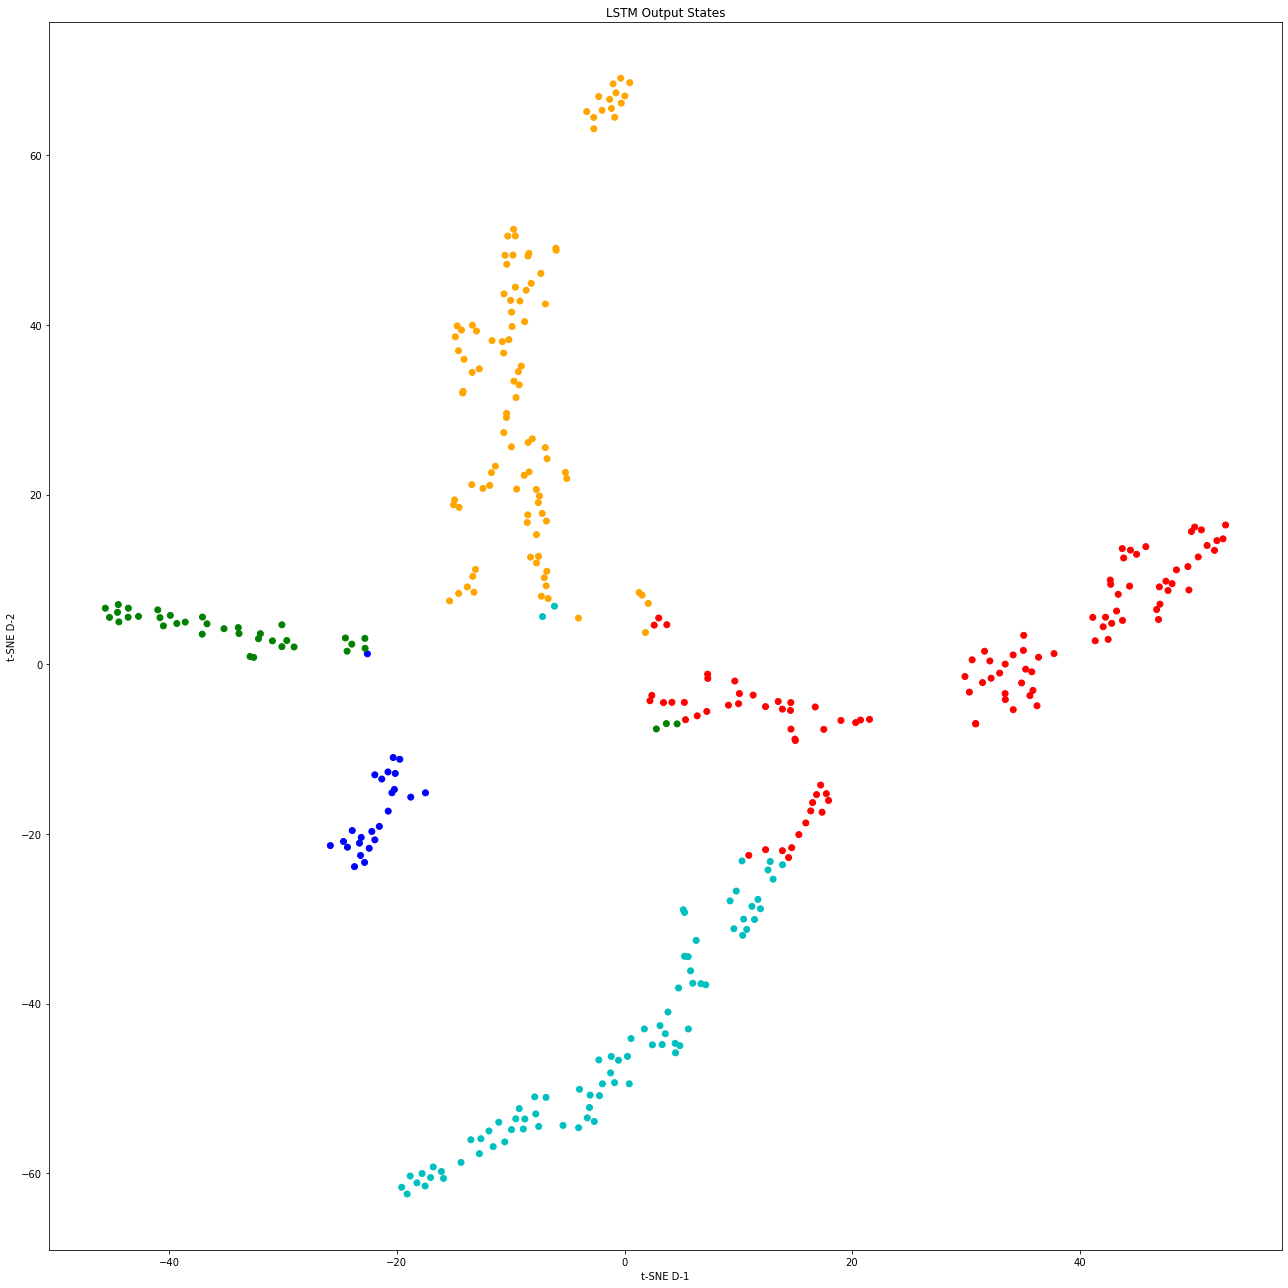

In [84]:
colors = np.array(['r', 'g', 'b', 'c', 'orange'])
# LR, LG, LB, RB, RR
# label = np.array(['Red Rule', 'Green Rule', 'Blue Rule', 'Right Saccade Only', 'Left Saccade Only', 'Incorrect'])
# label_first=np.zeros(6)

# colour_codes = map('C{}'.format, cycle(range(10)))
# class_colors = np.array([next(colour_codes) for _ in range(10)])  # b, o, g, r

TEST_PERPLEXITY = [10]
perplexity = 10
X = RA_X

fig = plt.figure(figsize=(18, 18))
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title)
    ax = plt.gca()

# model = tf.keras.models.load_model("rule_sra3_1_j_051_00+_split0.h5")
# # Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
# output_layer = -5
# tbs = 30  # tsne batch size
# truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
# flattened_output = []
# for start_ix in range(0, X.shape[0], tbs):
#     flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
# flattened_output = tf.concat(flattened_output, 0)
# tf.keras.backend.clear_session()

# for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
#     # Initialize and fit our TSNE
#     tsne_model = TSNE(n_components=2, perplexity=perplexity)
#     tsne_values2 = tsne_model.fit_transform(flattened_output2)
    
#     plt.subplot(1, 3, p_ix+1)
#     plot_tsne(tsne_values2, _y.ravel(), perplexity, title='LSTM Output States')
    
# for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
tsne_model = TSNE(n_components=2, perplexity=perplexity)
tsne_values = tsne_model.fit_transform(y_pred)
y_pred_rule = np.argmax(y_pred, axis=1)
# plt.subplot(1, 2, p_ix + 2)
plot_tsne(tsne_values, y_pred_rule.ravel(), perplexity, title='LSTM Output States')
    

plt.tight_layout()

In [99]:
# left_pred = np.argwhere((y_pred!=y_true)&(y_true<3)&(y_pred<3)).flatten()
# right_pred = np.argwhere((y_pred!=y_true)&(y_true>2)&(y_pred>2)).flatten()
# red_pred = np.argwhere((y_pred==y_true)&((y_true==0)|(y_true==4))).flatten()
# blue_pred = np.argwhere((y_pred==y_true)&((y_true==2)|(y_true==3))).flatten()
# green_pred = np.argwhere((y_pred==y_true)&(y_true==1)).flatten()
# incorrect_pred = np.argwhere((y_pred!=y_true)&(((y_true<3)&(y_pred>2))|((y_true>2)&(y_pred<3)))).flatten()
# _y = np.zeros(len(RA_Y))
# _y[green_pred] = 1
# _y[blue_pred] = 2
# _y[left_pred] = 3
# _y[right_pred] = 4
# _y[incorrect_pred] = 5
# _y = _y.astype(int)

In [98]:
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y = tmp[order]

In [99]:
x_tr = _x[:170]
tmp = _y[:170]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=2)
x_val = _x[170:]
tmp = _y[170:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=2)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=0)

output_layer = -9
truncated_model = model
# tf.keras.Model(model.input, model.layers[output_layer].output)
# flattened_output2 = []
# for start_ix in range(0, x_val.shape[0], tbs):
out2 = (truncated_model(x_val))
# flattened_output2 = tf.concat(flattened_output2, 0)
# flattened_output2 = np.array(flattened_output2)
out2 = np.reshape(out2, (out2.shape[0], -1))
print(out2.shape)
# y_pred = model.predict(x_val)
# pred_y1 = np.argmax(y_pred, axis=1)
tmp = model.predict(x_val)
tmp2 = np.argmax(tmp, axis=1)
tmp = np.argmax(y_val, axis=1)
cout2 = np.argwhere(tmp2==tmp).flatten()
print(cout2)

(183, 2)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  19  20
  23  24  26  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43
  44  47  49  50  51  54  57  59  60  61  62  63  64  65  66  67  68  70
  71  72  73  74  75  76  78  79  81  82  84  85  87  88  89  90  91  93
  94  96  97  99 100 101 104 105 106 108 110 111 113 114 115 116 118 119
 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135 136 138 139
 140 141 142 143 144 145 147 148 149 150 151 152 153 154 157 158 159 160
 161 162 163 164 165 167 169 170 172 173 174 175 177 178 179 180 181 182]


In [100]:
x_tr = _x[170:]
tmp = _y[170:]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=2)
x_val = _x[:170]
tmp = _y[:170]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=2)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=0)

output_layer = -9
truncated_model = model
# tf.keras.Model(model.input, model.layers[output_layer].output)
# flattened_output2 = []
# for start_ix in range(0, x_val.shape[0], tbs):
out1 = (truncated_model(x_val))
out1 = np.reshape(out1, (out1.shape[0], -1))
print(out1.shape)
# flattened_output2 = tf.concat(flattened_output2, 0)
# flattened_output2 = np.array(flattened_output2)
print(out1.shape)
tmp = model.predict(x_val)
tmp2 = np.argmax(tmp, axis=1)
tmp = np.argmax(y_val, axis=1)
cout1 = 170 + np.argwhere(tmp2==tmp).flatten()
print(cout1)

(170, 2)
(170, 2)
[170 171 174 177 178 180 181 182 184 188 189 190 192 194 195 196 199 201
 202 203 205 206 208 209 210 211 212 213 215 216 217 219 220 221 222 223
 224 226 227 229 230 232 235 236 237 239 240 241 243 245 246 247 249 250
 251 252 254 258 259 260 261 262 263 265 266 269 270 271 272 275 276 277
 278 279 281 282 284 285 286 287 289 290 291 293 294 298 299 301 302 305
 306 307 308 311 313 314 315 316 317 319 320 322 323 324 325 326 327 330
 331 333 334 336 338 339]


In [109]:
y_pred2 = np.concatenate((out1, out2), axis=0)
y_true_sac_idx = np.concatenate((cout1, cout2), axis=0)
print(y_pred_sac.shape)
print(y_true_sac_idx.shape)
y_pred_sac = np.argmax(y_pred2, axis=1)

(353,)
(258,)


In [106]:
y_pred_sac

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,

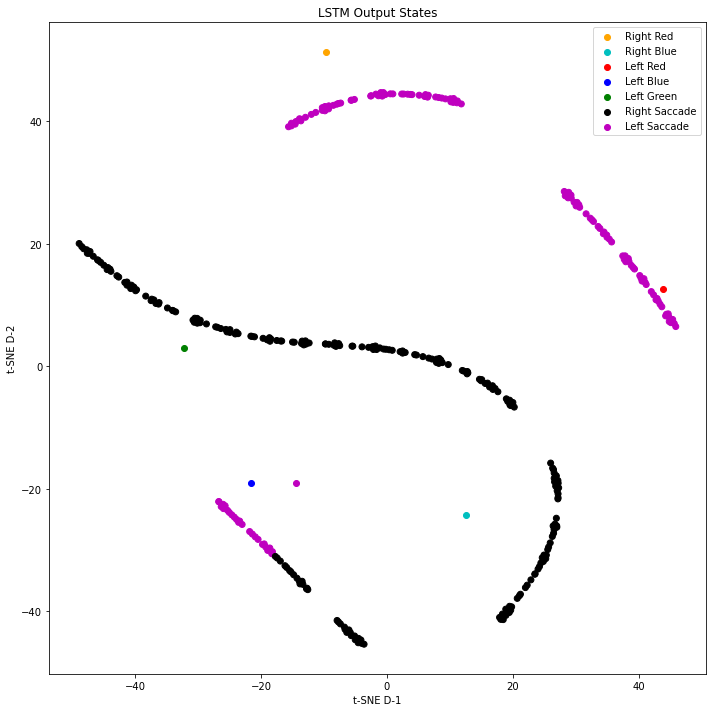

In [118]:


# label = np.array(['Red Rule', 'Green Rule', 'Blue Rule', 'Right Saccade Only', 'Left Saccade Only', 'Incorrect'])
# label_first=np.zeros(6)

# colour_codes = map('C{}'.format, cycle(range(10)))
# class_colors = np.array([next(colour_codes) for _ in range(10)])  # b, o, g, r

TEST_PERPLEXITY = [10]
perplexity = 10

fig = plt.figure(figsize=(10, 10))
def plot_tsne(x_vals, y_vals, perplexity, title='Model Output'):
    plt.scatter(x=x_vals[:, 0], y=x_vals[:, 1], color=colors[y_vals])
    plt.xlabel('t-SNE D-1')
    plt.ylabel('t-SNE D-2')
    plt.title(title)
    ax = plt.gca()

# model = tf.keras.models.load_model("rule_sra3_1_j_051_00+_split0.h5")
# # Let's create a version of our CNN model that goes from input all the way to the 200-D flatten layer
# output_layer = -5
# tbs = 30  # tsne batch size
# truncated_model = tf.keras.Model(model.input, model.layers[output_layer].output)
# flattened_output = []
# for start_ix in range(0, X.shape[0], tbs):
#     flattened_output.append(truncated_model(X[start_ix:start_ix+tbs, :, :].astype(np.float32)))
# flattened_output = tf.concat(flattened_output, 0)
# tf.keras.backend.clear_session()

# for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
#     # Initialize and fit our TSNE
#     tsne_model = TSNE(n_components=2, perplexity=perplexity)
#     tsne_values2 = tsne_model.fit_transform(flattened_output2)
    
#     plt.subplot(1, 3, p_ix+1)
#     plot_tsne(tsne_values2, _y.ravel(), perplexity, title='LSTM Output States')
    
# for p_ix, perplexity in enumerate(TEST_PERPLEXITY):
    # Initialize and fit our TSNE
tsne_model = TSNE(n_components=2, perplexity=perplexity)
tsne_values_sac = tsne_model.fit_transform(y_pred2)


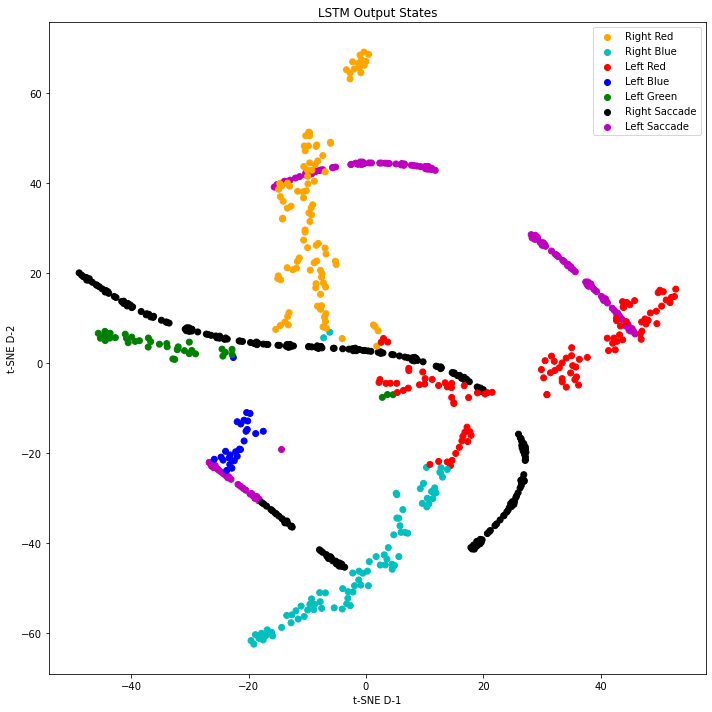

In [120]:
colors_rule = np.array(['r', 'g', 'b', 'c', 'orange'])
colors = np.array(['m', 'k'])
# LR, LG, LB, RB, RR
#L, R

fig = plt.figure(figsize=(10, 10))
plot_tsne(tsne_values_sac, y_pred_sac, perplexity, title='LSTM Output States')
# # plot_tsne(tsne_values, y_pred_rule.ravel(), perplexity)
plt.scatter(x=tsne_values[0, 0], y=tsne_values[0, 1], color=colors_rule[4], label='Right Red')
plt.scatter(x=tsne_values[14, 0], y=tsne_values[14, 1], color=colors_rule[3], label='Right Blue')
plt.scatter(x=tsne_values[4, 0], y=tsne_values[4, 1], color=colors_rule[0], label='Left Red')
plt.scatter(x=tsne_values[1, 0], y=tsne_values[1, 1], color=colors_rule[2], label='Left Blue')
plt.scatter(x=tsne_values[3, 0], y=tsne_values[3, 1], color=colors_rule[1], label='Left Green')
plt.scatter(x=tsne_values_sac[0, 0], y=tsne_values_sac[0, 1], color=colors[1], label='Right Saccade')
plt.scatter(x=tsne_values_sac[1, 0], y=tsne_values[1, 1], color=colors[0], label='Left Saccade')
plt.scatter(x=tsne_values[:, 0], y=tsne_values[:, 1], color=colors_rule[y_pred_rule])
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
    
plt.legend()
plt.tight_layout()

In [39]:
def train_valid (x, y, num_class):
    x_tr = x[:170]
    tmp = y[:170]
    y_tr = tf.keras.utils.to_categorical(tmp, num_classes=num_class)
    x_val = x[170:]
    tmp = y[170:]
    y_val = tf.keras.utils.to_categorical(tmp, num_classes=num_class)

    ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
    ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # cast data types to GPU-friendly types.
    ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
    ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

    # TODO: augmentations (random slicing?)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
    ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

    tf.keras.backend.clear_session()

    randseed = 12345
    random.seed(randseed)
    np.random.seed(randseed)
    tf.random.set_seed(randseed)

    model = make_model(x_tr, y_tr.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

    hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=0)
    out2 = model.predict(x_val)
    tmp2 = np.argmax(out2, axis=1)
    tmp = np.argmax(y_val, axis=1)
    cout2 = np.argwhere(tmp2==tmp).flatten()
    
    x_tr = x[170:]
    tmp = y[170:]
    y_tr = tf.keras.utils.to_categorical(tmp, num_classes=num_class)
    x_val = x[:170]
    tmp = y[:170]
    y_val = tf.keras.utils.to_categorical(tmp, num_classes=num_class)

    ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
    ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # cast data types to GPU-friendly types.
    ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
    ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

    # TODO: augmentations (random slicing?)
    ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
    ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

    tf.keras.backend.clear_session()

    randseed = 12345
    random.seed(randseed)
    np.random.seed(randseed)
    tf.random.set_seed(randseed)

    model = make_model(x_tr, y_tr.shape[-1], **model_kwargs)
    optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
    loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
    model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

    hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=0)
    out1 = model.predict(x_val)
    tmp2 = np.argmax(out1, axis=1)
    tmp = np.argmax(y_val, axis=1)
    cout1 = 170 + np.argwhere(tmp2==tmp).flatten()
    y_pred = np.concatenate((out1, out2), axis=0)
    y_true_idx = np.concatenate((cout1, cout2), axis=0)
    return y_pred, y_true_idx

In [40]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [41]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==5).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 170) (659,) (659,)


In [42]:
keep_idx = np.argwhere(new_m_per>75).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(353, 48, 170) (353,)


In [93]:
order = np.random.permutation(len(RA_X))
_X = RA_X[order]
_y = RA_Y[order]
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y2 = tmp[order]
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
_y3 = tmp[order]

In [96]:
_y

array([3, 3, 2, 3, 0, 0, 4, 3, 0, 1, 3, 0, 4, 4, 3, 0, 0, 4, 4, 4, 0, 3,
       3, 3, 3, 0, 0, 3, 0, 0, 0, 2, 2, 4, 0, 4, 0, 0, 4, 3, 3, 3, 4, 3,
       2, 1, 0, 3, 0, 0, 1, 3, 4, 3, 2, 3, 3, 3, 0, 3, 1, 0, 1, 3, 4, 1,
       4, 3, 4, 3, 4, 3, 3, 0, 3, 2, 1, 3, 3, 0, 0, 4, 4, 0, 0, 0, 1, 0,
       3, 4, 0, 4, 2, 3, 4, 3, 0, 0, 0, 1, 1, 3, 4, 0, 3, 0, 4, 4, 3, 2,
       4, 3, 4, 3, 4, 3, 3, 4, 0, 3, 3, 3, 0, 1, 0, 0, 0, 4, 2, 4, 3, 3,
       0, 4, 4, 4, 4, 0, 0, 4, 3, 3, 4, 4, 4, 0, 4, 1, 0, 0, 3, 0, 1, 2,
       0, 3, 1, 4, 2, 3, 0, 0, 3, 1, 0, 4, 4, 4, 3, 0, 4, 2, 0, 0, 3, 0,
       0, 0, 4, 4, 0, 0, 4, 4, 4, 0, 2, 3, 0, 3, 2, 2, 0, 0, 3, 3, 1, 4,
       3, 3, 0, 0, 3, 0, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 0, 4, 2, 0, 4, 0,
       3, 4, 3, 0, 3, 3, 4, 0, 0, 0, 0, 4, 3, 0, 2, 4, 3, 0, 3, 3, 1, 4,
       0, 1, 3, 3, 3, 0, 0, 0, 0, 3, 3, 0, 3, 2, 3, 2, 3, 4, 3, 0, 3, 4,
       4, 3, 3, 4, 4, 0, 0, 0, 4, 4, 4, 1, 0, 0, 4, 1, 2, 3, 0, 4, 4, 0,
       0, 4, 3, 0, 4, 4, 0, 3, 0, 0, 0, 3, 4, 4, 1,

In [95]:
_y3

array([1, 1, 1, 1, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 2, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 0, 2, 1, 0, 2,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 1,
       0, 1, 2, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 0,
       0, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2,

In [97]:
y3_pred, y3_true = train_valid(x=_x, y=_y3, num_class=3)

In [98]:
y3_true.shape

(247,)

In [100]:
y_true_sac_idx.shape

(305,)

In [47]:
_X.shape

(353, 48, 170)

In [64]:
t = np.arange(17, 187, 17)
# tsne_sac = np.zeros((17, 353, 2))
# tsne_rul = np.zeros((17, 353, 2))
y_pred_rul = np.zeros((10, 353, 5))
y_pred_sac = np.zeros((10, 353, 2))
# tsne_model = TSNE(n_components=2, perplexity=10)
for i in range(len(t)):
    print(f"Working on 0 to {(i+1)*17}")
    _x = _X[:,:,:((i+1)*17)]
    y_pred_rul[i], y_true_rul_idx = train_valid(x = _x, y = _y, num_class=5)
#     y_rul_class[i] = np.argmax(y_pred_rul, axis=1)
#     tsne_rul[i] = tsne_model.fit_transform(y_pred_rul)
    y_pred_sac[i], y_true_sac_idx = train_valid(x = _x, y = _y2, num_class=2)
#     y_sac_class[i] = np.argmax(y_pred_sac, axis=1)
#     tsne_sac[i] = tsne_model.fit_transform(y_pred_sac)

Working on 0 to 17
Working on 0 to 34
Working on 0 to 51
Working on 0 to 68
Working on 0 to 85
Working on 0 to 102
Working on 0 to 119
Working on 0 to 136
Working on 0 to 153
Working on 0 to 170


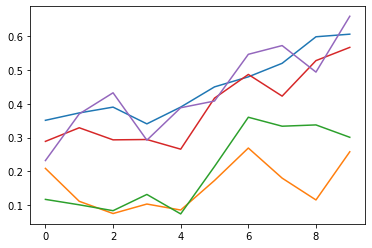

In [92]:
tmp = y_pred_rul[:, y_true_rul_idx, :]
tmp2 = _y[y_true_rul_idx]
lr = tmp[:, np.argwhere(tmp2==0).flatten(), :]
lg = tmp[:, np.argwhere(tmp2==1).flatten(), :]
lb = tmp[:, np.argwhere(tmp2==2).flatten(), :]
rb = tmp[:, np.argwhere(tmp2==3).flatten(), :]
rr = tmp[:, np.argwhere(tmp2==4).flatten(), :]

_lr = np.sum(lr, axis=1)
tmp = _lr[:,0]/np.sum(_lr, axis=1)
tmp.shape
plt.plot(tmp)
_lg = np.sum(lg, axis=1)
tmp = _lg[:,1]/np.sum(_lg, axis=1)
tmp.shape
plt.plot(tmp)
_lb = np.sum(lb, axis=1)
tmp = _lb[:,2]/np.sum(_lb, axis=1)
tmp.shape
plt.plot(tmp)
_rb = np.sum(rb, axis=1)
tmp = _rb[:,3]/np.sum(_rb, axis=1)
tmp.shape
plt.plot(tmp)
_rr = np.sum(rr, axis=1)
tmp = _rr[:,4]/np.sum(_rr, axis=1)
tmp.shape
plt.plot(tmp)

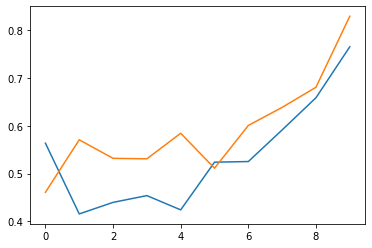

In [91]:
tmp = y_pred_sac[:, y_true_sac_idx, :]
tmp2 = _y2[y_true_sac_idx]
l = tmp[:, np.argwhere(tmp2==0).flatten(), :]
r = tmp[:, np.argwhere(tmp2==1).flatten(), :]

_l = np.sum(l, axis=1)
tmp = _l[:,0]/np.sum(_l, axis=1)
tmp.shape
plt.plot(tmp)
_r = np.sum(r, axis=1)
tmp = _r[:,1]/np.sum(_r, axis=1)
tmp.shape
plt.plot(tmp)

In [72]:
a = np.argwhere(tmp2==0).flatten()
a.shape

(86,)

In [170]:
y_rul_class.shape

(353,)

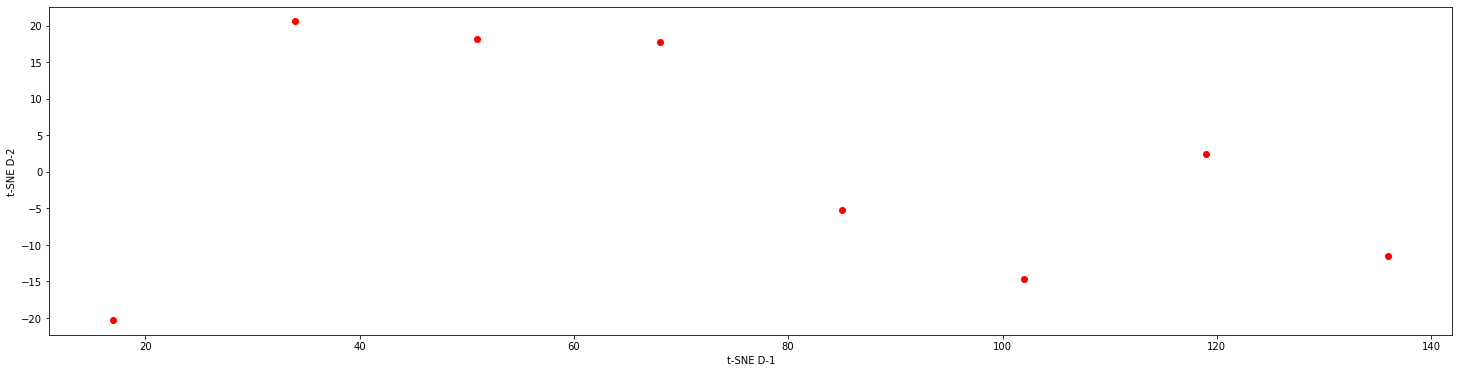

In [175]:
fig = plt.figure(figsize=(40, 10))
plt.subplot(2,2, 1)
plt.scatter(x=t[0], y=tsne_rul[0,10, 0], color=colors_rule[y_rul_class[1]])
plt.scatter(x=t[1], y=tsne_rul[1,10, 0], color=colors_rule[y_rul_class[1]])
plt.scatter(x=t[2], y=tsne_rul[2,10, 0], color=colors_rule[y_rul_class[1]])
plt.scatter(x=t[3], y=tsne_rul[3,10, 0], color=colors_rule[y_rul_class[1]])
plt.scatter(x=t[4], y=tsne_rul[4,10, 0], color=colors_rule[y_rul_class[1]])
plt.scatter(x=t[5], y=tsne_rul[5,10, 0], color=colors_rule[y_rul_class[1]])
plt.scatter(x=t[6], y=tsne_rul[6,10, 0], color=colors_rule[y_rul_class[1]])
plt.scatter(x=t[7], y=tsne_rul[7,10, 0], color=colors_rule[y_rul_class[1]])
# plt.subplot(2,2, 2)
# plt.scatter(x=np.zeros(353)+t[0], y=tsne_rul[0,:, 1], color=colors_rule[y_rul_class])
# plot_tsne(tsne_values_sac, y_pred_sac, perplexity, title='LSTM Output States')
# # # plot_tsne(tsne_values, y_pred_rule.ravel(), perplexity)
# plt.scatter(x=tsne_values[0, 0], y=tsne_values[0, 1], color=colors_rule[4], label='Right Red')
# plt.scatter(x=tsne_values[14, 0], y=tsne_values[14, 1], color=colors_rule[3], label='Right Blue')
# plt.scatter(x=tsne_values[4, 0], y=tsne_values[4, 1], color=colors_rule[0], label='Left Red')
# plt.scatter(x=tsne_values[1, 0], y=tsne_values[1, 1], color=colors_rule[2], label='Left Blue')
# plt.scatter(x=tsne_values[3, 0], y=tsne_values[3, 1], color=colors_rule[1], label='Left Green')
# plt.scatter(x=tsne_values_sac[0, 0], y=tsne_values_sac[0, 1], color=colors[1], label='Right Saccade')
# plt.scatter(x=tsne_values_sac[1, 0], y=tsne_values[1, 1], color=colors[0], label='Left Saccade')
# plt.scatter(x=tsne_values[:, 0], y=tsne_values[:, 1], color=colors_rule[y_pred_rule])
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
    
# plt.legend()
plt.tight_layout()

In [139]:
len(t)

9

In [122]:
RA_X.shape

(353, 48, 136)

## I'm angry now! Let's decode saccade, color, and rule

In [102]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 48, 2718)
(1377,) 0 6


In [103]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

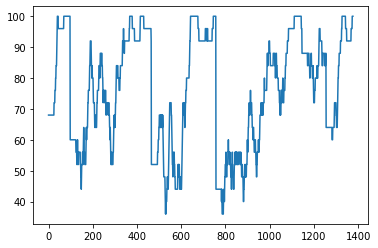

In [104]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [105]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [106]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==5).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 2718) (659,) (659,)


In [110]:
keep_idx = np.argwhere(new_m_per>75).flatten()

RA_X = new_X[keep_idx]
RA_X = RA_X[:,:,::8]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(353, 48, 340) (353,)


In [111]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
_y = RA_Y[order]
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y2 = tmp[order]
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
_y3 = tmp[order]

In [113]:
acc = np.zeros((17,3))
for i in range(17):
    rates = _x[:, :, :(i+1)*20]
    print(f"Saccade Decoding for 0 to {(i+1)*20}")
    _, acc[i,0],_,_ = kfold_pred(sess_id,rates,_y2, name = 'sac', verbose=0) #saccade
    print(f"Color Decoding for 0 to {(i+1)*20}")
    _, acc[i,1],_,_ = kfold_pred(sess_id,rates,_y3, name = 'col', verbose=0) #color
    print(f"Rule Decoding for 0 to {(i+1)*20}")
    _, acc[i,2],_,_ = kfold_pred(sess_id,rates,_y, name = 'rul', verbose=0) #rule

Saccade Decoding for 0 to 20
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 84.98583569405099%
Color Decoding for 0 to 20
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 60.906515580736546%
Rule Decoding for 0 to 20
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 44.475920679886684%
Saccade Decoding for 0 to 40
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ over

	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 82.71954674220963%
Rule Decoding for 0 to 220
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 71.95467422096317%
Saccade Decoding for 0 to 240
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 89.23512747875354%
Color Decoding for 0 to 240
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 82.152974

Text(0, 0.5, 'Performance')

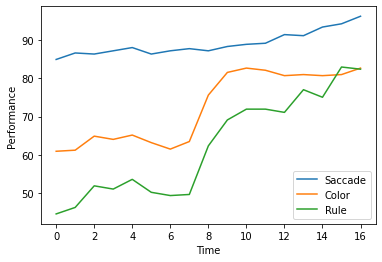

In [117]:
plt.plot(acc[:,0], label='Saccade')
plt.plot(acc[:,1], label='Color')
plt.plot(acc[:,2], label='Rule')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Performance')

## Test on Unlearned Trials

In [11]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
tmp = np.array(segmented_data[2][1]['axes'][0]['data']['PosY'])
sac_pos = np.vstack((np.array(segmented_data[2][1]['axes'][0]['data']['PosX']), tmp))
sac_pos = np.transpose(sac_pos)
tmp = np.array(segmented_data[2][1]['axes'][0]['data']['TargetY'])
target_pos = np.vstack((np.array(segmented_data[2][1]['axes'][0]['data']['TargetX']), tmp))
target_pos = np.transpose(target_pos)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
print(f'Rates shape before downsampling: {X_conv.shape}')
X_conv = X_conv[:,::10,:]
print(f'Rates shape after downsampling: {X_conv.shape}')
X_conv = np.transpose(X_conv, (0, 2, 1))
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

Rates shape before downsampling: (1377, 2718, 48)
Rates shape after downsampling: (1377, 272, 48)
[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 48, 272)
(1377,) 0 6


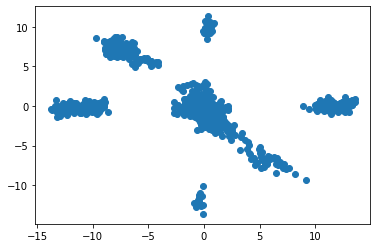

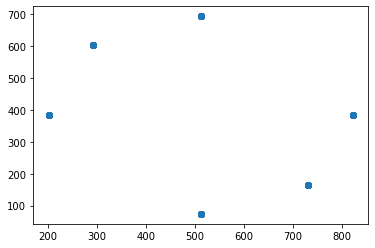

In [12]:
plt.scatter(sac_pos[:,0], sac_pos[:,1])
plt.figure()
plt.scatter(target_pos[:,0], target_pos[:,1])

In [17]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

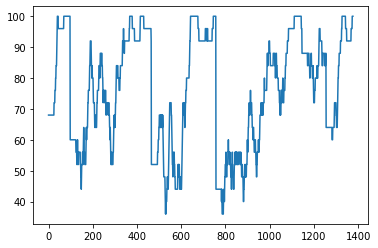

In [18]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [13]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [14]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==5).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 272) (659,) (659,)


In [15]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(394, 48, 272) (394,)


In [16]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
_y = RA_Y[order]
lr_id = np.argwhere(RA_Y==0)
lg_id = np.argwhere(RA_Y==1)
lb_id = np.argwhere(RA_Y==2)
rb_id = np.argwhere(RA_Y==3)
rr_id = np.argwhere(RA_Y==4)
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id = np.argwhere(tmp==1)
left_id = np.argwhere(tmp==0)
_y2 = tmp[order]
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
r_id = np.argwhere(tmp==0)
b_id = np.argwhere(tmp==1)
g_id = np.argwhere(tmp==2)
_y3 = tmp[order]

In [17]:
print(f"Saccade Decoding for learned trials:")
_, _,_,_ = kfold_pred(sess_id,_x,_y2, name = 'sac_l', verbose=0) #saccade
print(f"Color Decoding for learned trials:")
_, _,_,_ = kfold_pred(sess_id,_x,_y3, name = 'col_l', verbose=0) #color
print(f"Rule Decoding for learned trials:")
_, _,_,_ = kfold_pred(sess_id,_x,_y, name = 'rul_l', verbose=0) #rule

Saccade Decoding for unlearned trials:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 91.87817258883248%
Color Decoding for unlearned trials:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 83.50253807106598%
Rule Decoding for unlearned trials:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 80.20304568527919%


In [25]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(159, 48, 272) (159,)


In [19]:
_x = RA_X
_y = RA_Y
lr_id_ul = np.argwhere(RA_Y==0)
lg_id_ul = np.argwhere(RA_Y==1)
lb_id_ul = np.argwhere(RA_Y==2)
rb_id_ul = np.argwhere(RA_Y==3)
rr_id_ul = np.argwhere(RA_Y==4)
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id_ul = np.argwhere(tmp==1)
left_id_ul = np.argwhere(tmp==0)
_y2 = tmp
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
r_id_ul = np.argwhere(tmp==0)
b_id_ul = np.argwhere(tmp==1)
g_id_ul = np.argwhere(tmp==2)
_y3 = tmp

In [20]:
acc_ul = np.zeros(3)
model = tf.keras.models.load_model("sac_l_sra3_1_j_051_00+_split0.h5")
sac_pred = model.predict(_x)
tmp = np.argmax(sac_pred, axis=1)
acc_ul[0] = 100 * np.sum(tmp == _y2) / len(tmp)
print(f"Saccade model trained on learned trials and tested on naive trials: {acc_ul[0]}") #saccade
model = tf.keras.models.load_model("col_l_sra3_1_j_051_00+_split0.h5")
col_pred = model.predict(_x)
tmp = np.argmax(col_pred, axis=1)
acc_ul[1] = 100 * np.sum(tmp == _y3) / len(tmp)
print(f"Color model trained on learned trials and tested on naive trials: {acc_ul[1]}") #color
model = tf.keras.models.load_model("rul_l_sra3_1_j_051_00+_split0.h5")
rul_pred = model.predict(_x)
tmp = np.argmax(rul_pred, axis=1)
acc_ul[2] = 100 * np.sum(tmp == _y) / len(tmp)
print(f"Rule model trained on learned trials and tested on naive trials: {acc_ul[2]}") #rule

Saccade model trained on learned trials and tested on naive trials: 56.60377358490566
Color model trained on learned trials and tested on naive trials: 53.459119496855344
Rule model trained on learned trials and tested on naive trials: 33.333333333333336


In [21]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(394, 48, 272) (394,)


In [22]:
_x = RA_X
_y = RA_Y
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y2 = tmp
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
_y3 = tmp

In [23]:
model = tf.keras.models.load_model("sac_l_sra3_1_j_051_00+_split0.h5")
sac_pred_l = model.predict(_x)
model = tf.keras.models.load_model("col_l_sra3_1_j_051_00+_split0.h5")
col_pred_l = model.predict(_x)
model = tf.keras.models.load_model("rul_l_sra3_1_j_051_00+_split0.h5")
rul_pred_l = model.predict(_x)

In [39]:
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_sac_l = tsne_model.fit_transform(sac_pred_l)
tsne_sac = tsne_model.fit_transform(sac_pred)
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_col_l = tsne_model.fit_transform(col_pred_l)
tsne_col = tsne_model.fit_transform(col_pred)
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_rul_l = tsne_model.fit_transform(rul_pred_l)
tsne_rul = tsne_model.fit_transform(rul_pred)

In [82]:
tsne_sac.shape

(159, 2)

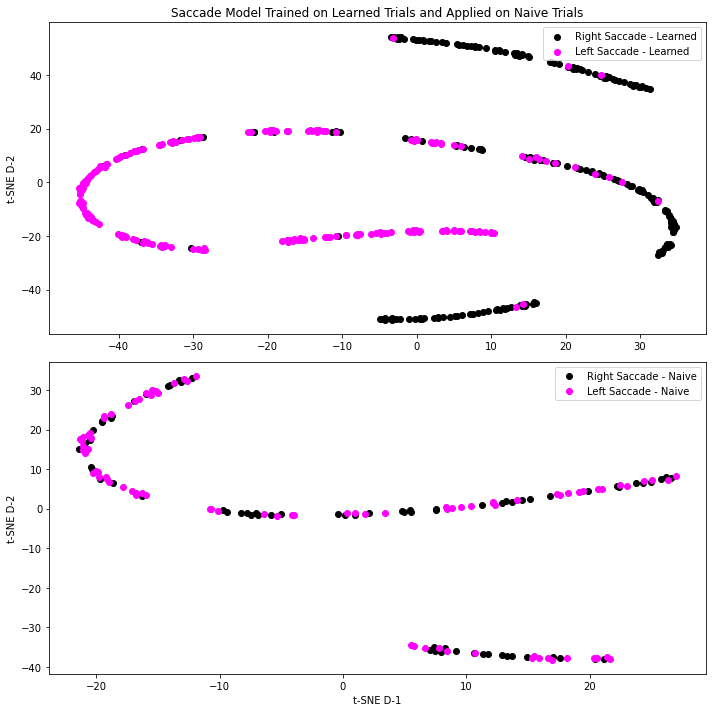

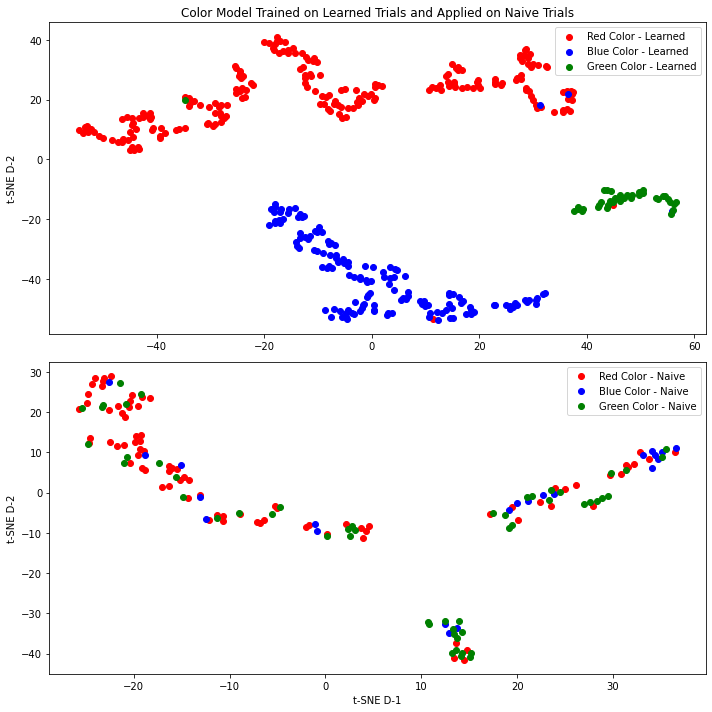

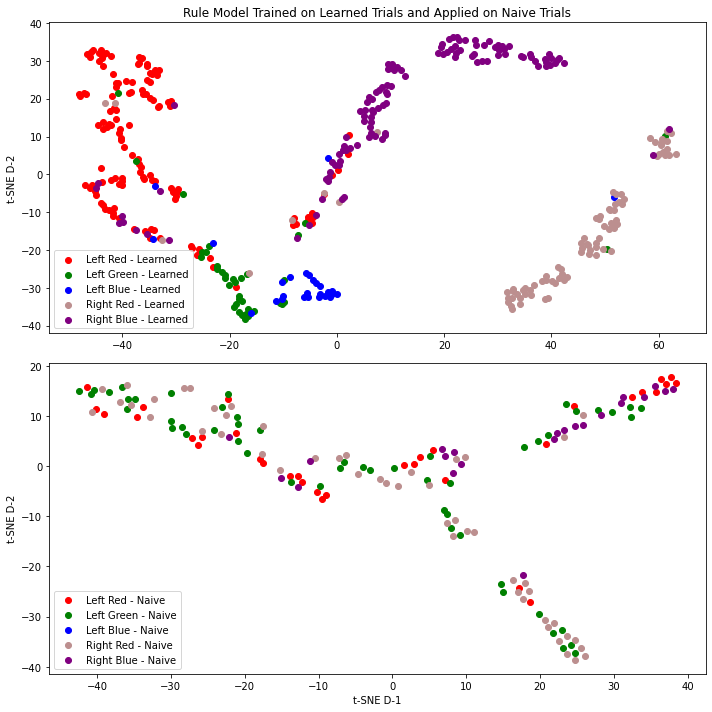

In [41]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_sac_l[right_id, 0], y=tsne_sac_l[right_id, 1], color='black', label='Right Saccade - Learned')
plt.scatter(x=tsne_sac_l[left_id, 0], y=tsne_sac_l[left_id, 1], color='magenta', label='Left Saccade - Learned')
plt.title("Saccade Model Trained on Learned Trials and Applied on Naive Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_sac[right_id_ul, 0], y=tsne_sac[right_id_ul, 1], color='black', label='Right Saccade - Naive')
plt.scatter(x=tsne_sac[left_id_ul, 0], y=tsne_sac[left_id_ul, 1], color='magenta', label='Left Saccade - Naive')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("saccade_tsne.svg")

fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_col_l[r_id, 0], y=tsne_col_l[r_id, 1], color='red', label='Red Color - Learned')
plt.scatter(x=tsne_col_l[b_id, 0], y=tsne_col_l[b_id, 1], color='blue', label='Blue Color - Learned')
plt.scatter(x=tsne_col_l[g_id, 0], y=tsne_col_l[g_id, 1], color='green', label='Green Color - Learned')
plt.title("Color Model Trained on Learned Trials and Applied on Naive Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_col[r_id_ul, 0], y=tsne_col[r_id_ul, 1], color='red', label='Red Color - Naive')
plt.scatter(x=tsne_col[b_id_ul, 0], y=tsne_col[b_id_ul, 1], color='blue', label='Blue Color - Naive')
plt.scatter(x=tsne_col[g_id_ul, 0], y=tsne_col[g_id_ul, 1], color='green', label='Green Color - Naive')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("color_tsne.svg")

fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_rul_l[lr_id, 0], y=tsne_rul_l[lr_id, 1], color='red', label='Left Red - Learned')
plt.scatter(x=tsne_rul_l[lg_id, 0], y=tsne_rul_l[lg_id, 1], color='green', label='Left Green - Learned')
plt.scatter(x=tsne_rul_l[lb_id, 0], y=tsne_rul_l[lb_id, 1], color='blue', label='Left Blue - Learned')
plt.scatter(x=tsne_rul_l[rr_id, 0], y=tsne_rul_l[rr_id, 1], color='rosybrown', label='Right Red - Learned')
plt.scatter(x=tsne_rul_l[rb_id, 0], y=tsne_rul_l[rb_id, 1], color='purple', label='Right Blue - Learned')
plt.title("Rule Model Trained on Learned Trials and Applied on Naive Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_rul[lr_id_ul, 0], y=tsne_rul[lr_id_ul, 1], color='red', label='Left Red - Naive')
plt.scatter(x=tsne_rul[lg_id_ul, 0], y=tsne_rul[lg_id_ul, 1], color='green', label='Left Green - Naive')
plt.scatter(x=tsne_rul[lb_id_ul, 0], y=tsne_rul[lb_id_ul, 1], color='blue', label='Left Blue - Naive')
plt.scatter(x=tsne_rul[rr_id_ul, 0], y=tsne_rul[rr_id_ul, 1], color='rosybrown', label='Right Red - Naive')
plt.scatter(x=tsne_rul[rb_id_ul, 0], y=tsne_rul[rb_id_ul, 1], color='purple', label='Right Blue - Naive')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("rule_tsne.svg")

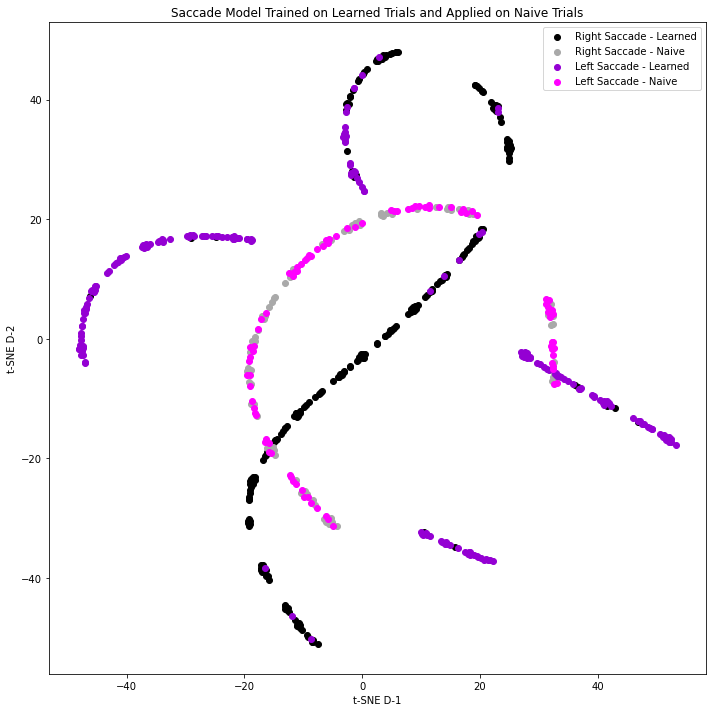

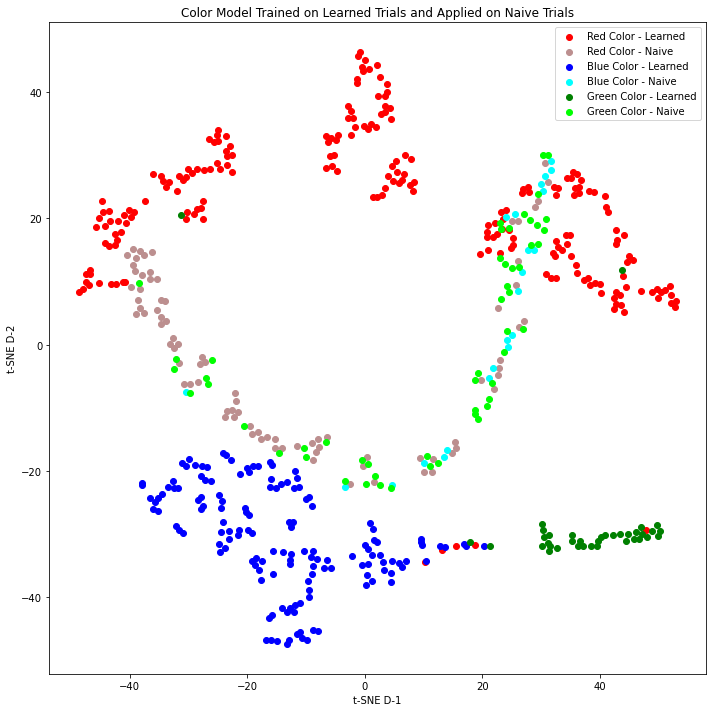

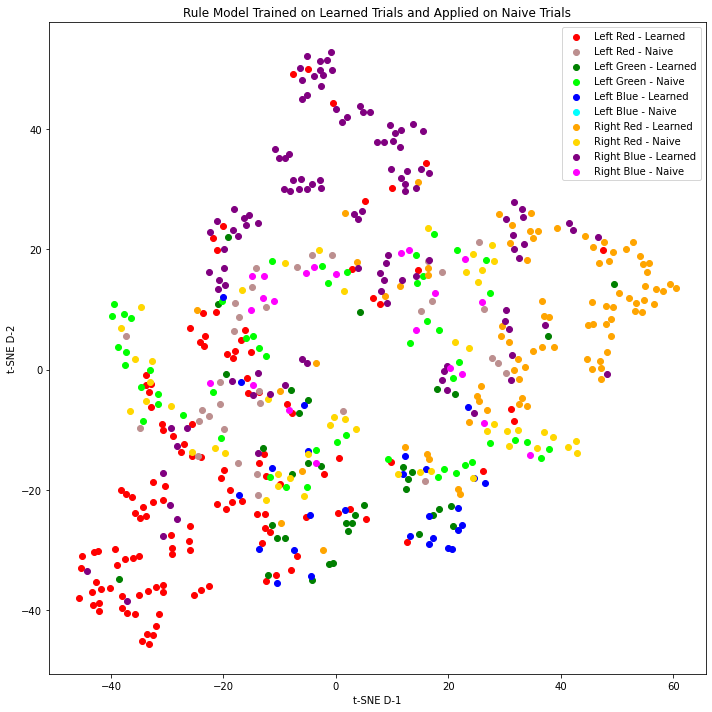

In [90]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(x=tsne_sac_l[right_id, 0], y=tsne_sac_l[right_id, 1], color='black', label='Right Saccade - Learned')
plt.scatter(x=tsne_sac[right_id_ul, 0], y=tsne_sac[right_id_ul, 1], color='darkgrey', label='Right Saccade - Naive')
plt.scatter(x=tsne_sac_l[left_id, 0], y=tsne_sac_l[left_id, 1], color='darkviolet', label='Left Saccade - Learned')
plt.scatter(x=tsne_sac[left_id_ul, 0], y=tsne_sac[left_id_ul, 1], color='magenta', label='Left Saccade - Naive')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.title("Saccade Model Trained on Learned Trials and Applied on Naive Trials")
plt.legend()
plt.tight_layout()

fig = plt.figure(figsize=(10, 10))
plt.scatter(x=tsne_col_l[r_id, 0], y=tsne_col_l[r_id, 1], color='red', label='Red Color - Learned')
plt.scatter(x=tsne_col[r_id_ul, 0], y=tsne_col[r_id_ul, 1], color='rosybrown', label='Red Color - Naive')
plt.scatter(x=tsne_col_l[b_id, 0], y=tsne_col_l[b_id, 1], color='blue', label='Blue Color - Learned')
plt.scatter(x=tsne_col[b_id_ul, 0], y=tsne_col[b_id_ul, 1], color='cyan', label='Blue Color - Naive')
plt.scatter(x=tsne_col_l[g_id, 0], y=tsne_col_l[g_id, 1], color='green', label='Green Color - Learned')
plt.scatter(x=tsne_col[g_id_ul, 0], y=tsne_col[g_id_ul, 1], color='lime', label='Green Color - Naive')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.title("Color Model Trained on Learned Trials and Applied on Naive Trials")
plt.legend()
plt.tight_layout()

fig = plt.figure(figsize=(10, 10))
plt.scatter(x=tsne_rul_l[lr_id, 0], y=tsne_rul_l[lr_id, 1], color='red', label='Left Red - Learned')
plt.scatter(x=tsne_rul[lr_id_ul, 0], y=tsne_rul[lr_id_ul, 1], color='rosybrown', label='Left Red - Naive')
plt.scatter(x=tsne_rul_l[lg_id, 0], y=tsne_rul_l[lg_id, 1], color='green', label='Left Green - Learned')
plt.scatter(x=tsne_rul[lg_id_ul, 0], y=tsne_rul[lg_id_ul, 1], color='lime', label='Left Green - Naive')
plt.scatter(x=tsne_rul_l[lb_id, 0], y=tsne_rul_l[lb_id, 1], color='blue', label='Left Blue - Learned')
plt.scatter(x=tsne_rul[lb_id_ul, 0], y=tsne_rul[lb_id_ul, 1], color='cyan', label='Left Blue - Naive')
plt.scatter(x=tsne_rul_l[rr_id, 0], y=tsne_rul_l[rr_id, 1], color='orange', label='Right Red - Learned')
plt.scatter(x=tsne_rul[rr_id_ul, 0], y=tsne_rul[rr_id_ul, 1], color='gold', label='Right Red - Naive')
plt.scatter(x=tsne_rul_l[rb_id, 0], y=tsne_rul_l[rb_id, 1], color='purple', label='Right Blue - Learned')
plt.scatter(x=tsne_rul[rb_id_ul, 0], y=tsne_rul[rb_id_ul, 1], color='magenta', label='Right Blue - Naive')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.title("Rule Model Trained on Learned Trials and Applied on Naive Trials")
plt.legend()
plt.tight_layout()

In [42]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

_x_ul = new_X[keep_idx]
_y_ul = new_label[keep_idx]

keep_idx = np.argwhere(new_m_per > 70).flatten()

_x_l = new_X[keep_idx]
_y_l = new_label[keep_idx]

In [45]:
_y_l

array([0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 0, 3, 0, 3, 3,
       3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 0, 3,
       0, 0, 0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3,
       3, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0,
       3, 3, 0, 3, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0,
       3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3,
       3, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0,
       0, 3, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0,
       3, 3, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3,
       0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 0, 0, 0,
       3, 0, 1, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1,
       1, 1, 1, 1, 4, 1, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 1, 1, 4,
       1, 4, 1, 4, 4, 4, 1, 1, 1, 4, 4, 1, 1, 1, 4,

In [64]:
sac_conf = np.zeros((2,2))
sac_conf_ul = np.zeros((2,2))
col_conf = np.zeros((3,3))
col_conf_ul = np.zeros((3,3))
rul_conf = np.zeros((5,5))
rul_conf_ul = np.zeros((5,5))
tmp = np.argmax(sac_pred_l, axis=1)
sac_conf[0,0] = np.sum(np.argmax(sac_pred_l, axis=1)[right_id]==1)
sac_conf[0,1] = np.sum(np.argmax(sac_pred_l, axis=1)[right_id]==0)
sac_conf[1,0] = np.sum(np.argmax(sac_pred_l, axis=1)[left_id]==1)
sac_conf[1,1] = np.sum(np.argmax(sac_pred_l, axis=1)[left_id]==0)
print(f"Saccade Learned C.M.: {sac_conf}")
sac_conf_ul[0,0] = np.sum(np.argmax(sac_pred, axis=1)[right_id_ul]==1)
sac_conf_ul[0,1] = np.sum(np.argmax(sac_pred, axis=1)[right_id_ul]==0)
sac_conf_ul[1,0] = np.sum(np.argmax(sac_pred, axis=1)[left_id_ul]==1)
sac_conf_ul[1,1] = np.sum(np.argmax(sac_pred, axis=1)[left_id_ul]==0)
print(f"Saccade Unlearned C.M.: {sac_conf_ul}")
col_conf[0,0] = np.sum(np.argmax(col_pred_l, axis=1)[r_id]==0)
col_conf[0,1] = np.sum(np.argmax(col_pred_l, axis=1)[r_id]==1)
col_conf[0,2] = np.sum(np.argmax(col_pred_l, axis=1)[r_id]==2)
col_conf[1,0] = np.sum(np.argmax(col_pred_l, axis=1)[b_id]==0)
col_conf[1,1] = np.sum(np.argmax(col_pred_l, axis=1)[b_id]==1)
col_conf[1,2] = np.sum(np.argmax(col_pred_l, axis=1)[b_id]==2)
col_conf[2,0] = np.sum(np.argmax(col_pred_l, axis=1)[g_id]==0)
col_conf[2,1] = np.sum(np.argmax(col_pred_l, axis=1)[g_id]==1)
col_conf[2,2] = np.sum(np.argmax(col_pred_l, axis=1)[g_id]==2)
print(f"Color Learned C.M.: {col_conf}")
col_conf_ul[0,0] = np.sum(np.argmax(col_pred, axis=1)[r_id_ul]==0)
col_conf_ul[0,1] = np.sum(np.argmax(col_pred, axis=1)[r_id_ul]==1)
col_conf_ul[0,2] = np.sum(np.argmax(col_pred, axis=1)[r_id_ul]==2)
col_conf_ul[1,0] = np.sum(np.argmax(col_pred, axis=1)[b_id_ul]==0)
col_conf_ul[1,1] = np.sum(np.argmax(col_pred, axis=1)[b_id_ul]==1)
col_conf_ul[1,2] = np.sum(np.argmax(col_pred, axis=1)[b_id_ul]==2)
col_conf_ul[2,0] = np.sum(np.argmax(col_pred, axis=1)[g_id_ul]==0)
col_conf_ul[2,1] = np.sum(np.argmax(col_pred, axis=1)[g_id_ul]==1)
col_conf_ul[2,2] = np.sum(np.argmax(col_pred, axis=1)[g_id_ul]==2)
print(f"Color Unlearned C.M.: {col_conf_ul}")
tmp = [lr_id, lg_id, lb_id, rb_id, rr_id]
tmp2 = [lr_id_ul, lg_id_ul, lb_id_ul, rb_id_ul, rr_id_ul]
for i in range(5):
    rul_conf[i,0] = np.sum(np.argmax(rul_pred_l, axis=1)[tmp[i]]==0)
    rul_conf[i,1] = np.sum(np.argmax(rul_pred_l, axis=1)[tmp[i]]==1)
    rul_conf[i,2] = np.sum(np.argmax(rul_pred_l, axis=1)[tmp[i]]==2)
    rul_conf[i,3] = np.sum(np.argmax(rul_pred_l, axis=1)[tmp[i]]==3)
    rul_conf[i,4] = np.sum(np.argmax(rul_pred_l, axis=1)[tmp[i]]==4)
    
    rul_conf_ul[i,0] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==0)
    rul_conf_ul[i,1] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==1)
    rul_conf_ul[i,2] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==2)
    rul_conf_ul[i,3] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==3)
    rul_conf_ul[i,4] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==4)
print(f"Rule Learned C.M.: {rul_conf}")
print(f"Rule Unlearned C.M.: {rul_conf_ul}")

Saccade Learned C.M.: [[186.  17.]
 [ 18. 173.]]
Saccade Unlearned C.M.: [[33. 39.]
 [30. 57.]]
Color Learned C.M.: [[211.   1.   1.]
 [  2. 141.   1.]
 [  1.   0.  36.]]
Color Unlearned C.M.: [[59. 21.  4.]
 [ 7. 12.  3.]
 [21. 18. 14.]]
Rule Learned C.M.: [[121.   1.   0.   5.   0.]
 [ 15.  19.   0.   0.   3.]
 [  5.   6.  13.   1.   2.]
 [ 13.   0.   0. 101.   3.]
 [  4.   0.   0.   2.  80.]]
Rule Unlearned C.M.: [[24.  0.  0.  8.  2.]
 [33.  2.  0. 10.  8.]
 [ 0.  0.  0.  0.  0.]
 [10.  0.  0. 12.  0.]
 [28.  4.  1.  2. 15.]]


In [56]:
sac_pred_l.shape

(394, 2)

In [54]:
np.sum(np.argmax(sac_pred_l, axis=1)[left_id]==0)

173

In [ ]:
conf_prob = np.zeros((11,11))
for i in range(np.max(pred_true)+1):
    tot = np.sum(pred_score[np.argwhere(pred_true==i)])
    tmp = np.sum(pred_score[np.argwhere(pred_true==i)], axis=0)
    conf_prob[i] = tmp / tot

In [95]:
for i in range(11):
    print(f'Label {i} Accuracy: {a[i,1]/a[i,0]}')

Label 0 Accuracy: 1.0
Label 1 Accuracy: 0.9714285714285714
Label 2 Accuracy: 0.7222222222222222
Label 3 Accuracy: 0.7751937984496124
Label 4 Accuracy: 0.8188976377952756
Label 5 Accuracy: 0.5135135135135135
Label 6 Accuracy: 0.6666666666666666
Label 7 Accuracy: 0.8290598290598291
Label 8 Accuracy: 0.8372093023255814
Label 9 Accuracy: 0.7837837837837838
Label 10 Accuracy: 0.5423728813559322


In [96]:
print(b)

[[ 38.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.  34.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  26.   1.   0.   0.   0.   0.   0.   5.   4.]
 [  0.   0.   3. 100.   0.   0.   0.   0.   0.  12.  14.]
 [  0.   0.   0.   0. 104.   7.   1.   9.   6.   0.   0.]
 [  0.   0.   0.   0.  10.  19.   2.   2.   4.   0.   0.]
 [  0.   0.   0.   0.   4.   1.  18.   2.   2.   0.   0.]
 [  0.   0.   0.   0.  13.   0.   1.  97.   6.   0.   0.]
 [  0.   0.   0.   0.   6.   0.   2.   6.  72.   0.   0.]
 [  0.   0.   7.  20.   0.   0.   0.   0.   0. 116.   5.]
 [  0.   0.   4.  20.   0.   0.   0.   0.   0.   3.  32.]]


## Saccade Position (DNN and SVM both ways for train and test)

In [9]:
test_sess_ix = 2

sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
print(f'Rates shape before downsampling: {X_conv.shape}')
X_conv = X_conv[:,::10,:]
print(f'Rates shape after downsampling: {X_conv.shape}')
X_conv = np.transpose(X_conv, (0, 2, 1))
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()
sac_class = np.array(segmented_data[2][1]['axes'][0]['data']['sacClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(sac_class.shape)
print(Y.shape, min(Y), max(Y))

Rates shape before downsampling: (1377, 2718, 48)
Rates shape after downsampling: (1377, 272, 48)
[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 48, 272)
(1377,)
(1377,) 0 6


In [10]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

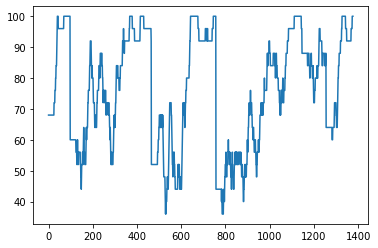

In [11]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [21]:
tmp = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
np.unique(tmp, return_counts=True)

(array([0, 1, 2, 4, 5, 6]), array([ 45, 302, 322,  54, 317, 337]))

In [26]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [27]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(sac_class, del_idx, axis=0)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)


print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 272) (659,) (659,)


In [32]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(272, 48, 272) (272,)


In [33]:
RA_Y

array([6, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6,
       2, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 6,
       6, 6, 2, 2, 2, 6, 6, 6, 6, 2, 6, 2, 6, 2, 2, 2, 6, 6, 2, 2, 2, 2,
       6, 6, 6, 2, 2, 2, 6, 6, 2, 6, 2, 2, 6, 6, 6, 6, 2, 6, 2, 2, 2, 6,
       2, 2, 6, 6, 6, 6, 2, 2, 2, 6, 6, 2, 6, 2, 6, 6, 2, 6, 6, 6, 6, 2,
       2, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 2, 6, 2, 2, 2, 2, 2, 2, 6,
       2, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 2, 2, 6, 6, 2, 6, 6, 2, 2, 2, 6,
       2, 2, 2, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 2, 2, 6, 6, 2, 2, 6, 2,
       2, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 6, 2, 2, 2, 2, 2, 6, 2,
       6, 6, 2, 2, 2, 6, 2, 6, 6, 6, 2, 6, 2, 6, 2, 6, 2, 2, 2, 6, 6, 2,
       2, 2, 2, 2, 6, 2, 6, 6, 6, 2, 2, 2, 2, 6, 2, 2, 2, 6, 2, 2, 6, 2,
       6, 2, 6, 6, 2, 2, 2, 2])

In [34]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id = np.argwhere(tmp==0)
left_id = np.argwhere(tmp==1)
_y = tmp[order]

In [35]:
print(f"Saccade Position Decoding for learned trials:")
_, _,_,_ = kfold_pred(sess_id,_x,_y, name = 'sac_pos_l', verbose=0) #saccade

Saccade Position Decoding for learned trials:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 100.0%


In [37]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(128, 48, 272) (128,)


In [38]:
_x = RA_X
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id_ul = np.argwhere(tmp==0)
left_id_ul = np.argwhere(tmp==1)
_y = tmp

In [39]:
model = tf.keras.models.load_model("sac_pos_l_sra3_1_j_051_00+_split0.h5")
sac_pred = model.predict(_x)
tmp = np.argmax(sac_pred, axis=1)
acc_ul = 100 * np.sum(tmp == _y) / len(tmp)
print(f"Saccade model trained on learned trials and tested on naive trials: {acc_ul}") #saccade

Saccade model trained on learned trials and tested on naive trials: 90.625


In [40]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(272, 48, 272) (272,)


In [41]:
_x = RA_X
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y = tmp

In [42]:
model = tf.keras.models.load_model("sac_pos_l_sra3_1_j_051_00+_split0.h5")
sac_pred_l = model.predict(_x)

In [43]:
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_sac_l = tsne_model.fit_transform(sac_pred_l)
tsne_sac = tsne_model.fit_transform(sac_pred)

In [44]:
tsne_sac.shape

(128, 2)

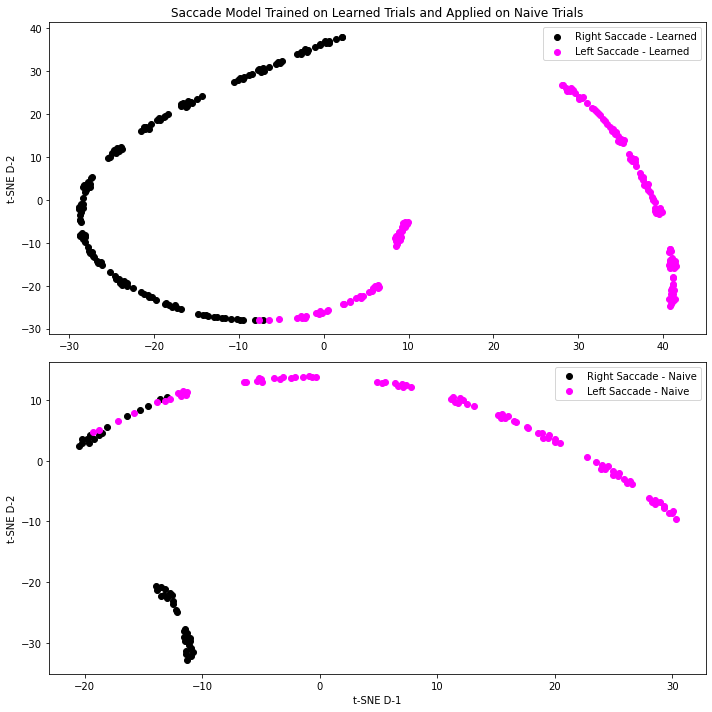

In [51]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_sac_l[right_id, 0], y=tsne_sac_l[right_id, 1], color='black', label='Right Saccade - Learned')
plt.scatter(x=tsne_sac_l[left_id, 0], y=tsne_sac_l[left_id, 1], color='magenta', label='Left Saccade - Learned')
plt.title("Saccade Model Trained on Learned Trials and Applied on Naive Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_sac[right_id_ul, 0], y=tsne_sac[right_id_ul, 1], color='black', label='Right Saccade - Naive')
plt.scatter(x=tsne_sac[left_id_ul, 0], y=tsne_sac[left_id_ul, 1], color='magenta', label='Left Saccade - Naive')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("saccade_pos_tsne_lon_dnn.svg")

In [47]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

_x_ul = new_X[keep_idx]
_y_ul = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
_x_ul = RA_X[keep_idx]
_y_ul = RA_Y[keep_idx]

keep_idx = np.argwhere(new_m_per > 70).flatten()

_x_l = new_X[keep_idx]
_y_l = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
_x_l = RA_X[keep_idx]
_y_l = RA_Y[keep_idx]

In [50]:
sac_conf = np.zeros((2,2))
sac_conf_ul = np.zeros((2,2))
tmp = np.argmax(sac_pred_l, axis=1)
sac_conf[0,0] = np.sum(np.argmax(sac_pred_l, axis=1)[right_id]==0)
sac_conf[0,1] = np.sum(np.argmax(sac_pred_l, axis=1)[right_id]==1)
sac_conf[1,0] = np.sum(np.argmax(sac_pred_l, axis=1)[left_id]==0)
sac_conf[1,1] = np.sum(np.argmax(sac_pred_l, axis=1)[left_id]==1)
print(f"Saccade Learned C.M.: {sac_conf}")
sac_conf_ul[0,0] = np.sum(np.argmax(sac_pred, axis=1)[right_id_ul]==0)
sac_conf_ul[0,1] = np.sum(np.argmax(sac_pred, axis=1)[right_id_ul]==1)
sac_conf_ul[1,0] = np.sum(np.argmax(sac_pred, axis=1)[left_id_ul]==0)
sac_conf_ul[1,1] = np.sum(np.argmax(sac_pred, axis=1)[left_id_ul]==1)
print(f"Saccade Unlearned C.M.: {sac_conf_ul}")

Saccade Learned C.M.: [[139.   0.]
 [  1. 132.]]
Saccade Unlearned C.M.: [[42.  0.]
 [12. 74.]]


# ----------------------------------------------------------------------

In [52]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [53]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(sac_class, del_idx, axis=0)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)


print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 272) (659,) (659,)


In [54]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(128, 48, 272) (128,)


In [33]:
RA_Y

array([6, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6,
       2, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 6, 2, 6, 6,
       6, 6, 2, 2, 2, 6, 6, 6, 6, 2, 6, 2, 6, 2, 2, 2, 6, 6, 2, 2, 2, 2,
       6, 6, 6, 2, 2, 2, 6, 6, 2, 6, 2, 2, 6, 6, 6, 6, 2, 6, 2, 2, 2, 6,
       2, 2, 6, 6, 6, 6, 2, 2, 2, 6, 6, 2, 6, 2, 6, 6, 2, 6, 6, 6, 6, 2,
       2, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 2, 2, 6, 2, 2, 2, 2, 2, 2, 6,
       2, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 2, 2, 6, 6, 2, 6, 6, 2, 2, 2, 6,
       2, 2, 2, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 2, 2, 6, 6, 2, 2, 6, 2,
       2, 2, 6, 2, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 6, 2, 2, 2, 2, 2, 6, 2,
       6, 6, 2, 2, 2, 6, 2, 6, 6, 6, 2, 6, 2, 6, 2, 6, 2, 2, 2, 6, 6, 2,
       2, 2, 2, 2, 6, 2, 6, 6, 6, 2, 2, 2, 2, 6, 2, 2, 2, 6, 2, 2, 6, 2,
       6, 2, 6, 6, 2, 2, 2, 2])

In [55]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id = np.argwhere(tmp==0)
left_id = np.argwhere(tmp==1)
_y = tmp[order]

In [56]:
print(f"Saccade Position Decoding for learned trials:")
_, _,_,_ = kfold_pred(sess_id,_x,_y, name = 'sac_pos_ul', verbose=0) #saccade

Saccade Position Decoding for learned trials:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 100.0%


In [64]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(272, 48, 272) (272,)


In [65]:
_x = RA_X
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id_l = np.argwhere(tmp==0)
left_id_l = np.argwhere(tmp==1)
_y = tmp

In [59]:
model = tf.keras.models.load_model("sac_pos_ul_sra3_1_j_051_00+_split0.h5")
sac_pred = model.predict(_x)
tmp = np.argmax(sac_pred, axis=1)
acc_ul = 100 * np.sum(tmp == _y) / len(tmp)
print(f"Saccade model trained on unlearned trials and tested on learned trials: {acc_ul}") #saccade

Saccade model trained on unlearned trials and tested on learned trials: 97.42647058823529


In [60]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(128, 48, 272) (128,)


In [61]:
_x = RA_X
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y = tmp

In [62]:
model = tf.keras.models.load_model("sac_pos_ul_sra3_1_j_051_00+_split0.h5")
sac_pred_ul = model.predict(_x)

In [63]:
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_sac_ul = tsne_model.fit_transform(sac_pred_ul)
tsne_sac = tsne_model.fit_transform(sac_pred)

In [44]:
tsne_sac.shape

(128, 2)

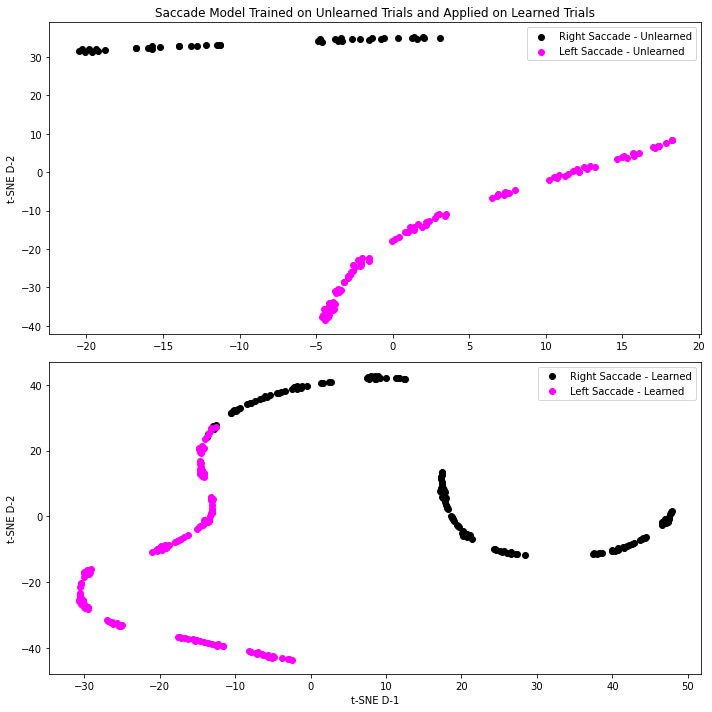

In [66]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_sac_ul[right_id, 0], y=tsne_sac_ul[right_id, 1], color='black', label='Right Saccade - Unlearned')
plt.scatter(x=tsne_sac_ul[left_id, 0], y=tsne_sac_ul[left_id, 1], color='magenta', label='Left Saccade - Unlearned')
plt.title("Saccade Model Trained on Unlearned Trials and Applied on Learned Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_sac[right_id_l, 0], y=tsne_sac[right_id_l, 1], color='black', label='Right Saccade - Learned')
plt.scatter(x=tsne_sac[left_id_l, 0], y=tsne_sac[left_id_l, 1], color='magenta', label='Left Saccade - Learned')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("saccade_pos_tsne_nol_dnn.svg")

In [47]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

_x_ul = new_X[keep_idx]
_y_ul = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
_x_ul = RA_X[keep_idx]
_y_ul = RA_Y[keep_idx]

keep_idx = np.argwhere(new_m_per > 70).flatten()

_x_l = new_X[keep_idx]
_y_l = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
_x_l = RA_X[keep_idx]
_y_l = RA_Y[keep_idx]

In [68]:
sac_conf = np.zeros((2,2))
sac_conf_ul = np.zeros((2,2))
tmp = np.argmax(sac_pred_l, axis=1)
sac_conf[0,0] = np.sum(np.argmax(sac_pred, axis=1)[right_id_l]==0)
sac_conf[0,1] = np.sum(np.argmax(sac_pred, axis=1)[right_id_l]==1)
sac_conf[1,0] = np.sum(np.argmax(sac_pred, axis=1)[left_id_l]==0)
sac_conf[1,1] = np.sum(np.argmax(sac_pred, axis=1)[left_id_l]==1)
print(f"Saccade Learned C.M.: {sac_conf}")
sac_conf_ul[0,0] = np.sum(np.argmax(sac_pred_ul, axis=1)[right_id]==0)
sac_conf_ul[0,1] = np.sum(np.argmax(sac_pred_ul, axis=1)[right_id]==1)
sac_conf_ul[1,0] = np.sum(np.argmax(sac_pred_ul, axis=1)[left_id]==0)
sac_conf_ul[1,1] = np.sum(np.argmax(sac_pred_ul, axis=1)[left_id]==1)
print(f"Saccade Unlearned C.M.: {sac_conf_ul}")

Saccade Learned C.M.: [[132.   7.]
 [  0. 133.]]
Saccade Unlearned C.M.: [[42.  0.]
 [ 0. 86.]]


# --------------------------------------------------------------------------
### SVM

In [69]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [70]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(sac_class, del_idx, axis=0)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)


print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 272) (659,) (659,)


In [79]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(272, 48, 272) (272,)


In [80]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id = np.argwhere(tmp==0)
left_id = np.argwhere(tmp==1)
_y = tmp[order]

In [81]:
print(f"Saccade Position Decoding for learned trials by SVM:")
from sklearn.svm import SVC
from sklearn.model_selection import KFold

N_SPLITS = 10

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
X = np.reshape(_x, (_x.shape[0], -1))
i = 1
y_pred = np.zeros_like(_y)
y_true = np.zeros_like(_y)

for train_index, test_index in kf.split(X):
    print(f"\tSplit {i} of {N_SPLITS}")
    x_tr, x_ts = X[train_index], X[test_index]
    y_tr, y_ts = _y[train_index], _y[test_index]
    clf = SVC(verbose=0,probability=True).fit(x_tr, y_tr)
    y_pred[test_index] = clf.predict(x_ts)
    y_true[test_index] = y_ts
    acc = np.sum(y_pred[test_index]==y_true[test_index])/len(y_true)
    i+=1

print (f'The SVM Accuracy is: {np.sum(y_pred==y_true)/len(y_true)}')

Saccade Position Decoding for learned trials by SVM:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
The SVM Accuracy is: 0.9705882352941176


In [82]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(128, 48, 272) (128,)


In [83]:
_x = RA_X
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id_ul = np.argwhere(tmp==0)
left_id_ul = np.argwhere(tmp==1)
_y = tmp

In [84]:
X = np.reshape(_x, (_x.shape[0], -1))
sac_pred = clf.predict_proba(X)
tmp = np.argmax(sac_pred, axis=1)
acc_ul = 100 * np.sum(tmp == _y) / len(tmp)
print(f"Saccade SVM model trained on learned trials and tested on naive trials: {acc_ul}") #saccade

Saccade SVM model trained on learned trials and tested on naive trials: 98.4375


In [85]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(272, 48, 272) (272,)


In [86]:
_x = RA_X
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y = tmp

In [88]:
X = np.reshape(_x, (_x.shape[0], -1))
sac_pred_l = clf.predict_proba(X)

In [89]:
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_sac_l = tsne_model.fit_transform(sac_pred_l)
tsne_sac = tsne_model.fit_transform(sac_pred)

In [90]:
tsne_sac.shape

(128, 2)

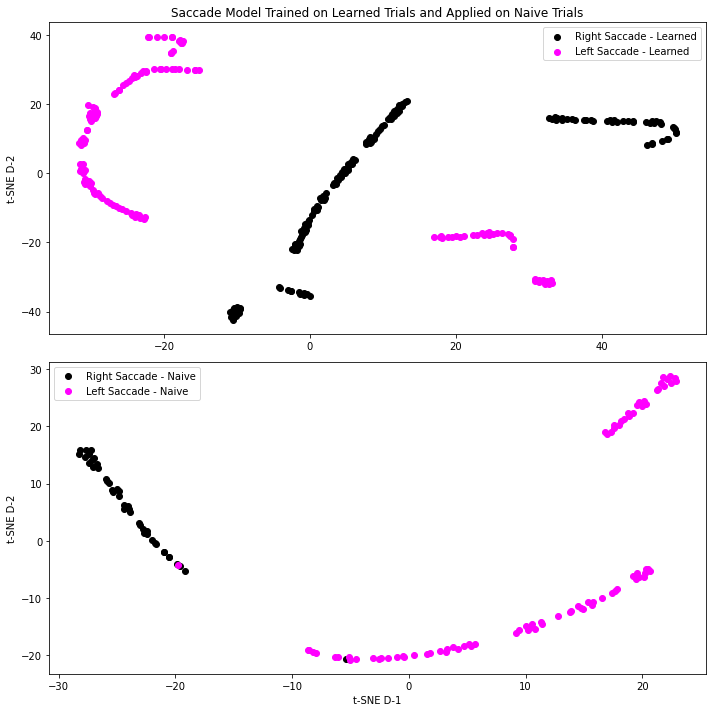

In [91]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_sac_l[right_id, 0], y=tsne_sac_l[right_id, 1], color='black', label='Right Saccade - Learned')
plt.scatter(x=tsne_sac_l[left_id, 0], y=tsne_sac_l[left_id, 1], color='magenta', label='Left Saccade - Learned')
plt.title("Saccade Model Trained on Learned Trials and Applied on Naive Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_sac[right_id_ul, 0], y=tsne_sac[right_id_ul, 1], color='black', label='Right Saccade - Naive')
plt.scatter(x=tsne_sac[left_id_ul, 0], y=tsne_sac[left_id_ul, 1], color='magenta', label='Left Saccade - Naive')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("saccade_pos_tsne_lon_svm.svg")

In [92]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

_x_ul = new_X[keep_idx]
_y_ul = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
_x_ul = RA_X[keep_idx]
_y_ul = RA_Y[keep_idx]

keep_idx = np.argwhere(new_m_per > 70).flatten()

_x_l = new_X[keep_idx]
_y_l = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
_x_l = RA_X[keep_idx]
_y_l = RA_Y[keep_idx]

In [93]:
sac_conf = np.zeros((2,2))
sac_conf_ul = np.zeros((2,2))
tmp = np.argmax(sac_pred_l, axis=1)
sac_conf[0,0] = np.sum(np.argmax(sac_pred_l, axis=1)[right_id]==0)
sac_conf[0,1] = np.sum(np.argmax(sac_pred_l, axis=1)[right_id]==1)
sac_conf[1,0] = np.sum(np.argmax(sac_pred_l, axis=1)[left_id]==0)
sac_conf[1,1] = np.sum(np.argmax(sac_pred_l, axis=1)[left_id]==1)
print(f"Saccade Learned C.M.: {sac_conf}")
sac_conf_ul[0,0] = np.sum(np.argmax(sac_pred, axis=1)[right_id_ul]==0)
sac_conf_ul[0,1] = np.sum(np.argmax(sac_pred, axis=1)[right_id_ul]==1)
sac_conf_ul[1,0] = np.sum(np.argmax(sac_pred, axis=1)[left_id_ul]==0)
sac_conf_ul[1,1] = np.sum(np.argmax(sac_pred, axis=1)[left_id_ul]==1)
print(f"Saccade Unlearned C.M.: {sac_conf_ul}")

Saccade Learned C.M.: [[139.   0.]
 [  0. 133.]]
Saccade Unlearned C.M.: [[41.  1.]
 [ 1. 85.]]


# ----------------------------------------------------------------------

In [94]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [95]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(sac_class, del_idx, axis=0)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)


print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 272) (659,) (659,)


In [96]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(128, 48, 272) (128,)


In [97]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id = np.argwhere(tmp==0)
left_id = np.argwhere(tmp==1)
_y = tmp[order]

In [98]:
print(f"Saccade Position Decoding for unlearned trials by SVM:")
from sklearn.svm import SVC
from sklearn.model_selection import KFold

N_SPLITS = 10

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=0)
X = np.reshape(_x, (_x.shape[0], -1))
i = 1
y_pred = np.zeros_like(_y)
y_true = np.zeros_like(_y)

for train_index, test_index in kf.split(X):
    print(f"\tSplit {i} of {N_SPLITS}")
    x_tr, x_ts = X[train_index], X[test_index]
    y_tr, y_ts = _y[train_index], _y[test_index]
    clf = SVC(verbose=0,probability=True).fit(x_tr, y_tr)
    y_pred[test_index] = clf.predict(x_ts)
    y_true[test_index] = y_ts
    acc = np.sum(y_pred[test_index]==y_true[test_index])/len(y_true)
    i+=1

print (f'The SVM Accuracy is: {np.sum(y_pred==y_true)/len(y_true)}')

Saccade Position Decoding for unlearned trials by SVM:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10
The SVM Accuracy is: 0.8203125


In [99]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(272, 48, 272) (272,)


In [100]:
_x = RA_X
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id_l = np.argwhere(tmp==0)
left_id_l = np.argwhere(tmp==1)
_y = tmp

In [101]:
X = np.reshape(_x, (_x.shape[0], -1))
sac_pred = clf.predict_proba(X)
tmp = np.argmax(sac_pred, axis=1)
acc_ul = 100 * np.sum(tmp == _y) / len(tmp)
print(f"Saccade model trained on unlearned trials and tested on learned trials: {acc_ul}") #saccade

Saccade model trained on unlearned trials and tested on learned trials: 96.69117647058823


In [102]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
RA_X = RA_X[keep_idx]
RA_Y = RA_Y[keep_idx]
print(RA_X.shape, RA_Y.shape)

(128, 48, 272) (128,)


In [103]:
_x = RA_X
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y = tmp

In [105]:
X = np.reshape(_x, (_x.shape[0], -1))
sac_pred_ul = clf.predict_proba(X)

In [106]:
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_sac_ul = tsne_model.fit_transform(sac_pred_ul)
tsne_sac = tsne_model.fit_transform(sac_pred)

In [107]:
tsne_sac.shape

(272, 2)

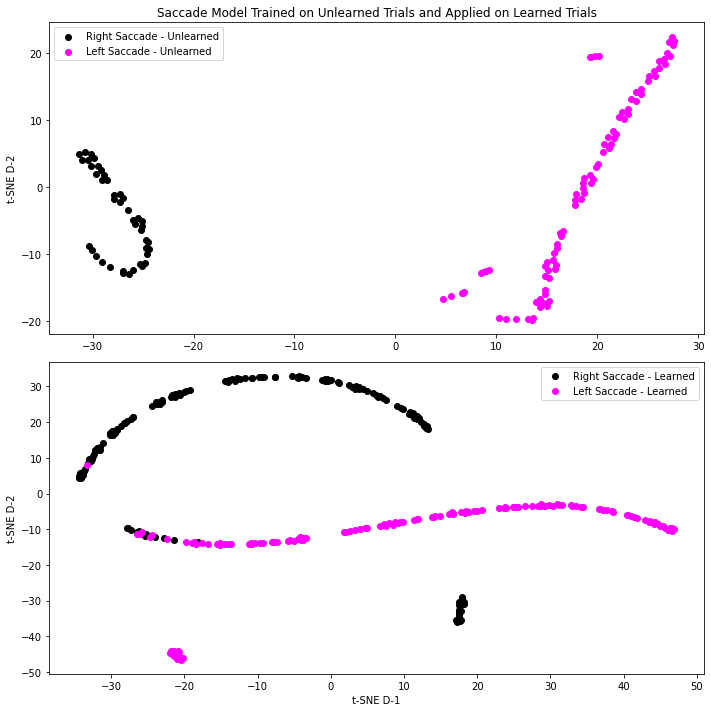

In [108]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_sac_ul[right_id, 0], y=tsne_sac_ul[right_id, 1], color='black', label='Right Saccade - Unlearned')
plt.scatter(x=tsne_sac_ul[left_id, 0], y=tsne_sac_ul[left_id, 1], color='magenta', label='Left Saccade - Unlearned')
plt.title("Saccade Model Trained on Unlearned Trials and Applied on Learned Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_sac[right_id_l, 0], y=tsne_sac[right_id_l, 1], color='black', label='Right Saccade - Learned')
plt.scatter(x=tsne_sac[left_id_l, 0], y=tsne_sac[left_id_l, 1], color='magenta', label='Left Saccade - Learned')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("saccade_pos_tsne_nol_svm.svg")

In [109]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

_x_ul = new_X[keep_idx]
_y_ul = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
_x_ul = RA_X[keep_idx]
_y_ul = RA_Y[keep_idx]

keep_idx = np.argwhere(new_m_per > 70).flatten()

_x_l = new_X[keep_idx]
_y_l = new_label[keep_idx]
keep_idx = np.argwhere(RA_Y>0).flatten()
_x_l = RA_X[keep_idx]
_y_l = RA_Y[keep_idx]

In [110]:
sac_conf = np.zeros((2,2))
sac_conf_ul = np.zeros((2,2))
tmp = np.argmax(sac_pred_l, axis=1)
sac_conf[0,0] = np.sum(np.argmax(sac_pred, axis=1)[right_id_l]==0)
sac_conf[0,1] = np.sum(np.argmax(sac_pred, axis=1)[right_id_l]==1)
sac_conf[1,0] = np.sum(np.argmax(sac_pred, axis=1)[left_id_l]==0)
sac_conf[1,1] = np.sum(np.argmax(sac_pred, axis=1)[left_id_l]==1)
print(f"Saccade Learned C.M.: {sac_conf}")
sac_conf_ul[0,0] = np.sum(np.argmax(sac_pred_ul, axis=1)[right_id]==0)
sac_conf_ul[0,1] = np.sum(np.argmax(sac_pred_ul, axis=1)[right_id]==1)
sac_conf_ul[1,0] = np.sum(np.argmax(sac_pred_ul, axis=1)[left_id]==0)
sac_conf_ul[1,1] = np.sum(np.argmax(sac_pred_ul, axis=1)[left_id]==1)
print(f"Saccade Unlearned C.M.: {sac_conf_ul}")

Saccade Learned C.M.: [[138.   1.]
 [  8. 125.]]
Saccade Unlearned C.M.: [[42.  0.]
 [ 0. 86.]]


## Train on Naive, Test on Learned

In [8]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
print(f'Rates shape before downsampling: {X_conv.shape}')
X_conv = X_conv[:,::10,:]
print(f'Rates shape after downsampling: {X_conv.shape}')
X_conv = np.transpose(X_conv, (0, 2, 1))
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

Rates shape before downsampling: (1377, 2718, 48)
Rates shape after downsampling: (1377, 272, 48)
[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 48, 272)
(1377,) 0 6


In [9]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

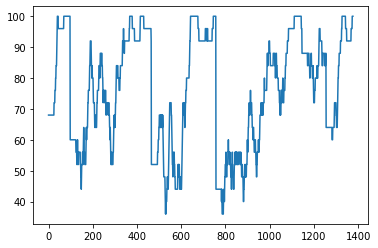

In [10]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [11]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [12]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==5).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 272) (659,) (659,)


In [13]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(159, 48, 272) (159,)


In [14]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
_y = RA_Y[order]
lr_id = np.argwhere(RA_Y==0)
lg_id = np.argwhere(RA_Y==1)
lb_id = np.argwhere(RA_Y==2)
rb_id = np.argwhere(RA_Y==3)
rr_id = np.argwhere(RA_Y==4)
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id = np.argwhere(tmp==1)
left_id = np.argwhere(tmp==0)
_y2 = tmp[order]
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
r_id = np.argwhere(tmp==0)
b_id = np.argwhere(tmp==1)
g_id = np.argwhere(tmp==2)
_y3 = tmp[order]

In [16]:
EPOCHS = 50

In [18]:
print(f"Saccade Decoding for learned trials:")
_, _,_,_ = kfold_pred(sess_id,_x,_y2, name = 'sac_ul', verbose=0) #saccade
print(f"Color Decoding for learned trials:")
_, _,_,_ = kfold_pred(sess_id,_x,_y3, name = 'col_ul', verbose=0) #color
print(f"Rule Decoding for learned trials:")
_, _,_,_ = kfold_pred(sess_id,_x,_y, name = 'rul_ul', verbose=0) #rule

Saccade Decoding for learned trials:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 76.72955974842768%
Color Decoding for learned trials:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 69.18238993710692%
Rule Decoding for learned trials:
	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 62.893081761006286%


In [19]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(394, 48, 272) (394,)


In [20]:
_x = RA_X
_y = RA_Y
lr_id_l = np.argwhere(RA_Y==0)
lg_id_l = np.argwhere(RA_Y==1)
lb_id_l = np.argwhere(RA_Y==2)
rb_id_l = np.argwhere(RA_Y==3)
rr_id_l = np.argwhere(RA_Y==4)
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id_l = np.argwhere(tmp==1)
left_id_l = np.argwhere(tmp==0)
_y2 = tmp
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
r_id_l = np.argwhere(tmp==0)
b_id_l = np.argwhere(tmp==1)
g_id_l = np.argwhere(tmp==2)
_y3 = tmp

In [22]:
acc_l = np.zeros(3)
model = tf.keras.models.load_model("sac_ul_sra3_1_j_051_00+_split0.h5")
sac_pred = model.predict(_x)
tmp = np.argmax(sac_pred, axis=1)
acc_l[0] = 100 * np.sum(tmp == _y2) / len(tmp)
print(f"Saccade model trained on unlearned trials and tested on learned trials: {acc_l[0]}") #saccade
model = tf.keras.models.load_model("col_ul_sra3_1_j_051_00+_split0.h5")
col_pred = model.predict(_x)
tmp = np.argmax(col_pred, axis=1)
acc_l[1] = 100 * np.sum(tmp == _y3) / len(tmp)
print(f"Color model trained on unlearned trials and tested on learned trials: {acc_l[1]}") #color
model = tf.keras.models.load_model("rul_ul_sra3_1_j_051_00+_split0.h5")
rul_pred = model.predict(_x)
tmp = np.argmax(rul_pred, axis=1)
acc_l[2] = 100 * np.sum(tmp == _y) / len(tmp)
print(f"Rule model trained on unlearned trials and tested on learned trials: {acc_l[2]}") #rule

Saccade model trained on unlearned trials and tested on learned trials: 56.09137055837564
Color model trained on unlearned trials and tested on learned trials: 27.15736040609137
Rule model trained on unlearned trials and tested on learned trials: 31.472081218274113


In [23]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(159, 48, 272) (159,)


In [24]:
_x = RA_X
_y = RA_Y
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
_y2 = tmp
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
_y3 = tmp

In [25]:
model = tf.keras.models.load_model("sac_ul_sra3_1_j_051_00+_split0.h5")
sac_pred_ul = model.predict(_x)
model = tf.keras.models.load_model("col_ul_sra3_1_j_051_00+_split0.h5")
col_pred_ul = model.predict(_x)
model = tf.keras.models.load_model("rul_ul_sra3_1_j_051_00+_split0.h5")
rul_pred_ul = model.predict(_x)

In [26]:
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_sac_ul = tsne_model.fit_transform(sac_pred_ul)
tsne_sac = tsne_model.fit_transform(sac_pred)
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_col_ul = tsne_model.fit_transform(col_pred_ul)
tsne_col = tsne_model.fit_transform(col_pred)
tsne_model = TSNE(n_components=2, perplexity=10)
tsne_rul_ul = tsne_model.fit_transform(rul_pred_ul)
tsne_rul = tsne_model.fit_transform(rul_pred)

In [27]:
tsne_sac.shape

(394, 2)

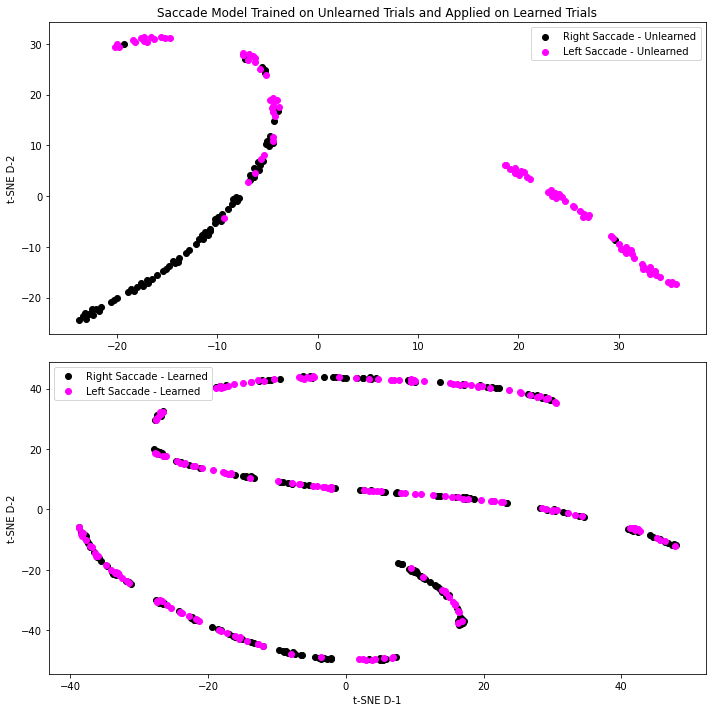

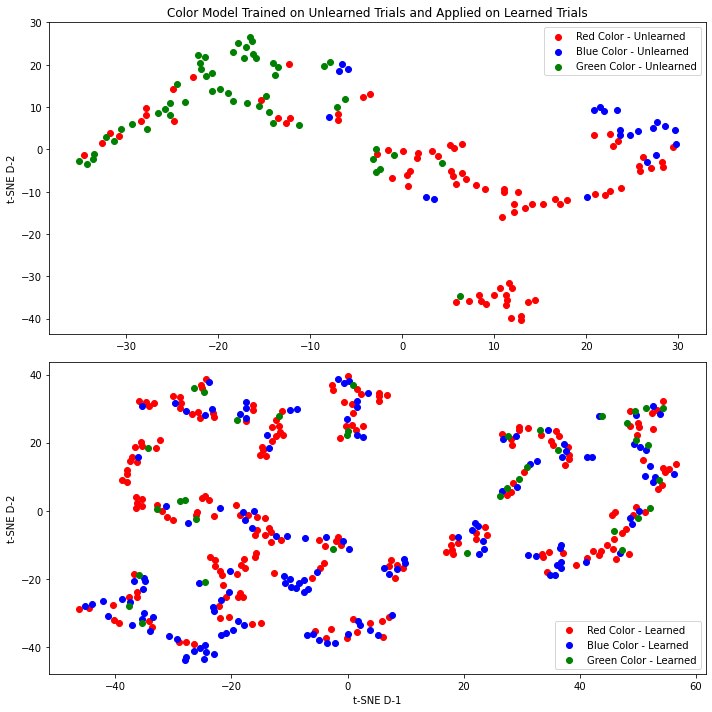

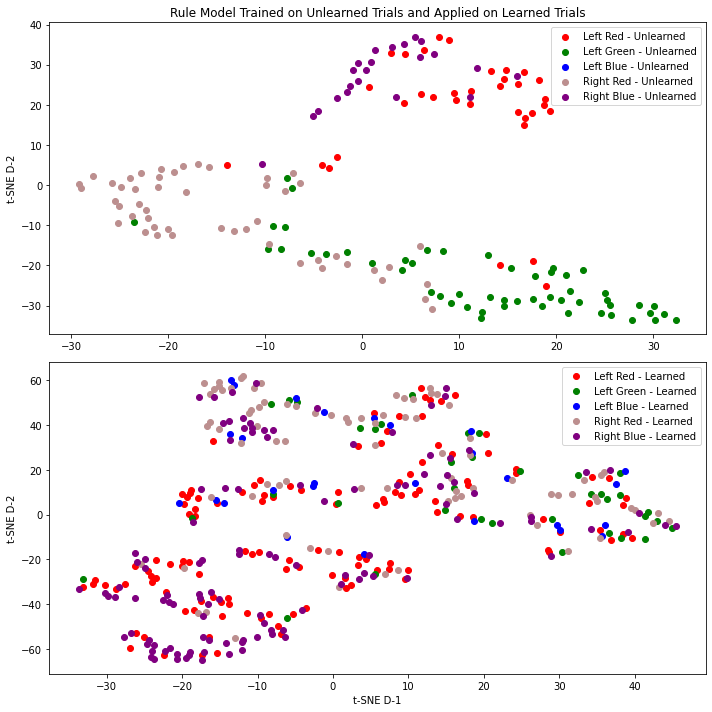

In [28]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_sac_ul[right_id, 0], y=tsne_sac_ul[right_id, 1], color='black', label='Right Saccade - Unlearned')
plt.scatter(x=tsne_sac_ul[left_id, 0], y=tsne_sac_ul[left_id, 1], color='magenta', label='Left Saccade - Unlearned')
plt.title("Saccade Model Trained on Unlearned Trials and Applied on Learned Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_sac[right_id_l, 0], y=tsne_sac[right_id_l, 1], color='black', label='Right Saccade - Learned')
plt.scatter(x=tsne_sac[left_id_l, 0], y=tsne_sac[left_id_l, 1], color='magenta', label='Left Saccade - Learned')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("saccade_tsne_ul.svg")

fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_col_ul[r_id, 0], y=tsne_col_ul[r_id, 1], color='red', label='Red Color - Unlearned')
plt.scatter(x=tsne_col_ul[b_id, 0], y=tsne_col_ul[b_id, 1], color='blue', label='Blue Color - Unlearned')
plt.scatter(x=tsne_col_ul[g_id, 0], y=tsne_col_ul[g_id, 1], color='green', label='Green Color - Unlearned')
plt.title("Color Model Trained on Unlearned Trials and Applied on Learned Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_col[r_id_l, 0], y=tsne_col[r_id_l, 1], color='red', label='Red Color - Learned')
plt.scatter(x=tsne_col[b_id_l, 0], y=tsne_col[b_id_l, 1], color='blue', label='Blue Color - Learned')
plt.scatter(x=tsne_col[g_id_l, 0], y=tsne_col[g_id_l, 1], color='green', label='Green Color - Learned')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("color_tsne_ul.svg")

fig = plt.figure(figsize=(10, 10))
plt.subplot(2,1,1)
plt.scatter(x=tsne_rul_ul[lr_id, 0], y=tsne_rul_ul[lr_id, 1], color='red', label='Left Red - Unlearned')
plt.scatter(x=tsne_rul_ul[lg_id, 0], y=tsne_rul_ul[lg_id, 1], color='green', label='Left Green - Unlearned')
plt.scatter(x=tsne_rul_ul[lb_id, 0], y=tsne_rul_ul[lb_id, 1], color='blue', label='Left Blue - Unlearned')
plt.scatter(x=tsne_rul_ul[rr_id, 0], y=tsne_rul_ul[rr_id, 1], color='rosybrown', label='Right Red - Unlearned')
plt.scatter(x=tsne_rul_ul[rb_id, 0], y=tsne_rul_ul[rb_id, 1], color='purple', label='Right Blue - Unlearned')
plt.title("Rule Model Trained on Unlearned Trials and Applied on Learned Trials")
plt.legend()
plt.ylabel('t-SNE D-2')
plt.subplot(2,1,2)
plt.scatter(x=tsne_rul[lr_id_l, 0], y=tsne_rul[lr_id_l, 1], color='red', label='Left Red - Learned')
plt.scatter(x=tsne_rul[lg_id_l, 0], y=tsne_rul[lg_id_l, 1], color='green', label='Left Green - Learned')
plt.scatter(x=tsne_rul[lb_id_l, 0], y=tsne_rul[lb_id_l, 1], color='blue', label='Left Blue - Learned')
plt.scatter(x=tsne_rul[rr_id_l, 0], y=tsne_rul[rr_id_l, 1], color='rosybrown', label='Right Red - Learned')
plt.scatter(x=tsne_rul[rb_id_l, 0], y=tsne_rul[rb_id_l, 1], color='purple', label='Right Blue - Learned')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.savefig("rule_tsne_ul.svg")

In [29]:
keep_idx = np.argwhere(new_m_per < 60).flatten()

_x_ul = new_X[keep_idx]
_y_ul = new_label[keep_idx]

keep_idx = np.argwhere(new_m_per > 70).flatten()

_x_l = new_X[keep_idx]
_y_l = new_label[keep_idx]

In [45]:
_y_l

array([0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 0, 3, 0, 3, 3,
       3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 0, 3,
       0, 0, 0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3,
       3, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0,
       3, 3, 0, 3, 0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 0,
       3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 3,
       3, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0,
       0, 3, 0, 3, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0,
       3, 3, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 3,
       0, 3, 0, 3, 0, 0, 0, 3, 0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 0, 0, 0,
       3, 0, 1, 1, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 1,
       1, 1, 1, 1, 4, 1, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 4, 4, 1, 1, 1, 4,
       1, 4, 1, 4, 4, 4, 1, 1, 1, 4, 4, 1, 1, 1, 4,

In [31]:
sac_conf = np.zeros((2,2))
sac_conf_l = np.zeros((2,2))
col_conf = np.zeros((3,3))
col_conf_l = np.zeros((3,3))
rul_conf = np.zeros((5,5))
rul_conf_l = np.zeros((5,5))
tmp = np.argmax(sac_pred_ul, axis=1)
sac_conf[0,0] = np.sum(np.argmax(sac_pred_ul, axis=1)[right_id]==1)
sac_conf[0,1] = np.sum(np.argmax(sac_pred_ul, axis=1)[right_id]==0)
sac_conf[1,0] = np.sum(np.argmax(sac_pred_ul, axis=1)[left_id]==1)
sac_conf[1,1] = np.sum(np.argmax(sac_pred_ul, axis=1)[left_id]==0)
print(f"Saccade Unlearned C.M.: {sac_conf}")
sac_conf_l[0,0] = np.sum(np.argmax(sac_pred, axis=1)[right_id_l]==1)
sac_conf_l[0,1] = np.sum(np.argmax(sac_pred, axis=1)[right_id_l]==0)
sac_conf_l[1,0] = np.sum(np.argmax(sac_pred, axis=1)[left_id_l]==1)
sac_conf_l[1,1] = np.sum(np.argmax(sac_pred, axis=1)[left_id_l]==0)
print(f"Saccade Learned C.M.: {sac_conf_l}")
col_conf[0,0] = np.sum(np.argmax(col_pred_ul, axis=1)[r_id]==0)
col_conf[0,1] = np.sum(np.argmax(col_pred_ul, axis=1)[r_id]==1)
col_conf[0,2] = np.sum(np.argmax(col_pred_ul, axis=1)[r_id]==2)
col_conf[1,0] = np.sum(np.argmax(col_pred_ul, axis=1)[b_id]==0)
col_conf[1,1] = np.sum(np.argmax(col_pred_ul, axis=1)[b_id]==1)
col_conf[1,2] = np.sum(np.argmax(col_pred_ul, axis=1)[b_id]==2)
col_conf[2,0] = np.sum(np.argmax(col_pred_ul, axis=1)[g_id]==0)
col_conf[2,1] = np.sum(np.argmax(col_pred_ul, axis=1)[g_id]==1)
col_conf[2,2] = np.sum(np.argmax(col_pred_ul, axis=1)[g_id]==2)
print(f"Color Unlearned C.M.: {col_conf}")
col_conf_l[0,0] = np.sum(np.argmax(col_pred, axis=1)[r_id_l]==0)
col_conf_l[0,1] = np.sum(np.argmax(col_pred, axis=1)[r_id_l]==1)
col_conf_l[0,2] = np.sum(np.argmax(col_pred, axis=1)[r_id_l]==2)
col_conf_l[1,0] = np.sum(np.argmax(col_pred, axis=1)[b_id_l]==0)
col_conf_l[1,1] = np.sum(np.argmax(col_pred, axis=1)[b_id_l]==1)
col_conf_l[1,2] = np.sum(np.argmax(col_pred, axis=1)[b_id_l]==2)
col_conf_l[2,0] = np.sum(np.argmax(col_pred, axis=1)[g_id_l]==0)
col_conf_l[2,1] = np.sum(np.argmax(col_pred, axis=1)[g_id_l]==1)
col_conf_l[2,2] = np.sum(np.argmax(col_pred, axis=1)[g_id_l]==2)
print(f"Color Learned C.M.: {col_conf_l}")
tmp = [lr_id, lg_id, lb_id, rb_id, rr_id]
tmp2 = [lr_id_l, lg_id_l, lb_id_l, rb_id_l, rr_id_l]
for i in range(5):
    rul_conf[i,0] = np.sum(np.argmax(rul_pred_ul, axis=1)[tmp[i]]==0)
    rul_conf[i,1] = np.sum(np.argmax(rul_pred_ul, axis=1)[tmp[i]]==1)
    rul_conf[i,2] = np.sum(np.argmax(rul_pred_ul, axis=1)[tmp[i]]==2)
    rul_conf[i,3] = np.sum(np.argmax(rul_pred_ul, axis=1)[tmp[i]]==3)
    rul_conf[i,4] = np.sum(np.argmax(rul_pred_ul, axis=1)[tmp[i]]==4)
    
    rul_conf_l[i,0] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==0)
    rul_conf_l[i,1] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==1)
    rul_conf_l[i,2] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==2)
    rul_conf_l[i,3] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==3)
    rul_conf_l[i,4] = np.sum(np.argmax(rul_pred, axis=1)[tmp2[i]]==4)
print(f"Rule Unearned C.M.: {rul_conf}")
print(f"Rule Learned C.M.: {rul_conf_l}")

Saccade Unlearned C.M.: [[63.  9.]
 [ 6. 81.]]
Saccade Learned C.M.: [[ 90. 113.]
 [ 60. 131.]]
Color Unlearned C.M.: [[62.  0. 22.]
 [11.  4.  7.]
 [ 5.  0. 48.]]
Color Learned C.M.: [[ 79.   0. 134.]
 [ 61.   0.  83.]
 [  9.   0.  28.]]
Rule Unearned C.M.: [[25.  2.  0.  3.  4.]
 [ 0. 35.  0.  0. 18.]
 [ 0.  0.  0.  0.  0.]
 [ 7.  0.  0. 13.  2.]
 [ 0.  1.  0.  0. 49.]]
Rule Learned C.M.: [[39. 10.  0.  8. 70.]
 [ 2.  9.  0.  1. 25.]
 [ 1.  4.  0.  0. 22.]
 [49.  8.  0.  6. 54.]
 [ 8.  8.  0.  0. 70.]]


## One model for saccade and rule

In [8]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
Y = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)
X = segmented_data[2][1]['data']
X = np.nan_to_num(X)
from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
print(f'Rates shape before downsampling: {X_conv.shape}')
X_conv = X_conv[:,::10,:]
print(f'Rates shape after downsampling: {X_conv.shape}')
X_conv = np.transpose(X_conv, (0, 2, 1))
block = np.array(segmented_data[2][1]['axes'][0]['data']['Block']).flatten()
b=np.diff(block, axis=0)
blck=np.array(np.where(b>0)).flatten()
color = np.array(segmented_data[2][1]['axes'][0]['data']['CueColour']).flatten()
target = np.array(segmented_data[2][1]['axes'][0]['data']['TargetRule']).flatten()
classes = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass']).flatten()

print (blck)
print(sess_id)
print(outcome.shape)
print(X_conv.shape)
print(Y.shape, min(Y), max(Y))

Rates shape before downsampling: (1377, 2718, 48)
Rates shape after downsampling: (1377, 272, 48)
[  98   99  389  465  466  684  757 1146 1147 1255]
sra3_1_j_051_00+
(1377,)
(1377, 48, 272)
(1377,) 0 6


In [9]:
border = np.array([98, 389, 465, 684, 757, 1146, 1255])

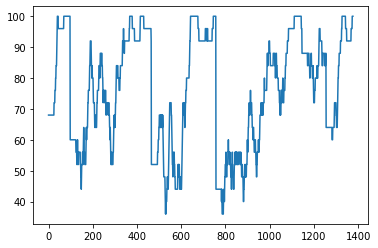

In [10]:
m_performance = np.zeros(len(outcome))
cor = 0
b=0
tot = 25
for i in range(tot):
    if outcome[i]==0:
        cor += 1

m_performance[:tot] = 100 * (cor / tot)
# for i in range(tot, len(outcome)):
i = tot
while i<len(outcome):
    if i == border[b]:
        cor = 0
        for j in range(tot):
            if outcome[i+j]==0:
                cor += 1
        m_performance[i:i+tot] = 100 * (cor / tot)
        i += tot
        b = (b+1)%len(border)
    elif outcome[i] == outcome[i-tot]:
        m_performance[i] = m_performance[i-1]
        i += 1
    elif outcome[i]==0:
        cor += 1
        m_performance[i] = 100 * (cor / tot)
        i += 1
    else:
        cor -= 1
        m_performance[i] = 100 * (cor / tot)
        i +=1

for i in range(len(m_performance)):
    if m_performance[i]<0:
        m_performance[i] = 0
plt.plot(m_performance)

In [11]:
label = np.zeros(len(outcome))
for i in range(len(label)):
    if (target[i]=='LL' and color[i]=='r'):
        label[i] = 5
    elif (target[i]=='LL' and color[i]=='g'):
        label[i] = 1
    elif (target[i]=='LL' and color[i]=='b'):
        label[i] = 2
    elif (target[i]=='RR' and color[i]=='b'):
        label[i] = 3
    elif (target[i]=='RR' and color[i]=='r'):
        label[i] = 4

In [12]:
del_idx = np.argwhere(label<1).flatten()

new_label = np.delete(label, del_idx)
new_X = np.delete(X_conv, del_idx, axis=0)
new_m_per = np.delete(m_performance, del_idx, axis=0)

zer_idx = np.argwhere(new_label==5).flatten()
new_label[zer_idx] = 0

print(new_X.shape, new_label.shape, new_m_per.shape)
new_label = new_label.astype(np.int64)

(659, 48, 272) (659,) (659,)


In [13]:
keep_idx = np.argwhere(new_m_per > 70).flatten()

RA_X = new_X[keep_idx]
RA_Y = new_label[keep_idx]
print(RA_X.shape, RA_Y.shape)

(394, 48, 272) (394,)


In [14]:
order = np.random.permutation(len(RA_X))
_x = RA_X[order]
_y = RA_Y[order]
lr_id = np.argwhere(RA_Y==0)
lg_id = np.argwhere(RA_Y==1)
lb_id = np.argwhere(RA_Y==2)
rb_id = np.argwhere(RA_Y==3)
rr_id = np.argwhere(RA_Y==4)
tmp = np.zeros_like(RA_Y)
idx = np.argwhere(RA_Y>2).flatten()
tmp[idx] = 1
right_id = np.argwhere(tmp==1)
left_id = np.argwhere(tmp==0)
_y2 = tmp[order]
tmp = np.zeros_like(RA_Y)
tmp[np.argwhere((RA_Y==2)|(RA_Y==3))] = 1
tmp[np.argwhere(RA_Y==1)] = 2
r_id = np.argwhere(tmp==0)
b_id = np.argwhere(tmp==1)
g_id = np.argwhere(tmp==2)
_y3 = tmp[order]

In [15]:
kfold_pred(sess_id,_x,_y2, name = 'sac', verbose=0) #saccade

	Split 1 of 10
	Split 2 of 10
	Split 3 of 10
	Split 4 of 10
	Split 5 of 10
	Split 6 of 10
	Split 7 of 10
	Split 8 of 10
	Split 9 of 10
	Split 10 of 10


Session sra3_1_j_051_00+ overall accuracy with CNN/LSTM Model: 92.38578680203045%


({'loss': [1.0645102262496948,
   0.982573926448822,
   0.8450168967247009,
   0.8117237091064453,
   0.8069311380386353,
   0.7944357395172119,
   0.7758997082710266,
   0.7755979895591736,
   0.7509845495223999,
   0.7326225638389587,
   0.7171359658241272,
   0.7282395958900452,
   0.6854200959205627,
   0.6837663650512695,
   0.683853805065155,
   0.6730870604515076,
   0.6836445927619934,
   0.6719208359718323,
   0.6592418551445007,
   0.6667543053627014,
   0.6462611556053162,
   0.6338270902633667,
   0.6152533292770386,
   0.6313460469245911,
   0.6041894555091858,
   0.6259766221046448,
   0.5958914160728455,
   0.6124846935272217,
   0.6017743945121765,
   0.5886783003807068,
   0.5707775950431824,
   0.5848214626312256,
   0.5752475261688232,
   0.5742844939231873,
   0.5685316920280457,
   0.5531023740768433,
   0.5495175123214722,
   0.5555067658424377,
   0.5523825287818909,
   0.5586550235748291,
   0.5512917041778564,
   0.5194547772407532,
   0.5214916467666626,
   0.

In [39]:
sac_model = tf.keras.models.load_model("sac_sra3_1_j_051_00+_split0.h5")
# inputs = tmp.input
tmp = tf.keras.Model(sac_model.input, sac_model.layers[-3].output)
_new_x = tmp(_x)
_new_x.shape
inputs = tf.keras.layers.Input(shape=_new_x.shape[1:])
_l = tf.keras.layers.Dense(64, activation='relu')(inputs)    
outputs = tf.keras.layers.Dense(5, activation='softmax')(_l)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 4,485
Trainable params: 4,485
Non-trainable params: 0
_________________________________________________________________


In [43]:
_y_c = tf.keras.utils.to_categorical(_y, num_classes=np.max(_y)+1)
x_tr = _new_x[:100]
y_tr = _y_c[:100]
x_val = _new_x[100:]
y_val = _y_c[100:]
print(np.unique(y_tr, return_counts=True))
print(np.unique(y_val, return_counts=True))

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(16, drop_remainder=True)
ds_valid = ds_valid.batch(16, drop_remainder=False)

optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=50, validation_data=ds_valid, verbose=1)

(array([0., 1.], dtype=float32), array([400, 100]))
(array([0., 1.], dtype=float32), array([1176,  294]))
Epoch 1/50
6/6 [==============================] - 0s 21ms/step - loss: 1.8529 - accuracy: 0.1942 - val_loss: 1.5667 - val_accuracy: 0.3163
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 1.6123 - accuracy: 0.2787 - val_loss: 1.4592 - val_accuracy: 0.4524
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.4641 - accuracy: 0.4323 - val_loss: 1.3942 - val_accuracy: 0.4966
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.3609 - accuracy: 0.4717 - val_loss: 1.3523 - val_accuracy: 0.5340
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.2845 - accuracy: 0.5317 - val_loss: 1.3259 - val_accuracy: 0.5442
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.2265 - accuracy: 0.5551 - val_loss: 1.3112 - val_accuracy: 0.5612
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - l

In [44]:
rul_pred = model.predict(_new_x)
tmp = np.argmax(rul_pred, axis=1)
acc = 100 * np.sum(tmp == _y) / len(tmp)
print(f"Saccade model applied on rules: {acc}") #rule

Saccade model applied on rules: 64.72081218274111


In [51]:
lr_id = np.argwhere(_y==0)
lg_id = np.argwhere(_y==1)
lb_id = np.argwhere(_y==2)
rb_id = np.argwhere(_y==3)
rr_id = np.argwhere(_y==4)
right_id = np.argwhere(_y2==1)
left_id = np.argwhere(_y2==0)

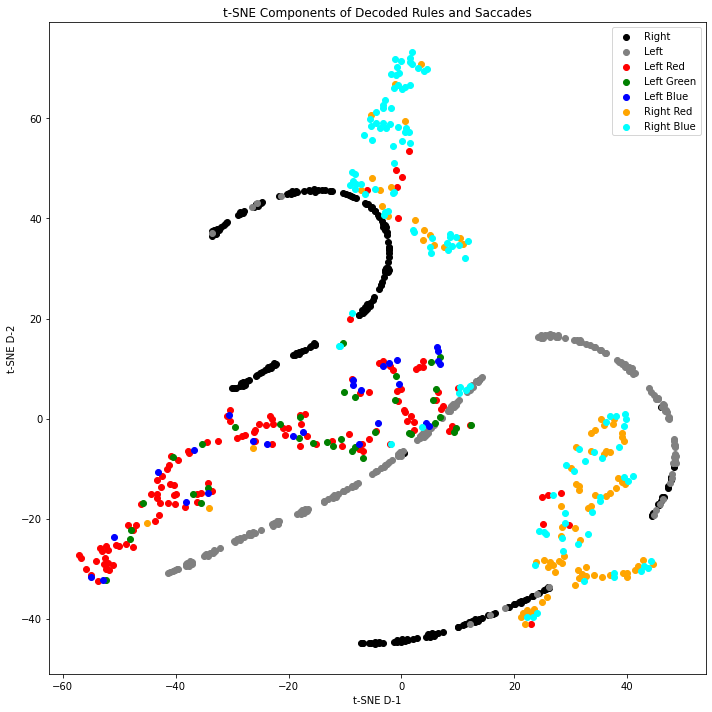

In [54]:
sac_pred = sac_model.predict(_x)

tsne_model = TSNE(n_components=2, perplexity=10)
tsne_rul = tsne_model.fit_transform(rul_pred)
tsne_sac = tsne_model.fit_transform(sac_pred)


fig = plt.figure(figsize=(10, 10))
plt.scatter(x=tsne_sac[right_id, 0], y=tsne_sac[right_id, 1], color='black', label='Right')
plt.scatter(x=tsne_sac[left_id, 0], y=tsne_sac[left_id, 1], color='grey', label='Left')
plt.scatter(x=tsne_rul[lr_id, 0], y=tsne_rul[lr_id, 1], color='red', label='Left Red')
plt.scatter(x=tsne_rul[lg_id, 0], y=tsne_rul[lg_id, 1], color='green', label='Left Green')
plt.scatter(x=tsne_rul[lb_id, 0], y=tsne_rul[lb_id, 1], color='blue', label='Left Blue')
plt.scatter(x=tsne_rul[rr_id, 0], y=tsne_rul[rr_id, 1], color='orange', label='Right Red')
plt.scatter(x=tsne_rul[rb_id, 0], y=tsne_rul[rb_id, 1], color='cyan', label='Right Blue')
plt.xlabel('t-SNE D-1')
plt.ylabel('t-SNE D-2')
ax = plt.gca()
plt.title("t-SNE Components of Decoded Rules and Saccades")
plt.legend()
plt.tight_layout()

In [50]:
sac_pred.shape

(394, 2)

# Transfer Learning

## Base Model Trained On J50_A

In [29]:
test_sess_ix = 1
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_050_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
tmp = segmented_data[2][1]['data']
tmp = np.nan_to_num(tmp)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
del_idx = np.argwhere(np.array(outcome)>0).flatten()
X = np.delete(tmp, del_idx, axis=0)
tmp = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y = np.delete(tmp, del_idx, axis=0)
Y = Y.astype(np.int64)
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)

from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]

print(f"Importing {sess_id}:")
print(f"X Shape: {X_conv.shape}, Y Shape: {Y.shape}")

Importing sra3_1_j_050_00+:
X Shape: (1016, 36, 136), Y Shape: (1016,)


In [30]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [31]:
x_tr = _x[:800]
tmp = _y[:800]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[800:]
tmp = _y[800:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=0)

## Testing on J37_A

In [22]:
test_sess_ix = 0
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_2_j_037_0003_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
tmp = segmented_data[2][1]['data']
tmp = np.nan_to_num(tmp)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
del_idx = np.argwhere(np.array(outcome)>0).flatten()
X = np.delete(tmp, del_idx, axis=0)
tmp = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y = np.delete(tmp, del_idx, axis=0)
Y = Y.astype(np.int64)
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)

from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
X_conv = np.concatenate((X_conv, X_conv, X_conv), axis = 1)
print(f"Importing {sess_id}:")
print(f"X Shape: {X_conv.shape}, Y Shape: {Y.shape}")

Importing sra3_2_j_037_00+03:
X Shape: (490, 36, 136), Y Shape: (490,)


In [23]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [24]:
x_tr = _x[:50]
x_val = _x[50:]
tmp = _y[:50]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
y_val = _y[50:]
ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

hist = model.fit(x=ds_train, epochs=EPOCHS, verbose=1)
y_pred = model.predict(x_val)
pred_y = np.argmax(y_pred, axis=1)
true_y = y_val
accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")

Epoch 1/150
3/3 [==============================] - 0s 20ms/step - loss: 2.5633 - accuracy: 0.1458
Epoch 2/150
3/3 [==============================] - 0s 19ms/step - loss: 1.7756 - accuracy: 0.3333
Epoch 3/150
3/3 [==============================] - 0s 19ms/step - loss: 1.4082 - accuracy: 0.6042
Epoch 4/150
3/3 [==============================] - 0s 19ms/step - loss: 1.3216 - accuracy: 0.6250
Epoch 5/150
3/3 [==============================] - 0s 20ms/step - loss: 1.2565 - accuracy: 0.6875
Epoch 6/150
3/3 [==============================] - 0s 19ms/step - loss: 1.2044 - accuracy: 0.7500
Epoch 7/150
3/3 [==============================] - 0s 19ms/step - loss: 1.2226 - accuracy: 0.8542
Epoch 8/150
3/3 [==============================] - 0s 18ms/step - loss: 1.1558 - accuracy: 0.8333
Epoch 9/150
3/3 [==============================] - 0s 20ms/step - loss: 1.1657 - accuracy: 0.8333
Epoch 10/150
3/3 [==============================] - 0s 20ms/step - loss: 1.0867 - accuracy: 0.8958
Epoch 11/150
3/3 [=

### For Reference

In [25]:
x_tr = _x[:50]
tmp = _y[:50]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[50:]
tmp = _y[50:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model2 = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model2.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model2.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model2.predict(x_val)
pred_y = np.argmax(y_pred, axis=1)
true_y = np.argmax(y_val,axis=1)
accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")

Epoch 1/150
3/3 [==============================] - 1s 320ms/step - loss: 2.5762 - accuracy: 0.1250 - val_loss: 2.3307 - val_accuracy: 0.1295
Epoch 2/150
3/3 [==============================] - 0s 80ms/step - loss: 2.3025 - accuracy: 0.3333 - val_loss: 2.3190 - val_accuracy: 0.5227
Epoch 3/150
3/3 [==============================] - 0s 78ms/step - loss: 2.2189 - accuracy: 0.3542 - val_loss: 2.3057 - val_accuracy: 0.5455
Epoch 4/150
3/3 [==============================] - 0s 80ms/step - loss: 1.9867 - accuracy: 0.4792 - val_loss: 2.2917 - val_accuracy: 0.5636
Epoch 5/150
3/3 [==============================] - 0s 82ms/step - loss: 2.0250 - accuracy: 0.4167 - val_loss: 2.2789 - val_accuracy: 0.5705
Epoch 6/150
3/3 [==============================] - 0s 77ms/step - loss: 1.8558 - accuracy: 0.5833 - val_loss: 2.2670 - val_accuracy: 0.5750
Epoch 7/150
3/3 [==============================] - 0s 80ms/step - loss: 2.0489 - accuracy: 0.5208 - val_loss: 2.2527 - val_accuracy: 0.5705
Epoch 8/150
3/3 [==

Epoch 117/150
3/3 [==============================] - 0s 84ms/step - loss: 1.1048 - accuracy: 0.9583 - val_loss: 1.7353 - val_accuracy: 0.5364
Epoch 118/150
3/3 [==============================] - 0s 82ms/step - loss: 1.0414 - accuracy: 0.9792 - val_loss: 1.7405 - val_accuracy: 0.5341
Epoch 119/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0715 - accuracy: 0.9792 - val_loss: 1.7506 - val_accuracy: 0.5318
Epoch 120/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0524 - accuracy: 1.0000 - val_loss: 1.7604 - val_accuracy: 0.5295
Epoch 121/150
3/3 [==============================] - 0s 84ms/step - loss: 1.0416 - accuracy: 1.0000 - val_loss: 1.7726 - val_accuracy: 0.5341
Epoch 122/150
3/3 [==============================] - 0s 84ms/step - loss: 1.0418 - accuracy: 1.0000 - val_loss: 1.7860 - val_accuracy: 0.5386
Epoch 123/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0445 - accuracy: 1.0000 - val_loss: 1.8007 - val_accuracy: 0.5386
Epoch 

In [26]:
hist, acc, y_pred, y_true = kfold_pred(sess_id,_x,_y, verbose=1)

	Split 1 of 10
Epoch 1/150
26/27 [===========================>..] - ETA: 0s - loss: 2.0942 - accuracy: 0.2764
Epoch 00001: val_accuracy improved from -inf to 0.53061, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
27/27 [==============================] - 1s 41ms/step - loss: 2.0784 - accuracy: 0.2894 - val_loss: 1.8882 - val_accuracy: 0.5306
Epoch 2/150
25/27 [==========================>...] - ETA: 0s - loss: 1.6339 - accuracy: 0.5075
Epoch 00002: val_accuracy improved from 0.53061 to 0.57143, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
27/27 [==============================] - 1s 24ms/step - loss: 1.6205 - accuracy: 0.5185 - val_loss: 1.7291 - val_accuracy: 0.5714
Epoch 3/150
25/27 [==========================>...] - ETA: 0s - loss: 1.4727 - accuracy: 0.5350
Epoch 00003: val_accuracy did not improve from 0.57143
27/27 [==============================] - 1s 23ms/step - loss: 1.4763 - accuracy: 0.5278 - val_loss: 1.6383 - val_accuracy: 0.4490
Epoch 4/150
25/27 [=========

Epoch 58/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2342 - accuracy: 0.6625
Epoch 00058: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 22ms/step - loss: 1.2352 - accuracy: 0.6620 - val_loss: 1.3893 - val_accuracy: 0.6327
Epoch 59/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2105 - accuracy: 0.7000
Epoch 00059: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2139 - accuracy: 0.6944 - val_loss: 1.3663 - val_accuracy: 0.6122
Epoch 60/150
27/27 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.6875
Epoch 00060: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2303 - accuracy: 0.6875 - val_loss: 1.3101 - val_accuracy: 0.5918
Epoch 61/150
27/27 [==============================] - ETA: 0s - loss: 1.2157 - accuracy: 0.6991 ETA: 0s - loss: 1.2272 - ac
Epoch 00061: val_accuracy did not

Epoch 116/150
27/27 [==============================] - ETA: 0s - loss: 1.1847 - accuracy: 0.7245
Epoch 00116: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1847 - accuracy: 0.7245 - val_loss: 1.3564 - val_accuracy: 0.5510
Epoch 117/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1877 - accuracy: 0.7225
Epoch 00117: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1873 - accuracy: 0.7245 - val_loss: 1.3452 - val_accuracy: 0.4898
Epoch 118/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1733 - accuracy: 0.7475
Epoch 00118: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1859 - accuracy: 0.7315 - val_loss: 1.3816 - val_accuracy: 0.4286
Epoch 119/150
27/27 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.7060
Epoch 00119: val_accuracy did not improve from 0.71429
27

Epoch 24/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2820 - accuracy: 0.6375
Epoch 00024: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2820 - accuracy: 0.6319 - val_loss: 1.3004 - val_accuracy: 0.6122
Epoch 25/150
27/27 [==============================] - ETA: 0s - loss: 1.2778 - accuracy: 0.6042
Epoch 00025: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2778 - accuracy: 0.6042 - val_loss: 1.3054 - val_accuracy: 0.5510
Epoch 26/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2885 - accuracy: 0.6125
Epoch 00026: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2868 - accuracy: 0.6157 - val_loss: 1.2847 - val_accuracy: 0.5918
Epoch 27/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2793 - accuracy: 0.6450
Epoch 00027: val_accuracy did not improve from 0.67347
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2164 - accuracy: 0.7060
Epoch 00082: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2164 - accuracy: 0.7060 - val_loss: 1.3007 - val_accuracy: 0.6122
Epoch 83/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2138 - accuracy: 0.7075
Epoch 00083: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2143 - accuracy: 0.7083 - val_loss: 1.3101 - val_accuracy: 0.6122
Epoch 84/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2326 - accuracy: 0.6775
Epoch 00084: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2248 - accuracy: 0.6875 - val_loss: 1.2724 - val_accuracy: 0.6327
Epoch 85/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2146 - accuracy: 0.6950
Epoch 00085: val_accuracy did not improve from 0.67347
27/27 [============

25/27 [==========================>...] - ETA: 0s - loss: 1.1898 - accuracy: 0.7150
Epoch 00140: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.1968 - accuracy: 0.7130 - val_loss: 1.4513 - val_accuracy: 0.4898
Epoch 141/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1743 - accuracy: 0.7550
Epoch 00141: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 23ms/step - loss: 1.1772 - accuracy: 0.7523 - val_loss: 1.3184 - val_accuracy: 0.5102
Epoch 142/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2008 - accuracy: 0.6925
Epoch 00142: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.1972 - accuracy: 0.6968 - val_loss: 1.3211 - val_accuracy: 0.5714
Epoch 143/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2055 - accuracy: 0.7125
Epoch 00143: val_accuracy did not improve from 0.67347
27/27 [=========

Epoch 19/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3022 - accuracy: 0.6050
Epoch 00019: val_accuracy did not improve from 0.61224
27/27 [==============================] - 1s 24ms/step - loss: 1.3010 - accuracy: 0.6134 - val_loss: 1.3274 - val_accuracy: 0.5102
Epoch 20/150
27/27 [==============================] - ETA: 0s - loss: 1.3056 - accuracy: 0.5995
Epoch 00020: val_accuracy did not improve from 0.61224
27/27 [==============================] - 1s 24ms/step - loss: 1.3056 - accuracy: 0.5995 - val_loss: 1.3171 - val_accuracy: 0.6122
Epoch 21/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2943 - accuracy: 0.6350
Epoch 00021: val_accuracy improved from 0.61224 to 0.69388, saving model to mon_v_mod_sra3_2_j_037_00+03_split2.h5
27/27 [==============================] - 1s 25ms/step - loss: 1.2967 - accuracy: 0.6319 - val_loss: 1.3071 - val_accuracy: 0.6939
Epoch 22/150
27/27 [==============================] - ETA: 0s - loss: 1.2924 - accuracy: 0.6481
E

Epoch 48/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2739 - accuracy: 0.6375
Epoch 00048: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2715 - accuracy: 0.6389 - val_loss: 1.3251 - val_accuracy: 0.6122
Epoch 49/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2503 - accuracy: 0.6525
Epoch 00049: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2494 - accuracy: 0.6505 - val_loss: 1.3266 - val_accuracy: 0.5918
Epoch 50/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2413 - accuracy: 0.6775
Epoch 00050: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2414 - accuracy: 0.6782 - val_loss: 1.3884 - val_accuracy: 0.5918
Epoch 51/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2456 - accuracy: 0.6600
Epoch 00051: val_accuracy did not improve from 0.69388
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.7593
Epoch 00106: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1892 - accuracy: 0.7593 - val_loss: 1.3282 - val_accuracy: 0.5714
Epoch 107/150
27/27 [==============================] - ETA: 0s - loss: 1.1974 - accuracy: 0.7222
Epoch 00107: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1974 - accuracy: 0.7222 - val_loss: 1.3188 - val_accuracy: 0.6327
Epoch 108/150
27/27 [==============================] - ETA: 0s - loss: 1.1889 - accuracy: 0.7106
Epoch 00108: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1889 - accuracy: 0.7106 - val_loss: 1.3494 - val_accuracy: 0.6327
Epoch 109/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2172 - accuracy: 0.6975
Epoch 00109: val_accuracy did not improve from 0.69388
27/27 [=========

27/27 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.7639
Epoch 00135: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1582 - accuracy: 0.7639 - val_loss: 1.3536 - val_accuracy: 0.5918
Epoch 136/150
27/27 [==============================] - ETA: 0s - loss: 1.1965 - accuracy: 0.7153
Epoch 00136: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1965 - accuracy: 0.7153 - val_loss: 1.3635 - val_accuracy: 0.5102
Epoch 137/150
27/27 [==============================] - ETA: 0s - loss: 1.1943 - accuracy: 0.7037
Epoch 00137: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1943 - accuracy: 0.7037 - val_loss: 1.3274 - val_accuracy: 0.6531
Epoch 138/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1956 - accuracy: 0.7067
Epoch 00138: val_accuracy did not improve from 0.69388
27/27 [=========

Epoch 42/150
27/27 [==============================] - ETA: 0s - loss: 1.2575 - accuracy: 0.6690
Epoch 00042: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2575 - accuracy: 0.6690 - val_loss: 1.3901 - val_accuracy: 0.4490
Epoch 43/150
27/27 [==============================] - ETA: 0s - loss: 1.2469 - accuracy: 0.6759
Epoch 00043: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2469 - accuracy: 0.6759 - val_loss: 1.4236 - val_accuracy: 0.4694
Epoch 44/150
27/27 [==============================] - ETA: 0s - loss: 1.2659 - accuracy: 0.6759
Epoch 00044: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2659 - accuracy: 0.6759 - val_loss: 1.3861 - val_accuracy: 0.4898
Epoch 45/150
27/27 [==============================] - ETA: 0s - loss: 1.2467 - accuracy: 0.6574
Epoch 00045: val_accuracy did not improve from 0.63265
27/27 

25/27 [==========================>...] - ETA: 0s - loss: 1.2025 - accuracy: 0.7025
Epoch 00100: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 27ms/step - loss: 1.1977 - accuracy: 0.7060 - val_loss: 1.4876 - val_accuracy: 0.5306
Epoch 101/150
27/27 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.7083
Epoch 00101: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1975 - accuracy: 0.7083 - val_loss: 1.4949 - val_accuracy: 0.5510
Epoch 102/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2210 - accuracy: 0.7019
Epoch 00102: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2216 - accuracy: 0.6991 - val_loss: 1.4827 - val_accuracy: 0.5306
Epoch 103/150
27/27 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.7014
Epoch 00103: val_accuracy did not improve from 0.63265
27/27 [=========

27/27 [==============================] - ETA: 0s - loss: 1.1678 - accuracy: 0.7454
Epoch 00129: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1678 - accuracy: 0.7454 - val_loss: 1.4350 - val_accuracy: 0.5918
Epoch 130/150
27/27 [==============================] - ETA: 0s - loss: 1.1710 - accuracy: 0.7546
Epoch 00130: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1710 - accuracy: 0.7546 - val_loss: 1.4818 - val_accuracy: 0.5714
Epoch 131/150
27/27 [==============================] - ETA: 0s - loss: 1.1838 - accuracy: 0.7245
Epoch 00131: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1838 - accuracy: 0.7245 - val_loss: 1.3470 - val_accuracy: 0.5510
Epoch 132/150
27/27 [==============================] - ETA: 0s - loss: 1.1845 - accuracy: 0.7106
Epoch 00132: val_accuracy did not improve from 0.63265
27/27 [=========

Epoch 8/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3568 - accuracy: 0.5649
Epoch 00008: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 24ms/step - loss: 1.3592 - accuracy: 0.5579 - val_loss: 1.4797 - val_accuracy: 0.5102
Epoch 9/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3566 - accuracy: 0.5675
Epoch 00009: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 24ms/step - loss: 1.3528 - accuracy: 0.5741 - val_loss: 1.4598 - val_accuracy: 0.6327
Epoch 10/150
27/27 [==============================] - ETA: 0s - loss: 1.3478 - accuracy: 0.6111
Epoch 00010: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.3478 - accuracy: 0.6111 - val_loss: 1.4283 - val_accuracy: 0.5714
Epoch 11/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3333 - accuracy: 0.5817
Epoch 00011: val_accuracy did not improve from 0.63265
27/27 [=

Epoch 66/150
27/27 [==============================] - ETA: 0s - loss: 1.2093 - accuracy: 0.6898
Epoch 00066: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2093 - accuracy: 0.6898 - val_loss: 1.3446 - val_accuracy: 0.5714
Epoch 67/150
27/27 [==============================] - ETA: 0s - loss: 1.2345 - accuracy: 0.6713
Epoch 00067: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2345 - accuracy: 0.6713 - val_loss: 1.3679 - val_accuracy: 0.5102
Epoch 68/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2300 - accuracy: 0.6899
Epoch 00068: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2267 - accuracy: 0.6921 - val_loss: 1.3411 - val_accuracy: 0.5102
Epoch 69/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2258 - accuracy: 0.6731
Epoch 00069: val_accuracy did not improve from 0.69388
27/27 

Epoch 95/150
27/27 [==============================] - ETA: 0s - loss: 1.2026 - accuracy: 0.6991
Epoch 00095: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2026 - accuracy: 0.6991 - val_loss: 1.3116 - val_accuracy: 0.5306
Epoch 96/150
27/27 [==============================] - ETA: 0s - loss: 1.2194 - accuracy: 0.6782
Epoch 00096: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2194 - accuracy: 0.6782 - val_loss: 1.2970 - val_accuracy: 0.5510
Epoch 97/150
27/27 [==============================] - ETA: 0s - loss: 1.2082 - accuracy: 0.6898
Epoch 00097: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2082 - accuracy: 0.6898 - val_loss: 1.3146 - val_accuracy: 0.5510
Epoch 98/150
27/27 [==============================] - ETA: 0s - loss: 1.1948 - accuracy: 0.6968
Epoch 00098: val_accuracy did not improve from 0.69388
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.1848 - accuracy: 0.6944
Epoch 00124: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.1848 - accuracy: 0.6944 - val_loss: 1.3020 - val_accuracy: 0.5102
Epoch 125/150
27/27 [==============================] - ETA: 0s - loss: 1.1735 - accuracy: 0.7199
Epoch 00125: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.1735 - accuracy: 0.7199 - val_loss: 1.3002 - val_accuracy: 0.5714
Epoch 126/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1686 - accuracy: 0.7476
Epoch 00126: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1717 - accuracy: 0.7477 - val_loss: 1.3363 - val_accuracy: 0.5510
Epoch 127/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1750 - accuracy: 0.7284
Epoch 00127: val_accuracy did not improve from 0.69388
27/27 [=========

Epoch 3/150
27/27 [==============================] - ETA: 0s - loss: 1.4778 - accuracy: 0.5741
Epoch 00003: val_accuracy improved from 0.59184 to 0.73469, saving model to mon_v_mod_sra3_2_j_037_00+03_split5.h5
27/27 [==============================] - 1s 26ms/step - loss: 1.4778 - accuracy: 0.5741 - val_loss: 1.7210 - val_accuracy: 0.7347
Epoch 4/150
26/27 [===========================>..] - ETA: 0s - loss: 1.4263 - accuracy: 0.5577
Epoch 00004: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 25ms/step - loss: 1.4236 - accuracy: 0.5671 - val_loss: 1.6486 - val_accuracy: 0.4286
Epoch 5/150
27/27 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.5903
Epoch 00005: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 25ms/step - loss: 1.3831 - accuracy: 0.5903 - val_loss: 1.5887 - val_accuracy: 0.5102
Epoch 6/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3842 - accuracy: 0.5900
Epoch

Epoch 32/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2659 - accuracy: 0.6130
Epoch 00032: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2681 - accuracy: 0.6088 - val_loss: 1.3231 - val_accuracy: 0.5306
Epoch 33/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2658 - accuracy: 0.6538
Epoch 00033: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2713 - accuracy: 0.6458 - val_loss: 1.3409 - val_accuracy: 0.4898
Epoch 34/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2695 - accuracy: 0.6635
Epoch 00034: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2694 - accuracy: 0.6620 - val_loss: 1.3113 - val_accuracy: 0.5918
Epoch 35/150
27/27 [==============================] - ETA: 0s - loss: 1.2626 - accuracy: 0.6644
Epoch 00035: val_accuracy did not improve from 0.73469
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2186 - accuracy: 0.6736
Epoch 00090: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2186 - accuracy: 0.6736 - val_loss: 1.3626 - val_accuracy: 0.5714
Epoch 91/150
27/27 [==============================] - ETA: 0s - loss: 1.1970 - accuracy: 0.7176
Epoch 00091: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1970 - accuracy: 0.7176 - val_loss: 1.3349 - val_accuracy: 0.5306
Epoch 92/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2295 - accuracy: 0.7043
Epoch 00092: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2289 - accuracy: 0.7014 - val_loss: 1.3070 - val_accuracy: 0.5918
Epoch 93/150
27/27 [==============================] - ETA: 0s - loss: 1.2206 - accuracy: 0.6713
Epoch 00093: val_accuracy did not improve from 0.73469
27/27 [============

Epoch 119/150
27/27 [==============================] - ETA: 0s - loss: 1.2029 - accuracy: 0.7245
Epoch 00119: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2029 - accuracy: 0.7245 - val_loss: 1.3345 - val_accuracy: 0.5102
Epoch 120/150
27/27 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.7176
Epoch 00120: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1949 - accuracy: 0.7176 - val_loss: 1.3408 - val_accuracy: 0.5102
Epoch 121/150
27/27 [==============================] - ETA: 0s - loss: 1.1872 - accuracy: 0.7176
Epoch 00121: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1872 - accuracy: 0.7176 - val_loss: 1.3321 - val_accuracy: 0.4898
Epoch 122/150
27/27 [==============================] - ETA: 0s - loss: 1.2028 - accuracy: 0.7130
Epoch 00122: val_accuracy did not improve from 0.73469
27

Epoch 148/150
27/27 [==============================] - ETA: 0s - loss: 1.1981 - accuracy: 0.6968
Epoch 00148: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1981 - accuracy: 0.6968 - val_loss: 1.4065 - val_accuracy: 0.5306
Epoch 149/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1714 - accuracy: 0.7332 ETA: 0s - loss: 1.164
Epoch 00149: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1677 - accuracy: 0.7361 - val_loss: 1.4231 - val_accuracy: 0.4898
Epoch 150/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1545 - accuracy: 0.7356
Epoch 00150: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1576 - accuracy: 0.7292 - val_loss: 1.4141 - val_accuracy: 0.5918
	Split 7 of 10
Epoch 1/150
25/27 [==========================>...] - ETA: 0s - loss: 2.1215 - accuracy: 0.2925
Epoch 00001: val_accur

Epoch 26/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2747 - accuracy: 0.6587
Epoch 00026: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2760 - accuracy: 0.6597 - val_loss: 1.3081 - val_accuracy: 0.5918
Epoch 27/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2826 - accuracy: 0.6298
Epoch 00027: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2824 - accuracy: 0.6296 - val_loss: 1.3120 - val_accuracy: 0.5714
Epoch 28/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2721 - accuracy: 0.6418
Epoch 00028: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2706 - accuracy: 0.6435 - val_loss: 1.3312 - val_accuracy: 0.5510
Epoch 29/150
27/27 [==============================] - ETA: 0s - loss: 1.2697 - accuracy: 0.6273
Epoch 00029: val_accuracy did not improve from 0.65306
27/27 

Epoch 84/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2087 - accuracy: 0.7188
Epoch 00084: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.2103 - accuracy: 0.7153 - val_loss: 1.3354 - val_accuracy: 0.6327
Epoch 85/150
27/27 [==============================] - ETA: 0s - loss: 1.1844 - accuracy: 0.7292
Epoch 00085: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.1844 - accuracy: 0.7292 - val_loss: 1.4003 - val_accuracy: 0.6327
Epoch 86/150
27/27 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.7407
Epoch 00086: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.1944 - accuracy: 0.7407 - val_loss: 1.3552 - val_accuracy: 0.6327
Epoch 87/150
27/27 [==============================] - ETA: 0s - loss: 1.2083 - accuracy: 0.6921
Epoch 00087: val_accuracy did not improve from 0.67347
27/27 

Epoch 113/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1838 - accuracy: 0.7300
Epoch 00113: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1845 - accuracy: 0.7338 - val_loss: 1.3129 - val_accuracy: 0.6327
Epoch 114/150
27/27 [==============================] - ETA: 0s - loss: 1.1628 - accuracy: 0.7384
Epoch 00114: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1628 - accuracy: 0.7384 - val_loss: 1.3203 - val_accuracy: 0.5918
Epoch 115/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1759 - accuracy: 0.7596
Epoch 00115: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1738 - accuracy: 0.7639 - val_loss: 1.3066 - val_accuracy: 0.5714
Epoch 116/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1628 - accuracy: 0.7476
Epoch 00116: val_accuracy did not improve from 0.69388
27

Epoch 142/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1439 - accuracy: 0.7740
Epoch 00142: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1466 - accuracy: 0.7731 - val_loss: 1.4427 - val_accuracy: 0.6327
Epoch 143/150
27/27 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.7477
Epoch 00143: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1691 - accuracy: 0.7477 - val_loss: 1.3616 - val_accuracy: 0.6531
Epoch 144/150
27/27 [==============================] - ETA: 0s - loss: 1.1541 - accuracy: 0.7708
Epoch 00144: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1541 - accuracy: 0.7708 - val_loss: 1.3581 - val_accuracy: 0.6122
Epoch 145/150
27/27 [==============================] - ETA: 0s - loss: 1.1313 - accuracy: 0.7546
Epoch 00145: val_accuracy did not improve from 0.69388
27

Epoch 49/150
27/27 [==============================] - ETA: 0s - loss: 1.2297 - accuracy: 0.6644
Epoch 00049: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2297 - accuracy: 0.6644 - val_loss: 1.2864 - val_accuracy: 0.6327
Epoch 50/150
27/27 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.6690
Epoch 00050: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2351 - accuracy: 0.6690 - val_loss: 1.2745 - val_accuracy: 0.5714
Epoch 51/150
27/27 [==============================] - ETA: 0s - loss: 1.2325 - accuracy: 0.6574
Epoch 00051: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2325 - accuracy: 0.6574 - val_loss: 1.2529 - val_accuracy: 0.6122
Epoch 52/150
27/27 [==============================] - ETA: 0s - loss: 1.2314 - accuracy: 0.6759
Epoch 00052: val_accuracy did not improve from 0.71429
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2033 - accuracy: 0.7199
Epoch 00107: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2033 - accuracy: 0.7199 - val_loss: 1.2892 - val_accuracy: 0.6122
Epoch 108/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1992 - accuracy: 0.7091
Epoch 00108: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.1967 - accuracy: 0.7083 - val_loss: 1.3148 - val_accuracy: 0.5918
Epoch 109/150
27/27 [==============================] - ETA: 0s - loss: 1.2090 - accuracy: 0.6921
Epoch 00109: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 28ms/step - loss: 1.2090 - accuracy: 0.6921 - val_loss: 1.2856 - val_accuracy: 0.5918
Epoch 110/150
27/27 [==============================] - ETA: 0s - loss: 1.1775 - accuracy: 0.7500
Epoch 00110: val_accuracy did not improve from 0.71429
27/27 [=========

26/27 [===========================>..] - ETA: 0s - loss: 1.3340 - accuracy: 0.5673
Epoch 00014: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 25ms/step - loss: 1.3383 - accuracy: 0.5602 - val_loss: 1.3323 - val_accuracy: 0.5306
Epoch 15/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3223 - accuracy: 0.5865
Epoch 00015: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.3231 - accuracy: 0.5810 - val_loss: 1.3297 - val_accuracy: 0.5306
Epoch 16/150
27/27 [==============================] - ETA: 0s - loss: 1.3130 - accuracy: 0.6042
Epoch 00016: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.3130 - accuracy: 0.6042 - val_loss: 1.3109 - val_accuracy: 0.6531
Epoch 17/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3103 - accuracy: 0.5745
Epoch 00017: val_accuracy did not improve from 0.65306
27/27 [============

Epoch 43/150
27/27 [==============================] - ETA: 0s - loss: 1.2572 - accuracy: 0.6505
Epoch 00043: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2572 - accuracy: 0.6505 - val_loss: 1.2608 - val_accuracy: 0.5918
Epoch 44/150
27/27 [==============================] - ETA: 0s - loss: 1.2689 - accuracy: 0.6389
Epoch 00044: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2689 - accuracy: 0.6389 - val_loss: 1.2436 - val_accuracy: 0.6531
Epoch 45/150
27/27 [==============================] - ETA: 0s - loss: 1.2644 - accuracy: 0.6597
Epoch 00045: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2644 - accuracy: 0.6597 - val_loss: 1.2621 - val_accuracy: 0.6327
Epoch 46/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2454 - accuracy: 0.6587
Epoch 00046: val_accuracy did not improve from 0.71429
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2256 - accuracy: 0.6852
Epoch 00101: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2256 - accuracy: 0.6852 - val_loss: 1.2901 - val_accuracy: 0.5102
Epoch 102/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1984 - accuracy: 0.7067
Epoch 00102: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2014 - accuracy: 0.7060 - val_loss: 1.3049 - val_accuracy: 0.5714
Epoch 103/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2002 - accuracy: 0.7043
Epoch 00103: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.1970 - accuracy: 0.7106 - val_loss: 1.3042 - val_accuracy: 0.5714
Epoch 104/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1963 - accuracy: 0.6950
Epoch 00104: val_accuracy did not improve from 0.71429
27/27 [=========

Epoch 130/150
27/27 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.6875
Epoch 00130: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.2069 - accuracy: 0.6875 - val_loss: 1.3477 - val_accuracy: 0.5102
Epoch 131/150
27/27 [==============================] - ETA: 0s - loss: 1.1860 - accuracy: 0.7361
Epoch 00131: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.1860 - accuracy: 0.7361 - val_loss: 1.3633 - val_accuracy: 0.5102
Epoch 132/150
27/27 [==============================] - ETA: 0s - loss: 1.2116 - accuracy: 0.6852
Epoch 00132: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.2116 - accuracy: 0.6852 - val_loss: 1.3713 - val_accuracy: 0.4490
Epoch 133/150
27/27 [==============================] - ETA: 0s - loss: 1.1710 - accuracy: 0.7407
Epoch 00133: val_accuracy did not improve from 0.75510
27

Epoch 9/150
27/27 [==============================] - ETA: 0s - loss: 1.3395 - accuracy: 0.6088
Epoch 00009: val_accuracy did not improve from 0.51020
27/27 [==============================] - 1s 27ms/step - loss: 1.3395 - accuracy: 0.6088 - val_loss: 1.4783 - val_accuracy: 0.4490
Epoch 10/150
27/27 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.6227
Epoch 00010: val_accuracy did not improve from 0.51020
27/27 [==============================] - 1s 27ms/step - loss: 1.3439 - accuracy: 0.6227 - val_loss: 1.4658 - val_accuracy: 0.4898
Epoch 11/150
27/27 [==============================] - ETA: 0s - loss: 1.3255 - accuracy: 0.6157
Epoch 00011: val_accuracy improved from 0.51020 to 0.53061, saving model to mon_v_mod_sra3_2_j_037_00+03_split9.h5
27/27 [==============================] - 1s 29ms/step - loss: 1.3255 - accuracy: 0.6157 - val_loss: 1.4196 - val_accuracy: 0.5306
Epoch 12/150
27/27 [==============================] - ETA: 0s - loss: 1.3414 - accuracy: 0.5880
Ep

26/27 [===========================>..] - ETA: 0s - loss: 1.1958 - accuracy: 0.7356
Epoch 00066: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2038 - accuracy: 0.7292 - val_loss: 1.3911 - val_accuracy: 0.4286
Epoch 67/150
27/27 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.7014
Epoch 00067: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2196 - accuracy: 0.7014 - val_loss: 1.4702 - val_accuracy: 0.4286
Epoch 68/150
27/27 [==============================] - ETA: 0s - loss: 1.2291 - accuracy: 0.6713
Epoch 00068: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2291 - accuracy: 0.6713 - val_loss: 1.3619 - val_accuracy: 0.5306
Epoch 69/150
27/27 [==============================] - ETA: 0s - loss: 1.2288 - accuracy: 0.6782
Epoch 00069: val_accuracy did not improve from 0.63265
27/27 [============

25/27 [==========================>...] - ETA: 0s - loss: 1.1729 - accuracy: 0.7300
Epoch 00124: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1743 - accuracy: 0.7292 - val_loss: 1.3715 - val_accuracy: 0.4694
Epoch 125/150
27/27 [==============================] - ETA: 0s - loss: 1.1838 - accuracy: 0.7176
Epoch 00125: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.1838 - accuracy: 0.7176 - val_loss: 1.3494 - val_accuracy: 0.5510
Epoch 126/150
27/27 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.7292
Epoch 00126: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.1892 - accuracy: 0.7292 - val_loss: 1.3659 - val_accuracy: 0.6122
Epoch 127/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1734 - accuracy: 0.7500
Epoch 00127: val_accuracy did not improve from 0.63265
27/27 [=========

## Testing on J51_B

In [33]:
test_sess_ix = 2
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_1_j_051_00_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
tmp = segmented_data[2][1]['data']
tmp = np.nan_to_num(tmp)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
del_idx = np.argwhere(np.array(outcome)>0).flatten()
X = np.delete(tmp, del_idx, axis=0)
tmp = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y = np.delete(tmp, del_idx, axis=0)
Y = Y.astype(np.int64)
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)

from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
print(f"Importing {sess_id}:")
print(f"X Shape: {X_conv.shape}, Y Shape: {Y.shape}")

Importing sra3_1_j_051_00+:
X Shape: (1063, 48, 136), Y Shape: (1063,)


In [38]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [39]:
x_tr = _x[:100]
x_val = _x[100:]
tmp = _y[:100]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
y_val = _y[100:]
ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

In [42]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 36, 136, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 107, 16)       496       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 107, 16)       64        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 107, 16)        592       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 107, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 107, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 21, 16)        

In [55]:
BASE_MODEL_CH = 32
kernLength = 10
activation = 'relu'
ds_rate = 5
dropoutRate = 0.40
model.layers.pop(2)

inputs = tf.keras.layers.Input(shape=_x.shape[1:])

input_shape = list(_x.shape)
# The Conv layers are insensitive to the number of samples in the time dimension.
# To make it possible for this trained model to be applied to segments of different
# durations, we need to explicitly state that we don't care about the number of samples.
# input_shape[2] = -1  # Comment out during debug
# _y = layers.Reshape(input_shape[1:])(_input)  # Note that Reshape ignores the batch dimension.

# RNN
if len(input_shape) < 4:
    input_shape = input_shape + [1]
# The Conv layers are insensitive to the number of samples in the time dimension.
# To make it possible for this trained model to be applied to segments of different
# durations, we need to explicitly state that we don't care about the number of samples.
_y = tf.keras.layers.Reshape(input_shape[1:])(inputs)
_y = tf.keras.layers.Conv2D(BASE_MODEL_CH, (1, kernLength), padding='valid', data_format=None,
                            dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                            bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
                            activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(_y)
_y = tf.keras.layers.BatchNormalization()(_y)
_y = tf.keras.layers.DepthwiseConv2D((_y.shape.as_list()[1], 1), padding='valid',
                                  depth_multiplier=1, data_format=None, dilation_rate=(1, 1),
                                  activation=None, use_bias=True, depthwise_initializer='glorot_uniform',
                                  bias_initializer='zeros', depthwise_regularizer=None,
                                  bias_regularizer=None, activity_regularizer=None,
                                  depthwise_constraint=None, bias_constraint=None)(_y)
_y = tf.keras.layers.BatchNormalization()(_y)
_y = tf.keras.layers.Activation(activation)(_y)
_y = tf.keras.layers.AveragePooling2D(pool_size=(1, ds_rate))(_y)
_y = tf.keras.layers.Dropout(dropoutRate)(_y)
_y = tf.keras.layers.Reshape(_y.shape.as_list()[2:])(_y)
newOutputs = model(_y)
newModel = tf.keras.models.Model(newInput, newOutputs)

newModel.summary()
model.summary()

ValueError: total size of new array must be unchanged, input_shape = [25, 32], output_shape = [36, 136, 1]

In [56]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 36, 136, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 107, 16)       496       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 107, 16)       64        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 107, 16)        592       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 107, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 107, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 21, 16)        

In [ ]:

hist = model.fit(x=ds_train, epochs=EPOCHS, verbose=1)
y_pred = model.predict(x_val)
pred_y = np.argmax(y_pred, axis=1)
true_y = y_val
accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")

### For Reference

In [25]:
x_tr = _x[:50]
tmp = _y[:50]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[50:]
tmp = _y[50:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model2 = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model2.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model2.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model2.predict(x_val)
pred_y = np.argmax(y_pred, axis=1)
true_y = np.argmax(y_val,axis=1)
accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")

Epoch 1/150
3/3 [==============================] - 1s 320ms/step - loss: 2.5762 - accuracy: 0.1250 - val_loss: 2.3307 - val_accuracy: 0.1295
Epoch 2/150
3/3 [==============================] - 0s 80ms/step - loss: 2.3025 - accuracy: 0.3333 - val_loss: 2.3190 - val_accuracy: 0.5227
Epoch 3/150
3/3 [==============================] - 0s 78ms/step - loss: 2.2189 - accuracy: 0.3542 - val_loss: 2.3057 - val_accuracy: 0.5455
Epoch 4/150
3/3 [==============================] - 0s 80ms/step - loss: 1.9867 - accuracy: 0.4792 - val_loss: 2.2917 - val_accuracy: 0.5636
Epoch 5/150
3/3 [==============================] - 0s 82ms/step - loss: 2.0250 - accuracy: 0.4167 - val_loss: 2.2789 - val_accuracy: 0.5705
Epoch 6/150
3/3 [==============================] - 0s 77ms/step - loss: 1.8558 - accuracy: 0.5833 - val_loss: 2.2670 - val_accuracy: 0.5750
Epoch 7/150
3/3 [==============================] - 0s 80ms/step - loss: 2.0489 - accuracy: 0.5208 - val_loss: 2.2527 - val_accuracy: 0.5705
Epoch 8/150
3/3 [==

Epoch 117/150
3/3 [==============================] - 0s 84ms/step - loss: 1.1048 - accuracy: 0.9583 - val_loss: 1.7353 - val_accuracy: 0.5364
Epoch 118/150
3/3 [==============================] - 0s 82ms/step - loss: 1.0414 - accuracy: 0.9792 - val_loss: 1.7405 - val_accuracy: 0.5341
Epoch 119/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0715 - accuracy: 0.9792 - val_loss: 1.7506 - val_accuracy: 0.5318
Epoch 120/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0524 - accuracy: 1.0000 - val_loss: 1.7604 - val_accuracy: 0.5295
Epoch 121/150
3/3 [==============================] - 0s 84ms/step - loss: 1.0416 - accuracy: 1.0000 - val_loss: 1.7726 - val_accuracy: 0.5341
Epoch 122/150
3/3 [==============================] - 0s 84ms/step - loss: 1.0418 - accuracy: 1.0000 - val_loss: 1.7860 - val_accuracy: 0.5386
Epoch 123/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0445 - accuracy: 1.0000 - val_loss: 1.8007 - val_accuracy: 0.5386
Epoch 

In [26]:
hist, acc, y_pred, y_true = kfold_pred(sess_id,_x,_y, verbose=1)

	Split 1 of 10
Epoch 1/150
26/27 [===========================>..] - ETA: 0s - loss: 2.0942 - accuracy: 0.2764
Epoch 00001: val_accuracy improved from -inf to 0.53061, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
27/27 [==============================] - 1s 41ms/step - loss: 2.0784 - accuracy: 0.2894 - val_loss: 1.8882 - val_accuracy: 0.5306
Epoch 2/150
25/27 [==========================>...] - ETA: 0s - loss: 1.6339 - accuracy: 0.5075
Epoch 00002: val_accuracy improved from 0.53061 to 0.57143, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
27/27 [==============================] - 1s 24ms/step - loss: 1.6205 - accuracy: 0.5185 - val_loss: 1.7291 - val_accuracy: 0.5714
Epoch 3/150
25/27 [==========================>...] - ETA: 0s - loss: 1.4727 - accuracy: 0.5350
Epoch 00003: val_accuracy did not improve from 0.57143
27/27 [==============================] - 1s 23ms/step - loss: 1.4763 - accuracy: 0.5278 - val_loss: 1.6383 - val_accuracy: 0.4490
Epoch 4/150
25/27 [=========

Epoch 58/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2342 - accuracy: 0.6625
Epoch 00058: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 22ms/step - loss: 1.2352 - accuracy: 0.6620 - val_loss: 1.3893 - val_accuracy: 0.6327
Epoch 59/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2105 - accuracy: 0.7000
Epoch 00059: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2139 - accuracy: 0.6944 - val_loss: 1.3663 - val_accuracy: 0.6122
Epoch 60/150
27/27 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.6875
Epoch 00060: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2303 - accuracy: 0.6875 - val_loss: 1.3101 - val_accuracy: 0.5918
Epoch 61/150
27/27 [==============================] - ETA: 0s - loss: 1.2157 - accuracy: 0.6991 ETA: 0s - loss: 1.2272 - ac
Epoch 00061: val_accuracy did not

Epoch 116/150
27/27 [==============================] - ETA: 0s - loss: 1.1847 - accuracy: 0.7245
Epoch 00116: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1847 - accuracy: 0.7245 - val_loss: 1.3564 - val_accuracy: 0.5510
Epoch 117/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1877 - accuracy: 0.7225
Epoch 00117: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1873 - accuracy: 0.7245 - val_loss: 1.3452 - val_accuracy: 0.4898
Epoch 118/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1733 - accuracy: 0.7475
Epoch 00118: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1859 - accuracy: 0.7315 - val_loss: 1.3816 - val_accuracy: 0.4286
Epoch 119/150
27/27 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.7060
Epoch 00119: val_accuracy did not improve from 0.71429
27

Epoch 24/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2820 - accuracy: 0.6375
Epoch 00024: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2820 - accuracy: 0.6319 - val_loss: 1.3004 - val_accuracy: 0.6122
Epoch 25/150
27/27 [==============================] - ETA: 0s - loss: 1.2778 - accuracy: 0.6042
Epoch 00025: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2778 - accuracy: 0.6042 - val_loss: 1.3054 - val_accuracy: 0.5510
Epoch 26/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2885 - accuracy: 0.6125
Epoch 00026: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2868 - accuracy: 0.6157 - val_loss: 1.2847 - val_accuracy: 0.5918
Epoch 27/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2793 - accuracy: 0.6450
Epoch 00027: val_accuracy did not improve from 0.67347
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2164 - accuracy: 0.7060
Epoch 00082: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2164 - accuracy: 0.7060 - val_loss: 1.3007 - val_accuracy: 0.6122
Epoch 83/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2138 - accuracy: 0.7075
Epoch 00083: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2143 - accuracy: 0.7083 - val_loss: 1.3101 - val_accuracy: 0.6122
Epoch 84/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2326 - accuracy: 0.6775
Epoch 00084: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2248 - accuracy: 0.6875 - val_loss: 1.2724 - val_accuracy: 0.6327
Epoch 85/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2146 - accuracy: 0.6950
Epoch 00085: val_accuracy did not improve from 0.67347
27/27 [============

25/27 [==========================>...] - ETA: 0s - loss: 1.1898 - accuracy: 0.7150
Epoch 00140: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.1968 - accuracy: 0.7130 - val_loss: 1.4513 - val_accuracy: 0.4898
Epoch 141/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1743 - accuracy: 0.7550
Epoch 00141: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 23ms/step - loss: 1.1772 - accuracy: 0.7523 - val_loss: 1.3184 - val_accuracy: 0.5102
Epoch 142/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2008 - accuracy: 0.6925
Epoch 00142: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.1972 - accuracy: 0.6968 - val_loss: 1.3211 - val_accuracy: 0.5714
Epoch 143/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2055 - accuracy: 0.7125
Epoch 00143: val_accuracy did not improve from 0.67347
27/27 [=========

Epoch 19/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3022 - accuracy: 0.6050
Epoch 00019: val_accuracy did not improve from 0.61224
27/27 [==============================] - 1s 24ms/step - loss: 1.3010 - accuracy: 0.6134 - val_loss: 1.3274 - val_accuracy: 0.5102
Epoch 20/150
27/27 [==============================] - ETA: 0s - loss: 1.3056 - accuracy: 0.5995
Epoch 00020: val_accuracy did not improve from 0.61224
27/27 [==============================] - 1s 24ms/step - loss: 1.3056 - accuracy: 0.5995 - val_loss: 1.3171 - val_accuracy: 0.6122
Epoch 21/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2943 - accuracy: 0.6350
Epoch 00021: val_accuracy improved from 0.61224 to 0.69388, saving model to mon_v_mod_sra3_2_j_037_00+03_split2.h5
27/27 [==============================] - 1s 25ms/step - loss: 1.2967 - accuracy: 0.6319 - val_loss: 1.3071 - val_accuracy: 0.6939
Epoch 22/150
27/27 [==============================] - ETA: 0s - loss: 1.2924 - accuracy: 0.6481
E

Epoch 48/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2739 - accuracy: 0.6375
Epoch 00048: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2715 - accuracy: 0.6389 - val_loss: 1.3251 - val_accuracy: 0.6122
Epoch 49/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2503 - accuracy: 0.6525
Epoch 00049: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2494 - accuracy: 0.6505 - val_loss: 1.3266 - val_accuracy: 0.5918
Epoch 50/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2413 - accuracy: 0.6775
Epoch 00050: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2414 - accuracy: 0.6782 - val_loss: 1.3884 - val_accuracy: 0.5918
Epoch 51/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2456 - accuracy: 0.6600
Epoch 00051: val_accuracy did not improve from 0.69388
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.7593
Epoch 00106: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1892 - accuracy: 0.7593 - val_loss: 1.3282 - val_accuracy: 0.5714
Epoch 107/150
27/27 [==============================] - ETA: 0s - loss: 1.1974 - accuracy: 0.7222
Epoch 00107: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1974 - accuracy: 0.7222 - val_loss: 1.3188 - val_accuracy: 0.6327
Epoch 108/150
27/27 [==============================] - ETA: 0s - loss: 1.1889 - accuracy: 0.7106
Epoch 00108: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1889 - accuracy: 0.7106 - val_loss: 1.3494 - val_accuracy: 0.6327
Epoch 109/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2172 - accuracy: 0.6975
Epoch 00109: val_accuracy did not improve from 0.69388
27/27 [=========

27/27 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.7639
Epoch 00135: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1582 - accuracy: 0.7639 - val_loss: 1.3536 - val_accuracy: 0.5918
Epoch 136/150
27/27 [==============================] - ETA: 0s - loss: 1.1965 - accuracy: 0.7153
Epoch 00136: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1965 - accuracy: 0.7153 - val_loss: 1.3635 - val_accuracy: 0.5102
Epoch 137/150
27/27 [==============================] - ETA: 0s - loss: 1.1943 - accuracy: 0.7037
Epoch 00137: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1943 - accuracy: 0.7037 - val_loss: 1.3274 - val_accuracy: 0.6531
Epoch 138/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1956 - accuracy: 0.7067
Epoch 00138: val_accuracy did not improve from 0.69388
27/27 [=========

Epoch 42/150
27/27 [==============================] - ETA: 0s - loss: 1.2575 - accuracy: 0.6690
Epoch 00042: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2575 - accuracy: 0.6690 - val_loss: 1.3901 - val_accuracy: 0.4490
Epoch 43/150
27/27 [==============================] - ETA: 0s - loss: 1.2469 - accuracy: 0.6759
Epoch 00043: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2469 - accuracy: 0.6759 - val_loss: 1.4236 - val_accuracy: 0.4694
Epoch 44/150
27/27 [==============================] - ETA: 0s - loss: 1.2659 - accuracy: 0.6759
Epoch 00044: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2659 - accuracy: 0.6759 - val_loss: 1.3861 - val_accuracy: 0.4898
Epoch 45/150
27/27 [==============================] - ETA: 0s - loss: 1.2467 - accuracy: 0.6574
Epoch 00045: val_accuracy did not improve from 0.63265
27/27 

25/27 [==========================>...] - ETA: 0s - loss: 1.2025 - accuracy: 0.7025
Epoch 00100: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 27ms/step - loss: 1.1977 - accuracy: 0.7060 - val_loss: 1.4876 - val_accuracy: 0.5306
Epoch 101/150
27/27 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.7083
Epoch 00101: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1975 - accuracy: 0.7083 - val_loss: 1.4949 - val_accuracy: 0.5510
Epoch 102/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2210 - accuracy: 0.7019
Epoch 00102: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2216 - accuracy: 0.6991 - val_loss: 1.4827 - val_accuracy: 0.5306
Epoch 103/150
27/27 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.7014
Epoch 00103: val_accuracy did not improve from 0.63265
27/27 [=========

27/27 [==============================] - ETA: 0s - loss: 1.1678 - accuracy: 0.7454
Epoch 00129: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1678 - accuracy: 0.7454 - val_loss: 1.4350 - val_accuracy: 0.5918
Epoch 130/150
27/27 [==============================] - ETA: 0s - loss: 1.1710 - accuracy: 0.7546
Epoch 00130: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1710 - accuracy: 0.7546 - val_loss: 1.4818 - val_accuracy: 0.5714
Epoch 131/150
27/27 [==============================] - ETA: 0s - loss: 1.1838 - accuracy: 0.7245
Epoch 00131: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1838 - accuracy: 0.7245 - val_loss: 1.3470 - val_accuracy: 0.5510
Epoch 132/150
27/27 [==============================] - ETA: 0s - loss: 1.1845 - accuracy: 0.7106
Epoch 00132: val_accuracy did not improve from 0.63265
27/27 [=========

Epoch 8/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3568 - accuracy: 0.5649
Epoch 00008: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 24ms/step - loss: 1.3592 - accuracy: 0.5579 - val_loss: 1.4797 - val_accuracy: 0.5102
Epoch 9/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3566 - accuracy: 0.5675
Epoch 00009: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 24ms/step - loss: 1.3528 - accuracy: 0.5741 - val_loss: 1.4598 - val_accuracy: 0.6327
Epoch 10/150
27/27 [==============================] - ETA: 0s - loss: 1.3478 - accuracy: 0.6111
Epoch 00010: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.3478 - accuracy: 0.6111 - val_loss: 1.4283 - val_accuracy: 0.5714
Epoch 11/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3333 - accuracy: 0.5817
Epoch 00011: val_accuracy did not improve from 0.63265
27/27 [=

Epoch 66/150
27/27 [==============================] - ETA: 0s - loss: 1.2093 - accuracy: 0.6898
Epoch 00066: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2093 - accuracy: 0.6898 - val_loss: 1.3446 - val_accuracy: 0.5714
Epoch 67/150
27/27 [==============================] - ETA: 0s - loss: 1.2345 - accuracy: 0.6713
Epoch 00067: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2345 - accuracy: 0.6713 - val_loss: 1.3679 - val_accuracy: 0.5102
Epoch 68/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2300 - accuracy: 0.6899
Epoch 00068: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2267 - accuracy: 0.6921 - val_loss: 1.3411 - val_accuracy: 0.5102
Epoch 69/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2258 - accuracy: 0.6731
Epoch 00069: val_accuracy did not improve from 0.69388
27/27 

Epoch 95/150
27/27 [==============================] - ETA: 0s - loss: 1.2026 - accuracy: 0.6991
Epoch 00095: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2026 - accuracy: 0.6991 - val_loss: 1.3116 - val_accuracy: 0.5306
Epoch 96/150
27/27 [==============================] - ETA: 0s - loss: 1.2194 - accuracy: 0.6782
Epoch 00096: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2194 - accuracy: 0.6782 - val_loss: 1.2970 - val_accuracy: 0.5510
Epoch 97/150
27/27 [==============================] - ETA: 0s - loss: 1.2082 - accuracy: 0.6898
Epoch 00097: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2082 - accuracy: 0.6898 - val_loss: 1.3146 - val_accuracy: 0.5510
Epoch 98/150
27/27 [==============================] - ETA: 0s - loss: 1.1948 - accuracy: 0.6968
Epoch 00098: val_accuracy did not improve from 0.69388
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.1848 - accuracy: 0.6944
Epoch 00124: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.1848 - accuracy: 0.6944 - val_loss: 1.3020 - val_accuracy: 0.5102
Epoch 125/150
27/27 [==============================] - ETA: 0s - loss: 1.1735 - accuracy: 0.7199
Epoch 00125: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.1735 - accuracy: 0.7199 - val_loss: 1.3002 - val_accuracy: 0.5714
Epoch 126/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1686 - accuracy: 0.7476
Epoch 00126: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1717 - accuracy: 0.7477 - val_loss: 1.3363 - val_accuracy: 0.5510
Epoch 127/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1750 - accuracy: 0.7284
Epoch 00127: val_accuracy did not improve from 0.69388
27/27 [=========

Epoch 3/150
27/27 [==============================] - ETA: 0s - loss: 1.4778 - accuracy: 0.5741
Epoch 00003: val_accuracy improved from 0.59184 to 0.73469, saving model to mon_v_mod_sra3_2_j_037_00+03_split5.h5
27/27 [==============================] - 1s 26ms/step - loss: 1.4778 - accuracy: 0.5741 - val_loss: 1.7210 - val_accuracy: 0.7347
Epoch 4/150
26/27 [===========================>..] - ETA: 0s - loss: 1.4263 - accuracy: 0.5577
Epoch 00004: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 25ms/step - loss: 1.4236 - accuracy: 0.5671 - val_loss: 1.6486 - val_accuracy: 0.4286
Epoch 5/150
27/27 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.5903
Epoch 00005: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 25ms/step - loss: 1.3831 - accuracy: 0.5903 - val_loss: 1.5887 - val_accuracy: 0.5102
Epoch 6/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3842 - accuracy: 0.5900
Epoch

Epoch 32/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2659 - accuracy: 0.6130
Epoch 00032: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2681 - accuracy: 0.6088 - val_loss: 1.3231 - val_accuracy: 0.5306
Epoch 33/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2658 - accuracy: 0.6538
Epoch 00033: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2713 - accuracy: 0.6458 - val_loss: 1.3409 - val_accuracy: 0.4898
Epoch 34/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2695 - accuracy: 0.6635
Epoch 00034: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2694 - accuracy: 0.6620 - val_loss: 1.3113 - val_accuracy: 0.5918
Epoch 35/150
27/27 [==============================] - ETA: 0s - loss: 1.2626 - accuracy: 0.6644
Epoch 00035: val_accuracy did not improve from 0.73469
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2186 - accuracy: 0.6736
Epoch 00090: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2186 - accuracy: 0.6736 - val_loss: 1.3626 - val_accuracy: 0.5714
Epoch 91/150
27/27 [==============================] - ETA: 0s - loss: 1.1970 - accuracy: 0.7176
Epoch 00091: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1970 - accuracy: 0.7176 - val_loss: 1.3349 - val_accuracy: 0.5306
Epoch 92/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2295 - accuracy: 0.7043
Epoch 00092: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2289 - accuracy: 0.7014 - val_loss: 1.3070 - val_accuracy: 0.5918
Epoch 93/150
27/27 [==============================] - ETA: 0s - loss: 1.2206 - accuracy: 0.6713
Epoch 00093: val_accuracy did not improve from 0.73469
27/27 [============

Epoch 119/150
27/27 [==============================] - ETA: 0s - loss: 1.2029 - accuracy: 0.7245
Epoch 00119: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2029 - accuracy: 0.7245 - val_loss: 1.3345 - val_accuracy: 0.5102
Epoch 120/150
27/27 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.7176
Epoch 00120: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1949 - accuracy: 0.7176 - val_loss: 1.3408 - val_accuracy: 0.5102
Epoch 121/150
27/27 [==============================] - ETA: 0s - loss: 1.1872 - accuracy: 0.7176
Epoch 00121: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1872 - accuracy: 0.7176 - val_loss: 1.3321 - val_accuracy: 0.4898
Epoch 122/150
27/27 [==============================] - ETA: 0s - loss: 1.2028 - accuracy: 0.7130
Epoch 00122: val_accuracy did not improve from 0.73469
27

Epoch 148/150
27/27 [==============================] - ETA: 0s - loss: 1.1981 - accuracy: 0.6968
Epoch 00148: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1981 - accuracy: 0.6968 - val_loss: 1.4065 - val_accuracy: 0.5306
Epoch 149/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1714 - accuracy: 0.7332 ETA: 0s - loss: 1.164
Epoch 00149: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1677 - accuracy: 0.7361 - val_loss: 1.4231 - val_accuracy: 0.4898
Epoch 150/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1545 - accuracy: 0.7356
Epoch 00150: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1576 - accuracy: 0.7292 - val_loss: 1.4141 - val_accuracy: 0.5918
	Split 7 of 10
Epoch 1/150
25/27 [==========================>...] - ETA: 0s - loss: 2.1215 - accuracy: 0.2925
Epoch 00001: val_accur

Epoch 26/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2747 - accuracy: 0.6587
Epoch 00026: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2760 - accuracy: 0.6597 - val_loss: 1.3081 - val_accuracy: 0.5918
Epoch 27/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2826 - accuracy: 0.6298
Epoch 00027: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2824 - accuracy: 0.6296 - val_loss: 1.3120 - val_accuracy: 0.5714
Epoch 28/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2721 - accuracy: 0.6418
Epoch 00028: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2706 - accuracy: 0.6435 - val_loss: 1.3312 - val_accuracy: 0.5510
Epoch 29/150
27/27 [==============================] - ETA: 0s - loss: 1.2697 - accuracy: 0.6273
Epoch 00029: val_accuracy did not improve from 0.65306
27/27 

Epoch 84/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2087 - accuracy: 0.7188
Epoch 00084: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.2103 - accuracy: 0.7153 - val_loss: 1.3354 - val_accuracy: 0.6327
Epoch 85/150
27/27 [==============================] - ETA: 0s - loss: 1.1844 - accuracy: 0.7292
Epoch 00085: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.1844 - accuracy: 0.7292 - val_loss: 1.4003 - val_accuracy: 0.6327
Epoch 86/150
27/27 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.7407
Epoch 00086: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.1944 - accuracy: 0.7407 - val_loss: 1.3552 - val_accuracy: 0.6327
Epoch 87/150
27/27 [==============================] - ETA: 0s - loss: 1.2083 - accuracy: 0.6921
Epoch 00087: val_accuracy did not improve from 0.67347
27/27 

Epoch 113/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1838 - accuracy: 0.7300
Epoch 00113: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1845 - accuracy: 0.7338 - val_loss: 1.3129 - val_accuracy: 0.6327
Epoch 114/150
27/27 [==============================] - ETA: 0s - loss: 1.1628 - accuracy: 0.7384
Epoch 00114: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1628 - accuracy: 0.7384 - val_loss: 1.3203 - val_accuracy: 0.5918
Epoch 115/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1759 - accuracy: 0.7596
Epoch 00115: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1738 - accuracy: 0.7639 - val_loss: 1.3066 - val_accuracy: 0.5714
Epoch 116/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1628 - accuracy: 0.7476
Epoch 00116: val_accuracy did not improve from 0.69388
27

Epoch 142/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1439 - accuracy: 0.7740
Epoch 00142: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1466 - accuracy: 0.7731 - val_loss: 1.4427 - val_accuracy: 0.6327
Epoch 143/150
27/27 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.7477
Epoch 00143: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1691 - accuracy: 0.7477 - val_loss: 1.3616 - val_accuracy: 0.6531
Epoch 144/150
27/27 [==============================] - ETA: 0s - loss: 1.1541 - accuracy: 0.7708
Epoch 00144: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1541 - accuracy: 0.7708 - val_loss: 1.3581 - val_accuracy: 0.6122
Epoch 145/150
27/27 [==============================] - ETA: 0s - loss: 1.1313 - accuracy: 0.7546
Epoch 00145: val_accuracy did not improve from 0.69388
27

Epoch 49/150
27/27 [==============================] - ETA: 0s - loss: 1.2297 - accuracy: 0.6644
Epoch 00049: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2297 - accuracy: 0.6644 - val_loss: 1.2864 - val_accuracy: 0.6327
Epoch 50/150
27/27 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.6690
Epoch 00050: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2351 - accuracy: 0.6690 - val_loss: 1.2745 - val_accuracy: 0.5714
Epoch 51/150
27/27 [==============================] - ETA: 0s - loss: 1.2325 - accuracy: 0.6574
Epoch 00051: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2325 - accuracy: 0.6574 - val_loss: 1.2529 - val_accuracy: 0.6122
Epoch 52/150
27/27 [==============================] - ETA: 0s - loss: 1.2314 - accuracy: 0.6759
Epoch 00052: val_accuracy did not improve from 0.71429
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2033 - accuracy: 0.7199
Epoch 00107: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2033 - accuracy: 0.7199 - val_loss: 1.2892 - val_accuracy: 0.6122
Epoch 108/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1992 - accuracy: 0.7091
Epoch 00108: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.1967 - accuracy: 0.7083 - val_loss: 1.3148 - val_accuracy: 0.5918
Epoch 109/150
27/27 [==============================] - ETA: 0s - loss: 1.2090 - accuracy: 0.6921
Epoch 00109: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 28ms/step - loss: 1.2090 - accuracy: 0.6921 - val_loss: 1.2856 - val_accuracy: 0.5918
Epoch 110/150
27/27 [==============================] - ETA: 0s - loss: 1.1775 - accuracy: 0.7500
Epoch 00110: val_accuracy did not improve from 0.71429
27/27 [=========

26/27 [===========================>..] - ETA: 0s - loss: 1.3340 - accuracy: 0.5673
Epoch 00014: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 25ms/step - loss: 1.3383 - accuracy: 0.5602 - val_loss: 1.3323 - val_accuracy: 0.5306
Epoch 15/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3223 - accuracy: 0.5865
Epoch 00015: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.3231 - accuracy: 0.5810 - val_loss: 1.3297 - val_accuracy: 0.5306
Epoch 16/150
27/27 [==============================] - ETA: 0s - loss: 1.3130 - accuracy: 0.6042
Epoch 00016: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.3130 - accuracy: 0.6042 - val_loss: 1.3109 - val_accuracy: 0.6531
Epoch 17/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3103 - accuracy: 0.5745
Epoch 00017: val_accuracy did not improve from 0.65306
27/27 [============

Epoch 43/150
27/27 [==============================] - ETA: 0s - loss: 1.2572 - accuracy: 0.6505
Epoch 00043: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2572 - accuracy: 0.6505 - val_loss: 1.2608 - val_accuracy: 0.5918
Epoch 44/150
27/27 [==============================] - ETA: 0s - loss: 1.2689 - accuracy: 0.6389
Epoch 00044: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2689 - accuracy: 0.6389 - val_loss: 1.2436 - val_accuracy: 0.6531
Epoch 45/150
27/27 [==============================] - ETA: 0s - loss: 1.2644 - accuracy: 0.6597
Epoch 00045: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2644 - accuracy: 0.6597 - val_loss: 1.2621 - val_accuracy: 0.6327
Epoch 46/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2454 - accuracy: 0.6587
Epoch 00046: val_accuracy did not improve from 0.71429
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2256 - accuracy: 0.6852
Epoch 00101: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2256 - accuracy: 0.6852 - val_loss: 1.2901 - val_accuracy: 0.5102
Epoch 102/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1984 - accuracy: 0.7067
Epoch 00102: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2014 - accuracy: 0.7060 - val_loss: 1.3049 - val_accuracy: 0.5714
Epoch 103/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2002 - accuracy: 0.7043
Epoch 00103: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.1970 - accuracy: 0.7106 - val_loss: 1.3042 - val_accuracy: 0.5714
Epoch 104/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1963 - accuracy: 0.6950
Epoch 00104: val_accuracy did not improve from 0.71429
27/27 [=========

Epoch 130/150
27/27 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.6875
Epoch 00130: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.2069 - accuracy: 0.6875 - val_loss: 1.3477 - val_accuracy: 0.5102
Epoch 131/150
27/27 [==============================] - ETA: 0s - loss: 1.1860 - accuracy: 0.7361
Epoch 00131: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.1860 - accuracy: 0.7361 - val_loss: 1.3633 - val_accuracy: 0.5102
Epoch 132/150
27/27 [==============================] - ETA: 0s - loss: 1.2116 - accuracy: 0.6852
Epoch 00132: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.2116 - accuracy: 0.6852 - val_loss: 1.3713 - val_accuracy: 0.4490
Epoch 133/150
27/27 [==============================] - ETA: 0s - loss: 1.1710 - accuracy: 0.7407
Epoch 00133: val_accuracy did not improve from 0.75510
27

Epoch 9/150
27/27 [==============================] - ETA: 0s - loss: 1.3395 - accuracy: 0.6088
Epoch 00009: val_accuracy did not improve from 0.51020
27/27 [==============================] - 1s 27ms/step - loss: 1.3395 - accuracy: 0.6088 - val_loss: 1.4783 - val_accuracy: 0.4490
Epoch 10/150
27/27 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.6227
Epoch 00010: val_accuracy did not improve from 0.51020
27/27 [==============================] - 1s 27ms/step - loss: 1.3439 - accuracy: 0.6227 - val_loss: 1.4658 - val_accuracy: 0.4898
Epoch 11/150
27/27 [==============================] - ETA: 0s - loss: 1.3255 - accuracy: 0.6157
Epoch 00011: val_accuracy improved from 0.51020 to 0.53061, saving model to mon_v_mod_sra3_2_j_037_00+03_split9.h5
27/27 [==============================] - 1s 29ms/step - loss: 1.3255 - accuracy: 0.6157 - val_loss: 1.4196 - val_accuracy: 0.5306
Epoch 12/150
27/27 [==============================] - ETA: 0s - loss: 1.3414 - accuracy: 0.5880
Ep

26/27 [===========================>..] - ETA: 0s - loss: 1.1958 - accuracy: 0.7356
Epoch 00066: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2038 - accuracy: 0.7292 - val_loss: 1.3911 - val_accuracy: 0.4286
Epoch 67/150
27/27 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.7014
Epoch 00067: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2196 - accuracy: 0.7014 - val_loss: 1.4702 - val_accuracy: 0.4286
Epoch 68/150
27/27 [==============================] - ETA: 0s - loss: 1.2291 - accuracy: 0.6713
Epoch 00068: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2291 - accuracy: 0.6713 - val_loss: 1.3619 - val_accuracy: 0.5306
Epoch 69/150
27/27 [==============================] - ETA: 0s - loss: 1.2288 - accuracy: 0.6782
Epoch 00069: val_accuracy did not improve from 0.63265
27/27 [============

25/27 [==========================>...] - ETA: 0s - loss: 1.1729 - accuracy: 0.7300
Epoch 00124: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1743 - accuracy: 0.7292 - val_loss: 1.3715 - val_accuracy: 0.4694
Epoch 125/150
27/27 [==============================] - ETA: 0s - loss: 1.1838 - accuracy: 0.7176
Epoch 00125: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.1838 - accuracy: 0.7176 - val_loss: 1.3494 - val_accuracy: 0.5510
Epoch 126/150
27/27 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.7292
Epoch 00126: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.1892 - accuracy: 0.7292 - val_loss: 1.3659 - val_accuracy: 0.6122
Epoch 127/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1734 - accuracy: 0.7500
Epoch 00127: val_accuracy did not improve from 0.63265
27/27 [=========

## Testing on J52_C

In [22]:
test_sess_ix = 0
sess_info = sess_infos[test_sess_ix]
sess_id = sess_info['exp_code']
segmented_path = Path.cwd() / 'StudyLocationRule' / 'Data' / 'Preprocessed' / 'sra3_2_j_037_0003_segmented.h5'

segmented_data = from_neuropype_h5(segmented_path)
tmp = segmented_data[2][1]['data']
tmp = np.nan_to_num(tmp)
outcome = segmented_data[2][1]['axes'][0]['data']['OutcomeCode']
del_idx = np.argwhere(np.array(outcome)>0).flatten()
X = np.delete(tmp, del_idx, axis=0)
tmp = np.array(segmented_data[2][1]['axes'][0]['data']['TargetClass'])
Y = np.delete(tmp, del_idx, axis=0)
Y = Y.astype(np.int64)
Y_class = tf.keras.utils.to_categorical(Y, num_classes=8)

from scipy import signal
kernel = signal.gaussian(100, 20)
X_conv = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        X_conv[i,:,j] = signal.fftconvolve(np.squeeze(X[i,:,j]), kernel, mode='same')
X_conv = np.abs(X_conv)
X_conv = np.transpose(X_conv, (0, 2, 1))
X_conv = X_conv[:,:,::20]
X_conv = np.concatenate((X_conv, X_conv, X_conv), axis = 1)
print(f"Importing {sess_id}:")
print(f"X Shape: {X_conv.shape}, Y Shape: {Y.shape}")

Importing sra3_2_j_037_00+03:
X Shape: (490, 36, 136), Y Shape: (490,)


In [23]:
order = np.random.permutation(len(X_conv))
_x = X_conv[order]
_y = Y[order]

In [24]:
x_tr = _x[:50]
x_val = _x[50:]
tmp = _y[:50]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
y_val = _y[50:]
ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)

Epoch 1/150
3/3 [==============================] - 0s 20ms/step - loss: 2.5633 - accuracy: 0.1458
Epoch 2/150
3/3 [==============================] - 0s 19ms/step - loss: 1.7756 - accuracy: 0.3333
Epoch 3/150
3/3 [==============================] - 0s 19ms/step - loss: 1.4082 - accuracy: 0.6042
Epoch 4/150
3/3 [==============================] - 0s 19ms/step - loss: 1.3216 - accuracy: 0.6250
Epoch 5/150
3/3 [==============================] - 0s 20ms/step - loss: 1.2565 - accuracy: 0.6875
Epoch 6/150
3/3 [==============================] - 0s 19ms/step - loss: 1.2044 - accuracy: 0.7500
Epoch 7/150
3/3 [==============================] - 0s 19ms/step - loss: 1.2226 - accuracy: 0.8542
Epoch 8/150
3/3 [==============================] - 0s 18ms/step - loss: 1.1558 - accuracy: 0.8333
Epoch 9/150
3/3 [==============================] - 0s 20ms/step - loss: 1.1657 - accuracy: 0.8333
Epoch 10/150
3/3 [==============================] - 0s 20ms/step - loss: 1.0867 - accuracy: 0.8958
Epoch 11/150
3/3 [=

3/3 [==============================] - 0s 20ms/step - loss: 0.8650 - accuracy: 1.0000
Epoch 84/150
3/3 [==============================] - 0s 20ms/step - loss: 0.9100 - accuracy: 0.9583
Epoch 85/150
3/3 [==============================] - 0s 18ms/step - loss: 0.8735 - accuracy: 1.0000
Epoch 86/150
3/3 [==============================] - 0s 20ms/step - loss: 0.8669 - accuracy: 1.0000
Epoch 87/150
3/3 [==============================] - 0s 19ms/step - loss: 0.8604 - accuracy: 1.0000
Epoch 88/150
3/3 [==============================] - 0s 20ms/step - loss: 0.8875 - accuracy: 1.0000
Epoch 89/150
3/3 [==============================] - 0s 20ms/step - loss: 0.8977 - accuracy: 0.9583
Epoch 90/150
3/3 [==============================] - 0s 19ms/step - loss: 0.9472 - accuracy: 0.9792
Epoch 91/150
3/3 [==============================] - 0s 21ms/step - loss: 0.8862 - accuracy: 1.0000
Epoch 92/150
3/3 [==============================] - 0s 19ms/step - loss: 0.8692 - accuracy: 1.0000
Epoch 93/150
3/3 [=====

In [34]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 136)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 36, 136, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 107, 16)       496       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 107, 16)       64        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 107, 16)        592       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 107, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 107, 16)       

In [35]:

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 136)]         0         
_________________________________________________________________
reshape (Reshape)            (None, 36, 136, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 107, 16)       496       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 107, 16)       64        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 107, 16)        592       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 107, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 107, 16)       

In [37]:
model.layers.pop(0)
newInput = tf.keras.layers.Input(shape=_x.shape[1:])    # let us say this new InputLayer
newOutputs = model(newInput)
newModel = tf.keras.models.Model(newInput, newOutputs)

newModel.summary()
model.summary()

NameError: name 'Model' is not defined

In [ ]:

inputs = 
hist = model.fit(x=ds_train, epochs=EPOCHS, verbose=1)
y_pred = model.predict(x_val)
pred_y = np.argmax(y_pred, axis=1)
true_y = y_val
accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")

### For Reference

In [25]:
x_tr = _x[:50]
tmp = _y[:50]
y_tr = tf.keras.utils.to_categorical(tmp, num_classes=8)
x_val = _x[50:]
tmp = _y[50:]
y_val = tf.keras.utils.to_categorical(tmp, num_classes=8)

ds_train = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
ds_valid = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# cast data types to GPU-friendly types.
ds_train = ds_train.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))
ds_valid = ds_valid.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.uint8)))

# TODO: augmentations (random slicing?)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.batch(BATCH_SIZE, drop_remainder=False)

tf.keras.backend.clear_session()

randseed = 12345
random.seed(randseed)
np.random.seed(randseed)
tf.random.set_seed(randseed)

model2 = make_model(x_tr, y_tr.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
model2.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])

hist = model2.fit(x=ds_train, epochs=EPOCHS, validation_data=ds_valid, verbose=1)
y_pred = model2.predict(x_val)
pred_y = np.argmax(y_pred, axis=1)
true_y = np.argmax(y_val,axis=1)
accuracy = 100 * np.sum(pred_y == true_y) / len(pred_y)
print(f"\n\nSession {sess_id} overall accuracy with CNN/LSTM Model: {accuracy}%")

Epoch 1/150
3/3 [==============================] - 1s 320ms/step - loss: 2.5762 - accuracy: 0.1250 - val_loss: 2.3307 - val_accuracy: 0.1295
Epoch 2/150
3/3 [==============================] - 0s 80ms/step - loss: 2.3025 - accuracy: 0.3333 - val_loss: 2.3190 - val_accuracy: 0.5227
Epoch 3/150
3/3 [==============================] - 0s 78ms/step - loss: 2.2189 - accuracy: 0.3542 - val_loss: 2.3057 - val_accuracy: 0.5455
Epoch 4/150
3/3 [==============================] - 0s 80ms/step - loss: 1.9867 - accuracy: 0.4792 - val_loss: 2.2917 - val_accuracy: 0.5636
Epoch 5/150
3/3 [==============================] - 0s 82ms/step - loss: 2.0250 - accuracy: 0.4167 - val_loss: 2.2789 - val_accuracy: 0.5705
Epoch 6/150
3/3 [==============================] - 0s 77ms/step - loss: 1.8558 - accuracy: 0.5833 - val_loss: 2.2670 - val_accuracy: 0.5750
Epoch 7/150
3/3 [==============================] - 0s 80ms/step - loss: 2.0489 - accuracy: 0.5208 - val_loss: 2.2527 - val_accuracy: 0.5705
Epoch 8/150
3/3 [==

3/3 [==============================] - 0s 79ms/step - loss: 1.2181 - accuracy: 0.9583 - val_loss: 1.9025 - val_accuracy: 0.5636
Epoch 60/150
3/3 [==============================] - 0s 76ms/step - loss: 1.2654 - accuracy: 0.9167 - val_loss: 1.9006 - val_accuracy: 0.5636
Epoch 61/150
3/3 [==============================] - 0s 84ms/step - loss: 1.1585 - accuracy: 0.9375 - val_loss: 1.8956 - val_accuracy: 0.5614
Epoch 62/150
3/3 [==============================] - 0s 88ms/step - loss: 1.2214 - accuracy: 0.8958 - val_loss: 1.8883 - val_accuracy: 0.5636
Epoch 63/150
3/3 [==============================] - 0s 88ms/step - loss: 1.1756 - accuracy: 0.9792 - val_loss: 1.8844 - val_accuracy: 0.5682
Epoch 64/150
3/3 [==============================] - 0s 87ms/step - loss: 1.2548 - accuracy: 0.8750 - val_loss: 1.8702 - val_accuracy: 0.5659
Epoch 65/150
3/3 [==============================] - 0s 77ms/step - loss: 1.2082 - accuracy: 0.9167 - val_loss: 1.8610 - val_accuracy: 0.5636
Epoch 66/150
3/3 [========

Epoch 117/150
3/3 [==============================] - 0s 84ms/step - loss: 1.1048 - accuracy: 0.9583 - val_loss: 1.7353 - val_accuracy: 0.5364
Epoch 118/150
3/3 [==============================] - 0s 82ms/step - loss: 1.0414 - accuracy: 0.9792 - val_loss: 1.7405 - val_accuracy: 0.5341
Epoch 119/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0715 - accuracy: 0.9792 - val_loss: 1.7506 - val_accuracy: 0.5318
Epoch 120/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0524 - accuracy: 1.0000 - val_loss: 1.7604 - val_accuracy: 0.5295
Epoch 121/150
3/3 [==============================] - 0s 84ms/step - loss: 1.0416 - accuracy: 1.0000 - val_loss: 1.7726 - val_accuracy: 0.5341
Epoch 122/150
3/3 [==============================] - 0s 84ms/step - loss: 1.0418 - accuracy: 1.0000 - val_loss: 1.7860 - val_accuracy: 0.5386
Epoch 123/150
3/3 [==============================] - 0s 83ms/step - loss: 1.0445 - accuracy: 1.0000 - val_loss: 1.8007 - val_accuracy: 0.5386
Epoch 

In [26]:
hist, acc, y_pred, y_true = kfold_pred(sess_id,_x,_y, verbose=1)

	Split 1 of 10
Epoch 1/150
26/27 [===========================>..] - ETA: 0s - loss: 2.0942 - accuracy: 0.2764
Epoch 00001: val_accuracy improved from -inf to 0.53061, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
27/27 [==============================] - 1s 41ms/step - loss: 2.0784 - accuracy: 0.2894 - val_loss: 1.8882 - val_accuracy: 0.5306
Epoch 2/150
25/27 [==========================>...] - ETA: 0s - loss: 1.6339 - accuracy: 0.5075
Epoch 00002: val_accuracy improved from 0.53061 to 0.57143, saving model to mon_v_mod_sra3_2_j_037_00+03_split0.h5
27/27 [==============================] - 1s 24ms/step - loss: 1.6205 - accuracy: 0.5185 - val_loss: 1.7291 - val_accuracy: 0.5714
Epoch 3/150
25/27 [==========================>...] - ETA: 0s - loss: 1.4727 - accuracy: 0.5350
Epoch 00003: val_accuracy did not improve from 0.57143
27/27 [==============================] - 1s 23ms/step - loss: 1.4763 - accuracy: 0.5278 - val_loss: 1.6383 - val_accuracy: 0.4490
Epoch 4/150
25/27 [=========

Epoch 58/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2342 - accuracy: 0.6625
Epoch 00058: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 22ms/step - loss: 1.2352 - accuracy: 0.6620 - val_loss: 1.3893 - val_accuracy: 0.6327
Epoch 59/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2105 - accuracy: 0.7000
Epoch 00059: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2139 - accuracy: 0.6944 - val_loss: 1.3663 - val_accuracy: 0.6122
Epoch 60/150
27/27 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.6875
Epoch 00060: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2303 - accuracy: 0.6875 - val_loss: 1.3101 - val_accuracy: 0.5918
Epoch 61/150
27/27 [==============================] - ETA: 0s - loss: 1.2157 - accuracy: 0.6991 ETA: 0s - loss: 1.2272 - ac
Epoch 00061: val_accuracy did not

Epoch 116/150
27/27 [==============================] - ETA: 0s - loss: 1.1847 - accuracy: 0.7245
Epoch 00116: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1847 - accuracy: 0.7245 - val_loss: 1.3564 - val_accuracy: 0.5510
Epoch 117/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1877 - accuracy: 0.7225
Epoch 00117: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1873 - accuracy: 0.7245 - val_loss: 1.3452 - val_accuracy: 0.4898
Epoch 118/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1733 - accuracy: 0.7475
Epoch 00118: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 24ms/step - loss: 1.1859 - accuracy: 0.7315 - val_loss: 1.3816 - val_accuracy: 0.4286
Epoch 119/150
27/27 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.7060
Epoch 00119: val_accuracy did not improve from 0.71429
27

Epoch 24/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2820 - accuracy: 0.6375
Epoch 00024: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2820 - accuracy: 0.6319 - val_loss: 1.3004 - val_accuracy: 0.6122
Epoch 25/150
27/27 [==============================] - ETA: 0s - loss: 1.2778 - accuracy: 0.6042
Epoch 00025: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2778 - accuracy: 0.6042 - val_loss: 1.3054 - val_accuracy: 0.5510
Epoch 26/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2885 - accuracy: 0.6125
Epoch 00026: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2868 - accuracy: 0.6157 - val_loss: 1.2847 - val_accuracy: 0.5918
Epoch 27/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2793 - accuracy: 0.6450
Epoch 00027: val_accuracy did not improve from 0.67347
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2164 - accuracy: 0.7060
Epoch 00082: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2164 - accuracy: 0.7060 - val_loss: 1.3007 - val_accuracy: 0.6122
Epoch 83/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2138 - accuracy: 0.7075
Epoch 00083: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2143 - accuracy: 0.7083 - val_loss: 1.3101 - val_accuracy: 0.6122
Epoch 84/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2326 - accuracy: 0.6775
Epoch 00084: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.2248 - accuracy: 0.6875 - val_loss: 1.2724 - val_accuracy: 0.6327
Epoch 85/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2146 - accuracy: 0.6950
Epoch 00085: val_accuracy did not improve from 0.67347
27/27 [============

25/27 [==========================>...] - ETA: 0s - loss: 1.1898 - accuracy: 0.7150
Epoch 00140: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.1968 - accuracy: 0.7130 - val_loss: 1.4513 - val_accuracy: 0.4898
Epoch 141/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1743 - accuracy: 0.7550
Epoch 00141: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 23ms/step - loss: 1.1772 - accuracy: 0.7523 - val_loss: 1.3184 - val_accuracy: 0.5102
Epoch 142/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2008 - accuracy: 0.6925
Epoch 00142: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 24ms/step - loss: 1.1972 - accuracy: 0.6968 - val_loss: 1.3211 - val_accuracy: 0.5714
Epoch 143/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2055 - accuracy: 0.7125
Epoch 00143: val_accuracy did not improve from 0.67347
27/27 [=========

Epoch 19/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3022 - accuracy: 0.6050
Epoch 00019: val_accuracy did not improve from 0.61224
27/27 [==============================] - 1s 24ms/step - loss: 1.3010 - accuracy: 0.6134 - val_loss: 1.3274 - val_accuracy: 0.5102
Epoch 20/150
27/27 [==============================] - ETA: 0s - loss: 1.3056 - accuracy: 0.5995
Epoch 00020: val_accuracy did not improve from 0.61224
27/27 [==============================] - 1s 24ms/step - loss: 1.3056 - accuracy: 0.5995 - val_loss: 1.3171 - val_accuracy: 0.6122
Epoch 21/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2943 - accuracy: 0.6350
Epoch 00021: val_accuracy improved from 0.61224 to 0.69388, saving model to mon_v_mod_sra3_2_j_037_00+03_split2.h5
27/27 [==============================] - 1s 25ms/step - loss: 1.2967 - accuracy: 0.6319 - val_loss: 1.3071 - val_accuracy: 0.6939
Epoch 22/150
27/27 [==============================] - ETA: 0s - loss: 1.2924 - accuracy: 0.6481
E

Epoch 48/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2739 - accuracy: 0.6375
Epoch 00048: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2715 - accuracy: 0.6389 - val_loss: 1.3251 - val_accuracy: 0.6122
Epoch 49/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2503 - accuracy: 0.6525
Epoch 00049: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2494 - accuracy: 0.6505 - val_loss: 1.3266 - val_accuracy: 0.5918
Epoch 50/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2413 - accuracy: 0.6775
Epoch 00050: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.2414 - accuracy: 0.6782 - val_loss: 1.3884 - val_accuracy: 0.5918
Epoch 51/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2456 - accuracy: 0.6600
Epoch 00051: val_accuracy did not improve from 0.69388
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.7593
Epoch 00106: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1892 - accuracy: 0.7593 - val_loss: 1.3282 - val_accuracy: 0.5714
Epoch 107/150
27/27 [==============================] - ETA: 0s - loss: 1.1974 - accuracy: 0.7222
Epoch 00107: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1974 - accuracy: 0.7222 - val_loss: 1.3188 - val_accuracy: 0.6327
Epoch 108/150
27/27 [==============================] - ETA: 0s - loss: 1.1889 - accuracy: 0.7106
Epoch 00108: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1889 - accuracy: 0.7106 - val_loss: 1.3494 - val_accuracy: 0.6327
Epoch 109/150
25/27 [==========================>...] - ETA: 0s - loss: 1.2172 - accuracy: 0.6975
Epoch 00109: val_accuracy did not improve from 0.69388
27/27 [=========

27/27 [==============================] - ETA: 0s - loss: 1.1582 - accuracy: 0.7639
Epoch 00135: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1582 - accuracy: 0.7639 - val_loss: 1.3536 - val_accuracy: 0.5918
Epoch 136/150
27/27 [==============================] - ETA: 0s - loss: 1.1965 - accuracy: 0.7153
Epoch 00136: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1965 - accuracy: 0.7153 - val_loss: 1.3635 - val_accuracy: 0.5102
Epoch 137/150
27/27 [==============================] - ETA: 0s - loss: 1.1943 - accuracy: 0.7037
Epoch 00137: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 24ms/step - loss: 1.1943 - accuracy: 0.7037 - val_loss: 1.3274 - val_accuracy: 0.6531
Epoch 138/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1956 - accuracy: 0.7067
Epoch 00138: val_accuracy did not improve from 0.69388
27/27 [=========

Epoch 42/150
27/27 [==============================] - ETA: 0s - loss: 1.2575 - accuracy: 0.6690
Epoch 00042: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2575 - accuracy: 0.6690 - val_loss: 1.3901 - val_accuracy: 0.4490
Epoch 43/150
27/27 [==============================] - ETA: 0s - loss: 1.2469 - accuracy: 0.6759
Epoch 00043: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2469 - accuracy: 0.6759 - val_loss: 1.4236 - val_accuracy: 0.4694
Epoch 44/150
27/27 [==============================] - ETA: 0s - loss: 1.2659 - accuracy: 0.6759
Epoch 00044: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2659 - accuracy: 0.6759 - val_loss: 1.3861 - val_accuracy: 0.4898
Epoch 45/150
27/27 [==============================] - ETA: 0s - loss: 1.2467 - accuracy: 0.6574
Epoch 00045: val_accuracy did not improve from 0.63265
27/27 

25/27 [==========================>...] - ETA: 0s - loss: 1.2025 - accuracy: 0.7025
Epoch 00100: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 27ms/step - loss: 1.1977 - accuracy: 0.7060 - val_loss: 1.4876 - val_accuracy: 0.5306
Epoch 101/150
27/27 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.7083
Epoch 00101: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1975 - accuracy: 0.7083 - val_loss: 1.4949 - val_accuracy: 0.5510
Epoch 102/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2210 - accuracy: 0.7019
Epoch 00102: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2216 - accuracy: 0.6991 - val_loss: 1.4827 - val_accuracy: 0.5306
Epoch 103/150
27/27 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.7014
Epoch 00103: val_accuracy did not improve from 0.63265
27/27 [=========

27/27 [==============================] - ETA: 0s - loss: 1.1678 - accuracy: 0.7454
Epoch 00129: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1678 - accuracy: 0.7454 - val_loss: 1.4350 - val_accuracy: 0.5918
Epoch 130/150
27/27 [==============================] - ETA: 0s - loss: 1.1710 - accuracy: 0.7546
Epoch 00130: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1710 - accuracy: 0.7546 - val_loss: 1.4818 - val_accuracy: 0.5714
Epoch 131/150
27/27 [==============================] - ETA: 0s - loss: 1.1838 - accuracy: 0.7245
Epoch 00131: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1838 - accuracy: 0.7245 - val_loss: 1.3470 - val_accuracy: 0.5510
Epoch 132/150
27/27 [==============================] - ETA: 0s - loss: 1.1845 - accuracy: 0.7106
Epoch 00132: val_accuracy did not improve from 0.63265
27/27 [=========

Epoch 8/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3568 - accuracy: 0.5649
Epoch 00008: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 24ms/step - loss: 1.3592 - accuracy: 0.5579 - val_loss: 1.4797 - val_accuracy: 0.5102
Epoch 9/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3566 - accuracy: 0.5675
Epoch 00009: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 24ms/step - loss: 1.3528 - accuracy: 0.5741 - val_loss: 1.4598 - val_accuracy: 0.6327
Epoch 10/150
27/27 [==============================] - ETA: 0s - loss: 1.3478 - accuracy: 0.6111
Epoch 00010: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.3478 - accuracy: 0.6111 - val_loss: 1.4283 - val_accuracy: 0.5714
Epoch 11/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3333 - accuracy: 0.5817
Epoch 00011: val_accuracy did not improve from 0.63265
27/27 [=

Epoch 66/150
27/27 [==============================] - ETA: 0s - loss: 1.2093 - accuracy: 0.6898
Epoch 00066: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2093 - accuracy: 0.6898 - val_loss: 1.3446 - val_accuracy: 0.5714
Epoch 67/150
27/27 [==============================] - ETA: 0s - loss: 1.2345 - accuracy: 0.6713
Epoch 00067: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2345 - accuracy: 0.6713 - val_loss: 1.3679 - val_accuracy: 0.5102
Epoch 68/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2300 - accuracy: 0.6899
Epoch 00068: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2267 - accuracy: 0.6921 - val_loss: 1.3411 - val_accuracy: 0.5102
Epoch 69/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2258 - accuracy: 0.6731
Epoch 00069: val_accuracy did not improve from 0.69388
27/27 

Epoch 95/150
27/27 [==============================] - ETA: 0s - loss: 1.2026 - accuracy: 0.6991
Epoch 00095: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2026 - accuracy: 0.6991 - val_loss: 1.3116 - val_accuracy: 0.5306
Epoch 96/150
27/27 [==============================] - ETA: 0s - loss: 1.2194 - accuracy: 0.6782
Epoch 00096: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.2194 - accuracy: 0.6782 - val_loss: 1.2970 - val_accuracy: 0.5510
Epoch 97/150
27/27 [==============================] - ETA: 0s - loss: 1.2082 - accuracy: 0.6898
Epoch 00097: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.2082 - accuracy: 0.6898 - val_loss: 1.3146 - val_accuracy: 0.5510
Epoch 98/150
27/27 [==============================] - ETA: 0s - loss: 1.1948 - accuracy: 0.6968
Epoch 00098: val_accuracy did not improve from 0.69388
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.1848 - accuracy: 0.6944
Epoch 00124: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.1848 - accuracy: 0.6944 - val_loss: 1.3020 - val_accuracy: 0.5102
Epoch 125/150
27/27 [==============================] - ETA: 0s - loss: 1.1735 - accuracy: 0.7199
Epoch 00125: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 27ms/step - loss: 1.1735 - accuracy: 0.7199 - val_loss: 1.3002 - val_accuracy: 0.5714
Epoch 126/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1686 - accuracy: 0.7476
Epoch 00126: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1717 - accuracy: 0.7477 - val_loss: 1.3363 - val_accuracy: 0.5510
Epoch 127/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1750 - accuracy: 0.7284
Epoch 00127: val_accuracy did not improve from 0.69388
27/27 [=========

Epoch 3/150
27/27 [==============================] - ETA: 0s - loss: 1.4778 - accuracy: 0.5741
Epoch 00003: val_accuracy improved from 0.59184 to 0.73469, saving model to mon_v_mod_sra3_2_j_037_00+03_split5.h5
27/27 [==============================] - 1s 26ms/step - loss: 1.4778 - accuracy: 0.5741 - val_loss: 1.7210 - val_accuracy: 0.7347
Epoch 4/150
26/27 [===========================>..] - ETA: 0s - loss: 1.4263 - accuracy: 0.5577
Epoch 00004: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 25ms/step - loss: 1.4236 - accuracy: 0.5671 - val_loss: 1.6486 - val_accuracy: 0.4286
Epoch 5/150
27/27 [==============================] - ETA: 0s - loss: 1.3831 - accuracy: 0.5903
Epoch 00005: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 25ms/step - loss: 1.3831 - accuracy: 0.5903 - val_loss: 1.5887 - val_accuracy: 0.5102
Epoch 6/150
25/27 [==========================>...] - ETA: 0s - loss: 1.3842 - accuracy: 0.5900
Epoch

Epoch 32/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2659 - accuracy: 0.6130
Epoch 00032: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2681 - accuracy: 0.6088 - val_loss: 1.3231 - val_accuracy: 0.5306
Epoch 33/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2658 - accuracy: 0.6538
Epoch 00033: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2713 - accuracy: 0.6458 - val_loss: 1.3409 - val_accuracy: 0.4898
Epoch 34/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2695 - accuracy: 0.6635
Epoch 00034: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2694 - accuracy: 0.6620 - val_loss: 1.3113 - val_accuracy: 0.5918
Epoch 35/150
27/27 [==============================] - ETA: 0s - loss: 1.2626 - accuracy: 0.6644
Epoch 00035: val_accuracy did not improve from 0.73469
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2186 - accuracy: 0.6736
Epoch 00090: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2186 - accuracy: 0.6736 - val_loss: 1.3626 - val_accuracy: 0.5714
Epoch 91/150
27/27 [==============================] - ETA: 0s - loss: 1.1970 - accuracy: 0.7176
Epoch 00091: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1970 - accuracy: 0.7176 - val_loss: 1.3349 - val_accuracy: 0.5306
Epoch 92/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2295 - accuracy: 0.7043
Epoch 00092: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2289 - accuracy: 0.7014 - val_loss: 1.3070 - val_accuracy: 0.5918
Epoch 93/150
27/27 [==============================] - ETA: 0s - loss: 1.2206 - accuracy: 0.6713
Epoch 00093: val_accuracy did not improve from 0.73469
27/27 [============

Epoch 119/150
27/27 [==============================] - ETA: 0s - loss: 1.2029 - accuracy: 0.7245
Epoch 00119: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.2029 - accuracy: 0.7245 - val_loss: 1.3345 - val_accuracy: 0.5102
Epoch 120/150
27/27 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.7176
Epoch 00120: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1949 - accuracy: 0.7176 - val_loss: 1.3408 - val_accuracy: 0.5102
Epoch 121/150
27/27 [==============================] - ETA: 0s - loss: 1.1872 - accuracy: 0.7176
Epoch 00121: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1872 - accuracy: 0.7176 - val_loss: 1.3321 - val_accuracy: 0.4898
Epoch 122/150
27/27 [==============================] - ETA: 0s - loss: 1.2028 - accuracy: 0.7130
Epoch 00122: val_accuracy did not improve from 0.73469
27

Epoch 148/150
27/27 [==============================] - ETA: 0s - loss: 1.1981 - accuracy: 0.6968
Epoch 00148: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1981 - accuracy: 0.6968 - val_loss: 1.4065 - val_accuracy: 0.5306
Epoch 149/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1714 - accuracy: 0.7332 ETA: 0s - loss: 1.164
Epoch 00149: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1677 - accuracy: 0.7361 - val_loss: 1.4231 - val_accuracy: 0.4898
Epoch 150/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1545 - accuracy: 0.7356
Epoch 00150: val_accuracy did not improve from 0.73469
27/27 [==============================] - 1s 26ms/step - loss: 1.1576 - accuracy: 0.7292 - val_loss: 1.4141 - val_accuracy: 0.5918
	Split 7 of 10
Epoch 1/150
25/27 [==========================>...] - ETA: 0s - loss: 2.1215 - accuracy: 0.2925
Epoch 00001: val_accur

Epoch 26/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2747 - accuracy: 0.6587
Epoch 00026: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2760 - accuracy: 0.6597 - val_loss: 1.3081 - val_accuracy: 0.5918
Epoch 27/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2826 - accuracy: 0.6298
Epoch 00027: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2824 - accuracy: 0.6296 - val_loss: 1.3120 - val_accuracy: 0.5714
Epoch 28/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2721 - accuracy: 0.6418
Epoch 00028: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.2706 - accuracy: 0.6435 - val_loss: 1.3312 - val_accuracy: 0.5510
Epoch 29/150
27/27 [==============================] - ETA: 0s - loss: 1.2697 - accuracy: 0.6273
Epoch 00029: val_accuracy did not improve from 0.65306
27/27 

Epoch 84/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2087 - accuracy: 0.7188
Epoch 00084: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.2103 - accuracy: 0.7153 - val_loss: 1.3354 - val_accuracy: 0.6327
Epoch 85/150
27/27 [==============================] - ETA: 0s - loss: 1.1844 - accuracy: 0.7292
Epoch 00085: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.1844 - accuracy: 0.7292 - val_loss: 1.4003 - val_accuracy: 0.6327
Epoch 86/150
27/27 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.7407
Epoch 00086: val_accuracy did not improve from 0.67347
27/27 [==============================] - 1s 26ms/step - loss: 1.1944 - accuracy: 0.7407 - val_loss: 1.3552 - val_accuracy: 0.6327
Epoch 87/150
27/27 [==============================] - ETA: 0s - loss: 1.2083 - accuracy: 0.6921
Epoch 00087: val_accuracy did not improve from 0.67347
27/27 

Epoch 113/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1838 - accuracy: 0.7300
Epoch 00113: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1845 - accuracy: 0.7338 - val_loss: 1.3129 - val_accuracy: 0.6327
Epoch 114/150
27/27 [==============================] - ETA: 0s - loss: 1.1628 - accuracy: 0.7384
Epoch 00114: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1628 - accuracy: 0.7384 - val_loss: 1.3203 - val_accuracy: 0.5918
Epoch 115/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1759 - accuracy: 0.7596
Epoch 00115: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1738 - accuracy: 0.7639 - val_loss: 1.3066 - val_accuracy: 0.5714
Epoch 116/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1628 - accuracy: 0.7476
Epoch 00116: val_accuracy did not improve from 0.69388
27

Epoch 142/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1439 - accuracy: 0.7740
Epoch 00142: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1466 - accuracy: 0.7731 - val_loss: 1.4427 - val_accuracy: 0.6327
Epoch 143/150
27/27 [==============================] - ETA: 0s - loss: 1.1691 - accuracy: 0.7477
Epoch 00143: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1691 - accuracy: 0.7477 - val_loss: 1.3616 - val_accuracy: 0.6531
Epoch 144/150
27/27 [==============================] - ETA: 0s - loss: 1.1541 - accuracy: 0.7708
Epoch 00144: val_accuracy did not improve from 0.69388
27/27 [==============================] - 1s 26ms/step - loss: 1.1541 - accuracy: 0.7708 - val_loss: 1.3581 - val_accuracy: 0.6122
Epoch 145/150
27/27 [==============================] - ETA: 0s - loss: 1.1313 - accuracy: 0.7546
Epoch 00145: val_accuracy did not improve from 0.69388
27

Epoch 49/150
27/27 [==============================] - ETA: 0s - loss: 1.2297 - accuracy: 0.6644
Epoch 00049: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2297 - accuracy: 0.6644 - val_loss: 1.2864 - val_accuracy: 0.6327
Epoch 50/150
27/27 [==============================] - ETA: 0s - loss: 1.2351 - accuracy: 0.6690
Epoch 00050: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2351 - accuracy: 0.6690 - val_loss: 1.2745 - val_accuracy: 0.5714
Epoch 51/150
27/27 [==============================] - ETA: 0s - loss: 1.2325 - accuracy: 0.6574
Epoch 00051: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2325 - accuracy: 0.6574 - val_loss: 1.2529 - val_accuracy: 0.6122
Epoch 52/150
27/27 [==============================] - ETA: 0s - loss: 1.2314 - accuracy: 0.6759
Epoch 00052: val_accuracy did not improve from 0.71429
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2033 - accuracy: 0.7199
Epoch 00107: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2033 - accuracy: 0.7199 - val_loss: 1.2892 - val_accuracy: 0.6122
Epoch 108/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1992 - accuracy: 0.7091
Epoch 00108: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.1967 - accuracy: 0.7083 - val_loss: 1.3148 - val_accuracy: 0.5918
Epoch 109/150
27/27 [==============================] - ETA: 0s - loss: 1.2090 - accuracy: 0.6921
Epoch 00109: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 28ms/step - loss: 1.2090 - accuracy: 0.6921 - val_loss: 1.2856 - val_accuracy: 0.5918
Epoch 110/150
27/27 [==============================] - ETA: 0s - loss: 1.1775 - accuracy: 0.7500
Epoch 00110: val_accuracy did not improve from 0.71429
27/27 [=========

26/27 [===========================>..] - ETA: 0s - loss: 1.3340 - accuracy: 0.5673
Epoch 00014: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 25ms/step - loss: 1.3383 - accuracy: 0.5602 - val_loss: 1.3323 - val_accuracy: 0.5306
Epoch 15/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3223 - accuracy: 0.5865
Epoch 00015: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.3231 - accuracy: 0.5810 - val_loss: 1.3297 - val_accuracy: 0.5306
Epoch 16/150
27/27 [==============================] - ETA: 0s - loss: 1.3130 - accuracy: 0.6042
Epoch 00016: val_accuracy did not improve from 0.65306
27/27 [==============================] - 1s 26ms/step - loss: 1.3130 - accuracy: 0.6042 - val_loss: 1.3109 - val_accuracy: 0.6531
Epoch 17/150
26/27 [===========================>..] - ETA: 0s - loss: 1.3103 - accuracy: 0.5745
Epoch 00017: val_accuracy did not improve from 0.65306
27/27 [============

Epoch 43/150
27/27 [==============================] - ETA: 0s - loss: 1.2572 - accuracy: 0.6505
Epoch 00043: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2572 - accuracy: 0.6505 - val_loss: 1.2608 - val_accuracy: 0.5918
Epoch 44/150
27/27 [==============================] - ETA: 0s - loss: 1.2689 - accuracy: 0.6389
Epoch 00044: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2689 - accuracy: 0.6389 - val_loss: 1.2436 - val_accuracy: 0.6531
Epoch 45/150
27/27 [==============================] - ETA: 0s - loss: 1.2644 - accuracy: 0.6597
Epoch 00045: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2644 - accuracy: 0.6597 - val_loss: 1.2621 - val_accuracy: 0.6327
Epoch 46/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2454 - accuracy: 0.6587
Epoch 00046: val_accuracy did not improve from 0.71429
27/27 

27/27 [==============================] - ETA: 0s - loss: 1.2256 - accuracy: 0.6852
Epoch 00101: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 27ms/step - loss: 1.2256 - accuracy: 0.6852 - val_loss: 1.2901 - val_accuracy: 0.5102
Epoch 102/150
26/27 [===========================>..] - ETA: 0s - loss: 1.1984 - accuracy: 0.7067
Epoch 00102: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.2014 - accuracy: 0.7060 - val_loss: 1.3049 - val_accuracy: 0.5714
Epoch 103/150
26/27 [===========================>..] - ETA: 0s - loss: 1.2002 - accuracy: 0.7043
Epoch 00103: val_accuracy did not improve from 0.71429
27/27 [==============================] - 1s 26ms/step - loss: 1.1970 - accuracy: 0.7106 - val_loss: 1.3042 - val_accuracy: 0.5714
Epoch 104/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1963 - accuracy: 0.6950
Epoch 00104: val_accuracy did not improve from 0.71429
27/27 [=========

Epoch 130/150
27/27 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.6875
Epoch 00130: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.2069 - accuracy: 0.6875 - val_loss: 1.3477 - val_accuracy: 0.5102
Epoch 131/150
27/27 [==============================] - ETA: 0s - loss: 1.1860 - accuracy: 0.7361
Epoch 00131: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.1860 - accuracy: 0.7361 - val_loss: 1.3633 - val_accuracy: 0.5102
Epoch 132/150
27/27 [==============================] - ETA: 0s - loss: 1.2116 - accuracy: 0.6852
Epoch 00132: val_accuracy did not improve from 0.75510
27/27 [==============================] - 1s 26ms/step - loss: 1.2116 - accuracy: 0.6852 - val_loss: 1.3713 - val_accuracy: 0.4490
Epoch 133/150
27/27 [==============================] - ETA: 0s - loss: 1.1710 - accuracy: 0.7407
Epoch 00133: val_accuracy did not improve from 0.75510
27

Epoch 9/150
27/27 [==============================] - ETA: 0s - loss: 1.3395 - accuracy: 0.6088
Epoch 00009: val_accuracy did not improve from 0.51020
27/27 [==============================] - 1s 27ms/step - loss: 1.3395 - accuracy: 0.6088 - val_loss: 1.4783 - val_accuracy: 0.4490
Epoch 10/150
27/27 [==============================] - ETA: 0s - loss: 1.3439 - accuracy: 0.6227
Epoch 00010: val_accuracy did not improve from 0.51020
27/27 [==============================] - 1s 27ms/step - loss: 1.3439 - accuracy: 0.6227 - val_loss: 1.4658 - val_accuracy: 0.4898
Epoch 11/150
27/27 [==============================] - ETA: 0s - loss: 1.3255 - accuracy: 0.6157
Epoch 00011: val_accuracy improved from 0.51020 to 0.53061, saving model to mon_v_mod_sra3_2_j_037_00+03_split9.h5
27/27 [==============================] - 1s 29ms/step - loss: 1.3255 - accuracy: 0.6157 - val_loss: 1.4196 - val_accuracy: 0.5306
Epoch 12/150
27/27 [==============================] - ETA: 0s - loss: 1.3414 - accuracy: 0.5880
Ep

26/27 [===========================>..] - ETA: 0s - loss: 1.1958 - accuracy: 0.7356
Epoch 00066: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2038 - accuracy: 0.7292 - val_loss: 1.3911 - val_accuracy: 0.4286
Epoch 67/150
27/27 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.7014
Epoch 00067: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2196 - accuracy: 0.7014 - val_loss: 1.4702 - val_accuracy: 0.4286
Epoch 68/150
27/27 [==============================] - ETA: 0s - loss: 1.2291 - accuracy: 0.6713
Epoch 00068: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.2291 - accuracy: 0.6713 - val_loss: 1.3619 - val_accuracy: 0.5306
Epoch 69/150
27/27 [==============================] - ETA: 0s - loss: 1.2288 - accuracy: 0.6782
Epoch 00069: val_accuracy did not improve from 0.63265
27/27 [============

25/27 [==========================>...] - ETA: 0s - loss: 1.1729 - accuracy: 0.7300
Epoch 00124: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 26ms/step - loss: 1.1743 - accuracy: 0.7292 - val_loss: 1.3715 - val_accuracy: 0.4694
Epoch 125/150
27/27 [==============================] - ETA: 0s - loss: 1.1838 - accuracy: 0.7176
Epoch 00125: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.1838 - accuracy: 0.7176 - val_loss: 1.3494 - val_accuracy: 0.5510
Epoch 126/150
27/27 [==============================] - ETA: 0s - loss: 1.1892 - accuracy: 0.7292
Epoch 00126: val_accuracy did not improve from 0.63265
27/27 [==============================] - 1s 25ms/step - loss: 1.1892 - accuracy: 0.7292 - val_loss: 1.3659 - val_accuracy: 0.6122
Epoch 127/150
25/27 [==========================>...] - ETA: 0s - loss: 1.1734 - accuracy: 0.7500
Epoch 00127: val_accuracy did not improve from 0.63265
27/27 [=========

In [45]:
def m_model(
    _input,
    num_classes,
    filt=8,
    kernLength=25,
    ds_rate=10,
    n_rnn=64,
    n_rnn2=64,
    dropoutRate=0.25,
    activation='relu',
    l1_reg=0.000, l2_reg=0.000,
    norm_rate=0.25,
    latent_dim=16,
    return_model=True
):
    
    inputs = tf.keras.layers.Input(shape=_input.shape[1:])
    outputs = tf.keras.layers.Dense(36, activation=activation, data_format='channels_first')(inputs)
    

    if return_model is False:
        return outputs
    else:
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [47]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 36, 136, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 107, 16)       496       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 107, 16)       64        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 107, 16)        592       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 107, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 107, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 21, 16)        

In [46]:
tmp = m_model(_x, _y.shape[-1], **model_kwargs1)
optim = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_obj = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING)
tmp.compile(optimizer=optim, loss=loss_obj, metrics=['accuracy'])
tmp.summary()

TypeError: ('Keyword argument not understood:', 'data_format')